In [1]:
write_images = False


wirte_output_txt = False 
# Specify everytime Simulation is called 
# WARNING --> Set to False when running more then 10 simulations 
#            (otherwise it will be super slow and might crash)

In [2]:
import numpy as np

In [3]:
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign

import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity

import matplotlib.pyplot as plt
import mlai.plot as plot

In [4]:
%run Missile_utils.ipynb

In [5]:
simulation_output = 'range' # For now only this is implemented
# We divide by 1000 to avoid dealing with too large numbers

In [6]:
run_grid_simulation = True # If true takes much longer and does 3D plots and so on for MODEL with 2 FEATS


We consider missiles with only 1 stage

In [7]:

basic_param_spaces = {
    'payload':  [10, 2410],
    'missilediam':  [0.1, 9.9],
    'rvdiam':  [0.1, 9.9],
    'estrange': [100, 4900], 
    'fuelmass': [500, 6000], # [500, 7000], 
    'drymass':  [1000, 3000],
    'Isp0':  [100, 800],# [100, 800],
    'thrust0':  [10000, 69000],
}

In [8]:
from sklearn.metrics import mean_squared_error
import math

# TODO: improve considering also the variance 
# (i.e. penalise less if mean prediction is not accurate, but still within 2 std dev?)
def compute_rmse(y_actual, y_predicted):
    MSE = mean_squared_error(y_actual, y_predicted)
    RMSE = math.sqrt(MSE)
 
    return RMSE

def evaluate_prediction(y_actual, y_predicted):
    return compute_rmse(y_actual, y_predicted)
    
    

# 1. Two params

In [9]:
m2_param_1 = 'drymass'
m2_domain_param_1 = basic_param_spaces[m2_param_1] # [500, 6000] # [5000,15000]
m2_param_2 = 'Isp0'
m2_domain_param_2 = basic_param_spaces[m2_param_2] # [200, 300] # [224, 228]

m2_space = ParameterSpace(
          [ContinuousParameter(m2_param_1, *m2_domain_param_1), 
           ContinuousParameter(m2_param_2, *m2_domain_param_2),
#            ContinuousParameter(param_3, *domain_param_3),
#            ContinuousParameter(param_4, *domain_param_4)
          ])

custom_param_names = [m2_param_1, m2_param_2]

In [10]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION (Re-run since custom_param_names has changed)
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
                
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y


## 1. Experimental design

Experimental design addresses the problem of how to collect data points (experiments) to better control certain sources of variance of a model.

In experimental design the goal is to decide at which locations of the input space we should evaluate a function of interest. In some contexts it is also known as active learning, for instance in image classification problems in which more labels need to be collected.

The are two main ways of doing experimental design.

1. Model-free designs: These designs define rules to spread the experiments as much as possible across the input domain. Drawing points at random or in a grid are the most naive way of doing so. Other more elaborate approaches are low discrepancy sequences that try to induce some negative correlation in the selected points to spread them evenly. Some examples are Latin hyper-cube sampling and Sobol sequences.

2. Model-based designs: In these designs a feedback loop is used between some ‘optimal’ statistical criterion to collect points and a model. In general, the criterion aims to reduce some type of variance in the model. The type of optimality refers to which type of uncertainty that is reduced. For instance, a D-optimal design aims to maximize the differential Shannon information content of the model parameter estimates; an I-optimal design seeks to minimize the average prediction variance over the entire design space. 

Gaussian processes have a long tradition of being the ‘model of choice’ for designing experiments.

### Use model-free experimental design to start
 (RandomDesign or Latin Design)


New simulation 

drymass: 1150.7337109086711
Isp0: 554.3219489717168


Stage 1 burnout
Velocity (km/s):  6.139287841059972
Angle (deg h):  43.654928455658776
Range (km):  315.10964416999275
Time (sec):  338.3000000000084
Final results: 
Range (km):  6563.791619445457
Apogee (km):  2400.957193318332
Time to target (sec):  2395.7999999989165




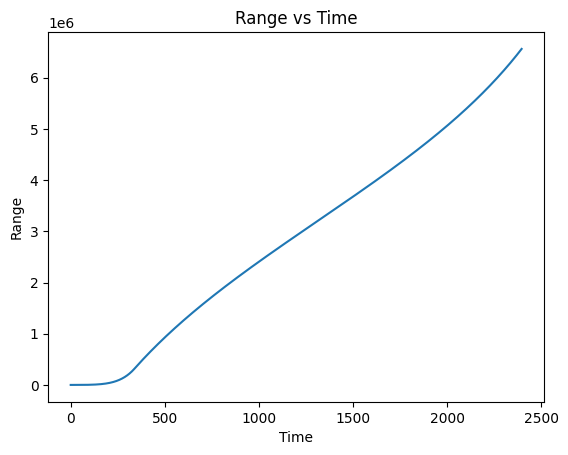

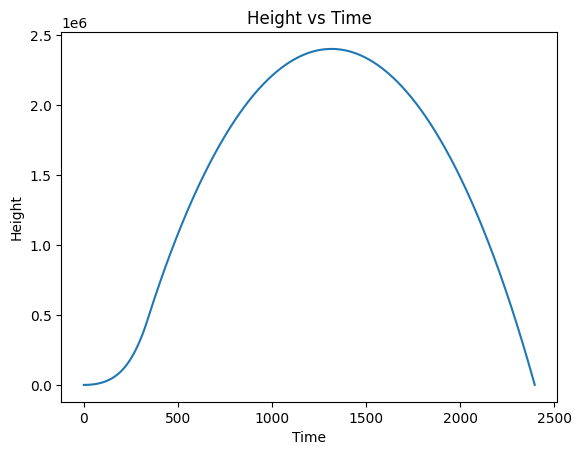

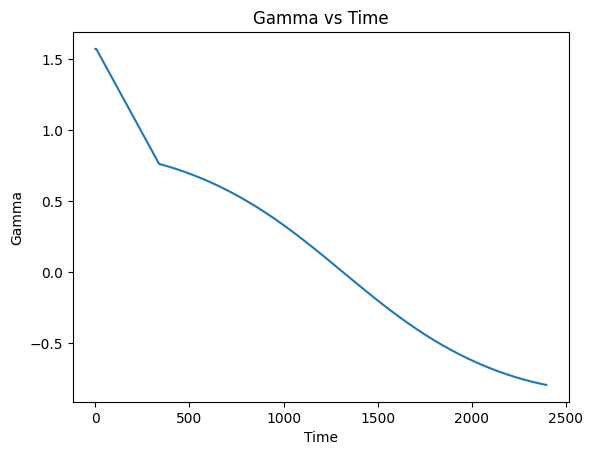

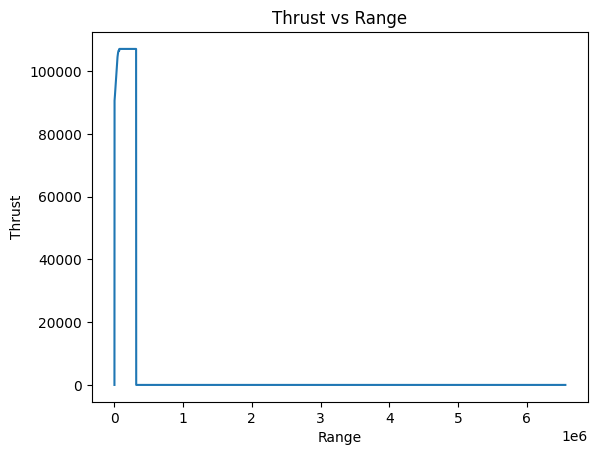

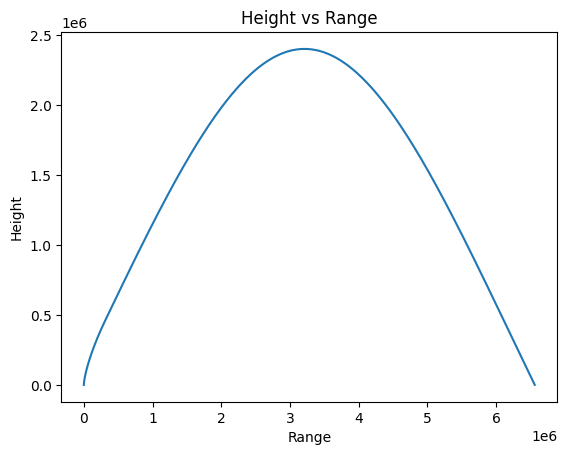

Data written to 'results/results_0.txt'

New simulation 

drymass: 1767.3550822222387
Isp0: 782.0996755462705


Stage 1 burnout
Velocity (km/s):  6.793980113646473
Angle (deg h):  43.65320066991502
Range (km):  493.6703947562971
Time (sec):  477.30000000004003
Final results: 
Range (km):  9207.174004263967
Apogee (km):  3926.7043209604435
Time to target (sec):  3605.899999997816




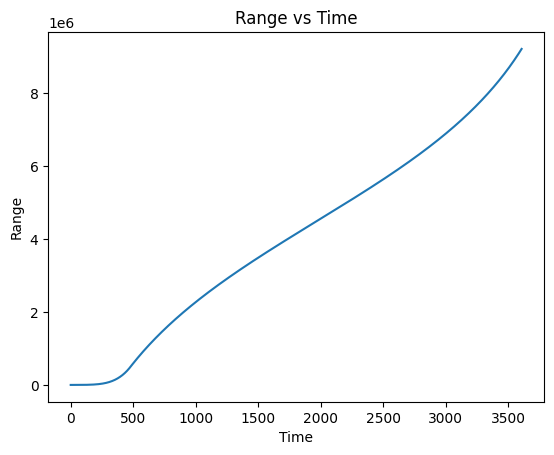

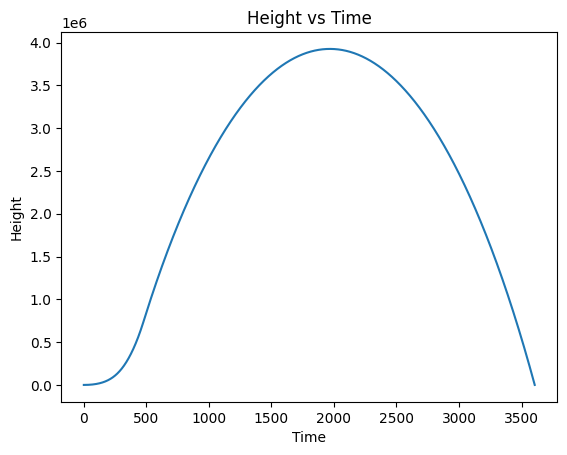

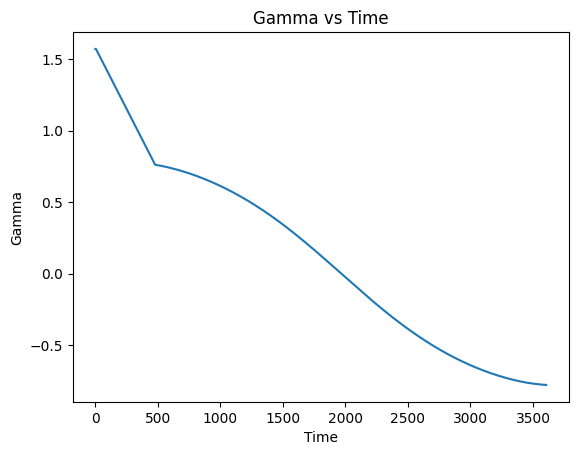

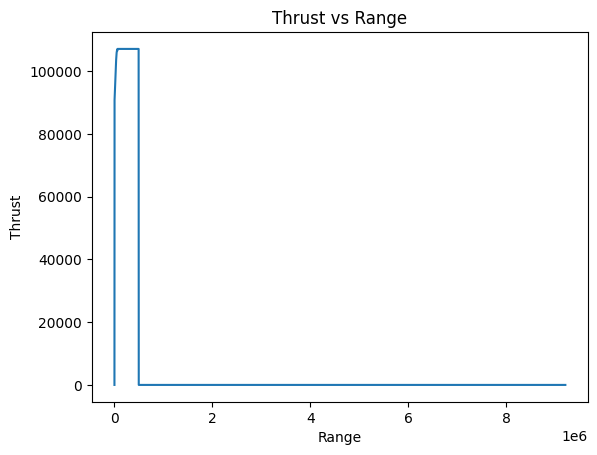

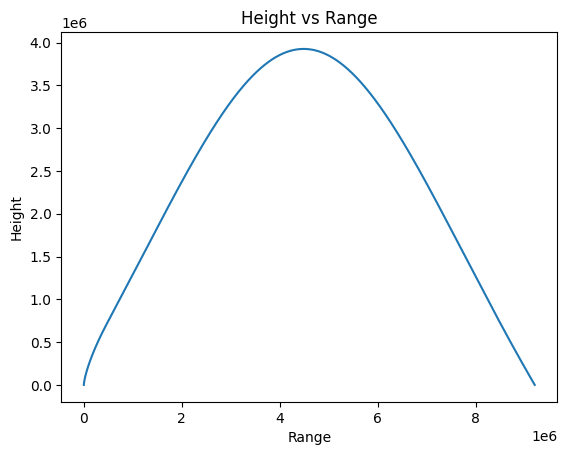

Data written to 'results/results_1.txt'

New simulation 

drymass: 1347.1949688048671
Isp0: 281.9490662314014


Stage 1 burnout
Velocity (km/s):  2.462841761753081
Angle (deg h):  43.64850214702737
Range (km):  66.51531835595247
Time (sec):  172.0999999999945
Final results: 
Range (km):  816.6666481790857
Apogee (km):  260.83487265344917
Time to target (sec):  611.5000000000705




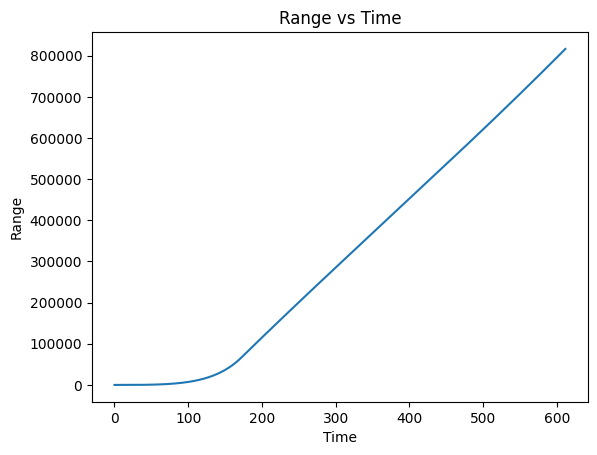

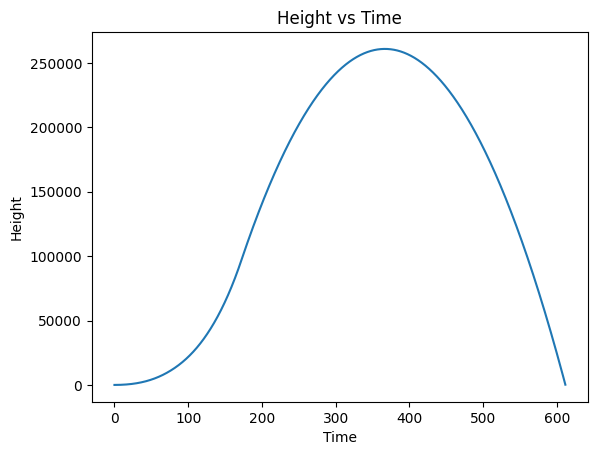

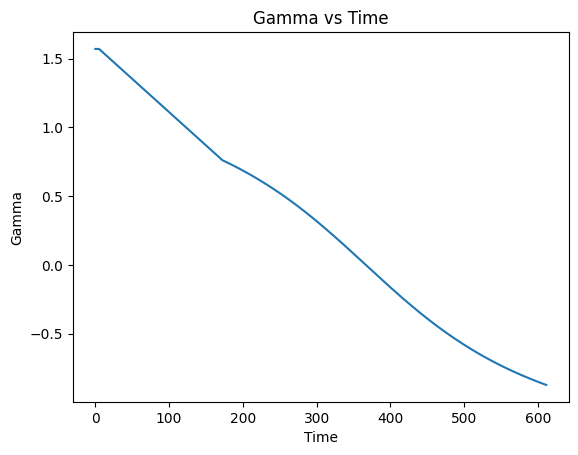

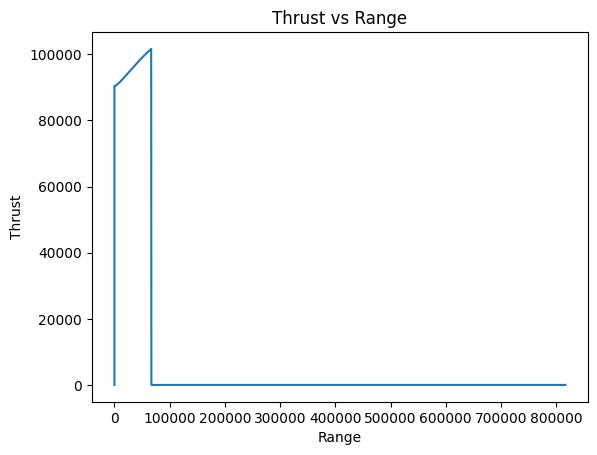

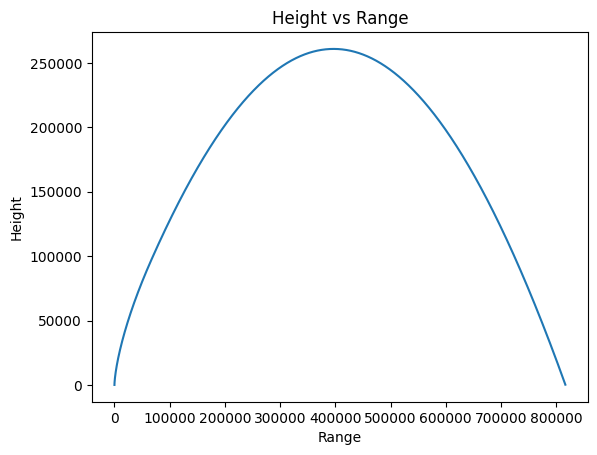

Data written to 'results/results_2.txt'

New simulation 

drymass: 2652.033837823985
Isp0: 570.191854436894


Stage 1 burnout
Velocity (km/s):  3.1541369862949407
Angle (deg h):  43.644570102397466
Range (km):  165.70598837482356
Time (sec):  348.00000000001063
Final results: 
Range (km):  1520.6169927642627
Apogee (km):  530.4646673272715
Time to target (sec):  991.7000000001569




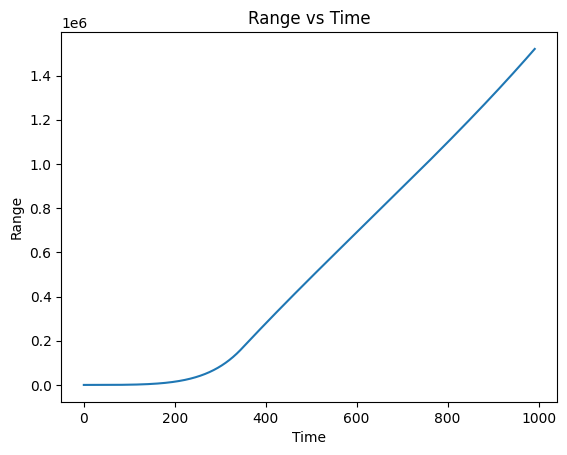

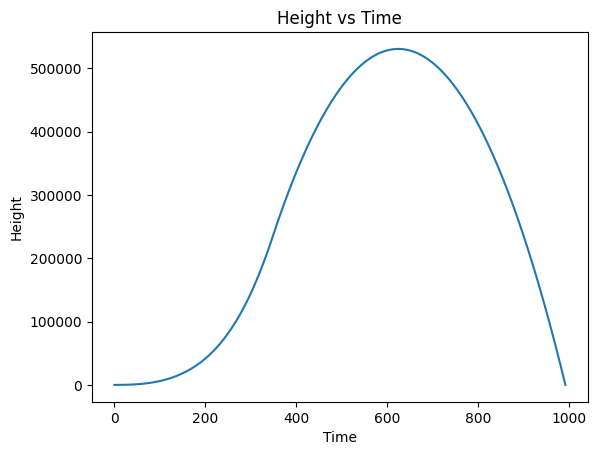

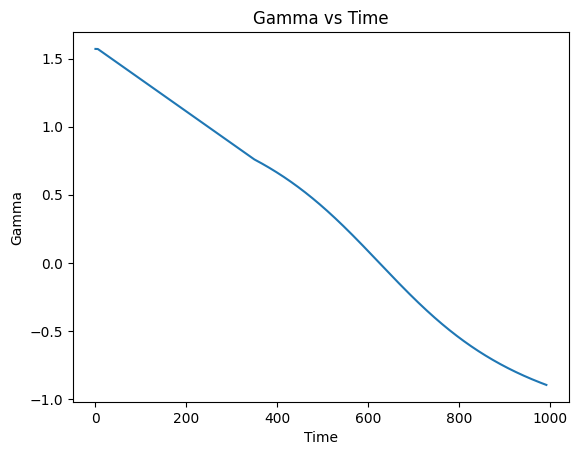

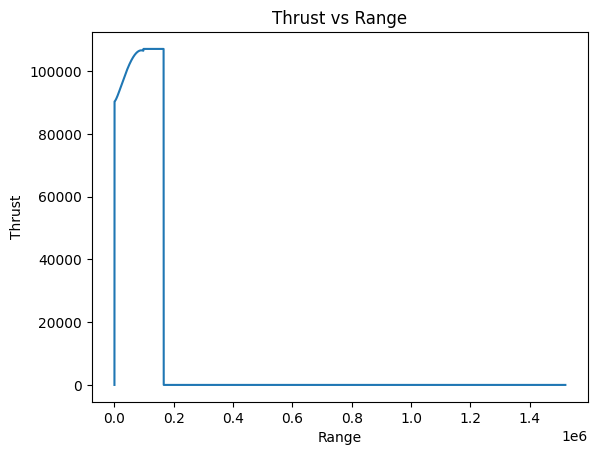

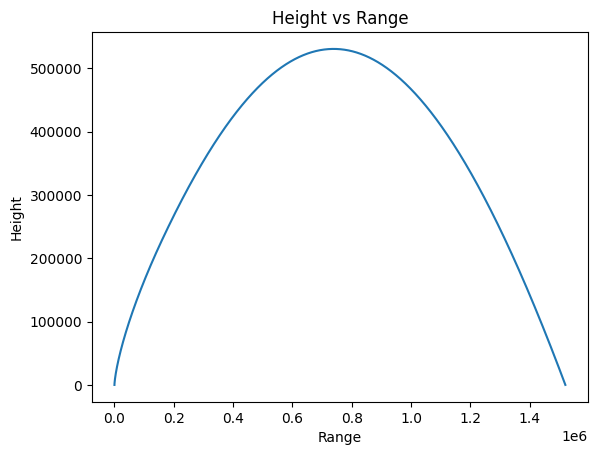

Data written to 'results/results_3.txt'

New simulation 

drymass: 1687.7652459670005
Isp0: 325.01579135476806


Stage 1 burnout
Velocity (km/s):  2.469978965163477
Angle (deg h):  43.64195666992001
Range (km):  76.99874510692987
Time (sec):  198.399999999993
Final results: 
Range (km):  844.934381000302
Apogee (km):  277.28885624760005
Time to target (sec):  647.6000000000787




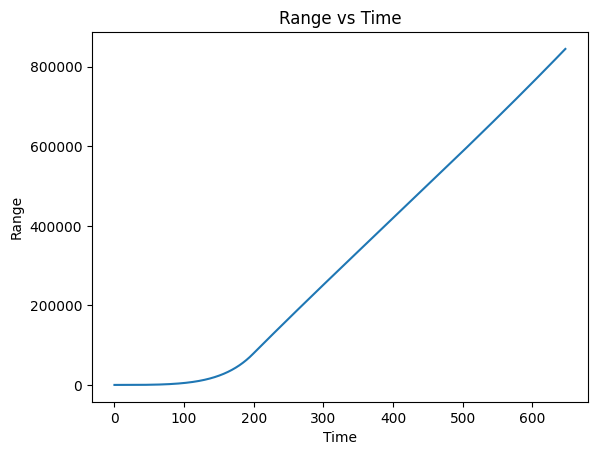

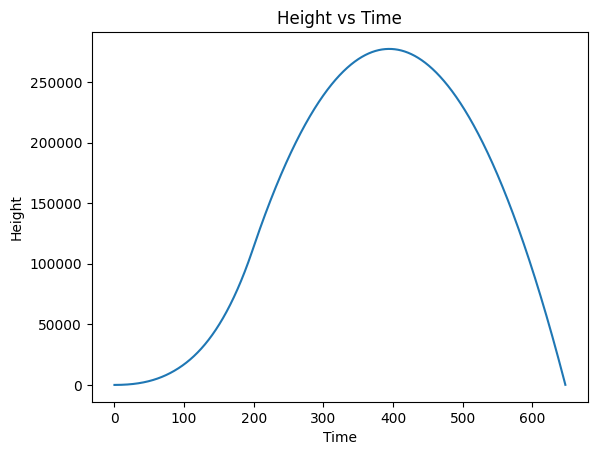

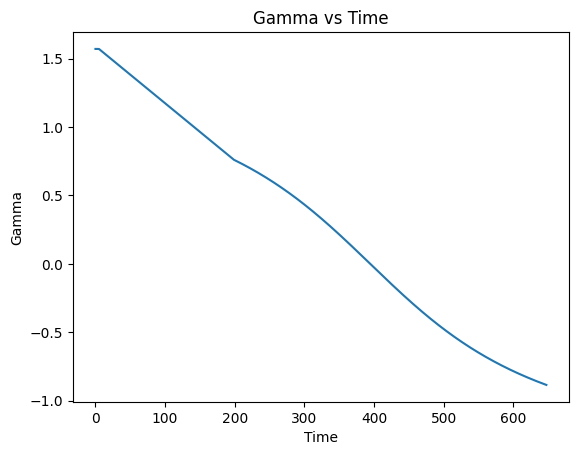

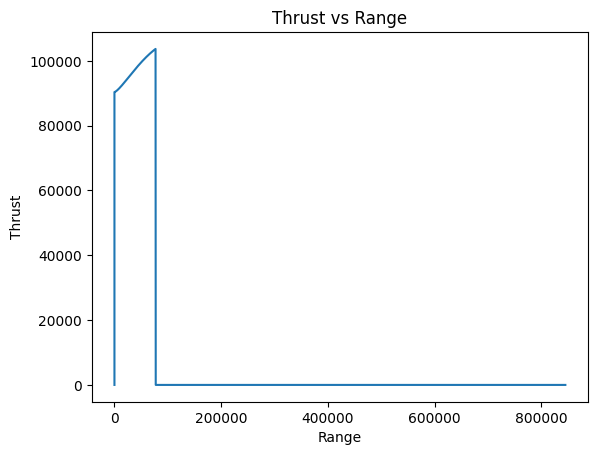

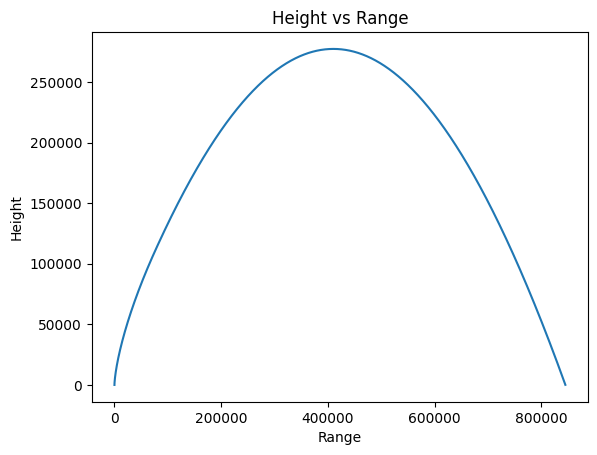

Data written to 'results/results_4.txt'

New simulation 

drymass: 2257.830593404414
Isp0: 649.600472797886


Stage 1 burnout
Velocity (km/s):  4.408028105816336
Angle (deg h):  43.655100574572245
Range (km):  267.287222586134
Time (sec):  396.40000000002163
Final results: 
Range (km):  3126.5495168075367
Apogee (km):  1087.0464611363323
Time to target (sec):  1458.2999999997692




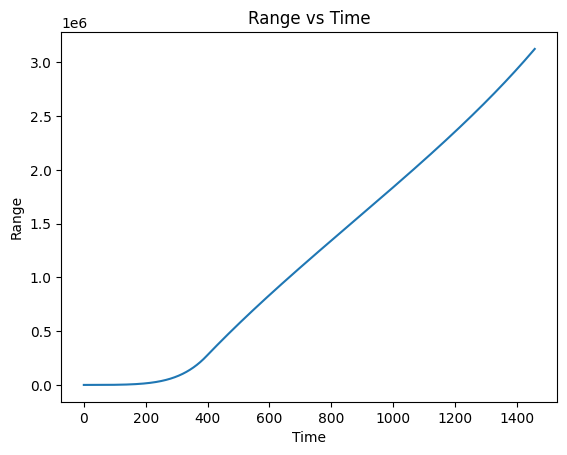

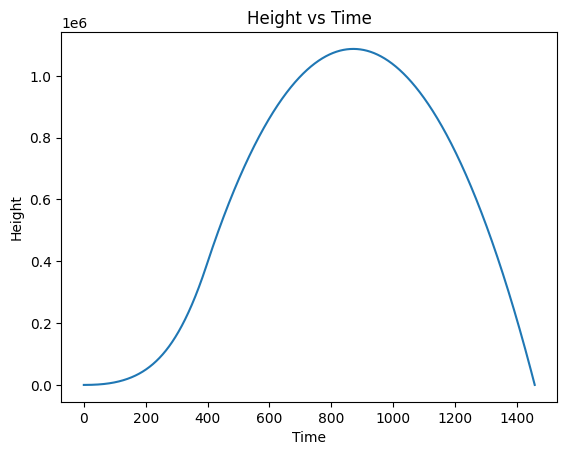

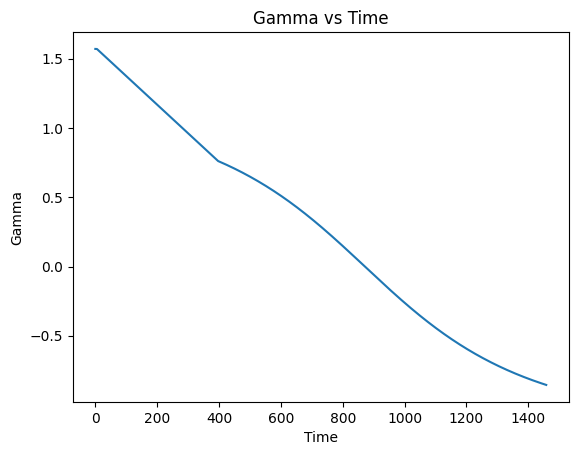

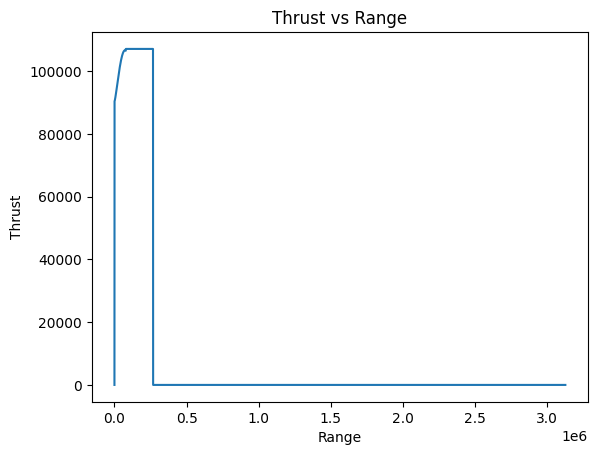

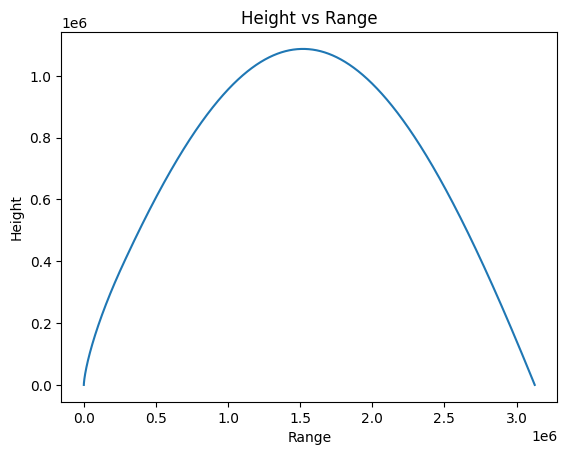

Data written to 'results/results_5.txt'


In [11]:
wirte_output_txt = True


# from emukit.core.initial_designs.latin_design import LatinDesign
# design = LatinDesign(parameter_space) 

m2_design = RandomDesign(m2_space)
m2_x = m2_design.get_samples(3*2)
m2_y = run_missile_sim(m2_x)

In [12]:
# Build model
m2_var_kernel = (100)**2 
m2_lengthscale = 100 # 100 # 1
# In catapult: RBF kernel is set to 150^2 because that’s roughly the square of the range of the catapult
m2_var_noise = 1e-5 # small value
# In catapult: 1e-5

#kern = GPy.kern.RBF(input_dim=2, lengthscale=lengthscale, variance =var_kernel)  # , lengthscale=0.08, variance=20
# kern = GPy.kern.Matern32(input_dim=1)
# kern = GPy.kern.Linear(input_dim=1)

constrain_lengthscale = True

m2_rbf_kern = GPy.kern.RBF(input_dim=2, lengthscale=m2_lengthscale)
if constrain_lengthscale:
    m2_rbf_kern.lengthscale.constrain_bounded(m2_lengthscale, m2_lengthscale*1e12)

m2_kern = m2_rbf_kern + \
    GPy.kern.Linear(input_dim=2)
m2_kern = (GPy.kern.RBF(input_dim=2, lengthscale=500) * \
           GPy.kern.RBF(input_dim=2, lengthscale=100)) + \
    GPy.kern.Linear(input_dim=2)
# m2_kern = m2_rbf_kern

m2_model_gpy = GPRegression(m2_x,m2_y, kernel=m2_kern)
m2_model_gpy.kern.variance =  m2_var_kernel 
m2_model_gpy.likelihood.variance.fix(m2_var_noise)  

# Add constraints ?
# Add priors ?
# Change Kernel
# Change variances values

display(m2_model_gpy)




reconstraining parameters rbf.lengthscale


In [13]:
# m2_model_gpy_opt = m2_model_gpy
# m2_model_gpy_opt.optimize()
# m2_model_gpy_opt.plot()

In [14]:
m2_model_emukit = GPyModelWrapper(m2_model_gpy)
m2_model_emukit.optimize()

In [15]:
display(m2_model_gpy)

In [16]:
# Create data for plot
wirte_output_txt = False
nr_points_plot = 101
m2_param_1_x_plot = np.linspace(m2_space.parameters[0].min, m2_space.parameters[0].max, nr_points_plot)[:, None]
m2_param_2_x_plot = np.linspace(m2_space.parameters[1].min, m2_space.parameters[1].max, nr_points_plot)[:, None]
m2_x_plot_mesh, m2_y_plot_mesh = np.meshgrid(m2_param_1_x_plot, m2_param_2_x_plot)
m2_x_plot = np.array([m2_x_plot_mesh, m2_y_plot_mesh]).T.reshape(-1,2)


# TEMP read data from txt
# np.savetxt('m2_y_plot_dryisp.txt', m2_y_plot, fmt='%f')
m2_y_plot = np.loadtxt('m2_y_plot_dryisp.txt', dtype=float)[:,None]

if run_grid_simulation:
#     m2_y_plot = run_missile_sim(m2_x_plot) # TAKES LONG TIME    
    m2_Z = m2_y_plot.reshape(m2_x_plot_mesh.shape)





New simulation 

drymass: 1000.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.8805872261710421
Angle (deg h):  43.66690727250592
Range (km):  8.908731452962227
Time (sec):  61.0000000000006
Final results: 
Range (km):  100.91031554375546
Apogee (km):  32.62549956112061
Time to target (sec):  206.19999999999257



New simulation 

drymass: 1000.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.9479569303010981
Angle (deg h):  43.67847754383563
Range (km):  10.23056306705791
Time (sec):  65.30000000000057
Final results: 
Range (km):  116.80071263803849
Apogee (km):  37.664665385485655
Time to target (sec):  221.6999999999917



New simulation 

drymass: 1000.0
Isp0: 114.0


Stage 1 burnout
Velocity (km/s):  1.0173077638987804
Angle (deg h):  43.65627481889667
Range (km):  11.65292600925581
Time (sec):  69.60000000000032
Final results: 
Range (km):  134.28872445187378
Apogee (km):  43.15887831476909
Time to target (sec):  237.3999999999908



New simulation 

drymass: 1000.0
Isp0:

Final results: 
Range (km):  1100.2841401689413
Apogee (km):  340.3859653484129
Time to target (sec):  689.2000000000882



New simulation 

drymass: 1000.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  2.9746028609688646
Angle (deg h):  43.660274865158364
Range (km):  78.51653902584769
Time (sec):  172.0999999999945
Final results: 
Range (km):  1177.0207114933487
Apogee (km):  364.13677996707537
Time to target (sec):  715.100000000094



New simulation 

drymass: 1000.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  3.0690947997479046
Angle (deg h):  43.652498942544185
Range (km):  82.85636172436712
Time (sec):  176.39999999999426
Final results: 
Range (km):  1257.7138485573616
Apogee (km):  389.04217823438535
Time to target (sec):  741.6000000001001



New simulation 

drymass: 1000.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  3.1580964866556682
Angle (deg h):  43.65545191748038
Range (km):  87.1068121912509
Time (sec):  180.59999999999403
Final results: 
Range (km):  1336.85

Final results: 
Range (km):  4467.882348861197
Apogee (km):  1492.0456616019046
Time to target (sec):  1688.39999999956



New simulation 

drymass: 1000.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  5.423953910561907
Angle (deg h):  43.65244130543744
Range (km):  231.66087098918837
Time (sec):  283.1999999999959
Final results: 
Range (km):  4674.453827744399
Apogee (km):  1572.1094860302208
Time to target (sec):  1750.899999999503



New simulation 

drymass: 1000.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  5.512881533883903
Angle (deg h):  43.651078366225775
Range (km):  238.93092111412724
Time (sec):  287.39999999999685
Final results: 
Range (km):  4873.985672036006
Apogee (km):  1651.3331145733018
Time to target (sec):  1812.3999999994471



New simulation 

drymass: 1000.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  5.608360764600443
Angle (deg h):  43.65956757658833
Range (km):  246.6927946669591
Time (sec):  291.69999999999783
Final results: 
Range (km):  5094.1789

Final results: 
Range (km):  12382.821352467405
Apogee (km):  6464.913014344001
Time to target (sec):  5457.4000000023225



New simulation 

drymass: 1000.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  7.869997508086089
Angle (deg h):  43.66142952595221
Range (km):  463.4759892421272
Time (sec):  394.20000000002113
Final results: 
Range (km):  12798.549678931147
Apogee (km):  6931.795339984998
Time to target (sec):  5816.4000000036285



New simulation 

drymass: 1000.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  7.967116902206692
Angle (deg h):  43.65806192780579
Range (km):  473.9692762794486
Time (sec):  398.5000000000221
Final results: 
Range (km):  13223.244203246677
Apogee (km):  7443.54228714409
Time to target (sec):  6213.200000005072



New simulation 

drymass: 1000.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  8.064331807130168
Angle (deg h):  43.654767329150836
Range (km):  484.5643147864003
Time (sec):  402.8000000000231
Final results: 
Range (km):  13651.22143

Final results: 
Range (km):  271.94741915479426
Apogee (km):  85.86503774219653
Time to target (sec):  336.60000000000804



New simulation 

drymass: 1020.0
Isp0: 163.0


Stage 1 burnout
Velocity (km/s):  1.5308564578286472
Angle (deg h):  43.6557741190263
Range (km):  24.220007761372383
Time (sec):  99.49999999999862
Final results: 
Range (km):  302.22180083425525
Apogee (km):  95.14688385869735
Time to target (sec):  354.5000000000121



New simulation 

drymass: 1020.0
Isp0: 170.0


Stage 1 burnout
Velocity (km/s):  1.6102981140042565
Angle (deg h):  43.64239074691116
Range (km):  26.49928689068189
Time (sec):  103.79999999999838
Final results: 
Range (km):  334.4224055257453
Apogee (km):  104.9846230023961
Time to target (sec):  372.70000000001625



New simulation 

drymass: 1020.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  1.6845319705530664
Angle (deg h):  43.652806265426406
Range (km):  28.769562073961275
Time (sec):  107.99999999999814
Final results: 
Range (km):  366.19

Final results: 
Range (km):  1982.0715170339802
Apogee (km):  618.9990365494273
Time to target (sec):  966.7000000001512



New simulation 

drymass: 1020.0
Isp0: 352.0


Stage 1 burnout
Velocity (km/s):  3.875280373490727
Angle (deg h):  43.662886889154024
Range (km):  125.94266533326804
Time (sec):  214.79999999999208
Final results: 
Range (km):  2096.2864686710523
Apogee (km):  656.097959897361
Time to target (sec):  1000.4000000001589



New simulation 

drymass: 1020.0
Isp0: 359.0


Stage 1 burnout
Velocity (km/s):  3.9708008435166615
Angle (deg h):  43.65661527955963
Range (km):  131.557067341172
Time (sec):  219.09999999999184
Final results: 
Range (km):  2214.7672009123676
Apogee (km):  694.6051682970702
Time to target (sec):  1034.9000000001543



New simulation 

drymass: 1020.0
Isp0: 366.0


Stage 1 burnout
Velocity (km/s):  4.066132776399463
Angle (deg h):  43.65058900251818
Range (km):  137.3015092543603
Time (sec):  223.3999999999916
Final results: 
Range (km):  2337.7317

Stage 1 burnout
Velocity (km/s):  6.294097454852985
Angle (deg h):  43.65534229417143
Range (km):  309.2728985274701
Time (sec):  325.9000000000056
Final results: 
Range (km):  6934.195599030098
Apogee (km):  2563.110193638762
Time to target (sec):  2508.7999999988137



New simulation 

drymass: 1020.0
Isp0: 541.0


Stage 1 burnout
Velocity (km/s):  6.382580815080592
Angle (deg h):  43.652984628007715
Range (km):  317.56513210183294
Time (sec):  330.10000000000656
Final results: 
Range (km):  7204.287978814844
Apogee (km):  2697.122732677192
Time to target (sec):  2609.9999999987217



New simulation 

drymass: 1020.0
Isp0: 548.0


Stage 1 burnout
Velocity (km/s):  6.4775825545851555
Angle (deg h):  43.66148764686536
Range (km):  326.3943420123108
Time (sec):  334.40000000000754
Final results: 
Range (km):  7500.00834566418
Apogee (km):  2849.742447458672
Time to target (sec):  2724.6999999986174



New simulation 

drymass: 1020.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  6.572

Final results: 
Range (km):  16666.768212549225
Apogee (km):  14236.832548925824
Time to target (sec):  11781.200000025328



New simulation 

drymass: 1020.0
Isp0: 723.0


Stage 1 burnout
Velocity (km/s):  8.83332202723691
Angle (deg h):  43.65981408382363
Range (km):  577.6563214377126
Time (sec):  441.2000000000318
Final results: 
Range (km):  17092.843613465484
Apogee (km):  15653.447080307884
Time to target (sec):  13019.300000029833



New simulation 

drymass: 1020.0
Isp0: 730.0


Stage 1 burnout
Velocity (km/s):  8.930601064064762
Angle (deg h):  43.65682694496312
Range (km):  589.124963928949
Time (sec):  445.5000000000328
Final results: 
Range (km):  17515.57865737761
Apogee (km):  17289.413721909234
Time to target (sec):  14483.50000003516



New simulation 

drymass: 1020.0
Isp0: 737.0


Stage 1 burnout
Velocity (km/s):  9.021468053230887
Angle (deg h):  43.65220516073981
Range (km):  600.1174621795283
Time (sec):  449.70000000003375
Final results: 
Range (km):  17908.67005

Final results: 
Range (km):  552.1834959833428
Apogee (km):  172.35209470634604
Time to target (sec):  481.600000000041



New simulation 

drymass: 1040.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  2.1433489137407706
Angle (deg h):  43.64532827914025
Range (km):  44.88267633383504
Time (sec):  133.6999999999967
Final results: 
Range (km):  597.9326900947143
Apogee (km):  186.36903997684215
Time to target (sec):  501.60000000004555



New simulation 

drymass: 1040.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  2.2204676623070876
Angle (deg h):  43.65219434294673
Range (km):  47.87479327396456
Time (sec):  137.89999999999645
Final results: 
Range (km):  642.8534518109487
Apogee (km):  200.3589606506126
Time to target (sec):  520.9000000000499



New simulation 

drymass: 1040.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  2.3041340260538203
Angle (deg h):  43.66048602568982
Range (km):  51.137908049792706
Time (sec):  142.1999999999962
Final results: 
Range (km):  693.488051

Final results: 
Range (km):  2790.0734332352827
Apogee (km):  887.9646079799355
Time to target (sec):  1203.400000000001



New simulation 

drymass: 1040.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  4.479392013209562
Angle (deg h):  43.66220406702983
Range (km):  165.7017250577855
Time (sec):  244.69999999999038
Final results: 
Range (km):  2932.689543450334
Apogee (km):  936.8751796561928
Time to target (sec):  1244.4999999999636



New simulation 

drymass: 1040.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  4.573207410474651
Angle (deg h):  43.656715978912445
Range (km):  172.13836174282258
Time (sec):  248.99999999999014
Final results: 
Range (km):  3080.367200922965
Apogee (km):  987.7467914252703
Time to target (sec):  1286.7999999999251



New simulation 

drymass: 1040.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  4.66696313275594
Angle (deg h):  43.651417546152835
Range (km):  178.6986895839451
Time (sec):  253.2999999999899
Final results: 
Range (km):  3233.41649

Final results: 
Range (km):  8528.266633928706
Apogee (km):  3422.0119134994543
Time to target (sec):  3156.5999999982246



New simulation 

drymass: 1040.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  6.875738484110584
Angle (deg h):  43.655649741114416
Range (km):  368.37887107059106
Time (sec):  355.8000000000124
Final results: 
Range (km):  8862.380756044047
Apogee (km):  3622.695847586721
Time to target (sec):  3307.4999999980873



New simulation 

drymass: 1040.0
Isp0: 590.0


Stage 1 burnout
Velocity (km/s):  6.963872378960884
Angle (deg h):  43.65274052583752
Range (km):  377.3224575955215
Time (sec):  360.00000000001336
Final results: 
Range (km):  9183.379223329313
Apogee (km):  3824.3710396988663
Time to target (sec):  3459.1999999979494



New simulation 

drymass: 1040.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  7.058465972472834
Angle (deg h):  43.66128734495307
Range (km):  386.8309654685023
Time (sec):  364.30000000001434
Final results: 
Range (km):  9532.836

Simulation exceeded time limit.
Final results: 
Range (km):  14568.13329324901
Apogee (km):  24278.513653689475
Time to target (sec):  20000.099999989452



New simulation 

drymass: 1040.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  9.311111893407162
Angle (deg h):  43.662699977152045
Range (km):  641.2060352494777
Time (sec):  466.80000000003764
Simulation exceeded time limit.
Final results: 
Range (km):  12033.948500976243
Apogee (km):  27323.46404361148
Time to target (sec):  20000.099999989452



New simulation 

drymass: 1040.0
Isp0: 772.0


Stage 1 burnout
Velocity (km/s):  9.408128143932911
Angle (deg h):  43.65985278946717
Range (km):  653.1262032489818
Time (sec):  471.1000000000386
Simulation exceeded time limit.
Final results: 
Range (km):  10924.88696321386
Apogee (km):  31305.697432542813
Time to target (sec):  20000.099999989452



New simulation 

drymass: 1040.0
Isp0: 779.0


Stage 1 burnout
Velocity (km/s):  9.505239542670148
Angle (deg h):  43.65705769501598
Rang

Final results: 
Range (km):  782.9461514770766
Apogee (km):  244.04795162401513
Time to target (sec):  578.700000000063



New simulation 

drymass: 1060.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  2.5272729678797488
Angle (deg h):  43.66439854901893
Range (km):  60.87890143067471
Time (sec):  154.99999999999548
Final results: 
Range (km):  840.9406563377904
Apogee (km):  261.9558071292592
Time to target (sec):  600.9000000000681



New simulation 

drymass: 1060.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  2.6141344711494017
Angle (deg h):  43.65562693144567
Range (km):  64.58619295181083
Time (sec):  159.29999999999524
Final results: 
Range (km):  902.0031057390058
Apogee (km):  280.7417888876016
Time to target (sec):  623.5000000000732



New simulation 

drymass: 1060.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  2.7021191886339846
Angle (deg h):  43.64733276387322
Range (km):  68.41816441991404
Time (sec):  163.599999999995
Final results: 
Range (km):  966.339169932

Final results: 
Range (km):  3460.6210239506563
Apogee (km):  1123.417903568894
Time to target (sec):  1399.099999999823



New simulation 

drymass: 1060.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  4.889414104763253
Angle (deg h):  43.65419203502852
Range (km):  196.8808693796847
Time (sec):  266.099999999992
Final results: 
Range (km):  3626.0535413690995
Apogee (km):  1182.6411926088613
Time to target (sec):  1446.9999999997794



New simulation 

drymass: 1060.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  4.975931253757239
Angle (deg h):  43.65363788545724
Range (km):  203.51732221600855
Time (sec):  270.29999999999296
Final results: 
Range (km):  3786.0408238299374
Apogee (km):  1241.06611575936
Time to target (sec):  1493.8999999997368



New simulation 

drymass: 1060.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  5.06868557881708
Angle (deg h):  43.661702228600916
Range (km):  210.6117789458953
Time (sec):  274.59999999999394
Final results: 
Range (km):  3962.78189

Final results: 
Range (km):  9994.461777076433
Apogee (km):  4378.291374094675
Time to target (sec):  3877.7999999975686



New simulation 

drymass: 1060.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  7.2617281926264265
Angle (deg h):  43.65083920849818
Range (km):  411.8034898038409
Time (sec):  377.10000000001725
Final results: 
Range (km):  10339.275189617414
Apogee (km):  4632.325558172452
Time to target (sec):  4069.599999997394



New simulation 

drymass: 1060.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  7.35574824132959
Angle (deg h):  43.65940229341482
Range (km):  421.6488184502312
Time (sec):  381.4000000000182
Final results: 
Range (km):  10712.601430491959
Apogee (km):  4925.175046150776
Time to target (sec):  4290.599999998078



New simulation 

drymass: 1060.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  7.44985388756792
Angle (deg h):  43.65594012339411
Range (km):  431.5971351245734
Time (sec):  385.7000000000192
Final results: 
Range (km):  11095.77169469

Simulation exceeded time limit.
Final results: 
Range (km):  9786.718086713083
Apogee (km):  42914.1967579157
Time to target (sec):  20000.099999989452



New simulation 

drymass: 1060.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  9.693336813493751
Angle (deg h):  43.658472560613156
Range (km):  695.2253308653643
Time (sec):  488.2000000000425
Simulation exceeded time limit.
Final results: 
Range (km):  9436.281721261894
Apogee (km):  49390.30102308187
Time to target (sec):  20000.099999989452



New simulation 

drymass: 1080.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.8467544494502477
Angle (deg h):  43.66690727250592
Range (km):  8.605892720026246
Time (sec):  61.0000000000006
Final results: 
Range (km):  94.05618312452378
Apogee (km):  30.70713303247902
Time to target (sec):  201.19999999999285



New simulation 

drymass: 1080.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.9109466919239282
Angle (deg h):  43.67671113156228
Range (km):  9.880227329657437
Time (sec

Final results: 
Range (km):  1077.2690688921152
Apogee (km):  335.5981704770831
Time to target (sec):  687.4000000000877



New simulation 

drymass: 1080.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  2.933528317051694
Angle (deg h):  43.65180492243615
Range (km):  79.69220655546624
Time (sec):  176.39999999999426
Final results: 
Range (km):  1150.278207684972
Apogee (km):  358.2022726918199
Time to target (sec):  712.2000000000934



New simulation 

drymass: 1080.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  3.018546617245275
Angle (deg h):  43.65545191748038
Range (km):  83.77511832329196
Time (sec):  180.59999999999403
Final results: 
Range (km):  1222.2877223982134
Apogee (km):  380.7131874977364
Time to target (sec):  736.5000000000989



New simulation 

drymass: 1080.0
Isp0: 303.0


Stage 1 burnout
Velocity (km/s):  3.110336265085077
Angle (deg h):  43.66313928134293
Range (km):  88.19708330215921
Time (sec):  184.89999999999378
Final results: 
Range (km):  1302.3699260

Final results: 
Range (km):  4230.226457144402
Apogee (km):  1408.0751720876276
Time to target (sec):  1627.699999999615



New simulation 

drymass: 1080.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  5.285102772232507
Angle (deg h):  43.651078366225775
Range (km):  230.0588209996108
Time (sec):  287.39999999999685
Final results: 
Range (km):  4408.828026144127
Apogee (km):  1476.4961098093877
Time to target (sec):  1681.4999999995662



New simulation 

drymass: 1080.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  5.377011429143794
Angle (deg h):  43.65912480250773
Range (km):  237.55428248540585
Time (sec):  291.69999999999783
Final results: 
Range (km):  4605.169873863337
Apogee (km):  1553.2207944724391
Time to target (sec):  1741.2999999995118



New simulation 

drymass: 1080.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  5.468961762467615
Angle (deg h):  43.65457711342062
Range (km):  245.1663914067364
Time (sec):  295.9999999999988
Final results: 
Range (km):  4809.320

Final results: 
Range (km):  11555.949006781315
Apogee (km):  5652.2353648085345
Time to target (sec):  4844.500000000093



New simulation 

drymass: 1080.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  7.648596132973311
Angle (deg h):  43.6576882021257
Range (km):  457.4927307230672
Time (sec):  398.5000000000221
Final results: 
Range (km):  11951.378144021997
Apogee (km):  6027.639552681261
Time to target (sec):  5131.200000001136



New simulation 

drymass: 1080.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  7.742188661934903
Angle (deg h):  43.65439534293653
Range (km):  467.762134419696
Time (sec):  402.8000000000231
Final results: 
Range (km):  12352.959749325959
Apogee (km):  6436.732901635272
Time to target (sec):  5445.000000002277



New simulation 

drymass: 1080.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  7.829619127076993
Angle (deg h):  43.66269538755248
Range (km):  477.6198532490303
Time (sec):  407.00000000002404
Final results: 
Range (km):  12731.66765715

Final results: 
Range (km):  279.21351381513836
Apogee (km):  88.77607627824834
Time to target (sec):  344.3000000000098



New simulation 

drymass: 1100.0
Isp0: 170.0


Stage 1 burnout
Velocity (km/s):  1.5419812623700206
Angle (deg h):  43.64122914374402
Range (km):  25.528279240603894
Time (sec):  103.79999999999838
Final results: 
Range (km):  308.92366955808296
Apogee (km):  97.90429593518441
Time to target (sec):  361.9000000000138



New simulation 

drymass: 1100.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  1.6131085350487708
Angle (deg h):  43.652806265426406
Range (km):  27.711837056939316
Time (sec):  107.99999999999814
Final results: 
Range (km):  338.1127264959709
Apogee (km):  107.0634760470476
Time to target (sec):  378.7000000000176



New simulation 

drymass: 1100.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.6896164472011461
Angle (deg h):  43.6608865631483
Range (km):  30.114402646783176
Time (sec):  112.2999999999979
Final results: 
Range (km):  371.057

Stage 1 burnout
Velocity (km/s):  3.8921967756713443
Angle (deg h):  43.650038867874365
Range (km):  132.04810864879573
Time (sec):  223.3999999999916
Final results: 
Range (km):  2131.038004567845
Apogee (km):  671.1407566604834
Time to target (sec):  1018.300000000163



New simulation 

drymass: 1100.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  3.977854637438266
Angle (deg h):  43.65134488199179
Range (km):  137.42482982996353
Time (sec):  227.59999999999135
Final results: 
Range (km):  2239.0672231664694
Apogee (km):  706.7646745216433
Time to target (sec):  1050.2000000001403



New simulation 

drymass: 1100.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  4.069462427457844
Angle (deg h):  43.659100399149544
Range (km):  143.2003080772493
Time (sec):  231.8999999999911
Final results: 
Range (km):  2358.0288782990647
Apogee (km):  746.2837652211108
Time to target (sec):  1085.0000000001087



New simulation 

drymass: 1100.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  4.

Stage 1 burnout
Velocity (km/s):  6.215705703282677
Angle (deg h):  43.66108064856125
Range (km):  314.6204388683631
Time (sec):  334.40000000000754
Final results: 
Range (km):  6754.096528240433
Apogee (km):  2486.2522808706035
Time to target (sec):  2456.4999999988613



New simulation 

drymass: 1100.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  6.307242549474436
Angle (deg h):  43.65709860632187
Range (km):  323.26919265730646
Time (sec):  338.7000000000085
Final results: 
Range (km):  7027.924722344427
Apogee (km):  2619.2508932796686
Time to target (sec):  2557.09999999877



New simulation 

drymass: 1100.0
Isp0: 562.0


Stage 1 burnout
Velocity (km/s):  6.3988432789761385
Angle (deg h):  43.65321810903209
Range (km):  332.0265074596023
Time (sec):  343.0000000000095
Final results: 
Range (km):  7310.028936178571
Apogee (km):  2760.6093939452503
Time to target (sec):  2663.799999998673



New simulation 

drymass: 1100.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  6.4844

Final results: 
Range (km):  16105.512961696568
Apogee (km):  12592.083685137259
Time to target (sec):  10393.70000002028



New simulation 

drymass: 1100.0
Isp0: 737.0


Stage 1 burnout
Velocity (km/s):  8.666202705619982
Angle (deg h):  43.65220516073981
Range (km):  579.9008109528236
Time (sec):  449.70000000003375
Final results: 
Range (km):  16499.382082757813
Apogee (km):  13658.021203424803
Time to target (sec):  11299.900000023577



New simulation 

drymass: 1100.0
Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  8.760092656937722
Angle (deg h):  43.660989036921556
Range (km):  591.2095875833533
Time (sec):  454.00000000003473
Final results: 
Range (km):  16911.883359714247
Apogee (km):  14945.439751270898
Time to target (sec):  12413.70000002763



New simulation 

drymass: 1100.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  8.85408853777803
Angle (deg h):  43.658074692440884
Range (km):  602.6086179226835
Time (sec):  458.3000000000357
Final results: 
Range (km):  17325.8

Final results: 
Range (km):  469.40348663846373
Apogee (km):  148.0491693894797
Time to target (sec):  447.8000000000333



New simulation 

drymass: 1120.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.9739041839059899
Angle (deg h):  43.65466133821635
Range (km):  40.2922454694158
Time (sec):  129.39999999999694
Final results: 
Range (km):  509.05793890777284
Apogee (km):  160.32994339326584
Time to target (sec):  466.5000000000376



New simulation 

drymass: 1120.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  2.0521550011696106
Angle (deg h):  43.64442895757142
Range (km):  43.21079330650134
Time (sec):  133.6999999999967
Final results: 
Range (km):  550.9318934879827
Apogee (km):  173.25887243797672
Time to target (sec):  485.6000000000419



New simulation 

drymass: 1120.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  2.1258347836872535
Angle (deg h):  43.65219434294673
Range (km):  46.08851787734797
Time (sec):  137.89999999999645
Final results: 
Range (km):  592.30668

Final results: 
Range (km):  2541.8896725632308
Apogee (km):  808.90613605888
Time to target (sec):  1140.6000000000581



New simulation 

drymass: 1120.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  4.29172394961974
Angle (deg h):  43.66169700546081
Range (km):  159.42322058685068
Time (sec):  244.69999999999038
Final results: 
Range (km):  2670.3914333482403
Apogee (km):  852.5178969354491
Time to target (sec):  1177.9000000000242



New simulation 

drymass: 1120.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  4.382102030260581
Angle (deg h):  43.65621634317708
Range (km):  165.62832213037515
Time (sec):  248.99999999999014
Final results: 
Range (km):  2803.729607079861
Apogee (km):  897.7673314426208
Time to target (sec):  1216.2999999999893



New simulation 

drymass: 1120.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  4.47244595879144
Angle (deg h):  43.650925006119195
Range (km):  171.95462763079198
Time (sec):  253.2999999999899
Final results: 
Range (km):  2941.71724

Final results: 
Range (km):  7678.451694692648
Apogee (km):  2955.762838291155
Time to target (sec):  2812.3999999985376



New simulation 

drymass: 1120.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  6.600726672357749
Angle (deg h):  43.655256678580436
Range (km):  355.2702957775738
Time (sec):  355.8000000000124
Final results: 
Range (km):  7977.699174789898
Apogee (km):  3117.504403173651
Time to target (sec):  2934.199999998427



New simulation 

drymass: 1120.0
Isp0: 590.0


Stage 1 burnout
Velocity (km/s):  6.68572228025394
Angle (deg h):  43.65274052583752
Range (km):  363.93040054836536
Time (sec):  360.00000000001336
Final results: 
Range (km):  8266.363572562776
Apogee (km):  3279.3765403595257
Time to target (sec):  3056.099999998316



New simulation 

drymass: 1120.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  6.776827491309421
Angle (deg h):  43.66089914266926
Range (km):  373.1362048010677
Time (sec):  364.30000000001434
Final results: 
Range (km):  8581.1641545

Final results: 
Range (km):  17387.45633344436
Apogee (km):  16628.83526340467
Time to target (sec):  13910.200000033074



New simulation 

drymass: 1120.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  8.94730717953976
Angle (deg h):  43.6623532539758
Range (km):  619.8409875702209
Time (sec):  466.80000000003764
Final results: 
Range (km):  17766.530906454933
Apogee (km):  18238.623570794563
Time to target (sec):  15372.800000038395



New simulation 

drymass: 1120.0
Isp0: 772.0


Stage 1 burnout
Velocity (km/s):  9.040766968009068
Angle (deg h):  43.65950736206365
Range (km):  631.4188670725766
Time (sec):  471.1000000000386
Final results: 
Range (km):  18170.22276228813
Apogee (km):  20225.956428775582
Time to target (sec):  17228.20000002979



New simulation 

drymass: 1120.0
Isp0: 779.0


Stage 1 burnout
Velocity (km/s):  9.134320619811476
Angle (deg h):  43.656713545287325
Range (km):  643.0822896358868
Time (sec):  475.4000000000396
Final results: 
Range (km):  18568.343781

Final results: 
Range (km):  773.2138788968832
Apogee (km):  242.8175376072142
Time to target (sec):  580.3000000000634



New simulation 

drymass: 1140.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  2.501602171708424
Angle (deg h):  43.65485873821557
Range (km):  62.156667629384835
Time (sec):  159.29999999999524
Final results: 
Range (km):  828.99585431392
Apogee (km):  260.0082173822559
Time to target (sec):  601.8000000000683



New simulation 

drymass: 1140.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  2.5854267602581427
Angle (deg h):  43.64658259189618
Range (km):  65.8388421623755
Time (sec):  163.599999999995
Final results: 
Range (km):  887.4734674286841
Apogee (km):  278.11278347902936
Time to target (sec):  623.7000000000733



New simulation 

drymass: 1140.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  2.6647418744171993
Angle (deg h):  43.65180718461774
Range (km):  69.45221551320792
Time (sec):  167.79999999999475
Final results: 
Range (km):  945.19102914374

Final results: 
Range (km):  3297.3820101626266
Apogee (km):  1070.9751892080544
Time to target (sec):  1361.3999999998573



New simulation 

drymass: 1140.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  4.771481582296361
Angle (deg h):  43.65363788545724
Range (km):  195.91440193416236
Time (sec):  270.29999999999296
Final results: 
Range (km):  3441.3356783785066
Apogee (km):  1122.4798397693933
Time to target (sec):  1403.399999999819



New simulation 

drymass: 1140.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  4.860856921655034
Angle (deg h):  43.66123961657365
Range (km):  202.7619674580842
Time (sec):  274.59999999999394
Final results: 
Range (km):  3599.6501812979695
Apogee (km):  1179.8630084702656
Time to target (sec):  1449.699999999777



New simulation 

drymass: 1140.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  4.950227881979899
Angle (deg h):  43.656369638365746
Range (km):  209.72574486958936
Time (sec):  278.8999999999949
Final results: 
Range (km):  3764.

Final results: 
Range (km):  9315.671466596204
Apogee (km):  3922.155192667735
Time to target (sec):  3541.5999999978744



New simulation 

drymass: 1140.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  7.064845744615379
Angle (deg h):  43.65902361947491
Range (km):  406.8849000212881
Time (sec):  381.4000000000182
Final results: 
Range (km):  9655.433771334458
Apogee (km):  4150.576214098234
Time to target (sec):  3713.499999997718



New simulation 

drymass: 1140.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  7.155501627414667
Angle (deg h):  43.65556348372654
Range (km):  416.5230284333225
Time (sec):  385.7000000000192
Final results: 
Range (km):  10004.781062911266
Apogee (km):  4395.069275894327
Time to target (sec):  3897.9999999975503



New simulation 

drymass: 1140.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  7.2402840970915765
Angle (deg h):  43.652534346600824
Range (km):  425.78646167266965
Time (sec):  389.90000000002016
Final results: 
Range (km):  10339.7924

Simulation exceeded time limit.
Final results: 
Range (km):  11498.810304613495
Apogee (km):  28878.46875980559
Time to target (sec):  20000.099999989452



New simulation 

drymass: 1160.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.8149326586771719
Angle (deg h):  43.66690727250592
Range (km):  8.315552397970965
Time (sec):  61.0000000000006
Final results: 
Range (km):  87.82294156844424
Apogee (km):  28.946510771766533
Time to target (sec):  196.49999999999312



New simulation 

drymass: 1160.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.8761905221216799
Angle (deg h):  43.674917965411325
Range (km):  9.544618094588612
Time (sec):  65.30000000000057
Final results: 
Range (km):  101.44868573474409
Apogee (km):  33.34703083900556
Time to target (sec):  211.0999999999923



New simulation 

drymass: 1160.0
Isp0: 114.0


Stage 1 burnout
Velocity (km/s):  0.939100904356732
Angle (deg h):  43.65289519647966
Range (km):  10.865665290317523
Time (sec):  69.60000000000032
Final 

Final results: 
Range (km):  925.5630545895563
Apogee (km):  290.5578687795494
Time to target (sec):  639.4000000000768



New simulation 

drymass: 1160.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  2.720703772586792
Angle (deg h):  43.658845765774565
Range (km):  72.67184539394486
Time (sec):  172.0999999999945
Final results: 
Range (km):  988.5448736046562
Apogee (km):  310.23655622908325
Time to target (sec):  662.200000000082



New simulation 

drymass: 1160.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  2.8066080269808324
Angle (deg h):  43.65110132184955
Range (km):  76.67605098185967
Time (sec):  176.39999999999426
Final results: 
Range (km):  1054.988683118812
Apogee (km):  330.83258818167184
Time to target (sec):  685.6000000000873



New simulation 

drymass: 1160.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  2.8878319337372695
Angle (deg h):  43.65545191748038
Range (km):  80.59931809730479
Time (sec):  180.59999999999403
Final results: 
Range (km):  1120.298987

Final results: 
Range (km):  3676.2438745468544
Apogee (km):  1209.046108721704
Time to target (sec):  1474.4999999997544



New simulation 

drymass: 1160.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  4.987905908051492
Angle (deg h):  43.65153684385435
Range (km):  214.77117232726783
Time (sec):  283.1999999999959
Final results: 
Range (km):  3841.720281002712
Apogee (km):  1269.5996122507022
Time to target (sec):  1522.9999999997103



New simulation 

drymass: 1160.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  5.0706457147331125
Angle (deg h):  43.651078366225775
Range (km):  221.5542134848622
Time (sec):  287.39999999999685
Final results: 
Range (km):  4002.3943573146476
Apogee (km):  1329.3619461981646
Time to target (sec):  1570.699999999667



New simulation 

drymass: 1160.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  5.159217089777818
Angle (deg h):  43.658681716739125
Range (km):  228.79391013080843
Time (sec):  291.69999999999783
Final results: 
Range (km):  4178

Final results: 
Range (km):  10078.000002058021
Apogee (km):  4449.995255408849
Time to target (sec):  3941.4999999975107



New simulation 

drymass: 1160.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  7.258592807694481
Angle (deg h):  43.660682189790194
Range (km):  431.79202017010925
Time (sec):  394.20000000002113
Final results: 
Range (km):  10431.769529682866
Apogee (km):  4715.988153027975
Time to target (sec):  4142.199999997538



New simulation 

drymass: 1160.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  7.348687072786702
Angle (deg h):  43.657318279614586
Range (km):  441.6485309565007
Time (sec):  398.5000000000221
Final results: 
Range (km):  10795.838386241787
Apogee (km):  5001.761204112404
Time to target (sec):  4358.799999998326



New simulation 

drymass: 1160.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  7.438852295895308
Angle (deg h):  43.6540272481453
Range (km):  451.6015581732843
Time (sec):  402.8000000000231
Final results: 
Range (km):  11166.8385

Stage 1 burnout
Velocity (km/s):  1.405101740094493
Angle (deg h):  43.65331810901148
Range (km):  22.493809333685547
Time (sec):  99.49999999999862
Final results: 
Range (km):  258.4849694942842
Apogee (km):  82.99609236532439
Time to target (sec):  334.8000000000076



New simulation 

drymass: 1180.0
Isp0: 170.0


Stage 1 burnout
Velocity (km/s):  1.4778851171833864
Angle (deg h):  43.64004504612483
Range (km):  24.601533108431532
Time (sec):  103.79999999999838
Final results: 
Range (km):  285.79492823112355
Apogee (km):  91.48426098412446
Time to target (sec):  351.70000000001147



New simulation 

drymass: 1180.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  1.5460829132238778
Angle (deg h):  43.652806265426406
Range (km):  26.702202206833487
Time (sec):  107.99999999999814
Final results: 
Range (km):  312.93024791128465
Apogee (km):  100.00992835576366
Time to target (sec):  368.1000000000152



New simulation 

drymass: 1180.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  

Final results: 
Range (km):  1748.6713626982007
Apogee (km):  551.0734073890465
Time to target (sec):  911.8000000001388



New simulation 

drymass: 1180.0
Isp0: 359.0


Stage 1 burnout
Velocity (km/s):  3.6396452386439795
Angle (deg h):  43.65548640262986
Range (km):  121.70231803443617
Time (sec):  219.09999999999184
Final results: 
Range (km):  1846.4772273630194
Apogee (km):  582.5295452529305
Time to target (sec):  941.4000000001455



New simulation 

drymass: 1180.0
Isp0: 366.0


Stage 1 burnout
Velocity (km/s):  3.728296552867394
Angle (deg h):  43.64948197070055
Range (km):  127.0261436161432
Time (sec):  223.3999999999916
Final results: 
Range (km):  1947.8328996708228
Apogee (km):  615.2707703443044
Time to target (sec):  971.8000000001524



New simulation 

drymass: 1180.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  3.8110372815691496
Angle (deg h):  43.65134488199179
Range (km):  132.20499595201812
Time (sec):  227.59999999999135
Final results: 
Range (km):  2045.973

Final results: 
Range (km):  5651.605897403381
Apogee (km):  1993.0465102951778
Time to target (sec):  2087.499999999197



New simulation 

drymass: 1180.0
Isp0: 541.0


Stage 1 burnout
Velocity (km/s):  5.8808078915052535
Angle (deg h):  43.652984628007715
Range (km):  295.05272800617945
Time (sec):  330.10000000000656
Final results: 
Range (km):  5867.331620593383
Apogee (km):  2087.0079271701757
Time to target (sec):  2159.3999999991315



New simulation 

drymass: 1180.0
Isp0: 548.0


Stage 1 burnout
Velocity (km/s):  5.968971211521227
Angle (deg h):  43.66067506637287
Range (km):  303.3134140276601
Time (sec):  334.40000000000754
Final results: 
Range (km):  6103.446486247734
Apogee (km):  2192.6950515949216
Time to target (sec):  2239.7999999990584



New simulation 

drymass: 1180.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  6.0571892565744285
Angle (deg h):  43.65669603644064
Range (km):  311.6805780227014
Time (sec):  338.7000000000085
Final results: 
Range (km):  6348.0

Final results: 
Range (km):  13921.412071591807
Apogee (km):  8379.863288770484
Time to target (sec):  6971.20000000783



New simulation 

drymass: 1180.0
Isp0: 723.0


Stage 1 burnout
Velocity (km/s):  8.1565503183356
Angle (deg h):  43.6591056814193
Range (km):  539.2603900100427
Time (sec):  441.2000000000318
Final results: 
Range (km):  14328.365223575225
Apogee (km):  8994.530051849699
Time to target (sec):  7459.100000009605



New simulation 

drymass: 1180.0
Isp0: 730.0


Stage 1 burnout
Velocity (km/s):  8.246848896039369
Angle (deg h):  43.65612145098113
Range (km):  550.0636262472016
Time (sec):  445.5000000000328
Final results: 
Range (km):  14737.659284910736
Apogee (km):  9673.321756657138
Time to target (sec):  8003.200000011584



New simulation 

drymass: 1180.0
Isp0: 737.0


Stage 1 burnout
Velocity (km/s):  8.331396146557694
Angle (deg h):  43.65220516073981
Range (km):  560.4254551425626
Time (sec):  449.70000000003375
Final results: 
Range (km):  15123.79946927209

Final results: 
Range (km):  433.8864029826045
Apogee (km):  138.0948704373506
Time to target (sec):  434.6000000000303



New simulation 

drymass: 1200.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.8917984678711688
Angle (deg h):  43.653716444935384
Range (km):  38.806994033924106
Time (sec):  129.39999999999694
Final results: 
Range (km):  470.4181979245517
Apogee (km):  149.47088530975853
Time to target (sec):  452.6000000000344



New simulation 

drymass: 1200.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  1.966617028817574
Angle (deg h):  43.64351412348012
Range (km):  41.614560247141306
Time (sec):  133.6999999999967
Final results: 
Range (km):  508.8708241702747
Apogee (km):  161.43177175173545
Time to target (sec):  470.9000000000386



New simulation 

drymass: 1200.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  2.037081299724615
Angle (deg h):  43.65219434294673
Range (km):  44.383061655570835
Time (sec):  137.89999999999645
Final results: 
Range (km):  546.8275

Final results: 
Range (km):  2439.0814971228124
Apogee (km):  779.1024298478022
Time to target (sec):  1119.4000000000774



New simulation 

drymass: 1200.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  4.201948186579151
Angle (deg h):  43.65571256982476
Range (km):  159.39458714228294
Time (sec):  248.99999999999014
Final results: 
Range (km):  2559.8206718988063
Apogee (km):  819.6526926654034
Time to target (sec):  1154.5000000000455



New simulation 

drymass: 1200.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  4.289076203880492
Angle (deg h):  43.650428721728126
Range (km):  165.49522293469127
Time (sec):  253.2999999999899
Final results: 
Range (km):  2684.7094914869913
Apogee (km):  861.922419594869
Time to target (sec):  1190.7000000000126



New simulation 

drymass: 1200.0
Isp0: 422.0


Stage 1 burnout
Velocity (km/s):  4.370471142889285
Angle (deg h):  43.65119584462842
Range (km):  171.4082040910987
Time (sec):  257.49999999999005
Final results: 
Range (km):  2805.62

Final results: 
Range (km):  7201.629129086464
Apogee (km):  2718.0102845426986
Time to target (sec):  2639.399999998695



New simulation 

drymass: 1200.0
Isp0: 590.0


Stage 1 burnout
Velocity (km/s):  6.423483381606114
Angle (deg h):  43.65274052583752
Range (km):  351.05683710691477
Time (sec):  360.00000000001336
Final results: 
Range (km):  7461.03570474986
Apogee (km):  2850.6965797043463
Time to target (sec):  2739.6999999986037



New simulation 

drymass: 1200.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  6.511284599199165
Angle (deg h):  43.660513137477864
Range (km):  359.96902189015236
Time (sec):  364.30000000001434
Final results: 
Range (km):  7743.529231777145
Apogee (km):  3000.8239027034438
Time to target (sec):  2852.699999998501



New simulation 

drymass: 1200.0
Isp0: 604.0


Stage 1 burnout
Velocity (km/s):  6.599175545402391
Angle (deg h):  43.656868255937475
Range (km):  368.9843035694533
Time (sec):  368.6000000000153
Final results: 
Range (km):  8035.842

Final results: 
Range (km):  16386.614844078496
Apogee (km):  13281.751871910785
Time to target (sec):  10996.800000022475



New simulation 

drymass: 1200.0
Isp0: 772.0


Stage 1 burnout
Velocity (km/s):  8.69431342512424
Angle (deg h):  43.659166496187815
Range (km):  610.4891137821595
Time (sec):  471.1000000000386
Final results: 
Range (km):  16791.623120159955
Apogee (km):  14465.066100055137
Time to target (sec):  12015.600000026181



New simulation 

drymass: 1200.0
Isp0: 779.0


Stage 1 burnout
Velocity (km/s):  8.784510870727825
Angle (deg h):  43.65637402159097
Range (km):  621.8194057924666
Time (sec):  475.4000000000396
Final results: 
Range (km):  17194.994019462007
Apogee (km):  15810.05962863155
Time to target (sec):  13196.900000030479



New simulation 

drymass: 1200.0
Isp0: 786.0


Stage 1 burnout
Velocity (km/s):  8.869034929922064
Angle (deg h):  43.65207167471646
Range (km):  632.6797289427433
Time (sec):  479.60000000004055
Final results: 
Range (km):  17572.14

Final results: 
Range (km):  712.8135960022938
Apogee (km):  225.63934913982672
Time to target (sec):  561.5000000000591



New simulation 

drymass: 1220.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  2.3961059201120714
Angle (deg h):  43.65407865451513
Range (km):  59.837630357146274
Time (sec):  159.29999999999524
Final results: 
Range (km):  763.5355524836966
Apogee (km):  241.4258799449545
Time to target (sec):  581.8000000000637



New simulation 

drymass: 1220.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  2.476037541300639
Angle (deg h):  43.645820991619296
Range (km):  63.37711340312544
Time (sec):  163.599999999995
Final results: 
Range (km):  816.9358172351391
Apogee (km):  258.0285376129043
Time to target (sec):  602.6000000000685



New simulation 

drymass: 1220.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  2.551732665539548
Angle (deg h):  43.65180718461774
Range (km):  66.85058560263118
Time (sec):  167.79999999999475
Final results: 
Range (km):  869.60693629

Final results: 
Range (km):  3137.702669643743
Apogee (km):  1020.5290001265269
Time to target (sec):  1324.8999999998905



New simulation 

drymass: 1220.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  4.66480791783902
Angle (deg h):  43.66077462044476
Range (km):  195.23432669259822
Time (sec):  274.59999999999394
Final results: 
Range (km):  3280.627696584925
Apogee (km):  1071.3422840061535
Time to target (sec):  1366.5999999998526



New simulation 

drymass: 1220.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  4.750994369761519
Angle (deg h):  43.655910234649795
Range (km):  201.957419729079
Time (sec):  278.8999999999949
Final results: 
Range (km):  3428.9000387864503
Apogee (km):  1124.0907032856126
Time to target (sec):  1409.6999999998134



New simulation 

drymass: 1220.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  4.837176376522162
Angle (deg h):  43.65119605833654
Range (km):  208.79299815911105
Time (sec):  283.1999999999959
Final results: 
Range (km):  3581.796

Final results: 
Range (km):  8715.912419471599
Apogee (km):  3556.3915762806164
Time to target (sec):  3272.9999999981187



New simulation 

drymass: 1220.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  6.8778023918510165
Angle (deg h):  43.65518942119
Range (km):  402.01810417483034
Time (sec):  385.7000000000192
Final results: 
Range (km):  9032.045542793276
Apogee (km):  3750.61231335273
Time to target (sec):  3419.3999999979856



New simulation 

drymass: 1220.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  6.959618645116836
Angle (deg h):  43.652534346600824
Range (km):  410.99508662826656
Time (sec):  389.90000000002016
Final results: 
Range (km):  9336.32324833746
Apogee (km):  3945.603506860827
Time to target (sec):  3566.499999997852



New simulation 

drymass: 1220.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  7.047181812449607
Angle (deg h):  43.66040502036068
Range (km):  420.5246509747639
Time (sec):  394.20000000002113
Final results: 
Range (km):  9666.19260879

Final results: 
Range (km):  244.26702199743966
Apogee (km):  79.00252624050587
Time to target (sec):  328.1000000000061



New simulation 

drymass: 1240.0
Isp0: 170.0


Stage 1 burnout
Velocity (km/s):  1.432332089324131
Angle (deg h):  43.63914114156937
Range (km):  23.933541488831573
Time (sec):  103.79999999999838
Final results: 
Range (km):  270.03075702450695
Apogee (km):  87.05038182028058
Time to target (sec):  344.60000000000986



New simulation 

drymass: 1240.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  1.4984387637446006
Angle (deg h):  43.652806265426406
Range (km):  25.974386905678415
Time (sec):  107.99999999999814
Final results: 
Range (km):  295.51576953949206
Apogee (km):  95.13993310432419
Time to target (sec):  360.5000000000135



New simulation 

drymass: 1240.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.5694153135960962
Angle (deg h):  43.658968438953025
Range (km):  28.219637384896018
Time (sec):  112.2999999999979
Final results: 
Range (km):  324.

Final results: 
Range (km):  1637.6667934921818
Apogee (km):  517.9005397375242
Time to target (sec):  883.1000000001322



New simulation 

drymass: 1240.0
Isp0: 359.0


Stage 1 burnout
Velocity (km/s):  3.5250399664042305
Angle (deg h):  43.65505463054047
Range (km):  118.22833198119307
Time (sec):  219.09999999999184
Final results: 
Range (km):  1729.2246119523822
Apogee (km):  547.2140308764139
Time to target (sec):  911.3000000001387



New simulation 

drymass: 1240.0
Isp0: 366.0


Stage 1 burnout
Velocity (km/s):  3.6113868542585115
Angle (deg h):  43.649059043812734
Range (km):  123.40233977716615
Time (sec):  223.3999999999916
Final results: 
Range (km):  1823.7494621731723
Apogee (km):  577.691052452563
Time to target (sec):  940.1000000001452



New simulation 

drymass: 1240.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  3.692038635537547
Angle (deg h):  43.65134488199179
Range (km):  128.43715366793768
Time (sec):  227.59999999999135
Final results: 
Range (km):  1915.47

Final results: 
Range (km):  5253.062357310622
Apogee (km):  1830.4119451595604
Time to target (sec):  1966.9999999993065



New simulation 

drymass: 1240.0
Isp0: 541.0


Stage 1 burnout
Velocity (km/s):  5.707172020412247
Angle (deg h):  43.652984628007715
Range (km):  287.06309858959736
Time (sec):  330.10000000000656
Final results: 
Range (km):  5451.27946772003
Apogee (km):  1913.941099909116
Time to target (sec):  2031.1999999992481



New simulation 

drymass: 1240.0
Isp0: 548.0


Stage 1 burnout
Velocity (km/s):  5.792951720394411
Angle (deg h):  43.66037107714035
Range (km):  295.1194779398877
Time (sec):  334.40000000000754
Final results: 
Range (km):  5668.654557249292
Apogee (km):  2007.4994145600454
Time to target (sec):  2102.799999999183



New simulation 

drymass: 1240.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  5.8788054855395835
Angle (deg h):  43.65639442907294
Range (km):  303.28183723672197
Time (sec):  338.7000000000085
Final results: 
Range (km):  5893.821

Final results: 
Range (km):  12968.151104833576
Apogee (km):  7132.111319262774
Time to target (sec):  6001.800000004303



New simulation 

drymass: 1240.0
Isp0: 723.0


Stage 1 burnout
Velocity (km/s):  7.9222802936539995
Angle (deg h):  43.65884386154432
Range (km):  525.575975607265
Time (sec):  441.2000000000318
Final results: 
Range (km):  13360.045520523545
Apogee (km):  7612.009172321613
Time to target (sec):  6376.100000005665



New simulation 

drymass: 1240.0
Isp0: 730.0


Stage 1 burnout
Velocity (km/s):  8.010161117387925
Angle (deg h):  43.65586080447438
Range (km):  536.139864143128
Time (sec):  445.5000000000328
Final results: 
Range (km):  13755.673540712056
Apogee (km):  8136.853723700892
Time to target (sec):  6788.300000007164



New simulation 

drymass: 1240.0
Isp0: 737.0


Stage 1 burnout
Velocity (km/s):  8.09251320667712
Angle (deg h):  43.65220516073981
Range (km):  546.2750477918698
Time (sec):  449.70000000003375
Final results: 
Range (km):  14130.587319349

Final results: 
Range (km):  480.106579753853
Apogee (km):  153.29570723641424
Time to target (sec):  460.60000000003623



New simulation 

drymass: 1260.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.9740223128381698
Angle (deg h):  43.65219434294673
Range (km):  43.15341045771694
Time (sec):  137.89999999999645
Final results: 
Range (km):  515.6741889891882
Apogee (km):  164.5779449786148
Time to target (sec):  477.80000000004014



New simulation 

drymass: 1260.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  2.047699815202972
Angle (deg h):  43.65811852030913
Range (km):  46.08465638957142
Time (sec):  142.1999999999962
Final results: 
Range (km):  555.4548806377583
Apogee (km):  177.08343320769552
Time to target (sec):  496.2000000000443



New simulation 

drymass: 1260.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  2.122154650106699
Angle (deg h):  43.64871875485293
Range (km):  49.122015145437125
Time (sec):  146.49999999999596
Final results: 
Range (km):  597.371166

Final results: 
Range (km):  2394.9750672320474
Apogee (km):  767.5229440283326
Time to target (sec):  1112.8000000000834



New simulation 

drymass: 1260.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  4.158206408176481
Angle (deg h):  43.65005324412043
Range (km):  160.82564851599383
Time (sec):  253.2999999999899
Final results: 
Range (km):  2511.31170303055
Apogee (km):  806.5598166860476
Time to target (sec):  1146.8000000000525



New simulation 

drymass: 1260.0
Isp0: 422.0


Stage 1 burnout
Velocity (km/s):  4.237525021753241
Angle (deg h):  43.65119584462842
Range (km):  166.5815356621479
Time (sec):  257.49999999999005
Final results: 
Range (km):  2623.882462586132
Apogee (km):  844.9859567691191
Time to target (sec):  1179.9000000000224



New simulation 

drymass: 1260.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  4.322257070425398
Angle (deg h):  43.658062873217176
Range (km):  172.74160546303096
Time (sec):  261.79999999999103
Final results: 
Range (km):  2747.3615

Final results: 
Range (km):  7182.141269600005
Apogee (km):  2716.0169562554465
Time to target (sec):  2642.599999998692



New simulation 

drymass: 1260.0
Isp0: 604.0


Stage 1 burnout
Velocity (km/s):  6.407309724851233
Angle (deg h):  43.6565814333756
Range (km):  359.2199324893151
Time (sec):  368.6000000000153
Final results: 
Range (km):  7451.255405380082
Apogee (km):  2853.4208539273745
Time to target (sec):  2746.3999999985977



New simulation 

drymass: 1260.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  6.492909877961015
Angle (deg h):  43.653023763097934
Range (km):  368.1192533184903
Time (sec):  372.9000000000163
Final results: 
Range (km):  7728.68569444719
Apogee (km):  2999.1427194592434
Time to target (sec):  2856.4999999984975



New simulation 

drymass: 1260.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  6.573082093883068
Angle (deg h):  43.65083920849818
Range (km):  376.68139728651624
Time (sec):  377.10000000001725
Final results: 
Range (km):  7995.947824

Final results: 
Range (km):  16173.566220249657
Apogee (km):  12673.72819327571
Time to target (sec):  10492.50000002064



New simulation 

drymass: 1260.0
Isp0: 786.0


Stage 1 burnout
Velocity (km/s):  8.617117333140227
Angle (deg h):  43.65207167471646
Range (km):  616.9865208615093
Time (sec):  479.60000000004055
Final results: 
Range (km):  16550.12149490955
Apogee (km):  13684.319300910613
Time to target (sec):  11354.000000023774



New simulation 

drymass: 1260.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  8.705124587811813
Angle (deg h):  43.66036224081209
Range (km):  628.2373802112199
Time (sec):  483.90000000004153
Final results: 
Range (km):  16942.413895284873
Apogee (km):  14893.593515074093
Time to target (sec):  12401.600000027585



New simulation 

drymass: 1260.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  8.793252391308432
Angle (deg h):  43.65763319472837
Range (km):  639.573012783869
Time (sec):  488.2000000000425
Final results: 
Range (km):  17337.9552

Final results: 
Range (km):  873.0593931024773
Apogee (km):  277.1131968423482
Time to target (sec):  628.5000000000744



New simulation 

drymass: 1280.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  2.6306513808592937
Angle (deg h):  43.65002537584511
Range (km):  72.40548312156628
Time (sec):  176.39999999999426
Final results: 
Range (km):  930.8563828072365
Apogee (km):  295.1448918785051
Time to target (sec):  650.0000000000792



New simulation 

drymass: 1280.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  2.7065144031183728
Angle (deg h):  43.65545191748038
Range (km):  76.10238843271442
Time (sec):  180.59999999999403
Final results: 
Range (km):  987.8057866408418
Apogee (km):  313.1206651427758
Time to target (sec):  671.000000000084



New simulation 

drymass: 1280.0
Isp0: 303.0


Stage 1 burnout
Velocity (km/s):  2.788400328224149
Angle (deg h):  43.66143567219316
Range (km):  80.1043296088856
Time (sec):  184.89999999999378
Final results: 
Range (km):  1051.070223305

Final results: 
Range (km):  3344.9564003179344
Apogee (km):  1098.31285386787
Time to target (sec):  1392.499999999829



New simulation 

drymass: 1280.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  4.77111876312598
Angle (deg h):  43.651078366225775
Range (km):  209.43145711028086
Time (sec):  287.39999999999685
Final results: 
Range (km):  3482.596379156549
Apogee (km):  1147.9545143621467
Time to target (sec):  1432.9999999997922



New simulation 

drymass: 1280.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  4.855056534712146
Angle (deg h):  43.65801375725867
Range (km):  216.3050122332949
Time (sec):  291.69999999999783
Final results: 
Range (km):  3633.192633687112
Apogee (km):  1203.012403165711
Time to target (sec):  1477.3999999997518



New simulation 

drymass: 1280.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  4.938985064296586
Angle (deg h):  43.65347764797431
Range (km):  223.2866188528481
Time (sec):  295.9999999999988
Final results: 
Range (km):  3789.105402

Final results: 
Range (km):  8963.471009008626
Apogee (km):  3716.068169974732
Time to target (sec):  3398.5999999980045



New simulation 

drymass: 1280.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  6.929740531386184
Angle (deg h):  43.65676793448412
Range (km):  418.969581958346
Time (sec):  398.5000000000221
Final results: 
Range (km):  9279.139595526032
Apogee (km):  3916.069103236889
Time to target (sec):  3549.599999997867



New simulation 

drymass: 1280.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  7.015144233073942
Angle (deg h):  43.65347988683415
Range (km):  428.46884172037915
Time (sec):  402.8000000000231
Final results: 
Range (km):  9602.009794065372
Apogee (km):  4129.798339684464
Time to target (sec):  3710.9999999977204



New simulation 

drymass: 1280.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  7.095170296993288
Angle (deg h):  43.6617848738393
Range (km):  437.5972282469758
Time (sec):  407.00000000002404
Final results: 
Range (km):  9910.9373323900

Final results: 
Range (km):  231.03565952652235
Apogee (km):  75.27091961819126
Time to target (sec):  321.70000000000465



New simulation 

drymass: 1300.0
Isp0: 170.0


Stage 1 burnout
Velocity (km/s):  1.3887664937456083
Angle (deg h):  43.63822284445611
Range (km):  23.28734251070173
Time (sec):  103.79999999999838
Final results: 
Range (km):  255.34025840130548
Apogee (km):  82.90857081757717
Time to target (sec):  337.8000000000083



New simulation 

drymass: 1300.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  1.4528656296466365
Angle (deg h):  43.652806265426406
Range (km):  25.270270011951794
Time (sec):  107.99999999999814
Final results: 
Range (km):  279.37245173232424
Apogee (km):  90.59174338486137
Time to target (sec):  353.30000000001183



New simulation 

drymass: 1300.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.5216450321744581
Angle (deg h):  43.658125094841864
Range (km):  27.451731164383755
Time (sec):  112.2999999999979
Final results: 
Range (km):  306

Final results: 
Range (km):  1453.9819573534087
Apogee (km):  461.20869663234583
Time to target (sec):  830.4000000001203



New simulation 

drymass: 1300.0
Isp0: 352.0


Stage 1 burnout
Velocity (km/s):  3.330956205913077
Angle (deg h):  43.6608471411951
Range (km):  109.95718924947445
Time (sec):  214.79999999999208
Final results: 
Range (km):  1535.9684219761284
Apogee (km):  487.52706212559207
Time to target (sec):  856.6000000001262



New simulation 

drymass: 1300.0
Isp0: 359.0


Stage 1 burnout
Velocity (km/s):  3.4150744206402543
Angle (deg h):  43.65461725499701
Range (km):  114.86587303689892
Time (sec):  219.09999999999184
Final results: 
Range (km):  1621.3972308242626
Apogee (km):  514.8589868169978
Time to target (sec):  883.4000000001323



New simulation 

drymass: 1300.0
Isp0: 366.0


Stage 1 burnout
Velocity (km/s):  3.4991836372549665
Angle (deg h):  43.648630778367774
Range (km):  119.89391516538122
Time (sec):  223.3999999999916
Final results: 
Range (km):  1709.

Final results: 
Range (km):  4890.847080491391
Apogee (km):  1687.930544083378
Time to target (sec):  1861.0999999994028



New simulation 

drymass: 1300.0
Isp0: 541.0


Stage 1 burnout
Velocity (km/s):  5.540562195984743
Angle (deg h):  43.652984628007715
Range (km):  279.29994884277914
Time (sec):  330.10000000000656
Final results: 
Range (km):  5074.322777057521
Apogee (km):  1762.6918872498873
Time to target (sec):  1919.09999999935



New simulation 

drymass: 1300.0
Isp0: 548.0


Stage 1 burnout
Velocity (km/s):  5.624093180962943
Angle (deg h):  43.66006679869435
Range (km):  287.1592058012049
Time (sec):  334.40000000000754
Final results: 
Range (km):  5274.411264306134
Apogee (km):  1846.1514239681956
Time to target (sec):  1983.2999999992917



New simulation 

drymass: 1300.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  5.707676313126
Angle (deg h):  43.65609262942824
Range (km):  295.1215632391768
Time (sec):  338.7000000000085
Final results: 
Range (km):  5481.90036244

Final results: 
Range (km):  12068.716080600214
Apogee (km):  6158.256644455447
Time to target (sec):  5256.700000001592



New simulation 

drymass: 1300.0
Isp0: 723.0


Stage 1 burnout
Velocity (km/s):  7.697478655923018
Angle (deg h):  43.658583436196835
Range (km):  512.2509166568066
Time (sec):  441.2000000000318
Final results: 
Range (km):  12442.484725652585
Apogee (km):  6541.887576042142
Time to target (sec):  5552.400000002668



New simulation 

drymass: 1300.0
Isp0: 730.0


Stage 1 burnout
Velocity (km/s):  7.783040202236773
Angle (deg h):  43.655601600362786
Range (km):  522.5807915098741
Time (sec):  445.5000000000328
Final results: 
Range (km):  12820.84804587651
Apogee (km):  6958.198100191003
Time to target (sec):  5874.800000003841



New simulation 

drymass: 1300.0
Isp0: 737.0


Stage 1 burnout
Velocity (km/s):  7.863279782200698
Angle (deg h):  43.65220516073981
Range (km):  532.4940382677984
Time (sec):  449.70000000003375
Final results: 
Range (km):  13180.719068

Final results: 
Range (km):  419.3061112849422
Apogee (km):  135.024052733907
Time to target (sec):  433.50000000003007



New simulation 

drymass: 1320.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  1.8476878297599253
Angle (deg h):  43.642109138275174
Range (km):  39.349848859732695
Time (sec):  133.6999999999967
Final results: 
Range (km):  453.38045797746577
Apogee (km):  145.7190816661462
Time to target (sec):  450.800000000034



New simulation 

drymass: 1320.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.913724281298038
Angle (deg h):  43.65219434294673
Range (km):  41.96356990837314
Time (sec):  137.89999999999645
Final results: 
Range (km):  486.83270256109955
Apogee (km):  156.39538572391484
Time to target (sec):  467.5000000000378



New simulation 

drymass: 1320.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  1.9849866703674455
Angle (deg h):  43.65745234243389
Range (km):  44.81134764269457
Time (sec):  142.1999999999962
Final results: 
Range (km):  524.301895

Final results: 
Range (km):  2037.6304853062618
Apogee (km):  651.6330441366362
Time to target (sec):  1013.0000000001618



New simulation 

drymass: 1320.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  3.8672431130411717
Angle (deg h):  43.6604061092927
Range (km):  144.8569620315668
Time (sec):  244.69999999999038
Final results: 
Range (km):  2138.880303237179
Apogee (km):  685.3027312661196
Time to target (sec):  1043.4000000001465



New simulation 

drymass: 1320.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  3.949956408508394
Angle (deg h):  43.6549461860589
Range (km):  150.52093199228878
Time (sec):  248.99999999999014
Final results: 
Range (km):  2243.686678513047
Apogee (km):  720.1064641630051
Time to target (sec):  1074.5000000001182



New simulation 

drymass: 1320.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  4.032571568473478
Angle (deg h):  43.649674302144525
Range (km):  156.29756301386428
Time (sec):  253.2999999999899
Final results: 
Range (km):  2352.0850

Final results: 
Range (km):  5982.991553816534
Apogee (km):  2154.264182406943
Time to target (sec):  2220.8999999990756



New simulation 

drymass: 1320.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  5.978792157519367
Angle (deg h):  43.654280052686545
Range (km):  324.65065922461315
Time (sec):  355.8000000000124
Final results: 
Range (km):  6211.104930378923
Apogee (km):  2256.6952617527004
Time to target (sec):  2299.0999999990045



New simulation 

drymass: 1320.0
Isp0: 590.0


Stage 1 burnout
Velocity (km/s):  6.056630235824525
Angle (deg h):  43.65274052583752
Range (km):  332.6402820374469
Time (sec):  360.00000000001336
Final results: 
Range (km):  6431.334178416809
Apogee (km):  2358.3958619849764
Time to target (sec):  2376.499999998934



New simulation 

drymass: 1320.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  6.139834863260601
Angle (deg h):  43.659935827639664
Range (km):  341.1313209388923
Time (sec):  364.30000000001434
Final results: 
Range (km):  6671.271

Final results: 
Range (km):  14024.817533655609
Apogee (km):  8513.156549231036
Time to target (sec):  7097.300000008288



New simulation 

drymass: 1320.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  8.124116727443699
Angle (deg h):  43.66150377503383
Range (km):  569.6758809234474
Time (sec):  466.80000000003764
Final results: 
Range (km):  14388.275304435738
Apogee (km):  9072.041742580035
Time to target (sec):  7541.900000009906



New simulation 

drymass: 1320.0
Isp0: 772.0


Stage 1 burnout
Velocity (km/s):  8.209513546991916
Angle (deg h):  43.65866140390126
Range (km):  580.4394840075093
Time (sec):  471.1000000000386
Final results: 
Range (km):  14780.088820348867
Apogee (km):  9721.299394059339
Time to target (sec):  8063.8000000118045



New simulation 

drymass: 1320.0
Isp0: 779.0


Stage 1 burnout
Velocity (km/s):  8.295012374959434
Angle (deg h):  43.65587106591372
Range (km):  591.2874301715575
Time (sec):  475.4000000000396
Final results: 
Range (km):  15173.164899

Final results: 
Range (km):  633.1408100029474
Apogee (km):  202.95162427489535
Time to target (sec):  535.8000000000533



New simulation 

drymass: 1340.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  2.2495710234493784
Angle (deg h):  43.65288329720306
Range (km):  56.54843971028424
Time (sec):  159.29999999999524
Final results: 
Range (km):  677.7754045623047
Apogee (km):  216.9232505095293
Time to target (sec):  554.8000000000576



New simulation 

drymass: 1340.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  2.324116431038363
Angle (deg h):  43.64465430702538
Range (km):  59.8860563730003
Time (sec):  163.599999999995
Final results: 
Range (km):  724.4980393659246
Apogee (km):  231.58922460359562
Time to target (sec):  574.100000000062



New simulation 

drymass: 1340.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  2.394774347698745
Angle (deg h):  43.65180718461774
Range (km):  63.16141970655352
Time (sec):  167.79999999999475
Final results: 
Range (km):  770.51952313401

Final results: 
Range (km):  2869.240300166941
Apogee (km):  934.8779782606123
Time to target (sec):  1260.9999999999486



New simulation 

drymass: 1340.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  4.472091756247782
Angle (deg h):  43.65521446585277
Range (km):  190.87620961761328
Time (sec):  278.8999999999949
Final results: 
Range (km):  2996.8660535088343
Apogee (km):  979.3113366135669
Time to target (sec):  1298.1999999999148



New simulation 

drymass: 1340.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  4.553798368054981
Angle (deg h):  43.65050880913672
Range (km):  197.3615017921082
Time (sec):  283.1999999999959
Final results: 
Range (km):  3128.581177510043
Apogee (km):  1025.5573969995035
Time to target (sec):  1336.5999999998799



New simulation 

drymass: 1340.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  4.630320476084961
Angle (deg h):  43.651078366225775
Range (km):  203.6352031837962
Time (sec):  287.39999999999685
Final results: 
Range (km):  3256.3515

Stage 1 burnout
Velocity (km/s):  6.489018382296927
Angle (deg h):  43.654630718480945
Range (km):  381.24148667926545
Time (sec):  385.7000000000192
Final results: 
Range (km):  7775.9482660470185
Apogee (km):  3034.5543189863392
Time to target (sec):  2889.899999998467



New simulation 

drymass: 1340.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  6.566689487056275
Angle (deg h):  43.652534346600824
Range (km):  389.8069353654122
Time (sec):  389.90000000002016
Final results: 
Range (km):  8036.999253168509
Apogee (km):  3177.3917800040367
Time to target (sec):  2997.799999998369



New simulation 

drymass: 1340.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  6.649691706772977
Angle (deg h):  43.65985308443323
Range (km):  398.89852293897985
Time (sec):  394.20000000002113
Final results: 
Range (km):  8320.30689541576
Apogee (km):  3338.5972018147427
Time to target (sec):  3119.1999999982586



New simulation 

drymass: 1340.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  6.

Final results: 
Range (km):  218.72228004700634
Apogee (km):  71.77714849408073
Time to target (sec):  315.60000000000326



New simulation 

drymass: 1360.0
Isp0: 170.0


Stage 1 burnout
Velocity (km/s):  1.3470519055794097
Angle (deg h):  43.637289449973785
Range (km):  22.661791771215725
Time (sec):  103.79999999999838
Final results: 
Range (km):  241.64982448268395
Apogee (km):  79.03192718788027
Time to target (sec):  331.30000000000683



New simulation 

drymass: 1360.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  1.4092191621880163
Angle (deg h):  43.652806265426406
Range (km):  24.58859109622648
Time (sec):  107.99999999999814
Final results: 
Range (km):  264.4113997330362
Apogee (km):  86.33542829411364
Time to target (sec):  346.5000000000103



New simulation 

drymass: 1360.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.475894136822309
Angle (deg h):  43.657267925821735
Range (km):  26.708288989276006
Time (sec):  112.2999999999979
Final results: 
Range (km):  289.

Final results: 
Range (km):  1365.2443363546643
Apogee (km):  434.9760513897927
Time to target (sec):  806.8000000001149



New simulation 

drymass: 1360.0
Isp0: 352.0


Stage 1 burnout
Velocity (km/s):  3.2279510456226133
Angle (deg h):  43.66039557200453
Range (km):  106.84012991528785
Time (sec):  214.79999999999208
Final results: 
Range (km):  1442.2230366177912
Apogee (km):  459.64077714927436
Time to target (sec):  831.9000000001206



New simulation 

drymass: 1360.0
Isp0: 359.0


Stage 1 burnout
Velocity (km/s):  3.3093924445619085
Angle (deg h):  43.65417350189721
Range (km):  111.6096105218705
Time (sec):  219.09999999999184
Final results: 
Range (km):  1521.8634216275104
Apogee (km):  485.1069478701795
Time to target (sec):  857.4000000001264



New simulation 

drymass: 1360.0
Isp0: 366.0


Stage 1 burnout
Velocity (km/s):  3.3914168437076726
Angle (deg h):  43.648196776422346
Range (km):  116.49557877043293
Time (sec):  223.3999999999916
Final results: 
Range (km):  1604.

Final results: 
Range (km):  4561.661153808013
Apogee (km):  1562.1536775452864
Time to target (sec):  1767.499999999488



New simulation 

drymass: 1360.0
Isp0: 541.0


Stage 1 burnout
Velocity (km/s):  5.380523966876177
Angle (deg h):  43.652984628007715
Range (km):  271.75381524053824
Time (sec):  330.10000000000656
Final results: 
Range (km):  4731.054418065873
Apogee (km):  1629.510174961469
Time to target (sec):  1820.0999999994401



New simulation 

drymass: 1360.0
Isp0: 548.0


Stage 1 burnout
Velocity (km/s):  5.46186065543269
Angle (deg h):  43.65976171420025
Range (km):  279.41881413054034
Time (sec):  334.40000000000754
Final results: 
Range (km):  4916.09034296693
Apogee (km):  1704.4173351906716
Time to target (sec):  1878.1999999993873



New simulation 

drymass: 1360.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  5.54326527937677
Angle (deg h):  43.655790133808125
Range (km):  287.18610824913117
Time (sec):  338.7000000000085
Final results: 
Range (km):  5107.6740

Final results: 
Range (km):  11226.428144967294
Apogee (km):  5381.720259443495
Time to target (sec):  4668.999999999454



New simulation 

drymass: 1360.0
Isp0: 723.0


Stage 1 burnout
Velocity (km/s):  7.481475380102902
Angle (deg h):  43.658323977226836
Range (km):  499.2661318090825
Time (sec):  441.2000000000318
Final results: 
Range (km):  11579.519438760903
Apogee (km):  5694.314602710822
Time to target (sec):  4908.000000000324



New simulation 

drymass: 1360.0
Isp0: 730.0


Stage 1 burnout
Velocity (km/s):  7.564809405278367
Angle (deg h):  43.65534341180261
Range (km):  509.3670598700028
Time (sec):  445.5000000000328
Final results: 
Range (km):  11938.378009500311
Apogee (km):  6031.416486137123
Time to target (sec):  5166.600000001265



New simulation 

drymass: 1360.0
Isp0: 737.0


Stage 1 burnout
Velocity (km/s):  7.6430126319493565
Angle (deg h):  43.65220516073981
Range (km):  519.0627008893213
Time (sec):  449.70000000003375
Final results: 
Range (km):  12281.68367

Final results: 
Range (km):  428.55610622079314
Apogee (km):  138.6474721738063
Time to target (sec):  441.5000000000319



New simulation 

drymass: 1380.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.8559907745959356
Angle (deg h):  43.65219434294673
Range (km):  40.81141980010875
Time (sec):  137.89999999999645
Final results: 
Range (km):  460.0112877215233
Apogee (km):  148.76299755207975
Time to target (sec):  457.7000000000356



New simulation 

drymass: 1380.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  1.9249610633056937
Angle (deg h):  43.6567762949798
Range (km):  43.57852209560709
Time (sec):  142.1999999999962
Final results: 
Range (km):  495.2979670297802
Apogee (km):  159.9307104310585
Time to target (sec):  475.10000000003953



New simulation 

drymass: 1380.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.9946057377516053
Angle (deg h):  43.64741439180225
Range (km):  46.44541692479216
Time (sec):  146.49999999999596
Final results: 
Range (km):  532.200475

Final results: 
Range (km):  2006.7202561530376
Apogee (km):  644.418209706178
Time to target (sec):  1009.800000000161



New simulation 

drymass: 1380.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  3.8313205455413795
Angle (deg h):  43.65455689449309
Range (km):  146.28326384090894
Time (sec):  248.99999999999014
Final results: 
Range (km):  2104.836297408296
Apogee (km):  676.7909249172086
Time to target (sec):  1039.3000000001502



New simulation 

drymass: 1380.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  3.9118310452628253
Angle (deg h):  43.649291422428455
Range (km):  151.90448477142098
Time (sec):  253.2999999999899
Final results: 
Range (km):  2205.9703834283932
Apogee (km):  710.3966167709447
Time to target (sec):  1069.5000000001228



New simulation 

drymass: 1380.0
Isp0: 422.0


Stage 1 burnout
Velocity (km/s):  3.987232036130831
Angle (deg h):  43.65119584462842
Range (km):  157.35772226820788
Time (sec):  257.49999999999005
Final results: 
Range (km):  2303.9

Stage 1 burnout
Velocity (km/s):  5.883944202057801
Angle (deg h):  43.65274052583752
Range (km):  323.8056256088429
Time (sec):  360.00000000001336
Final results: 
Range (km):  5985.416127869636
Apogee (km):  2161.5024657729064
Time to target (sec):  2231.199999999066



New simulation 

drymass: 1380.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  5.964988403917942
Angle (deg h):  43.65964697604218
Range (km):  332.09366885497167
Time (sec):  364.30000000001434
Final results: 
Range (km):  6207.160725578277
Apogee (km):  2262.2551026158353
Time to target (sec):  2307.8999999989965



New simulation 

drymass: 1380.0
Isp0: 604.0


Stage 1 burnout
Velocity (km/s):  6.046098155491608
Angle (deg h):  43.65600801079823
Range (km):  340.47884774396357
Time (sec):  368.6000000000153
Final results: 
Range (km):  6436.111207106187
Apogee (km):  2367.780225486951
Time to target (sec):  2388.1999999989234



New simulation 

drymass: 1380.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  6.12

Final results: 
Range (km):  13822.816295483011
Apogee (km):  8222.710133423412
Time to target (sec):  6875.800000007483



New simulation 

drymass: 1380.0
Isp0: 779.0


Stage 1 burnout
Velocity (km/s):  8.064540861092633
Angle (deg h):  43.65562155302431
Range (km):  576.5916128215432
Time (sec):  475.4000000000396
Final results: 
Range (km):  14204.435746189869
Apogee (km):  8775.173452407991
Time to target (sec):  7314.400000009078



New simulation 

drymass: 1380.0
Isp0: 786.0


Stage 1 burnout
Velocity (km/s):  8.14274741157013
Angle (deg h):  43.65207167471646
Range (km):  586.7718836226603
Time (sec):  479.60000000004055
Final results: 
Range (km):  14566.694831027078
Apogee (km):  9344.103118423895
Time to target (sec):  7770.000000010736



New simulation 

drymass: 1380.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  8.226232058871421
Angle (deg h):  43.65986644861857
Range (km):  597.5470889480011
Time (sec):  483.90000000004153
Final results: 
Range (km):  14948.1983948

Final results: 
Range (km):  557.932191051929
Apogee (km):  180.17341475697026
Time to target (sec):  506.00000000004655



New simulation 

drymass: 1400.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  2.1098729383874617
Angle (deg h):  43.66096000204652
Range (km):  51.84458622378498
Time (sec):  154.99999999999548
Final results: 
Range (km):  597.6493336531678
Apogee (km):  192.79057995261655
Time to target (sec):  524.0000000000506



New simulation 

drymass: 1400.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  2.1810405459394686
Angle (deg h):  43.652273073166604
Range (km):  54.982486492274674
Time (sec):  159.29999999999524
Final results: 
Range (km):  639.567463607603
Apogee (km):  205.96506542957218
Time to target (sec):  542.4000000000548



New simulation 

drymass: 1400.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  2.253079143234456
Angle (deg h):  43.64405888214262
Range (km):  58.22423344828107
Time (sec):  163.599999999995
Final results: 
Range (km):  683.300939

Final results: 
Range (km):  2574.0882842212964
Apogee (km):  836.4676356757019
Time to target (sec):  1181.2000000000212



New simulation 

drymass: 1400.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  4.261087772950346
Angle (deg h):  43.659713129479734
Range (km):  179.36362052727895
Time (sec):  274.59999999999394
Final results: 
Range (km):  2688.947277520414
Apogee (km):  876.1430181891693
Time to target (sec):  1215.0999999999904



New simulation 

drymass: 1400.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  4.340729916592478
Angle (deg h):  43.654862513765785
Range (km):  185.5747252518096
Time (sec):  278.8999999999949
Final results: 
Range (km):  2807.7544902341238
Apogee (km):  917.1548097767605
Time to target (sec):  1249.8999999999587



New simulation 

drymass: 1400.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  4.420343733184258
Angle (deg h):  43.65016141747051
Range (km):  191.89187596936546
Time (sec):  283.1999999999959
Final results: 
Range (km):  2930.45

Final results: 
Range (km):  6978.721681584168
Apogee (km):  2631.0451772058314
Time to target (sec):  2589.5999999987403



New simulation 

drymass: 1400.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  6.305894211158208
Angle (deg h):  43.65435153306271
Range (km):  371.2638464401416
Time (sec):  385.7000000000192
Final results: 
Range (km):  7228.64536065034
Apogee (km):  2755.717724481181
Time to target (sec):  2684.0999999986543



New simulation 

drymass: 1400.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  6.381606076984084
Angle (deg h):  43.652534346600824
Range (km):  379.6302347088819
Time (sec):  389.90000000002016
Final results: 
Range (km):  7470.061990412549
Apogee (km):  2879.8843905200647
Time to target (sec):  2778.099999998569



New simulation 

drymass: 1400.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  6.462460458158831
Angle (deg h):  43.659577479455606
Range (km):  388.51016934938184
Time (sec):  394.20000000002113
Final results: 
Range (km):  7732.3950

Final results: 
Range (km):  207.2642525252877
Apogee (km):  68.50007421041704
Time to target (sec):  309.80000000000194



New simulation 

drymass: 1420.0
Isp0: 170.0


Stage 1 burnout
Velocity (km/s):  1.3070637933799316
Angle (deg h):  43.636340224194356
Range (km):  22.055810881381884
Time (sec):  103.79999999999838
Final results: 
Range (km):  228.8916100851933
Apogee (km):  75.3966186765224
Time to target (sec):  325.1000000000054



New simulation 

drymass: 1420.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  1.3673697834370515
Angle (deg h):  43.652806265426406
Range (km):  23.928193045639144
Time (sec):  107.99999999999814
Final results: 
Range (km):  250.35207980385505
Apogee (km):  82.34469516888119
Time to target (sec):  339.9000000000088



New simulation 

drymass: 1420.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.432025156204255
Angle (deg h):  43.65639619130145
Range (km):  25.988033483714638
Time (sec):  112.2999999999979
Final results: 
Range (km):  274.447

Final results: 
Range (km):  1355.5014564109033
Apogee (km):  433.88480936044266
Time to target (sec):  808.8000000001153



New simulation 

drymass: 1420.0
Isp0: 359.0


Stage 1 burnout
Velocity (km/s):  3.2082423530123165
Angle (deg h):  43.65372514370112
Range (km):  108.4543958084328
Time (sec):  219.09999999999184
Final results: 
Range (km):  1430.2032767188425
Apogee (km):  457.7777046177556
Time to target (sec):  833.2000000001209



New simulation 

drymass: 1420.0
Isp0: 366.0


Stage 1 burnout
Velocity (km/s):  3.2877231825991995
Angle (deg h):  43.647756161587544
Range (km):  113.20193103942097
Time (sec):  223.3999999999916
Final results: 
Range (km):  1507.4964212880484
Apogee (km):  482.60180232227657
Time to target (sec):  858.1000000001266



New simulation 

drymass: 1420.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  3.3625913181256673
Angle (deg h):  43.65134488199179
Range (km):  117.82629670721916
Time (sec):  227.59999999999135
Final results: 
Range (km):  1582

Final results: 
Range (km):  4417.998600155299
Apogee (km):  1511.3898065023116
Time to target (sec):  1732.0999999995202



New simulation 

drymass: 1420.0
Isp0: 548.0


Stage 1 burnout
Velocity (km/s):  5.3058253099361625
Angle (deg h):  43.65945542949849
Range (km):  271.8887921716573
Time (sec):  334.40000000000754
Final results: 
Range (km):  4588.886095690787
Apogee (km):  1579.0248735769337
Time to target (sec):  1784.8999999994721



New simulation 

drymass: 1420.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  5.385118149405916
Angle (deg h):  43.65548651255138
Range (km):  279.46465431084005
Time (sec):  338.7000000000085
Final results: 
Range (km):  4765.997402134735
Apogee (km):  1649.3456404317433
Time to target (sec):  1839.7999999994222



New simulation 

drymass: 1420.0
Isp0: 562.0


Stage 1 burnout
Velocity (km/s):  5.464479568955329
Angle (deg h):  43.6516186986667
Range (km):  287.1406237072415
Time (sec):  343.0000000000095
Final results: 
Range (km):  4948.5239

Final results: 
Range (km):  10773.69529421387
Apogee (km):  5010.258357950924
Time to target (sec):  4392.499999998448



New simulation 

drymass: 1420.0
Isp0: 730.0


Stage 1 burnout
Velocity (km/s):  7.354883418734975
Angle (deg h):  43.655085868416634
Range (km):  496.483277904096
Time (sec):  445.5000000000328
Final results: 
Range (km):  11112.489887651247
Apogee (km):  5287.897546869266
Time to target (sec):  4604.299999999219



New simulation 

drymass: 1420.0
Isp0: 737.0


Stage 1 burnout
Velocity (km/s):  7.431123732561744
Angle (deg h):  43.65220516073981
Range (km):  505.9657205607486
Time (sec):  449.70000000003375
Final results: 
Range (km):  11437.033011559566
Apogee (km):  5568.5961439564
Time to target (sec):  4819.0



New simulation 

drymass: 1420.0
Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  7.5124832063826
Angle (deg h):  43.65961581043423
Range (km):  516.0087528162826
Time (sec):  454.00000000003473
Final results: 
Range (km):  11784.187834150956
Apogee (k

Final results: 
Range (km):  375.0788760339302
Apogee (km):  122.421729372249
Time to target (sec):  416.20000000002614



New simulation 

drymass: 1440.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  1.7386315024345527
Angle (deg h):  43.640660232381286
Range (km):  37.226390370462155
Time (sec):  133.6999999999967
Final results: 
Range (km):  405.38007577844104
Apogee (km):  132.03314895680393
Time to target (sec):  432.60000000002987



New simulation 

drymass: 1440.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.8006378586113032
Angle (deg h):  43.65219434294673
Range (km):  39.694962172785175
Time (sec):  137.89999999999645
Final results: 
Range (km):  435.07591182322267
Apogee (km):  141.62767566598305
Time to target (sec):  448.40000000003346



New simulation 

drymass: 1440.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  1.8674313710834927
Angle (deg h):  43.65608968721545
Range (km):  42.38401012966852
Time (sec):  142.1999999999962
Final results: 
Range (km):  468.

Final results: 
Range (km):  1884.9087182393578
Apogee (km):  606.8852177788689
Time to target (sec):  978.700000000154



New simulation 

drymass: 1440.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  3.717170541366398
Angle (deg h):  43.65416287590937
Range (km):  142.17057238672172
Time (sec):  248.99999999999014
Final results: 
Range (km):  1976.4518902755487
Apogee (km):  637.0820360309627
Time to target (sec):  1006.6000000001603



New simulation 

drymass: 1440.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  3.7956542520930605
Angle (deg h):  43.648904069046075
Range (km):  147.63997935309504
Time (sec):  253.2999999999899
Final results: 
Range (km):  2071.2686284491683
Apogee (km):  668.3934854677417
Time to target (sec):  1035.300000000154



New simulation 

drymass: 1440.0
Isp0: 422.0


Stage 1 burnout
Velocity (km/s):  3.869205553487996
Angle (deg h):  43.65119584462842
Range (km):  152.94742988175403
Time (sec):  257.49999999999005
Final results: 
Range (km):  2162.80

Final results: 
Range (km):  5579.018036529274
Apogee (km):  1989.5261471915721
Time to target (sec):  2104.1999999991817



New simulation 

drymass: 1440.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  5.796749591307046
Angle (deg h):  43.659357447585585
Range (km):  323.29395830018456
Time (sec):  364.30000000001434
Final results: 
Range (km):  5783.502145889181
Apogee (km):  2079.1433833464175
Time to target (sec):  2172.6999999991194



New simulation 

drymass: 1440.0
Isp0: 604.0


Stage 1 burnout
Velocity (km/s):  5.875779302102134
Angle (deg h):  43.65572063595695
Range (km):  331.47922309977463
Time (sec):  368.6000000000153
Final results: 
Range (km):  5995.57023754685
Apogee (km):  2172.739724508612
Time to target (sec):  2244.399999999054



New simulation 

drymass: 1440.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  5.954875877615944
Angle (deg h):  43.6521689682057
Range (km):  339.75972626376955
Time (sec):  372.9000000000163
Final results: 
Range (km):  6213.16586

Final results: 
Range (km):  12908.787933878551
Apogee (km):  7062.571216586806
Time to target (sec):  5974.000000004202



New simulation 

drymass: 1440.0
Isp0: 779.0


Stage 1 burnout
Velocity (km/s):  7.84272962980957
Angle (deg h):  43.655372833565934
Range (km):  562.2505736443868
Time (sec):  475.4000000000396
Final results: 
Range (km):  13275.786861801758
Apogee (km):  7499.890572018166
Time to target (sec):  6315.700000005445



New simulation 

drymass: 1440.0
Isp0: 786.0


Stage 1 burnout
Velocity (km/s):  7.918982123554028
Angle (deg h):  43.65207167471646
Range (km):  572.2129882394511
Time (sec):  479.60000000004055
Final results: 
Range (km):  13625.361521543246
Apogee (km):  7946.921520034262
Time to target (sec):  6667.200000006724



New simulation 

drymass: 1440.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  8.000332146766082
Angle (deg h):  43.65962004103009
Range (km):  582.7572285621967
Time (sec):  483.90000000004153
Final results: 
Range (km):  13995.080274

Final results: 
Range (km):  604.0047729862953
Apogee (km):  195.75514429360402
Time to target (sec):  530.6000000000521



New simulation 

drymass: 1460.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  2.1850271211435635
Angle (deg h):  43.643454689610415
Range (km):  56.614330230926
Time (sec):  163.599999999995
Final results: 
Range (km):  645.2267893115768
Apogee (km):  208.7898618402309
Time to target (sec):  548.7000000000562



New simulation 

drymass: 1460.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  2.2510723651720497
Angle (deg h):  43.65180718461774
Range (km):  59.704325840375695
Time (sec):  167.79999999999475
Final results: 
Range (km):  685.7763995004101
Apogee (km):  221.79343575831695
Time to target (sec):  566.3000000000602



New simulation 

drymass: 1460.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  2.3224062496787963
Angle (deg h):  43.65603947997667
Range (km):  63.053491461713726
Time (sec):  172.0999999999945
Final results: 
Range (km):  730.8242173

Final results: 
Range (km):  2415.9125195226843
Apogee (km):  785.8515715022114
Time to target (sec):  1141.1000000000577



New simulation 

drymass: 1460.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  4.136662614955678
Angle (deg h):  43.65935287219203
Range (km):  174.37427574680365
Time (sec):  274.59999999999394
Final results: 
Range (km):  2523.135283812016
Apogee (km):  822.6338875328789
Time to target (sec):  1173.0000000000286



New simulation 

drymass: 1460.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  4.214292343323206
Angle (deg h):  43.654507235048804
Range (km):  180.42307770169774
Time (sec):  278.8999999999949
Final results: 
Range (km):  2633.9976328009056
Apogee (km):  860.6108320285806
Time to target (sec):  1205.699999999999



New simulation 

drymass: 1460.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  4.291889911200309
Angle (deg h):  43.649810876976595
Range (km):  186.57589153308035
Time (sec):  283.1999999999959
Final results: 
Range (km):  2748.19

Stage 1 burnout
Velocity (km/s):  6.050999538146577
Angle (deg h):  43.657522681008174
Range (km):  353.05216632463856
Time (sec):  381.4000000000182
Final results: 
Range (km):  6498.400981473268
Apogee (km):  2406.2692748675736
Time to target (sec):  2423.899999998891



New simulation 

drymass: 1460.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  6.129625706340886
Angle (deg h):  43.65407194054401
Range (km):  361.54324759074075
Time (sec):  385.7000000000192
Final results: 
Range (km):  6729.143414161822
Apogee (km):  2515.8387051875857
Time to target (sec):  2507.199999998815



New simulation 

drymass: 1460.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  6.203430522891336
Angle (deg h):  43.652534346600824
Range (km):  369.7134727305911
Time (sec):  389.90000000002016
Final results: 
Range (km):  6952.479606408333
Apogee (km):  2624.7099249661123
Time to target (sec):  2589.89999999874



New simulation 

drymass: 1460.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  6.282

Final results: 
Range (km):  196.51643526904715
Apogee (km):  65.42107634453549
Time to target (sec):  304.20000000000067



New simulation 

drymass: 1480.0
Isp0: 170.0


Stage 1 burnout
Velocity (km/s):  1.2686915760315802
Angle (deg h):  43.635374486926
Range (km):  21.468422682451983
Time (sec):  103.79999999999838
Final results: 
Range (km):  217.00353802816852
Apogee (km):  71.98174279133507
Time to target (sec):  319.2000000000041



New simulation 

drymass: 1480.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  1.3272015353906068
Angle (deg h):  43.652806265426406
Range (km):  23.288023599379997
Time (sec):  107.99999999999814
Final results: 
Range (km):  237.23378239082965
Apogee (km):  78.59644304436911
Time to target (sec):  333.60000000000736



New simulation 

drymass: 1480.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.3899152607417298
Angle (deg h):  43.65550917915653
Range (km):  25.28981994105333
Time (sec):  112.2999999999979
Final results: 
Range (km):  259.97

Final results: 
Range (km):  1207.440277089512
Apogee (km):  388.33156479580543
Time to target (sec):  764.1000000001052



New simulation 

drymass: 1480.0
Isp0: 352.0


Stage 1 burnout
Velocity (km/s):  3.0333984425263734
Angle (deg h):  43.6594701075902
Range (km):  100.89323246295918
Time (sec):  214.79999999999208
Final results: 
Range (km):  1275.0578740367557
Apogee (km):  410.0460531120006
Time to target (sec):  787.1000000001104



New simulation 

drymass: 1480.0
Isp0: 359.0


Stage 1 burnout
Velocity (km/s):  3.1108314637673375
Angle (deg h):  43.653269337122026
Range (km):  105.39510920980776
Time (sec):  219.09999999999184
Final results: 
Range (km):  1345.2109840444048
Apogee (km):  432.4939128447035
Time to target (sec):  810.5000000001157



New simulation 

drymass: 1480.0
Isp0: 366.0


Stage 1 burnout
Velocity (km/s):  3.1880934826938496
Angle (deg h):  43.64730950665476
Range (km):  110.00842055353839
Time (sec):  223.3999999999916
Final results: 
Range (km):  1417.8

Final results: 
Range (km):  3835.835747182888
Apogee (km):  1294.118685516007
Time to target (sec):  1564.1999999996729



New simulation 

drymass: 1480.0
Isp0: 534.0


Stage 1 burnout
Velocity (km/s):  5.0059478121745125
Angle (deg h):  43.65296219695702
Range (km):  250.41543874904602
Time (sec):  325.9000000000056
Final results: 
Range (km):  3986.151312178399
Apogee (km):  1350.430359588592
Time to target (sec):  1609.199999999632



New simulation 

drymass: 1480.0
Isp0: 541.0


Stage 1 burnout
Velocity (km/s):  5.078330082928258
Angle (deg h):  43.652984628007715
Range (km):  257.2664315462743
Time (sec):  330.10000000000656
Final results: 
Range (km):  4131.534064011237
Apogee (km):  1405.9603466083997
Time to target (sec):  1653.2999999995918



New simulation 

drymass: 1480.0
Isp0: 548.0


Stage 1 burnout
Velocity (km/s):  5.1555790004047255
Angle (deg h):  43.659147526237994
Range (km):  264.5591459234515
Time (sec):  334.40000000000754
Final results: 
Range (km):  4290.17

Final results: 
Range (km):  9429.488019853674
Apogee (km):  4037.8667537537312
Time to target (sec):  3660.799999997766



New simulation 

drymass: 1480.0
Isp0: 716.0


Stage 1 burnout
Velocity (km/s):  6.99457709828229
Angle (deg h):  43.66084378714322
Range (km):  464.68799230260754
Time (sec):  436.90000000003084
Final results: 
Range (km):  9714.785468923648
Apogee (km):  4231.622804307867
Time to target (sec):  3807.3999999976327



New simulation 

drymass: 1480.0
Isp0: 723.0


Stage 1 burnout
Velocity (km/s):  7.073595553418907
Angle (deg h):  43.6578064864203
Range (km):  474.25740843249486
Time (sec):  441.2000000000318
Final results: 
Range (km):  10025.517337766398
Apogee (km):  4449.090288338531
Time to target (sec):  3972.3999999974826



New simulation 

drymass: 1480.0
Isp0: 730.0


Stage 1 burnout
Velocity (km/s):  7.152718749397677
Angle (deg h):  43.654828603453545
Range (km):  483.9139385002158
Time (sec):  445.5000000000328
Final results: 
Range (km):  10342.48715

Final results: 
Range (km):  383.7464619415175
Apogee (km):  125.83422129779217
Time to target (sec):  424.10000000002793



New simulation 

drymass: 1500.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.7475184306704157
Angle (deg h):  43.65219434294673
Range (km):  38.61249317256947
Time (sec):  137.89999999999645
Final results: 
Range (km):  411.90631893955435
Apogee (km):  134.9448945325804
Time to target (sec):  439.60000000003146



New simulation 

drymass: 1500.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  1.8122233390827023
Angle (deg h):  43.65539180538022
Range (km):  41.22581491224218
Time (sec):  142.1999999999962
Final results: 
Range (km):  443.052842504486
Apogee (km):  144.96833678649617
Time to target (sec):  455.90000000003516



New simulation 

drymass: 1500.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.8774973312472567
Angle (deg h):  43.646069651225446
Range (km):  43.93298840727562
Time (sec):  146.49999999999596
Final results: 
Range (km):  475.88

Stage 1 burnout
Velocity (km/s):  3.6072085067148865
Angle (deg h):  43.65376357343722
Range (km):  138.1769241111888
Time (sec):  248.99999999999014
Final results: 
Range (km):  1857.9992235581424
Apogee (km):  600.5521533783397
Time to target (sec):  976.3000000001534



New simulation 

drymass: 1500.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  3.683744558854411
Angle (deg h):  43.648511719430324
Range (km):  143.49829791900925
Time (sec):  253.2999999999899
Final results: 
Range (km):  1946.6068018103256
Apogee (km):  629.796415550599
Time to target (sec):  1003.5000000001596



New simulation 

drymass: 1500.0
Isp0: 422.0


Stage 1 burnout
Velocity (km/s):  3.7554887896092475
Angle (deg h):  43.65119584462842
Range (km):  148.6630103227604
Time (sec):  257.49999999999005
Final results: 
Range (km):  2032.604210487001
Apogee (km):  658.5678499506711
Time to target (sec):  1030.0000000001587



New simulation 

drymass: 1500.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  3.8

Stage 1 burnout
Velocity (km/s):  5.5577155298688865
Angle (deg h):  43.65274052583752
Range (km):  306.82522558047185
Time (sec):  360.00000000001336
Final results: 
Range (km):  5207.466458749415
Apogee (km):  1838.1417196349876
Time to target (sec):  1992.1999999992836



New simulation 

drymass: 1500.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  5.6346766997107665
Angle (deg h):  43.65906682733444
Range (km):  314.72045528493027
Time (sec):  364.30000000001434
Final results: 
Range (km):  5397.0762335235395
Apogee (km):  1918.3785253083763
Time to target (sec):  2053.9999999992274



New simulation 

drymass: 1500.0
Isp0: 604.0


Stage 1 burnout
Velocity (km/s):  5.711700662710118
Angle (deg h):  43.6554322530928
Range (km):  322.70990424834355
Time (sec):  368.6000000000153
Final results: 
Range (km):  5592.757953540125
Apogee (km):  2001.9603314074525
Time to target (sec):  2118.299999999169



New simulation 

drymass: 1500.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  

Final results: 
Range (km):  12043.397465501614
Apogee (km):  6143.5703446812395
Time to target (sec):  5269.70000000164



New simulation 

drymass: 1500.0
Isp0: 779.0


Stage 1 burnout
Velocity (km/s):  7.6290133108394755
Angle (deg h):  43.65512454915699
Range (km):  548.2473409315697
Time (sec):  475.4000000000396
Final results: 
Range (km):  12393.16148661272
Apogee (km):  6496.978070656527
Time to target (sec):  5542.800000002633



New simulation 

drymass: 1500.0
Isp0: 786.0


Stage 1 burnout
Velocity (km/s):  7.703380495440895
Angle (deg h):  43.65207167471646
Range (km):  557.9960913848707
Time (sec):  479.60000000004055
Final results: 
Range (km):  12727.404635440902
Apogee (km):  6856.113944890037
Time to target (sec):  5821.600000003647



New simulation 

drymass: 1500.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  7.782671933473276
Angle (deg h):  43.6593741402072
Range (km):  568.3135109793392
Time (sec):  483.90000000004153
Final results: 
Range (km):  13083.1853678

Final results: 
Range (km):  570.9236882433371
Apogee (km):  186.22159330897256
Time to target (sec):  519.4000000000495



New simulation 

drymass: 1520.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  2.1197586384167333
Angle (deg h):  43.642841150564934
Range (km):  55.0536245778669
Time (sec):  163.599999999995
Final results: 
Range (km):  609.6097752571329
Apogee (km):  198.53415044414191
Time to target (sec):  536.9000000000535



New simulation 

drymass: 1520.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  2.1836465772015266
Angle (deg h):  43.65180718461774
Range (km):  58.055380404005305
Time (sec):  167.79999999999475
Final results: 
Range (km):  647.7914894732024
Apogee (km):  210.81681114800247
Time to target (sec):  554.0000000000574



New simulation 

drymass: 1520.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  2.252614216779747
Angle (deg h):  43.655453989525604
Range (km):  61.308441050265614
Time (sec):  172.0999999999945
Final results: 
Range (km):  690.12052

Final results: 
Range (km):  2370.194927131448
Apogee (km):  773.6889152824513
Time to target (sec):  1134.200000000064



New simulation 

drymass: 1520.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  4.092435832970152
Angle (deg h):  43.654148083344026
Range (km):  175.41365713767806
Time (sec):  278.8999999999949
Final results: 
Range (km):  2473.702795234682
Apogee (km):  808.9508749798655
Time to target (sec):  1165.000000000036



New simulation 

drymass: 1520.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  4.1681153363780385
Angle (deg h):  43.64945672652809
Range (km):  181.40666871814355
Time (sec):  283.1999999999959
Final results: 
Range (km):  2580.2935558716827
Apogee (km):  845.516657442785
Time to target (sec):  1196.6000000000072



New simulation 

drymass: 1520.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  4.239083842499425
Angle (deg h):  43.651078366225775
Range (km):  187.20690949772822
Time (sec):  287.39999999999685
Final results: 
Range (km):  2683.7748

Final results: 
Range (km):  6272.830590656324
Apogee (km):  2307.578967826569
Time to target (sec):  2353.699999998955



New simulation 

drymass: 1520.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  6.031748535408094
Angle (deg h):  43.652534346600824
Range (km):  360.0468830124139
Time (sec):  389.90000000002016
Final results: 
Range (km):  6479.484830878702
Apogee (km):  2403.8367481298405
Time to target (sec):  2427.099999998888



New simulation 

drymass: 1520.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  6.1085283560585895
Angle (deg h):  43.659025023194005
Range (km):  368.5158835379714
Time (sec):  394.20000000002113
Final results: 
Range (km):  6703.936156828024
Apogee (km):  2511.1619950273766
Time to target (sec):  2508.599999998814



New simulation 

drymass: 1520.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  6.185397215897052
Angle (deg h):  43.655671095078546
Range (km):  377.0763783070209
Time (sec):  398.5000000000221
Final results: 
Range (km):  6935.5463

Final results: 
Range (km):  186.433260716642
Apogee (km):  62.52345010223036
Time to target (sec):  298.79999999999944



New simulation 

drymass: 1540.0
Isp0: 170.0


Stage 1 burnout
Velocity (km/s):  1.2318337887838084
Angle (deg h):  43.634391531960425
Range (km):  20.898704392829167
Time (sec):  103.79999999999838
Final results: 
Range (km):  205.8385871503499
Apogee (km):  68.7686501073591
Time to target (sec):  313.5000000000028



New simulation 

drymass: 1540.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  1.2886077585542528
Angle (deg h):  43.652806265426406
Range (km):  22.667075619952847
Time (sec):  107.99999999999814
Final results: 
Range (km):  224.99492591724015
Apogee (km):  75.070013320382
Time to target (sec):  327.600000000006



New simulation 

drymass: 1540.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.3494521017807726
Angle (deg h):  43.654606152934754
Range (km):  24.612556896214787
Time (sec):  112.2999999999979
Final results: 
Range (km):  246.56114

Final results: 
Range (km):  1136.9167208949975
Apogee (km):  367.53714797481854
Time to target (sec):  744.6000000001007



New simulation 

drymass: 1540.0
Isp0: 352.0


Stage 1 burnout
Velocity (km/s):  2.941508646597865
Angle (deg h):  43.65899563250978
Range (km):  98.05472969577745
Time (sec):  214.79999999999208
Final results: 
Range (km):  1200.621289951234
Apogee (km):  387.93656287311757
Time to target (sec):  766.8000000001058



New simulation 

drymass: 1540.0
Isp0: 359.0


Stage 1 burnout
Velocity (km/s):  3.0169203770801927
Angle (deg h):  43.652805505206814
Range (km):  102.42775550435678
Time (sec):  219.09999999999184
Final results: 
Range (km):  1266.3655949550237
Apogee (km):  409.04034659557357
Time to target (sec):  789.2000000001109



New simulation 

drymass: 1540.0
Isp0: 366.0


Stage 1 burnout
Velocity (km/s):  3.092330235648016
Angle (deg h):  43.64685644004741
Range (km):  106.91009455067132
Time (sec):  223.3999999999916
Final results: 
Range (km):  1334.5

Final results: 
Range (km):  3734.0758109077187
Apogee (km):  1260.5607604439592
Time to target (sec):  1541.6999999996933



New simulation 

drymass: 1540.0
Isp0: 541.0


Stage 1 burnout
Velocity (km/s):  4.93544567088735
Angle (deg h):  43.652984628007715
Range (km):  250.30856151373774
Time (sec):  330.10000000000656
Final results: 
Range (km):  3869.1032094991942
Apogee (km):  1311.338654746565
Time to target (sec):  1582.3999999996563



New simulation 

drymass: 1540.0
Isp0: 548.0


Stage 1 burnout
Velocity (km/s):  5.010735583038123
Angle (deg h):  43.65883756420584
Range (km):  257.4199584767099
Time (sec):  334.40000000000754
Final results: 
Range (km):  4016.2201461567884
Apogee (km):  1367.315346088456
Time to target (sec):  1626.8999999996158



New simulation 

drymass: 1540.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  5.086071093469584
Angle (deg h):  43.65487437944599
Range (km):  264.62774588514475
Time (sec):  338.7000000000085
Final results: 
Range (km):  4168.6

Final results: 
Range (km):  9043.17549114682
Apogee (km):  3797.4591409918394
Time to target (sec):  3484.4999999979264



New simulation 

drymass: 1540.0
Isp0: 723.0


Stage 1 burnout
Velocity (km/s):  6.880690149794562
Angle (deg h):  43.65754773295349
Range (km):  462.20379106258116
Time (sec):  441.2000000000318
Final results: 
Range (km):  9332.833998486987
Apogee (km):  3982.369569096127
Time to target (sec):  3624.599999997799



New simulation 

drymass: 1540.0
Isp0: 730.0


Stage 1 burnout
Velocity (km/s):  6.95780742541023
Angle (deg h):  43.65457124775853
Range (km):  471.6433937913527
Time (sec):  445.5000000000328
Final results: 
Range (km):  9629.188730263311
Apogee (km):  4178.820044363478
Time to target (sec):  3773.5999999976634



New simulation 

drymass: 1540.0
Isp0: 737.0


Stage 1 burnout
Velocity (km/s):  7.030308500858681
Angle (deg h):  43.65220516073981
Range (km):  480.71030207232576
Time (sec):  449.70000000003375
Final results: 
Range (km):  9914.72029211

Stage 1 burnout
Velocity (km/s):  1.6964799732068108
Angle (deg h):  43.65219434294673
Range (km):  37.56229438000661
Time (sec):  137.89999999999645
Final results: 
Range (km):  390.13900514611845
Apogee (km):  128.67343052422626
Time to target (sec):  431.1000000000295



New simulation 

drymass: 1560.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  1.7591909503383516
Angle (deg h):  43.65468208357037
Range (km):  40.1022123127818
Time (sec):  142.1999999999962
Final results: 
Range (km):  419.5698084173403
Apogee (km):  138.18435092582266
Time to target (sec):  447.00000000003314



New simulation 

drymass: 1560.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.8224307413906549
Angle (deg h):  43.64538062489027
Range (km):  42.73323364996083
Time (sec):  146.49999999999596
Final results: 
Range (km):  450.5961390746017
Apogee (km):  148.10153048001115
Time to target (sec):  463.2000000000368



New simulation 

drymass: 1560.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.8

Final results: 
Range (km):  1748.3796861130256
Apogee (km):  566.8408656522558
Time to target (sec):  948.100000000147



New simulation 

drymass: 1560.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  3.5758058891426963
Angle (deg h):  43.64811375372169
Range (km):  139.473720495028
Time (sec):  253.2999999999899
Final results: 
Range (km):  1831.4462479261235
Apogee (km):  594.2065560298286
Time to target (sec):  974.0000000001529



New simulation 

drymass: 1560.0
Isp0: 422.0


Stage 1 burnout
Velocity (km/s):  3.645829650070103
Angle (deg h):  43.65119584462842
Range (km):  144.4993129692012
Time (sec):  257.49999999999005
Final results: 
Range (km):  1912.0111589665014
Apogee (km):  621.1357286241952
Time to target (sec):  999.2000000001586



New simulation 

drymass: 1560.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  3.72038577659883
Angle (deg h):  43.65618446331019
Range (km):  149.87982375623352
Time (sec):  261.79999999999103
Final results: 
Range (km):  1999.90317796

Final results: 
Range (km):  5043.40700076022
Apogee (km):  1776.2267835180369
Time to target (sec):  1948.899999999323



New simulation 

drymass: 1560.0
Isp0: 604.0


Stage 1 burnout
Velocity (km/s):  5.553483545008893
Angle (deg h):  43.65514251226223
Range (km):  314.16156120692443
Time (sec):  368.6000000000153
Final results: 
Range (km):  5224.845841429454
Apogee (km):  1851.3262706236562
Time to target (sec):  2007.09999999927



New simulation 

drymass: 1560.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  5.628639434636828
Angle (deg h):  43.651595270666974
Range (km):  322.0519212971105
Time (sec):  372.9000000000163
Final results: 
Range (km):  5411.318639122173
Apogee (km):  1929.8313047684703
Time to target (sec):  2067.699999999215



New simulation 

drymass: 1560.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  5.69924048861923
Angle (deg h):  43.65083920849818
Range (km):  329.6505925882284
Time (sec):  377.10000000001725
Final results: 
Range (km):  5591.495624381

Final results: 
Range (km):  11561.194219801253
Apogee (km):  5692.268342441062
Time to target (sec):  4929.900000000403



New simulation 

drymass: 1560.0
Isp0: 786.0


Stage 1 burnout
Velocity (km/s):  7.495439375547759
Angle (deg h):  43.65207167471646
Range (km):  544.1068959541071
Time (sec):  479.60000000004055
Final results: 
Range (km):  11879.00119476457
Apogee (km):  5986.090098102128
Time to target (sec):  5156.100000001226



New simulation 

drymass: 1560.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  7.572731851305469
Angle (deg h):  43.65912841139038
Range (km):  554.2003136150615
Time (sec):  483.90000000004153
Final results: 
Range (km):  12217.582728970541
Apogee (km):  6320.497562840453
Time to target (sec):  5413.800000002164



New simulation 

drymass: 1560.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  7.6501361650045965
Angle (deg h):  43.65640489552122
Range (km):  564.3746277870301
Time (sec):  488.2000000000425
Final results: 
Range (km):  12562.833319

Final results: 
Range (km):  540.1691415540497
Apogee (km):  177.3007049864045
Time to target (sec):  508.8000000000472



New simulation 

drymass: 1580.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  2.057102458243863
Angle (deg h):  43.64221780312698
Range (km):  53.539819805773455
Time (sec):  163.599999999995
Final results: 
Range (km):  576.6084575953843
Apogee (km):  188.94635268484402
Time to target (sec):  525.800000000051



New simulation 

drymass: 1580.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  2.118920091076205
Angle (deg h):  43.65180718461774
Range (km):  56.45601764614814
Time (sec):  167.79999999999475
Final results: 
Range (km):  612.3930485165938
Apogee (km):  200.56143629684473
Time to target (sec):  542.3000000000548



New simulation 

drymass: 1580.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  2.185621896753217
Angle (deg h):  43.65485924401352
Range (km):  59.6159901378154
Time (sec):  172.0999999999945
Final results: 
Range (km):  652.301459515265

Final results: 
Range (km):  2134.6953996004563
Apogee (km):  696.8840980466331
Time to target (sec):  1069.7000000001226



New simulation 

drymass: 1580.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  3.9011096378361874
Angle (deg h):  43.65861983203771
Range (km):  164.80634052991877
Time (sec):  274.59999999999394
Final results: 
Range (km):  2228.7977572643827
Apogee (km):  728.755324032265
Time to target (sec):  1098.3000000000966



New simulation 

drymass: 1580.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  3.974912567263606
Angle (deg h):  43.65378470734192
Range (km):  170.54123548236132
Time (sec):  278.8999999999949
Final results: 
Range (km):  2325.5858111798984
Apogee (km):  761.5894668546485
Time to target (sec):  1127.4000000000701



New simulation 

drymass: 1580.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  4.0487023140772855
Angle (deg h):  43.64909843329978
Range (km):  176.37700667896445
Time (sec):  283.1999999999959
Final results: 
Range (km):  2425.4

Stage 1 burnout
Velocity (km/s):  5.795889348903641
Angle (deg h):  43.65350996431257
Range (km):  342.823308418827
Time (sec):  385.7000000000192
Final results: 
Range (km):  5855.518005611997
Apogee (km):  2125.311100392107
Time to target (sec):  2219.399999999077



New simulation 

drymass: 1580.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  5.866121331520375
Angle (deg h):  43.652534346600824
Range (km):  350.61678385929156
Time (sec):  389.90000000002016
Final results: 
Range (km):  6046.633610940476
Apogee (km):  2211.0016375031046
Time to target (sec):  2284.9999999990173



New simulation 

drymass: 1580.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  5.94098014239327
Angle (deg h):  43.658747456420414
Range (km):  358.8872748927619
Time (sec):  394.20000000002113
Final results: 
Range (km):  6254.322534865965
Apogee (km):  2306.2192556512996
Time to target (sec):  2357.5999999989513



New simulation 

drymass: 1580.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  6.015

Stage 1 burnout
Velocity (km/s):  1.1963989015964696
Angle (deg h):  43.63339067507071
Range (km):  20.345807070120518
Time (sec):  103.79999999999838
Final results: 
Range (km):  195.3515897446736
Apogee (km):  65.7407963759895
Time to target (sec):  308.00000000000153



New simulation 

drymass: 1600.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  1.2514926570818983
Angle (deg h):  43.652806265426406
Range (km):  22.06443573552219
Time (sec):  107.99999999999814
Final results: 
Range (km):  213.57879988840807
Apogee (km):  71.74715365234259
Time to target (sec):  321.9000000000047



New simulation 

drymass: 1600.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.3105341597060944
Angle (deg h):  43.65368638461099
Range (km):  23.955244751952876
Time (sec):  112.2999999999979
Final results: 
Range (km):  233.93374398603726
Apogee (km):  78.37247466789687
Time to target (sec):  336.500000000008



New simulation 

drymass: 1600.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.3

Final results: 
Range (km):  1257.2657412259507
Apogee (km):  407.8444848391915
Time to target (sec):  791.2000000001113



New simulation 

drymass: 1600.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  3.068882267083242
Angle (deg h):  43.65134488199179
Range (km):  108.14698000041095
Time (sec):  227.59999999999135
Final results: 
Range (km):  1319.6343326441065
Apogee (km):  428.15732500509887
Time to target (sec):  812.6000000001162



New simulation 

drymass: 1600.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  3.142309396989245
Angle (deg h):  43.65559720865199
Range (km):  112.70894433249202
Time (sec):  231.8999999999911
Final results: 
Range (km):  1387.6397900309519
Apogee (km):  450.31000701994384
Time to target (sec):  835.4000000001214



New simulation 

drymass: 1600.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  3.2161480801118847
Angle (deg h):  43.649926798675395
Range (km):  117.37690319157032
Time (sec):  236.19999999999087
Final results: 
Range (km):  1458.

Final results: 
Range (km):  3764.87630159219
Apogee (km):  1277.2050697222
Time to target (sec):  1559.3999999996772



New simulation 

drymass: 1600.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  4.944437483737395
Angle (deg h):  43.654565037562186
Range (km):  257.49338339634716
Time (sec):  338.7000000000085
Final results: 
Range (km):  3906.0123469484624
Apogee (km):  1330.205316365119
Time to target (sec):  1601.7999999996387



New simulation 

drymass: 1600.0
Isp0: 562.0


Stage 1 burnout
Velocity (km/s):  5.017945435815435
Angle (deg h):  43.65070564979413
Range (km):  264.617376070084
Time (sec):  343.0000000000095
Final results: 
Range (km):  4051.7888727850896
Apogee (km):  1385.317791929051
Time to target (sec):  1645.7999999995986



New simulation 

drymass: 1600.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  5.086997322612379
Angle (deg h):  43.65090499691468
Range (km):  271.4884710610734
Time (sec):  347.20000000001045
Final results: 
Range (km):  4192.70594810

Final results: 
Range (km):  8969.758506423774
Apogee (km):  3757.509073022768
Time to target (sec):  3460.2999999979484



New simulation 

drymass: 1600.0
Isp0: 737.0


Stage 1 burnout
Velocity (km/s):  6.840441182628944
Angle (deg h):  43.65220516073981
Range (km):  468.5248066904947
Time (sec):  449.70000000003375
Final results: 
Range (km):  9235.990384678347
Apogee (km):  3925.7106619220954
Time to target (sec):  3587.8999999978323



New simulation 

drymass: 1600.0
Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  6.915809155098279
Angle (deg h):  43.65885172502881
Range (km):  477.9147461811705
Time (sec):  454.00000000003473
Final results: 
Range (km):  9522.489140278414
Apogee (km):  4114.869388264108
Time to target (sec):  3731.099999997702



New simulation 

drymass: 1600.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  6.9912664827971405
Angle (deg h):  43.655947464192124
Range (km):  487.38686207873445
Time (sec):  458.3000000000357
Final results: 
Range (km):  9816.8404

Final results: 
Range (km):  344.7187030965698
Apogee (km):  114.53838548531661
Time to target (sec):  408.30000000002434



New simulation 

drymass: 1620.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.647382860591478
Angle (deg h):  43.65219434294673
Range (km):  36.54278591603775
Time (sec):  137.89999999999645
Final results: 
Range (km):  369.808077791929
Apogee (km):  122.77683556929888
Time to target (sec):  423.0000000000277



New simulation 

drymass: 1620.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  1.7082003421819785
Angle (deg h):  43.65395994225524
Range (km):  39.011545996474396
Time (sec):  142.1999999999962
Final results: 
Range (km):  397.6172207714169
Apogee (km):  131.81134771680829
Time to target (sec):  438.5000000000312



New simulation 

drymass: 1620.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.7694909206970528
Angle (deg h):  43.6446796611324
Range (km):  41.56868504303069
Time (sec):  146.49999999999596
Final results: 
Range (km):  426.804002

Stage 1 burnout
Velocity (km/s):  3.4716363565482693
Angle (deg h):  43.64770979880213
Range (km):  135.5617243626165
Time (sec):  253.2999999999899
Final results: 
Range (km):  1724.4580972775407
Apogee (km):  561.302618465844
Time to target (sec):  946.4000000001466



New simulation 

drymass: 1620.0
Isp0: 422.0


Stage 1 burnout
Velocity (km/s):  3.5399978603533477
Angle (deg h):  43.65119584462842
Range (km):  140.45134542296285
Time (sec):  257.49999999999005
Final results: 
Range (km):  1799.9712616709637
Apogee (km):  586.5574506345079
Time to target (sec):  970.4000000001521



New simulation 

drymass: 1620.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  3.6127176378235384
Angle (deg h):  43.65579419064522
Range (km):  145.68650990937465
Time (sec):  261.79999999999103
Final results: 
Range (km):  1882.6761074764754
Apogee (km):  614.099967945367
Time to target (sec):  996.300000000158



New simulation 

drymass: 1620.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  3.685

Final results: 
Range (km):  4887.463230950674
Apogee (km):  1717.5485455904404
Time to target (sec):  1908.19999999936



New simulation 

drymass: 1620.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  5.474038299886174
Angle (deg h):  43.65130611580816
Range (km):  313.5246475838489
Time (sec):  372.9000000000163
Final results: 
Range (km):  5059.8977503292535
Apogee (km):  1788.3209428954228
Time to target (sec):  1963.09999999931



New simulation 

drymass: 1620.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  5.542920478656024
Angle (deg h):  43.65083920849818
Range (km):  320.9426606436237
Time (sec):  377.10000000001725
Final results: 
Range (km):  5227.410476404879
Apogee (km):  1858.2307557391619
Time to target (sec):  2017.2999999992608



New simulation 

drymass: 1620.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  5.616334119954235
Angle (deg h):  43.656766666222055
Range (km):  328.8200233481616
Time (sec):  381.4000000000182
Final results: 
Range (km):  5409.2615382

Final results: 
Range (km):  11081.68522326075
Apogee (km):  5279.635253578944
Time to target (sec):  4620.899999999279



New simulation 

drymass: 1620.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  7.370063171179723
Angle (deg h):  43.65888256536838
Range (km):  540.4056953603761
Time (sec):  483.90000000004153
Final results: 
Range (km):  11401.974243162762
Apogee (km):  5556.005651111355
Time to target (sec):  4832.400000000049



New simulation 

drymass: 1620.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  7.4455332449441745
Angle (deg h):  43.65616025197787
Range (km):  550.3589387933127
Time (sec):  488.2000000000425
Final results: 
Range (km):  11729.25151067182
Apogee (km):  5850.8902359993845
Time to target (sec):  5059.1000000008735



New simulation 

drymass: 1640.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.6565505570269418
Angle (deg h):  43.66690727250592
Range (km):  6.790950896665456
Time (sec):  61.0000000000006
Final results: 
Range (km):  59.860821341

Final results: 
Range (km):  511.4575172761624
Apogee (km):  168.93813979884615
Time to target (sec):  498.7000000000449



New simulation 

drymass: 1640.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  1.9968856241548674
Angle (deg h):  43.64158401170172
Range (km):  52.0704881692801
Time (sec):  163.599999999995
Final results: 
Range (km):  545.7645224343946
Apogee (km):  179.96424623757608
Time to target (sec):  515.2000000000486



New simulation 

drymass: 1640.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  2.0567234233284934
Angle (deg h):  43.65180718461774
Range (km):  54.9038121348951
Time (sec):  167.79999999999475
Final results: 
Range (km):  579.4261258909748
Apogee (km):  190.96076702963848
Time to target (sec):  531.2000000000522



New simulation 

drymass: 1640.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  2.1212553403174583
Angle (deg h):  43.654254731880684
Range (km):  57.97359699679286
Time (sec):  172.0999999999945
Final results: 
Range (km):  616.88234639

Final results: 
Range (km):  2097.602309328352
Apogee (km):  687.3574697489355
Time to target (sec):  1064.900000000127



New simulation 

drymass: 1640.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  3.8614184606017474
Angle (deg h):  43.65341651625475
Range (km):  165.7991190273652
Time (sec):  278.8999999999949
Final results: 
Range (km):  2188.310859698572
Apogee (km):  718.005246288012
Time to target (sec):  1092.5000000001019



New simulation 

drymass: 1640.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  3.9334039283066637
Angle (deg h):  43.648735593372784
Range (km):  171.48157976256306
Time (sec):  283.1999999999959
Final results: 
Range (km):  2281.8259749971953
Apogee (km):  749.7094439166926
Time to target (sec):  1120.8000000000761



New simulation 

drymass: 1640.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  4.000997535419102
Angle (deg h):  43.651078366225775
Range (km):  176.98413010453535
Time (sec):  287.39999999999685
Final results: 
Range (km):  2372.491

Final results: 
Range (km):  5472.853811442148
Apogee (km):  1964.60223609098
Time to target (sec):  2100.8999999991847



New simulation 

drymass: 1640.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  5.706178822487878
Angle (deg h):  43.652534346600824
Range (km):  341.4128657321327
Time (sec):  389.90000000002016
Final results: 
Range (km):  5650.038359287491
Apogee (km):  2041.3582317229245
Time to target (sec):  2159.999999999131



New simulation 

drymass: 1640.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  5.779181700203608
Angle (deg h):  43.65846849457973
Range (km):  349.48867243691836
Time (sec):  394.20000000002113
Final results: 
Range (km):  5842.173133717555
Apogee (km):  2126.390597751727
Time to target (sec):  2225.0999999990718



New simulation 

drymass: 1640.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  5.852256709290499
Angle (deg h):  43.655118444136676
Range (km):  357.65239073525487
Time (sec):  398.5000000000221
Final results: 
Range (km):  6040.8494

Stage 1 burnout
Velocity (km/s):  1.1623032825283792
Angle (deg h):  43.6323712283612
Range (km):  19.80892939622011
Time (sec):  103.79999999999838
Final results: 
Range (km):  185.50069799821347
Apogee (km):  62.88335431011098
Time to target (sec):  302.70000000000033



New simulation 

drymass: 1660.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  1.2157683316519485
Angle (deg h):  43.652806265426406
Range (km):  21.479234925026905
Time (sec):  107.99999999999814
Final results: 
Range (km):  202.75597492311928
Apogee (km):  68.61147408885199
Time to target (sec):  316.3000000000034



New simulation 

drymass: 1660.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.2730689224703702
Angle (deg h):  43.65274913987482
Range (km):  23.316950061919044
Time (sec):  112.2999999999979
Final results: 
Range (km):  222.0489549692372
Apogee (km):  74.92446835750509
Time to target (sec):  330.6000000000067



New simulation 

drymass: 1660.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.

Final results: 
Range (km):  1185.3332647834463
Apogee (km):  386.355241601671
Time to target (sec):  771.5000000001069



New simulation 

drymass: 1660.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  2.9779646810068265
Angle (deg h):  43.65134488199179
Range (km):  105.10647910139113
Time (sec):  227.59999999999135
Final results: 
Range (km):  1244.060520232948
Apogee (km):  405.5144168363685
Time to target (sec):  792.1000000001115



New simulation 

drymass: 1660.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  3.049502246563053
Angle (deg h):  43.655147033180015
Range (km):  109.53958496513482
Time (sec):  231.8999999999911
Final results: 
Range (km):  1308.0112199322027
Apogee (km):  426.35719851143455
Time to target (sec):  814.0000000001165



New simulation 

drymass: 1660.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  3.1212532464571656
Angle (deg h):  43.64948480023795
Range (km):  114.07600444139166
Time (sec):  236.19999999999087
Final results: 
Range (km):  1374.56

Final results: 
Range (km):  3533.101145780001
Apogee (km):  1195.6291439181439
Time to target (sec):  1497.999999999733



New simulation 

drymass: 1660.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  4.807623505716242
Angle (deg h):  43.654252957855995
Range (km):  250.5367143047726
Time (sec):  338.7000000000085
Final results: 
Range (km):  3664.810124365527
Apogee (km):  1244.2734782644677
Time to target (sec):  1537.3999999996972



New simulation 

drymass: 1660.0
Isp0: 562.0


Stage 1 burnout
Velocity (km/s):  4.879321703524344
Angle (deg h):  43.65039662293806
Range (km):  257.4848432481812
Time (sec):  343.0000000000095
Final results: 
Range (km):  3800.0168977119215
Apogee (km):  1294.7748589196638
Time to target (sec):  1577.9999999996603



New simulation 

drymass: 1660.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  4.946705535840952
Angle (deg h):  43.65090499691468
Range (km):  264.18748026616447
Time (sec):  347.20000000001045
Final results: 
Range (km):  3930.984

Final results: 
Range (km):  8361.535082251099
Apogee (km):  3400.1198843135467
Time to target (sec):  3195.3999999981893



New simulation 

drymass: 1660.0
Isp0: 737.0


Stage 1 burnout
Velocity (km/s):  6.657019168872887
Angle (deg h):  43.65220516073981
Range (km):  456.6156376755848
Time (sec):  449.70000000003375
Final results: 
Range (km):  8609.156669088243
Apogee (km):  3545.1446138924175
Time to target (sec):  3305.3999999980892



New simulation 

drymass: 1660.0
Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  6.7305260751096165
Angle (deg h):  43.65859615962775
Range (km):  465.79592696001447
Time (sec):  454.00000000003473
Final results: 
Range (km):  8876.038315155402
Apogee (km):  3707.572444762719
Time to target (sec):  3428.2999999979775



New simulation 

drymass: 1660.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  6.804120501463865
Angle (deg h):  43.65569332627949
Range (km):  475.0573977786496
Time (sec):  458.3000000000357
Final results: 
Range (km):  9150.628

Final results: 
Range (km):  327.0354921788902
Apogee (km):  109.3797693612943
Time to target (sec):  400.90000000002266



New simulation 

drymass: 1680.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.6001122859162598
Angle (deg h):  43.65219434294673
Range (km):  35.552566325419306
Time (sec):  137.89999999999645
Final results: 
Range (km):  350.70868557916185
Apogee (km):  117.2239519857765
Time to target (sec):  415.2000000000259



New simulation 

drymass: 1680.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  1.65911312725368
Angle (deg h):  43.65322455189532
Range (km):  37.95220910619652
Time (sec):  142.1999999999962
Final results: 
Range (km):  377.09858408857247
Apogee (km):  125.81311255443525
Time to target (sec):  430.40000000002937



New simulation 

drymass: 1680.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.7185448268407675
Angle (deg h):  43.64396611283678
Range (km):  40.43766885308353
Time (sec):  146.49999999999596
Final results: 
Range (km):  404.6705

Final results: 
Range (km):  1480.31889737778
Apogee (km):  483.3398176422758
Time to target (sec):  873.6000000001301



New simulation 

drymass: 1680.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  3.299855999745653
Angle (deg h):  43.65252831248695
Range (km):  126.85998742702964
Time (sec):  248.99999999999014
Final results: 
Range (km):  1551.4435062078396
Apogee (km):  506.67078537039566
Time to target (sec):  896.8000000001354



New simulation 

drymass: 1680.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  3.370964424294627
Angle (deg h):  43.64729914172091
Range (km):  131.75731502260734
Time (sec):  253.2999999999899
Final results: 
Range (km):  1624.8642814312946
Apogee (km):  530.7865503581822
Time to target (sec):  920.5000000001407



New simulation 

drymass: 1680.0
Isp0: 422.0


Stage 1 burnout
Velocity (km/s):  3.4376938680669795
Angle (deg h):  43.65119584462842
Range (km):  136.51348766106054
Time (sec):  257.49999999999005
Final results: 
Range (km):  1695.9538

Final results: 
Range (km):  4270.511156142758
Apogee (km):  1476.9189412745352
Time to target (sec):  1724.499999999527



New simulation 

drymass: 1680.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  5.18177351879805
Angle (deg h):  43.65818474255397
Range (km):  290.2613509047172
Time (sec):  364.30000000001434
Final results: 
Range (km):  4421.589778378486
Apogee (km):  1536.4233030853973
Time to target (sec):  1771.2999999994845



New simulation 

drymass: 1680.0
Isp0: 604.0


Stage 1 burnout
Velocity (km/s):  5.25319960959452
Angle (deg h):  43.65455744470972
Range (km):  297.6881147338174
Time (sec):  368.6000000000153
Final results: 
Range (km):  4577.56572782087
Apogee (km):  1598.0313690052822
Time to target (sec):  1819.6999999994405



New simulation 

drymass: 1680.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  5.324668817449927
Angle (deg h):  43.65101495760814
Range (km):  305.2032323595025
Time (sec):  372.9000000000163
Final results: 
Range (km):  4737.571573020

Final results: 
Range (km):  9763.076506689718
Apogee (km):  4287.0435271650285
Time to target (sec):  3870.2999999975755



New simulation 

drymass: 1680.0
Isp0: 779.0


Stage 1 burnout
Velocity (km/s):  7.031597162939541
Angle (deg h):  43.65437906557646
Range (km):  508.12233867917524
Time (sec):  475.4000000000396
Final results: 
Range (km):  10055.365561122213
Apogee (km):  4491.775600411327
Time to target (sec):  4026.1999999974337



New simulation 

drymass: 1680.0
Isp0: 786.0


Stage 1 burnout
Velocity (km/s):  7.100664910536647
Angle (deg h):  43.65207167471646
Range (km):  517.2513764259254
Time (sec):  479.60000000004055
Final results: 
Range (km):  10336.695465762203
Apogee (km):  4697.264086333312
Time to target (sec):  4182.899999997686



New simulation 

drymass: 1680.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  7.17418637891939
Angle (deg h):  43.658636235293244
Range (km):  526.9112576275867
Time (sec):  483.90000000004153
Final results: 
Range (km):  10637.601

Final results: 
Range (km):  516.9510075835926
Apogee (km):  171.53451571484507
Time to target (sec):  505.10000000004635



New simulation 

drymass: 1700.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  1.9969016710471805
Angle (deg h):  43.65180718461774
Range (km):  53.39652173774057
Time (sec):  167.79999999999475
Final results: 
Range (km):  548.7445510385265
Apogee (km):  181.95615681472856
Time to target (sec):  520.7000000000498



New simulation 

drymass: 1700.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  2.0593503205824963
Angle (deg h):  43.65363988568689
Range (km):  56.37878672467949
Time (sec):  172.0999999999945
Final results: 
Range (km):  583.8762016236923
Apogee (km):  193.37164141550144
Time to target (sec):  537.2000000000536



New simulation 

drymass: 1700.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  2.122547515635578
Angle (deg h):  43.646012178732626
Range (km):  59.45311321996307
Time (sec):  176.39999999999426
Final results: 
Range (km):  620.7360

Final results: 
Range (km):  2061.130815523578
Apogee (km):  677.7736354453807
Time to target (sec):  1060.1000000001313



New simulation 

drymass: 1700.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  3.8219524086242727
Angle (deg h):  43.648367668379464
Range (km):  166.71427177778028
Time (sec):  283.1999999999959
Final results: 
Range (km):  2148.622000790484
Apogee (km):  707.3950381771656
Time to target (sec):  1086.900000000107



New simulation 

drymass: 1700.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  3.887941612135136
Angle (deg h):  43.651078366225775
Range (km):  172.0726937813008
Time (sec):  287.39999999999685
Final results: 
Range (km):  2233.6618315806854
Apogee (km):  736.5235825098324
Time to target (sec):  1113.1000000000831



New simulation 

drymass: 1700.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  3.958166334882064
Angle (deg h):  43.655592016770754
Range (km):  177.79368178150133
Time (sec):  291.69999999999783
Final results: 
Range (km):  2326.2

Final results: 
Range (km):  5285.851131419439
Apogee (km):  1891.0911721023388
Time to target (sec):  2049.1999999992317



New simulation 

drymass: 1700.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  5.622806253290846
Angle (deg h):  43.658187819881796
Range (km):  340.31149130583907
Time (sec):  394.20000000002113
Final results: 
Range (km):  5464.393503665726
Apogee (km):  1967.4825165704128
Time to target (sec):  2108.099999999178



New simulation 

drymass: 1700.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  5.694085640484512
Angle (deg h):  43.65483983226996
Range (km):  348.28299673960197
Time (sec):  398.5000000000221
Final results: 
Range (km):  5648.193571876616
Apogee (km):  2046.8360164946973
Time to target (sec):  2169.1999999991226



New simulation 

drymass: 1700.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  5.765435391814809
Angle (deg h):  43.651564309569075
Range (km):  356.3405272468048
Time (sec):  402.8000000000231
Final results: 
Range (km):  5837.14

Final results: 
Range (km):  176.32927742015931
Apogee (km):  60.18305323651549
Time to target (sec):  297.6999999999992



New simulation 

drymass: 1720.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  1.1813552648340497
Angle (deg h):  43.652806265426406
Range (km):  20.910678888041023
Time (sec):  107.99999999999814
Final results: 
Range (km):  192.66463680946913
Apogee (km):  65.64837467298966
Time to target (sec):  311.0000000000022



New simulation 

drymass: 1720.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.2369723052238106
Angle (deg h):  43.65179368795576
Range (km):  22.69680628712832
Time (sec):  112.2999999999979
Final results: 
Range (km):  210.9523140229472
Apogee (km):  71.66701258242844
Time to target (sec):  325.0000000000054



New simulation 

drymass: 1720.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.2928723134031834
Angle (deg h):  43.64010538003457
Range (km):  24.564559924073247
Time (sec):  116.59999999999765
Final results: 
Range (km):  230.226

Final results: 
Range (km):  1118.0875397445543
Apogee (km):  366.31380378269535
Time to target (sec):  752.8000000001026



New simulation 

drymass: 1720.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  2.8900649525233466
Angle (deg h):  43.65134488199179
Range (km):  102.15241679333108
Time (sec):  227.59999999999135
Final results: 
Range (km):  1173.4865712473763
Apogee (km):  384.38993002469795
Time to target (sec):  772.7000000001071



New simulation 

drymass: 1720.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  2.959915231583297
Angle (deg h):  43.65468879869726
Range (km):  106.45959890172576
Time (sec):  231.8999999999911
Final results: 
Range (km):  1233.7843520418323
Apogee (km):  404.05257857111184
Time to target (sec):  793.8000000001119



New simulation 

drymass: 1720.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  3.029603887817738
Angle (deg h):  43.649034926950435
Range (km):  110.86808244825545
Time (sec):  236.19999999999087
Final results: 
Range (km):  1296

Final results: 
Range (km):  3319.3543926279813
Apogee (km):  1121.4600089347489
Time to target (sec):  1441.999999999784



New simulation 

drymass: 1720.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  4.675360359306699
Angle (deg h):  43.653937790604914
Range (km):  243.7511752459907
Time (sec):  338.7000000000085
Final results: 
Range (km):  3442.195370863377
Apogee (km):  1166.258413860233
Time to target (sec):  1478.6999999997506



New simulation 

drymass: 1720.0
Isp0: 562.0


Stage 1 burnout
Velocity (km/s):  4.745309556380348
Angle (deg h):  43.65008463069011
Range (km):  250.5270422485941
Time (sec):  343.0000000000095
Final results: 
Range (km):  3568.080857461605
Apogee (km):  1212.706784784482
Time to target (sec):  1516.3999999997163



New simulation 

drymass: 1720.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  4.8110773266528595
Angle (deg h):  43.65090499691468
Range (km):  257.0644719929923
Time (sec):  347.20000000001045
Final results: 
Range (km):  3690.29813

Final results: 
Range (km):  7801.189488166698
Apogee (km):  3093.882028979064
Time to target (sec):  2968.999999998395



New simulation 

drymass: 1720.0
Isp0: 737.0


Stage 1 burnout
Velocity (km/s):  6.4796589176606245
Angle (deg h):  43.65220516073981
Range (km):  444.97074924915944
Time (sec):  449.70000000003375
Final results: 
Range (km):  8030.76339206338
Apogee (km):  3220.047399333068
Time to target (sec):  3064.699999998308



New simulation 

drymass: 1720.0
Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  6.551365927822065
Angle (deg h):  43.65833961015475
Range (km):  453.9450870462725
Time (sec):  454.00000000003473
Final results: 
Range (km):  8279.4942930539
Apogee (km):  3360.846479152217
Time to target (sec):  3171.399999998211



New simulation 

drymass: 1720.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  6.623158512487528
Angle (deg h):  43.65543825519998
Range (km):  462.9995896123031
Time (sec):  458.3000000000357
Final results: 
Range (km):  8534.88571841672

Stage 1 burnout
Velocity (km/s):  1.6118124514764998
Angle (deg h):  43.652475200354495
Range (km):  36.92275748920097
Time (sec):  142.1999999999962
Final results: 
Range (km):  357.80833837689283
Apogee (km):  120.1583896112742
Time to target (sec):  422.6000000000276



New simulation 

drymass: 1740.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.6694707891820688
Angle (deg h):  43.643239318036244
Range (km):  39.33863099846585
Time (sec):  146.49999999999596
Final results: 
Range (km):  383.84816816250196
Apogee (km):  128.6679753084232
Time to target (sec):  437.500000000031



New simulation 

drymass: 1740.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.7239677487609741
Angle (deg h):  43.6565528839253
Range (km):  41.714849957565896
Time (sec):  150.69999999999573
Final results: 
Range (km):  409.48011457009443
Apogee (km):  137.15785780010245
Time to target (sec):  452.0000000000343



New simulation 

drymass: 1740.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.


New simulation 

drymass: 1740.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  3.4080581732138526
Angle (deg h):  43.65499486578375
Range (km):  137.63681294184843
Time (sec):  261.79999999999103
Final results: 
Range (km):  1672.1486587618913
Apogee (km):  549.0031525739802
Time to target (sec):  941.9000000001456



New simulation 

drymass: 1740.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  3.4772860124546487
Angle (deg h):  43.64998156013512
Range (km):  142.6892223491804
Time (sec):  266.099999999992
Final results: 
Range (km):  1747.354928038968
Apogee (km):  573.9543597739702
Time to target (sec):  965.9000000001511



New simulation 

drymass: 1740.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  3.54231889722165
Angle (deg h):  43.65363788545724
Range (km):  147.59070266957002
Time (sec):  270.29999999999296
Final results: 
Range (km):  1820.1348523372662
Apogee (km):  598.4922017843921
Time to target (sec):  989.2000000001564



New simulation 

drymass: 1740.0
Isp0: 

Final results: 
Range (km):  4441.4069762735035
Apogee (km):  1549.007297457523
Time to target (sec):  1786.099999999471



New simulation 

drymass: 1740.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  5.245814557754628
Angle (deg h):  43.65083920849818
Range (km):  304.1450858826965
Time (sec):  377.10000000001725
Final results: 
Range (km):  4585.59866343803
Apogee (km):  1606.550477632897
Time to target (sec):  1831.29999999943



New simulation 

drymass: 1740.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  5.315673050285682
Angle (deg h):  43.65619142033829
Range (km):  311.65010420446237
Time (sec):  381.4000000000182
Final results: 
Range (km):  4742.009128104904
Apogee (km):  1669.876821470404
Time to target (sec):  1880.699999999385



New simulation 

drymass: 1740.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  5.385578823182506
Angle (deg h):  43.65275071366469
Range (km):  319.2408438322569
Time (sec):  385.7000000000192
Final results: 
Range (km):  4903.27252711017

Final results: 
Range (km):  9925.206946552747
Apogee (km):  4407.053632509985
Time to target (sec):  3968.0999999974865



New simulation 

drymass: 1740.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  7.056563440301022
Angle (deg h):  43.655669422882944
Range (km):  523.2339272157168
Time (sec):  488.2000000000425
Final results: 
Range (km):  10215.247505754049
Apogee (km):  4614.603482131533
Time to target (sec):  4126.39999999748



New simulation 

drymass: 1760.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.6236912819377396
Angle (deg h):  43.66690727250592
Range (km):  6.458041762022931
Time (sec):  61.0000000000006
Final results: 
Range (km):  54.68120371530201
Apogee (km):  19.241657535969768
Time to target (sec):  168.19999999999473



New simulation 

drymass: 1760.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.6684379963041001
Angle (deg h):  43.66035082227945
Range (km):  7.402774306834636
Time (sec):  65.30000000000057
Final results: 
Range (km):  62.780186167

Stage 1 burnout
Velocity (km/s):  1.9393121036204117
Angle (deg h):  43.65180718461774
Range (km):  51.932039368976405
Time (sec):  167.79999999999475
Final results: 
Range (km):  519.9264102785794
Apogee (km):  173.49555840006533
Time to target (sec):  510.6000000000476



New simulation 

drymass: 1760.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  1.9997673166257075
Angle (deg h):  43.653014243041135
Range (km):  54.82948283586557
Time (sec):  172.0999999999945
Final results: 
Range (km):  553.1419149108787
Apogee (km):  184.30805764859386
Time to target (sec):  526.7000000000512



New simulation 

drymass: 1760.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  2.060930065608553
Angle (deg h):  43.64540082561265
Range (km):  57.81599639903534
Time (sec):  176.39999999999426
Final results: 
Range (km):  587.8480489422258
Apogee (km):  195.55769029868225
Time to target (sec):  543.0000000000549



New simulation 

drymass: 1760.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  2.1

Final results: 
Range (km):  2025.1177931112736
Apogee (km):  668.2651684516725
Time to target (sec):  1055.4000000001356



New simulation 

drymass: 1760.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  3.7785753594397797
Angle (deg h):  43.651078366225775
Range (km):  167.28751760438774
Time (sec):  287.39999999999685
Final results: 
Range (km):  2104.8757142202535
Apogee (km):  695.5314963289134
Time to target (sec):  1080.300000000113



New simulation 

drymass: 1760.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  3.8471140651931477
Angle (deg h):  43.655229298444716
Range (km):  172.85837256830885
Time (sec):  291.69999999999783
Final results: 
Range (km):  2191.5168464413123
Apogee (km):  725.2157487545152
Time to target (sec):  1107.0000000000887



New simulation 

drymass: 1760.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  3.9156498159596356
Angle (deg h):  43.65072846766278
Range (km):  178.52329802133792
Time (sec):  295.9999999999988
Final results: 
Range (km):  22

Final results: 
Range (km):  5287.266697649917
Apogee (km):  1897.6569913711169
Time to target (sec):  2059.2999999992226



New simulation 

drymass: 1760.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  5.610675355531556
Angle (deg h):  43.65128577579943
Range (km):  346.99587598511084
Time (sec):  402.8000000000231
Final results: 
Range (km):  5462.52584699983
Apogee (km):  1972.1909704687064
Time to target (sec):  2116.89999999917



New simulation 

drymass: 1760.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  5.6761936017493
Angle (deg h):  43.65960511804143
Range (km):  354.56821905782806
Time (sec):  407.00000000002404
Final results: 
Range (km):  5631.380584290561
Apogee (km):  2046.2380842496982
Time to target (sec):  2173.7999999991184



New simulation 

drymass: 1760.0
Isp0: 674.0


Stage 1 burnout
Velocity (km/s):  5.745944083789777
Angle (deg h):  43.65634854405875
Range (km):  362.60024242812773
Time (sec):  411.300000000025
Final results: 
Range (km):  5816.11010749

Final results: 
Range (km):  167.6348350864074
Apogee (km):  57.627979363531495
Time to target (sec):  292.7999999999981



New simulation 

drymass: 1780.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  1.1481805832934369
Angle (deg h):  43.652806265426406
Range (km):  20.35801408461662
Time (sec):  107.99999999999814
Final results: 
Range (km):  183.17552209788764
Apogee (km):  62.8447129719399
Time to target (sec):  305.90000000000106



New simulation 

drymass: 1780.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.2021664736872197
Angle (deg h):  43.65081926578311
Range (km):  22.09398825811609
Time (sec):  112.2999999999979
Final results: 
Range (km):  200.5073092558611
Apogee (km):  68.58545150282222
Time to target (sec):  319.6000000000042



New simulation 

drymass: 1780.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.2564468707871506
Angle (deg h):  43.639169743345676
Range (km):  23.909374820625995
Time (sec):  116.59999999999765
Final results: 
Range (km):  218.775

Stage 1 burnout
Velocity (km/s):  2.74113562276473
Angle (deg h):  43.6449572708769
Range (km):  95.3911851066522
Time (sec):  223.3999999999916
Final results: 
Range (km):  1055.5363793452068
Apogee (km):  347.5939693143444
Time to target (sec):  735.2000000000986



New simulation 

drymass: 1780.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  2.8050823382819403
Angle (deg h):  43.65134488199179
Range (km):  99.28151498765133
Time (sec):  227.59999999999135
Final results: 
Range (km):  1107.5040100205858
Apogee (km):  364.6542545304806
Time to target (sec):  754.300000000103



New simulation 

drymass: 1780.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  2.8731936842001318
Angle (deg h):  43.65422110004958
Range (km):  103.46546676529712
Time (sec):  231.8999999999911
Final results: 
Range (km):  1164.45753450215
Apogee (km):  383.20654634406327
Time to target (sec):  774.7000000001076



New simulation 

drymass: 1780.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  2.94129572

Stage 1 burnout
Velocity (km/s):  4.4791817650822
Angle (deg h):  43.65756944134173
Range (km):  230.6127873565003
Time (sec):  334.40000000000754
Final results: 
Range (km):  3121.8016017674904
Apogee (km):  1053.7257689239043
Time to target (sec):  1390.6999999998307



New simulation 

drymass: 1780.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  4.547381898216867
Angle (deg h):  43.65361914074471
Range (km):  237.12952625468498
Time (sec):  338.7000000000085
Final results: 
Range (km):  3236.132334736181
Apogee (km):  1095.1240604047912
Time to target (sec):  1424.8999999997995



New simulation 

drymass: 1780.0
Isp0: 562.0


Stage 1 burnout
Velocity (km/s):  4.615639702388828
Angle (deg h):  43.64976928381843
Range (km):  243.7366104233824
Time (sec):  343.0000000000095
Final results: 
Range (km):  3354.0494125347095
Apogee (km):  1137.9886145423798
Time to target (sec):  1460.1999999997674



New simulation 

drymass: 1780.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  4.67

Stage 1 burnout
Velocity (km/s):  6.242294339228423
Angle (deg h):  43.65353437260034
Range (km):  425.2999982577345
Time (sec):  445.5000000000328
Final results: 
Range (km):  7285.067317312769
Apogee (km):  2829.036346290686
Time to target (sec):  2773.599999998573



New simulation 

drymass: 1780.0
Isp0: 737.0


Stage 1 burnout
Velocity (km/s):  6.308037522161471
Angle (deg h):  43.65220516073981
Range (km):  433.5816120964059
Time (sec):  449.70000000003375
Final results: 
Range (km):  7498.15855788323
Apogee (km):  2939.7414810250357
Time to target (sec):  2857.6999999984964



New simulation 

drymass: 1780.0
Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  6.377988158884124
Angle (deg h):  43.65808178533427
Range (km):  442.3522841129526
Time (sec):  454.00000000003473
Final results: 
Range (km):  7729.132509697805
Apogee (km):  3062.807925370966
Time to target (sec):  2951.0999999984115



New simulation 

drymass: 1780.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  6.448036

Stage 1 burnout
Velocity (km/s):  1.5106145928322685
Angle (deg h):  43.65219434294673
Range (km):  33.65472406515826
Time (sec):  137.89999999999645
Final results: 
Range (km):  316.0257627445723
Apogee (km):  107.03895569503177
Time to target (sec):  400.6000000000226



New simulation 

drymass: 1800.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  1.5662035124447289
Angle (deg h):  43.651711363141
Range (km):  35.92190592409731
Time (sec):  142.1999999999962
Final results: 
Range (km):  339.67672696535345
Apogee (km):  114.82038191671802
Time to target (sec):  415.1000000000259



New simulation 

drymass: 1800.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.6221571888193858
Angle (deg h):  43.64249859577449
Range (km):  38.27012571395372
Time (sec):  146.49999999999596
Final results: 
Range (km):  364.3792473306006
Apogee (km):  122.92021951932966
Time to target (sec):  429.7000000000292



New simulation 

drymass: 1800.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.675

Final results: 
Range (km):  1445.649608135614
Apogee (km):  475.97311483176725
Time to target (sec):  873.30000000013



New simulation 

drymass: 1800.0
Isp0: 422.0


Stage 1 burnout
Velocity (km/s):  3.2430037939230334
Angle (deg h):  43.65119584462842
Range (km):  128.95272301905598
Time (sec):  257.49999999999005
Final results: 
Range (km):  1508.7414822684518
Apogee (km):  497.008030505942
Time to target (sec):  894.5000000001348



New simulation 

drymass: 1800.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  3.3106508920616773
Angle (deg h):  43.654584716345546
Range (km):  133.77144127229195
Time (sec):  261.79999999999103
Final results: 
Range (km):  1577.6004902081734
Apogee (km):  519.8391476633612
Time to target (sec):  917.20000000014



New simulation 

drymass: 1800.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  3.378243509582388
Angle (deg h):  43.64957870264431
Range (km):  138.68625271184132
Time (sec):  266.099999999992
Final results: 
Range (km):  1648.4151956

Final results: 
Range (km):  4029.5040164655916
Apogee (km):  1393.6201787785487
Time to target (sec):  1667.9999999995784



New simulation 

drymass: 1800.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  5.0403991646858675
Angle (deg h):  43.65042515825012
Range (km):  289.14249711192866
Time (sec):  372.9000000000163
Final results: 
Range (km):  4167.942208857108
Apogee (km):  1446.9904514874752
Time to target (sec):  1710.39999999954



New simulation 

drymass: 1800.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  5.1044294823364
Angle (deg h):  43.65083920849818
Range (km):  296.0381472367994
Time (sec):  377.10000000001725
Final results: 
Range (km):  4302.005530994317
Apogee (km):  1499.5540129669546
Time to target (sec):  1751.999999999502



New simulation 

drymass: 1800.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  5.172580724628427
Angle (deg h):  43.65590011039655
Range (km):  303.3612825295975
Time (sec):  381.4000000000182
Final results: 
Range (km):  4447.6197594

Final results: 
Range (km):  8999.708244264744
Apogee (km):  3799.611446705089
Time to target (sec):  3512.7999999979006



New simulation 

drymass: 1800.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  6.80132547298331
Angle (deg h):  43.65814101932276
Range (km):  500.7810637021456
Time (sec):  483.90000000004153
Final results: 
Range (km):  9263.652022933496
Apogee (km):  3967.8210183561982
Time to target (sec):  3640.4999999977845



New simulation 

drymass: 1800.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  6.871404831666178
Angle (deg h):  43.65542261551395
Range (km):  510.0975426951676
Time (sec):  488.2000000000425
Final results: 
Range (km):  9534.381890660605
Apogee (km):  4144.946307341274
Time to target (sec):  3775.299999997662



New simulation 

drymass: 1820.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.6080560263108101
Angle (deg h):  43.66690727250592
Range (km):  6.2976648218454
Time (sec):  61.0000000000006
Final results: 
Range (km):  52.3090256953210

Final results: 
Range (km):  464.6707834878499
Apogee (km):  156.14564151131572
Time to target (sec):  486.20000000004205



New simulation 

drymass: 1820.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  1.8838196594310683
Angle (deg h):  43.65180718461774
Range (km):  50.508346576801266
Time (sec):  167.79999999999475
Final results: 
Range (km):  492.86554099371153
Apogee (km):  165.53233166455064
Time to target (sec):  500.9000000000454



New simulation 

drymass: 1820.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  1.9423629557352298
Angle (deg h):  43.652377170548974
Range (km):  53.32345326345117
Time (sec):  172.0999999999945
Final results: 
Range (km):  524.2578961800448
Apogee (km):  175.7832655221053
Time to target (sec):  516.6000000000489



New simulation 

drymass: 1820.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  2.0015768482565894
Angle (deg h):  43.64477841761494
Range (km):  56.224822001056936
Time (sec):  176.39999999999426
Final results: 
Range (km):  556.9

Final results: 
Range (km):  1757.1203519454912
Apogee (km):  580.7179327262265
Time to target (sec):  977.5000000001537



New simulation 

drymass: 1820.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  3.54286284668351
Angle (deg h):  43.6522784374809
Range (km):  152.30330075823434
Time (sec):  278.8999999999949
Final results: 
Range (km):  1832.3254523835883
Apogee (km):  605.9436060922887
Time to target (sec):  1001.4000000001591



New simulation 

drymass: 1820.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  3.6097790839752273
Angle (deg h):  43.647614886476376
Range (km):  157.5451846695102
Time (sec):  283.1999999999959
Final results: 
Range (km):  1909.7095925262533
Apogee (km):  631.9652882681918
Time to target (sec):  1025.8000000001625



New simulation 

drymass: 1820.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  3.672690195351658
Angle (deg h):  43.651078366225775
Range (km):  162.623799836917
Time (sec):  287.39999999999685
Final results: 
Range (km):  1984.81798

Final results: 
Range (km):  4643.041675794749
Apogee (km):  1637.033105119965
Time to target (sec):  1861.7999999994022



New simulation 

drymass: 1820.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  5.325058266834423
Angle (deg h):  43.657619911170926
Range (km):  322.5826219205116
Time (sec):  394.20000000002113
Final results: 
Range (km):  4796.951434764329
Apogee (km):  1699.6498173722234
Time to target (sec):  1910.6999999993577



New simulation 

drymass: 1820.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  5.392921544384417
Angle (deg h):  43.654276297298495
Range (km):  330.1806917358003
Time (sec):  398.5000000000221
Final results: 
Range (km):  4955.329428910055
Apogee (km):  1764.4350218819036
Time to target (sec):  1961.1999999993118



New simulation 

drymass: 1820.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  5.460837606814394
Angle (deg h):  43.6510049986637
Range (km):  337.8612440808681
Time (sec):  402.8000000000231
Final results: 
Range (km):  5117.66341

Final results: 
Range (km):  159.54598356383795
Apogee (km):  55.20737069673142
Time to target (sec):  288.19999999999703



New simulation 

drymass: 1840.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  1.116177135835427
Angle (deg h):  43.652806265426406
Range (km):  19.820536637488996
Time (sec):  107.99999999999814
Final results: 
Range (km):  174.17185728452506
Apogee (km):  60.18863143992547
Time to target (sec):  300.8999999999999



New simulation 

drymass: 1840.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.168581274219791
Angle (deg h):  43.64982513613429
Range (km):  21.507740582032813
Time (sec):  112.2999999999979
Final results: 
Range (km):  190.6758084150246
Apogee (km):  65.66664663175807
Time to target (sec):  314.400000000003



New simulation 

drymass: 1840.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.221293801513719
Angle (deg h):  43.63821507250045
Range (km):  23.272193898603895
Time (sec):  116.59999999999765
Final results: 
Range (km):  207.98714

Final results: 
Range (km):  1045.9213368034316
Apogee (km):  346.1893224881084
Time to target (sec):  736.900000000099



New simulation 

drymass: 1840.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  2.7892551214228467
Angle (deg h):  43.653743696969634
Range (km):  100.55412916387651
Time (sec):  231.8999999999911
Final results: 
Range (km):  1099.6294910856907
Apogee (km):  363.69958256419017
Time to target (sec):  756.6000000001035



New simulation 

drymass: 1840.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  2.855712344657168
Angle (deg h):  43.6481110571255
Range (km):  104.71520240038805
Time (sec):  236.19999999999087
Final results: 
Range (km):  1155.2149766332905
Apogee (km):  381.7503391372393
Time to target (sec):  776.600000000108



New simulation 

drymass: 1840.0
Isp0: 394.0


Stage 1 burnout
Velocity (km/s):  2.918198556110074
Angle (deg h):  43.65408896642629
Range (km):  108.76689704509485
Time (sec):  240.39999999999063
Final results: 
Range (km):  1208.9463

Final results: 
Range (km):  3155.407723007114
Apogee (km):  1069.6760725201607
Time to target (sec):  1408.4999999998145



New simulation 

drymass: 1840.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  4.55271959562456
Angle (deg h):  43.65090499691468
Range (km):  243.32200445665987
Time (sec):  347.20000000001045
Final results: 
Range (km):  3262.044456714451
Apogee (km):  1108.674281884031
Time to target (sec):  1440.799999999785



New simulation 

drymass: 1840.0
Isp0: 576.0


Stage 1 burnout
Velocity (km/s):  4.619418540118881
Angle (deg h):  43.655412055465725
Range (km):  249.9340460742471
Time (sec):  351.5000000000114
Final results: 
Range (km):  3377.588023572952
Apogee (km):  1151.2585114085596
Time to target (sec):  1475.6999999997533



New simulation 

drymass: 1840.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  4.686147415914439
Angle (deg h):  43.65168194762403
Range (km):  256.6322068842163
Time (sec):  355.8000000000124
Final results: 
Range (km):  3496.530492

Stage 1 burnout
Velocity (km/s):  6.278408238533981
Angle (deg h):  43.65492411401191
Range (km):  439.65646466306123
Time (sec):  458.3000000000357
Final results: 
Range (km):  7442.227080934814
Apogee (km):  2917.4837006307835
Time to target (sec):  2846.5999999985065



New simulation 

drymass: 1840.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  6.346848092240793
Angle (deg h):  43.65208041188285
Range (km):  448.3850531218476
Time (sec):  462.6000000000367
Final results: 
Range (km):  7667.950354341955
Apogee (km):  3036.201332501071
Time to target (sec):  2936.8999999984244



New simulation 

drymass: 1840.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  6.41134526197042
Angle (deg h):  43.65932059954883
Range (km):  456.77180832212673
Time (sec):  466.80000000003764
Final results: 
Range (km):  7885.056097115281
Apogee (km):  3154.730251212723
Time to target (sec):  3026.7999999983426



New simulation 

drymass: 1840.0
Isp0: 772.0


Stage 1 burnout
Velocity (km/s):  6.4799

Stage 1 burnout
Velocity (km/s):  1.5221820142855629
Angle (deg h):  43.65093221085909
Range (km):  34.94836688826101
Time (sec):  142.1999999999962
Final results: 
Range (km):  322.6350626865789
Apogee (km):  109.77353489629908
Time to target (sec):  407.90000000002425



New simulation 

drymass: 1860.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.5764955624784953
Angle (deg h):  43.64174314499813
Range (km):  37.23076809754297
Time (sec):  146.49999999999596
Final results: 
Range (km):  346.06623004133377
Apogee (km):  117.48849286892431
Time to target (sec):  422.2000000000275



New simulation 

drymass: 1860.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.627818031202792
Angle (deg h):  43.6565528839253
Range (km):  39.47557836341441
Time (sec):  150.69999999999573
Final results: 
Range (km):  368.9841217485164
Apogee (km):  125.18521369263618
Time to target (sec):  436.00000000003064



New simulation 

drymass: 1860.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.6

Final results: 
Range (km):  1424.3431974572904
Apogee (km):  471.13025672460867
Time to target (sec):  872.1000000001297



New simulation 

drymass: 1860.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  3.2162847805574133
Angle (deg h):  43.65416685867638
Range (km):  130.00711000469002
Time (sec):  261.79999999999103
Final results: 
Range (km):  1489.2268091666317
Apogee (km):  492.6368535292317
Time to target (sec):  893.9000000001347



New simulation 

drymass: 1860.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  3.282273209702241
Angle (deg h):  43.64916835781006
Range (km):  134.78692345847602
Time (sec):  266.099999999992
Final results: 
Range (km):  1555.7573030572978
Apogee (km):  514.73129709679
Time to target (sec):  915.9000000001397



New simulation 

drymass: 1860.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  3.344329939345475
Angle (deg h):  43.65363788545724
Range (km):  139.42591428704225
Time (sec):  270.29999999999296
Final results: 
Range (km):  1620.52653

Final results: 
Range (km):  3786.3035013861568
Apogee (km):  1305.589402391112
Time to target (sec):  1602.399999999638



New simulation 

drymass: 1860.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  4.904952036974065
Angle (deg h):  43.650125792966584
Range (km):  281.38724165598813
Time (sec):  372.9000000000163
Final results: 
Range (km):  3915.421798707625
Apogee (km):  1354.568055406609
Time to target (sec):  1641.6999999996024



New simulation 

drymass: 1860.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  4.967467661416791
Angle (deg h):  43.65083920849818
Range (km):  288.1154949995094
Time (sec):  377.10000000001725
Final results: 
Range (km):  4040.3831885814084
Apogee (km):  1402.7711813615822
Time to target (sec):  1680.1999999995674



New simulation 

drymass: 1860.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  5.033982809402172
Angle (deg h):  43.65560593920514
Range (km):  295.26136354248655
Time (sec):  381.4000000000182
Final results: 
Range (km):  4176.025

Final results: 
Range (km):  8404.26876286963
Apogee (km):  3448.473688546634
Time to target (sec):  3252.2999999981375



New simulation 

drymass: 1860.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  6.623616975159303
Angle (deg h):  43.65789151807109
Range (km):  488.12009392486107
Time (sec):  483.90000000004153
Final results: 
Range (km):  8649.939652735242
Apogee (km):  3593.983889041683
Time to target (sec):  3362.699999998037



New simulation 

drymass: 1860.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  6.692010272840083
Angle (deg h):  43.65517450506363
Range (km):  497.2310268069824
Time (sec):  488.2000000000425
Final results: 
Range (km):  8902.755625165575
Apogee (km):  3746.6635385267627
Time to target (sec):  3478.8999999979314



New simulation 

drymass: 1880.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.5929096768021764
Angle (deg h):  43.66690727250592
Range (km):  6.141114219848874
Time (sec):  61.0000000000006
Final results: 
Range (km):  50.0277996082

Final results: 
Range (km):  413.6634360816343
Apogee (km):  140.15885879263882
Time to target (sec):  462.50000000003666



New simulation 

drymass: 1880.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  1.7776175954594609
Angle (deg h):  43.638933312713256
Range (km):  46.59823149073721
Time (sec):  163.599999999995
Final results: 
Range (km):  440.8699288700543
Apogee (km):  149.1065735891714
Time to target (sec):  477.30000000004003



New simulation 

drymass: 1880.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  1.8303073309207423
Angle (deg h):  43.65180718461774
Range (km):  49.12367907390796
Time (sec):  167.79999999999475
Final results: 
Range (km):  467.59734691461097
Apogee (km):  158.02574981626128
Time to target (sec):  491.7000000000433



New simulation 

drymass: 1880.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  1.8870162669035415
Angle (deg h):  43.65172814210542
Range (km):  51.858839791419406
Time (sec):  172.0999999999945
Final results: 
Range (km):  497.122

Final results: 
Range (km):  1729.484625488542
Apogee (km):  573.7572952699153
Time to target (sec):  974.8000000001531



New simulation 

drymass: 1880.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  3.5086361626414693
Angle (deg h):  43.647228973424255
Range (km):  153.13360792123686
Time (sec):  283.1999999999959
Final results: 
Range (km):  1802.2232575923706
Apogee (km):  598.209641407125
Time to target (sec):  998.1000000001584



New simulation 

drymass: 1880.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  3.5700868123987064
Angle (deg h):  43.651078366225775
Range (km):  158.07660299666614
Time (sec):  287.39999999999685
Final results: 
Range (km):  1872.761106937286
Apogee (km):  622.2434234175898
Time to target (sec):  1020.8000000001635



New simulation 

drymass: 1880.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  3.6354142759848123
Angle (deg h):  43.654486710435464
Range (km):  163.35627012846172
Time (sec):  291.69999999999783
Final results: 
Range (km):  1949.

Final results: 
Range (km):  4501.649051520897
Apogee (km):  1585.8489554853188
Time to target (sec):  1826.699999999434



New simulation 

drymass: 1880.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  5.249346829263844
Angle (deg h):  43.65399066441618
Range (km):  321.42960746825196
Time (sec):  398.5000000000221
Final results: 
Range (km):  4648.996665243978
Apogee (km):  1644.7902203549668
Time to target (sec):  1872.999999999392



New simulation 

drymass: 1880.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  5.315646563668661
Angle (deg h):  43.65072164125906
Range (km):  328.9281362554337
Time (sec):  402.8000000000231
Final results: 
Range (km):  4799.7854911618715
Apogee (km):  1706.0036579814912
Time to target (sec):  1920.7999999993485



New simulation 

drymass: 1880.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  5.378077816759483
Angle (deg h):  43.65904520404398
Range (km):  336.14602308790495
Time (sec):  407.00000000002404
Final results: 
Range (km):  4946.0384

Final results: 
Range (km):  151.79877411713844
Apogee (km):  52.91148727037615
Time to target (sec):  283.599999999996



New simulation 

drymass: 1900.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  1.08528389239962
Angle (deg h):  43.652806265426406
Range (km):  19.29758436354806
Time (sec):  107.99999999999814
Final results: 
Range (km):  165.785025643634
Apogee (km):  57.669450723085774
Time to target (sec):  296.19999999999885



New simulation 

drymass: 1900.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.1361516606018034
Angle (deg h):  43.64881053576801
Range (km):  20.93734507192556
Time (sec):  112.2999999999979
Final results: 
Range (km):  181.3395465117365
Apogee (km):  62.89871679698847
Time to target (sec):  309.30000000000183



New simulation 

drymass: 1900.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.1873441860522913
Angle (deg h):  43.637240579207294
Range (km):  22.65223783510667
Time (sec):  116.59999999999765
Final results: 
Range (km):  197.823401

Stage 1 burnout
Velocity (km/s):  2.708005784832064
Angle (deg h):  43.65325627472173
Range (km):  97.72226893061206
Time (sec):  231.8999999999911
Final results: 
Range (km):  1038.9134929481445
Apogee (km):  345.42124456837513
Time to target (sec):  739.4000000000996



New simulation 

drymass: 1900.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  2.7727778959643206
Angle (deg h):  43.647634093708206
Range (km):  101.76363553732885
Time (sec):  236.19999999999087
Final results: 
Range (km):  1091.3041983504313
Apogee (km):  362.47582140038844
Time to target (sec):  758.700000000104



New simulation 

drymass: 1900.0
Isp0: 394.0


Stage 1 burnout
Velocity (km/s):  2.8338191587524144
Angle (deg h):  43.65408896642629
Range (km):  105.6994990261173
Time (sec):  240.39999999999063
Final results: 
Range (km):  1142.1469506745423
Apogee (km):  379.3075082966214
Time to target (sec):  777.4000000001082



New simulation 

drymass: 1900.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  2.

Stage 1 burnout
Velocity (km/s):  4.368326095258506
Angle (deg h):  43.64912688067863
Range (km):  230.62981141548448
Time (sec):  343.0000000000095
Final results: 
Range (km):  2971.2363820208247
Apogee (km):  1006.9916580272895
Time to target (sec):  1360.8999999998578



New simulation 

drymass: 1900.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  4.4295246902054135
Angle (deg h):  43.65090499691468
Range (km):  236.68989447755152
Time (sec):  347.20000000001045
Final results: 
Range (km):  3070.900183106026
Apogee (km):  1043.174420336745
Time to target (sec):  1391.1999999998302



New simulation 

drymass: 1900.0
Isp0: 576.0


Stage 1 burnout
Velocity (km/s):  4.494618718647829
Angle (deg h):  43.65509545029108
Range (km):  243.13596402918927
Time (sec):  351.5000000000114
Final results: 
Range (km):  3178.9587407304816
Apogee (km):  1082.5958109597532
Time to target (sec):  1423.8999999998005



New simulation 

drymass: 1900.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  

Stage 1 burnout
Velocity (km/s):  6.047275797039869
Angle (deg h):  43.657561047763814
Range (km):  419.8970214903443
Time (sec):  454.00000000003473
Final results: 
Range (km):  6754.112730531136
Apogee (km):  2578.360122686717
Time to target (sec):  2594.099999998736



New simulation 

drymass: 1900.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  6.11398164696193
Angle (deg h):  43.65466442848466
Range (km):  428.35000538519597
Time (sec):  458.3000000000357
Final results: 
Range (km):  6958.698471310313
Apogee (km):  2678.4473467014964
Time to target (sec):  2670.4999999986667



New simulation 

drymass: 1900.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  6.180780797340388
Angle (deg h):  43.65182233227272
Range (km):  436.88075877305954
Time (sec):  462.6000000000367
Final results: 
Range (km):  7168.016012745054
Apogee (km):  2783.187187601196
Time to target (sec):  2750.299999998594



New simulation 

drymass: 1900.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  6.24373

Final results: 
Range (km):  285.3391735289023
Apogee (km):  97.92856986238007
Time to target (sec):  387.1000000000195



New simulation 

drymass: 1920.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  1.479651239306
Angle (deg h):  43.650136861349104
Range (km):  34.00095401391931
Time (sec):  142.1999999999962
Final results: 
Range (km):  306.6190338611365
Apogee (km):  104.99492959267366
Time to target (sec):  401.0000000000227



New simulation 

drymass: 1920.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.5323969202463033
Angle (deg h):  43.64097232020994
Range (km):  36.219338094564186
Time (sec):  146.49999999999596
Final results: 
Range (km):  328.73193773806054
Apogee (km):  112.3486957984024
Time to target (sec):  414.90000000002584



New simulation 

drymass: 1920.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.5822264491441258
Angle (deg h):  43.6565528839253
Range (km):  38.401099280764555
Time (sec):  150.69999999999573
Final results: 
Range (km):  350.4472307

Final results: 
Range (km):  1345.3105907945403
Apogee (km):  446.91978657545303
Time to target (sec):  850.9000000001249



New simulation 

drymass: 1920.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  3.1247904576575567
Angle (deg h):  43.65374070489964
Range (km):  126.34006474901156
Time (sec):  261.79999999999103
Final results: 
Range (km):  1406.5742699233253
Apogee (km):  467.2090253936528
Time to target (sec):  871.9000000001297



New simulation 

drymass: 1920.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  3.1892452830877462
Angle (deg h):  43.64875012893875
Range (km):  130.98775875606603
Time (sec):  266.099999999992
Final results: 
Range (km):  1469.428820481024
Apogee (km):  488.04482839647903
Time to target (sec):  893.1000000001345



New simulation 

drymass: 1920.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  3.249860007517027
Angle (deg h):  43.65363788545724
Range (km):  135.49918411293447
Time (sec):  270.29999999999296
Final results: 
Range (km):  1530.33

Final results: 
Range (km):  3561.2740713833964
Apogee (km):  1225.3579783565485
Time to target (sec):  1542.4999999996926



New simulation 

drymass: 1920.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  4.7736249004772375
Angle (deg h):  43.649822944183256
Range (km):  273.80520844688806
Time (sec):  372.9000000000163
Final results: 
Range (km):  3681.9386314464564
Apogee (km):  1270.4532293560528
Time to target (sec):  1579.0999999996593



New simulation 

drymass: 1920.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  4.834670173180368
Angle (deg h):  43.65083920849818
Range (km):  280.36900372160477
Time (sec):  377.10000000001725
Final results: 
Range (km):  3798.6353800576267
Apogee (km):  1314.8140459431665
Time to target (sec):  1614.8999999996267



New simulation 

drymass: 1920.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  4.899598300186466
Angle (deg h):  43.65530848039749
Range (km):  287.3406707230721
Time (sec):  381.4000000000182
Final results: 
Range (km):  392

Stage 1 burnout
Velocity (km/s):  6.451302914197164
Angle (deg h):  43.657640373493436
Range (km):  475.7147477471037
Time (sec):  483.90000000004153
Final results: 
Range (km):  8082.1760753121125
Apogee (km):  3272.723422793271
Time to target (sec):  3124.7999999982535



New simulation 

drymass: 1920.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  6.518047243355019
Angle (deg h):  43.65492477820758
Range (km):  484.62193078065417
Time (sec):  488.2000000000425
Final results: 
Range (km):  8317.048321115346
Apogee (km):  3405.4678177384917
Time to target (sec):  3225.7999999981616



New simulation 

drymass: 1940.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.57822702643366
Angle (deg h):  43.66690727250592
Range (km):  5.9882409205991225
Time (sec):  61.0000000000006
Final results: 
Range (km):  47.87512063910313
Apogee (km):  17.15197148032643
Time to target (sec):  161.39999999999512



New simulation 

drymass: 1940.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.619

Final results: 
Range (km):  443.75715938627576
Apogee (km):  150.939426596836
Time to target (sec):  482.8000000000413



New simulation 

drymass: 1940.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  1.8336108786665262
Angle (deg h):  43.651066561973536
Range (km):  50.43379273672631
Time (sec):  172.0999999999945
Final results: 
Range (km):  471.7713423320616
Apogee (km):  160.17627148375925
Time to target (sec):  497.70000000004467



New simulation 

drymass: 1940.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  1.8891578214670406
Angle (deg h):  43.64349823962528
Range (km):  53.172238915600225
Time (sec):  176.39999999999426
Final results: 
Range (km):  500.90985980169387
Apogee (km):  169.7742636339127
Time to target (sec):  512.700000000048



New simulation 

drymass: 1940.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  1.941929089957638
Angle (deg h):  43.65545191748038
Range (km):  55.853852484979676
Time (sec):  180.59999999999403
Final results: 
Range (km):  529.5144

Final results: 
Range (km):  1768.2429758792916
Apogee (km):  589.3594860909459
Time to target (sec):  993.8000000001574



New simulation 

drymass: 1940.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  3.5343626643982913
Angle (deg h):  43.65410578427649
Range (km):  158.77959685277676
Time (sec):  291.69999999999783
Final results: 
Range (km):  1840.6126269767244
Apogee (km):  613.8553965345251
Time to target (sec):  1017.1000000001627



New simulation 

drymass: 1940.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  3.5981321439016827
Angle (deg h):  43.64962137023368
Range (km):  164.0065612787713
Time (sec):  295.9999999999988
Final results: 
Range (km):  1914.56336358012
Apogee (km):  638.9964078189681
Time to target (sec):  1040.600000000149



New simulation 

drymass: 1940.0
Isp0: 492.0


Stage 1 burnout
Velocity (km/s):  3.65815320555316
Angle (deg h):  43.653278175683326
Range (km):  169.06747288322654
Time (sec):  300.19999999999976
Final results: 
Range (km):  1986.5156

Final results: 
Range (km):  4506.55372807391
Apogee (km):  1592.6301221026183
Time to target (sec):  1837.2999999994245



New simulation 

drymass: 1940.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  5.235794984174994
Angle (deg h):  43.65876113587974
Range (km):  327.2333017376954
Time (sec):  407.00000000002404
Final results: 
Range (km):  4642.192831548836
Apogee (km):  1647.8999905906194
Time to target (sec):  1880.599999999385



New simulation 

drymass: 1940.0
Isp0: 674.0


Stage 1 burnout
Velocity (km/s):  5.300626188759625
Angle (deg h):  43.6555109200144
Range (km):  334.70781302304545
Time (sec):  411.300000000025
Final results: 
Range (km):  4790.274980948443
Apogee (km):  1707.862612166242
Time to target (sec):  1927.5999999993423



New simulation 

drymass: 1940.0
Isp0: 681.0


Stage 1 burnout
Velocity (km/s):  5.365538824766525
Angle (deg h):  43.652328844943554
Range (km):  342.26319259135784
Time (sec):  415.600000000026
Final results: 
Range (km):  4942.06453296

Stage 1 burnout
Velocity (km/s):  1.055444175778745
Angle (deg h):  43.652806265426406
Range (km):  18.788532857347548
Time (sec):  107.99999999999814
Final results: 
Range (km):  157.82386919425383
Apogee (km):  55.27744217143421
Time to target (sec):  291.5999999999978



New simulation 

drymass: 1960.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.1048175995198168
Angle (deg h):  43.64777468583432
Range (km):  20.382121401883964
Time (sec):  112.2999999999979
Final results: 
Range (km):  172.6327055294834
Apogee (km):  60.27087905437403
Time to target (sec):  304.50000000000074



New simulation 

drymass: 1960.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.1545346836341779
Angle (deg h):  43.636245462360435
Range (km):  22.048770945846595
Time (sec):  116.59999999999765
Final results: 
Range (km):  188.24837057047023
Apogee (km):  65.51259796077467
Time to target (sec):  317.5000000000037



New simulation 

drymass: 1960.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  

Final results: 
Range (km):  982.1383126093514
Apogee (km):  328.2728856886401
Time to target (sec):  723.1000000000959



New simulation 

drymass: 1960.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  2.692417174664413
Angle (deg h):  43.64714673094005
Range (km):  98.89123857067486
Time (sec):  236.19999999999087
Final results: 
Range (km):  1031.4354458187668
Apogee (km):  344.3889635835803
Time to target (sec):  741.7000000001001



New simulation 

drymass: 1960.0
Isp0: 394.0


Stage 1 burnout
Velocity (km/s):  2.7519656704458852
Angle (deg h):  43.65408896642629
Range (km):  102.71374282417916
Time (sec):  240.39999999999063
Final results: 
Range (km):  1079.464943644064
Apogee (km):  360.31381426360156
Time to target (sec):  759.8000000001042



New simulation 

drymass: 1960.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  2.815234554619745
Angle (deg h):  43.65584071197876
Range (km):  106.81933408316664
Time (sec):  244.69999999999038
Final results: 
Range (km):  1131.7957

Stage 1 burnout
Velocity (km/s):  4.310012736894065
Angle (deg h):  43.65090499691468
Range (km):  230.20827981318624
Time (sec):  347.20000000001045
Final results: 
Range (km):  2893.3290377128355
Apogee (km):  982.920704290851
Time to target (sec):  1345.3999999998719



New simulation 

drymass: 1960.0
Isp0: 576.0


Stage 1 burnout
Velocity (km/s):  4.373564033763802
Angle (deg h):  43.65477455558568
Range (km):  236.49199518221698
Time (sec):  351.5000000000114
Final results: 
Range (km):  2994.713888080153
Apogee (km):  1019.5174775877073
Time to target (sec):  1376.1999999998438



New simulation 

drymass: 1960.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  4.437172688354941
Angle (deg h):  43.6510510434848
Range (km):  242.86035625657144
Time (sec):  355.8000000000124
Final results: 
Range (km):  3098.6379436684974
Apogee (km):  1057.1337618968064
Time to target (sec):  1407.5999999998153



New simulation 

drymass: 1960.0
Isp0: 590.0


Stage 1 burnout
Velocity (km/s):  4.4

Final results: 
Range (km):  6512.297854492204
Apogee (km):  2468.440228560397
Time to target (sec):  2515.999999998807



New simulation 

drymass: 1960.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  6.019667254478453
Angle (deg h):  43.65156214433085
Range (km):  425.60925536611194
Time (sec):  462.6000000000367
Final results: 
Range (km):  6707.162950307652
Apogee (km):  2561.467380584086
Time to target (sec):  2587.1999999987424



New simulation 

drymass: 1960.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  6.081142570522822
Angle (deg h):  43.65880548982455
Range (km):  433.61946912831195
Time (sec):  466.80000000003764
Final results: 
Range (km):  6894.481444932192
Apogee (km):  2654.002201004566
Time to target (sec):  2657.6999999986783



New simulation 

drymass: 1960.0
Isp0: 772.0


Stage 1 burnout
Velocity (km/s):  6.146507933449054
Angle (deg h):  43.655977589842394
Range (km):  442.10220028548827
Time (sec):  471.1000000000386
Final results: 
Range (km):  7098.79298

Final results: 
Range (km):  271.40007897137974
Apogee (km):  93.73051326983612
Time to target (sec):  380.8000000000181



New simulation 

drymass: 1980.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  1.4385393506693869
Angle (deg h):  43.649324735069136
Range (km):  33.07859540832678
Time (sec):  142.1999999999962
Final results: 
Range (km):  291.4666334733991
Apogee (km):  100.46529828320918
Time to target (sec):  394.30000000002116



New simulation 

drymass: 1980.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.489779020357486
Angle (deg h):  43.640185458704636
Range (km):  35.23466640169394
Time (sec):  146.49999999999596
Final results: 
Range (km):  312.4329839384448
Apogee (km):  107.47908265838014
Time to target (sec):  407.90000000002425



New simulation 

drymass: 1980.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.5381685197816641
Angle (deg h):  43.6565528839253
Range (km):  37.355030038603786
Time (sec):  150.69999999999573
Final results: 
Range (km):  333.11

Final results: 
Range (km):  1328.9686496075342
Apogee (km):  443.38714819806216
Time to target (sec):  851.0000000001249



New simulation 

drymass: 1980.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  3.0989597397810114
Angle (deg h):  43.648323247516565
Range (km):  127.28492266357243
Time (sec):  266.099999999992
Final results: 
Range (km):  1388.2495537456955
Apogee (km):  463.0597886357847
Time to target (sec):  871.4000000001296



New simulation 

drymass: 1980.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  3.158216021782626
Angle (deg h):  43.65363788545724
Range (km):  131.6715425455546
Time (sec):  270.29999999999296
Final results: 
Range (km):  1445.8921277571728
Apogee (km):  482.41427611151096
Time to target (sec):  891.3000000001341



New simulation 

drymass: 1980.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  3.221086306841608
Angle (deg h):  43.65600895970519
Range (km):  136.36562944366267
Time (sec):  274.59999999999394
Final results: 
Range (km):  1508.33

Final results: 
Range (km):  3465.2416536373503
Apogee (km):  1193.591078196053
Time to target (sec):  1521.6999999997115



New simulation 

drymass: 1980.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  4.705824535236776
Angle (deg h):  43.65083920849818
Range (km):  272.79264172579866
Time (sec):  377.10000000001725
Final results: 
Range (km):  3574.278862669652
Apogee (km):  1234.546040713778
Time to target (sec):  1555.0999999996811



New simulation 

drymass: 1980.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  4.769213215829163
Angle (deg h):  43.65500740495889
Range (km):  279.593189711508
Time (sec):  381.4000000000182
Final results: 
Range (km):  3692.264652324163
Apogee (km):  1279.1887685752283
Time to target (sec):  1591.1999999996483



New simulation 

drymass: 1980.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  4.832640280250898
Angle (deg h):  43.651576851352345
Range (km):  286.47388937058685
Time (sec):  385.7000000000192
Final results: 
Range (km):  3813.4298

Final results: 
Range (km):  7556.97325512552
Apogee (km):  2994.1856136502684
Time to target (sec):  2919.0999999984406



New simulation 

drymass: 1980.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  6.349235044253672
Angle (deg h):  43.65467316282222
Range (km):  472.2613913784311
Time (sec):  488.2000000000425
Final results: 
Range (km):  7775.155382831909
Apogee (km):  3110.5345097836125
Time to target (sec):  3007.69999999836



New simulation 

drymass: 2000.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.563980891168216
Angle (deg h):  43.66690727250592
Range (km):  5.838891104848722
Time (sec):  61.0000000000006
Final results: 
Range (km):  45.84360738898437
Apogee (km):  16.514238913770335
Time to target (sec):  159.29999999999524



New simulation 

drymass: 2000.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.603959738898902
Angle (deg h):  43.65380709188414
Range (km):  6.690555570657355
Time (sec):  65.30000000000057
Final results: 
Range (km):  52.575429160203

Final results: 
Range (km):  421.39226135031
Apogee (km):  144.23935105711402
Time to target (sec):  474.30000000003935



New simulation 

drymass: 2000.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  1.7820402826586719
Angle (deg h):  43.650391829327596
Range (km):  49.04663002462233
Time (sec):  172.0999999999945
Final results: 
Range (km):  447.8410082622362
Apogee (km):  153.01776206499517
Time to target (sec):  488.80000000004264



New simulation 

drymass: 2000.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  1.8358612112899382
Angle (deg h):  43.64283930927606
Range (km):  51.70705708089397
Time (sec):  176.39999999999426
Final results: 
Range (km):  475.34680547990286
Apogee (km):  162.13577392944376
Time to target (sec):  503.40000000004596



New simulation 

drymass: 2000.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  1.8869851671398932
Angle (deg h):  43.65545191748038
Range (km):  54.311938729441295
Time (sec):  180.59999999999403
Final results: 
Range (km):  502.3

Stage 1 burnout
Velocity (km/s):  3.315335859639633
Angle (deg h):  43.64643545681907
Range (km):  144.63470160905518
Time (sec):  283.1999999999959
Final results: 
Range (km):  1607.812093598989
Apogee (km):  537.3369675677044
Time to target (sec):  947.5000000001469



New simulation 

drymass: 2000.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  3.373996025065185
Angle (deg h):  43.651078366225775
Range (km):  149.31429225420553
Time (sec):  287.39999999999685
Final results: 
Range (km):  1670.5299553792474
Apogee (km):  558.6507122449433
Time to target (sec):  968.4000000001516



New simulation 

drymass: 2000.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  3.43629210384209
Angle (deg h):  43.65371780338583
Range (km):  154.31384520993714
Time (sec):  291.69999999999783
Final results: 
Range (km):  1738.4103973843328
Apogee (km):  581.7009957185644
Time to target (sec):  990.6000000001567



New simulation 

drymass: 2000.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  3.498

Final results: 
Range (km):  4103.809836728905
Apogee (km):  1438.837380382956
Time to target (sec):  1720.8999999995303



New simulation 

drymass: 2000.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  5.038159850068575
Angle (deg h):  43.65014573266736
Range (km):  311.63212436927404
Time (sec):  402.8000000000231
Final results: 
Range (km):  4234.75876898637
Apogee (km):  1489.9620005063148
Time to target (sec):  1761.4999999994934



New simulation 

drymass: 2000.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  5.097693596844902
Angle (deg h):  43.65847385103123
Range (km):  318.5084096700953
Time (sec):  407.00000000002404
Final results: 
Range (km):  4361.425223253208
Apogee (km):  1540.5285882799856
Time to target (sec):  1801.499999999457



New simulation 

drymass: 2000.0
Isp0: 674.0


Stage 1 burnout
Velocity (km/s):  5.16098697882022
Angle (deg h):  43.65522592885969
Range (km):  325.8037232164368
Time (sec):  411.300000000025
Final results: 
Range (km):  4499.182340712

Final results: 
Range (km):  150.26583104894976
Apogee (km):  53.003826792623016
Time to target (sec):  287.0999999999968



New simulation 

drymass: 2020.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.074525108596423
Angle (deg h):  43.64671684524933
Range (km):  19.841447819256537
Time (sec):  112.2999999999979
Final results: 
Range (km):  164.36124911058207
Apogee (km):  57.773435636900004
Time to target (sec):  299.79999999999967



New simulation 

drymass: 2020.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.1228076922378623
Angle (deg h):  43.63522893092521
Range (km):  21.461119433506763
Time (sec):  116.59999999999765
Final results: 
Range (km):  179.14710325303142
Apogee (km):  62.78179509747908
Time to target (sec):  312.50000000000256



New simulation 

drymass: 2020.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  1.1684178783910042
Angle (deg h):  43.65822229800652
Range (km):  23.06777519772414
Time (sec):  120.79999999999741
Final results: 
Range (km):  193.

Final results: 
Range (km):  801.1178978030996
Apogee (km):  270.1200472262425
Time to target (sec):  655.9000000000806



New simulation 

drymass: 2020.0
Isp0: 366.0


Stage 1 burnout
Velocity (km/s):  2.4352156110012753
Angle (deg h):  43.64290430173916
Range (km):  85.1089684153421
Time (sec):  223.3999999999916
Final results: 
Range (km):  842.8693542059866
Apogee (km):  283.8197266967934
Time to target (sec):  673.0000000000845



New simulation 

drymass: 2020.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  2.4922395832265507
Angle (deg h):  43.65134488199179
Range (km):  88.56577371486148
Time (sec):  227.59999999999135
Final results: 
Range (km):  883.960187476852
Apogee (km):  297.4133555785391
Time to target (sec):  689.8000000000883



New simulation 

drymass: 2020.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  2.55321847867611
Angle (deg h):  43.65225012430846
Range (km):  92.2853209555802
Time (sec):  231.8999999999911
Final results: 
Range (km):  928.7515756946823


Stage 1 burnout
Velocity (km/s):  4.011710373888851
Angle (deg h):  43.65623675786093
Range (km):  206.27480271469682
Time (sec):  334.40000000000754
Final results: 
Range (km):  2462.1295577367105
Apogee (km):  832.995186914028
Time to target (sec):  1221.3999999999846



New simulation 

drymass: 2020.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  4.073649315174738
Angle (deg h):  43.65230155614931
Range (km):  212.15356030791037
Time (sec):  338.7000000000085
Final results: 
Range (km):  2550.526826746141
Apogee (km):  863.9924825973071
Time to target (sec):  1248.49999999996



New simulation 

drymass: 2020.0
Isp0: 562.0


Stage 1 burnout
Velocity (km/s):  4.135636482179203
Angle (deg h):  43.648466250172476
Range (km):  218.11625093764837
Time (sec):  343.0000000000095
Final results: 
Range (km):  2640.8685253948966
Apogee (km):  895.9450577581255
Time to target (sec):  1276.0999999999349



New simulation 

drymass: 2020.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  4.194

Final results: 
Range (km):  5594.238897990916
Apogee (km):  2055.7416729790084
Time to target (sec):  2204.99999999909



New simulation 

drymass: 2020.0
Isp0: 737.0


Stage 1 burnout
Velocity (km/s):  5.672527732364022
Angle (deg h):  43.65220516073981
Range (km):  390.35622811626575
Time (sec):  449.70000000003375
Final results: 
Range (km):  5752.951059566155
Apogee (km):  2125.843485982305
Time to target (sec):  2259.099999999041



New simulation 

drymass: 2020.0
Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  5.736022254220962
Angle (deg h):  43.65703142933088
Range (km):  398.34974384047223
Time (sec):  454.00000000003473
Final results: 
Range (km):  5924.420004932381
Apogee (km):  2202.864850276004
Time to target (sec):  2318.299999998987



New simulation 

drymass: 2020.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  5.79959354341828
Angle (deg h):  43.6541382718832
Range (km):  406.41828566406235
Time (sec):  458.3000000000357
Final results: 
Range (km):  6100.472066315

Final results: 
Range (km):  338.2892900289569
Apogee (km):  116.7867728548901
Time to target (sec):  427.8000000000288



New simulation 

drymass: 2040.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  1.5967285983080362
Angle (deg h):  43.64508160603669
Range (km):  40.88492900297825
Time (sec):  159.29999999999524
Final results: 
Range (km):  360.77696674514124
Apogee (km):  124.32083428000827
Time to target (sec):  441.5000000000319



New simulation 

drymass: 2040.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  1.647938314202949
Angle (deg h):  43.63704957614951
Range (km):  43.270449352758604
Time (sec):  163.599999999995
Final results: 
Range (km):  384.279069948751
Apogee (km):  132.1606936860375
Time to target (sec):  455.40000000003505



New simulation 

drymass: 2040.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  1.6964682318483544
Angle (deg h):  43.65180718461774
Range (km):  45.609365722201716
Time (sec):  167.79999999999475
Final results: 
Range (km):  407.316099

Final results: 
Range (km):  1366.7291105000184
Apogee (km):  457.9163426114734
Time to target (sec):  870.1000000001293



New simulation 

drymass: 2040.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  3.130631243743604
Angle (deg h):  43.65558864073477
Range (km):  132.50295998185078
Time (sec):  274.59999999999394
Final results: 
Range (km):  1425.650744806002
Apogee (km):  477.6687017778644
Time to target (sec):  890.4000000001339



New simulation 

drymass: 2040.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  3.1920188577096686
Angle (deg h):  43.650803007705534
Range (km):  137.154531744244
Time (sec):  278.8999999999949
Final results: 
Range (km):  1486.2911744644668
Apogee (km):  497.9282535751927
Time to target (sec):  911.0000000001386



New simulation 

drymass: 2040.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  3.2533970730386446
Angle (deg h):  43.64616395307159
Range (km):  141.89376649262041
Time (sec):  283.1999999999959
Final results: 
Range (km):  1548.49319

Final results: 
Range (km):  3476.2767023671795
Apogee (km):  1202.2519504289617
Time to target (sec):  1533.8999999997004



New simulation 

drymass: 2040.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  4.7045311984839815
Angle (deg h):  43.65127455962789
Range (km):  278.72273367583057
Time (sec):  385.7000000000192
Final results: 
Range (km):  3589.483521160777
Apogee (km):  1244.650371966625
Time to target (sec):  1568.399999999669



New simulation 

drymass: 2040.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  4.762909574654082
Angle (deg h):  43.652534346600824
Range (km):  285.19063070568575
Time (sec):  389.90000000002016
Final results: 
Range (km):  3699.1999745175585
Apogee (km):  1286.3298494494236
Time to target (sec):  1602.1999999996383



New simulation 

drymass: 2040.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  4.8249647300752665
Angle (deg h):  43.656548023271576
Range (km):  292.05785012149704
Time (sec):  394.20000000002113
Final results: 
Range (km):  38

Stage 1 burnout
Velocity (km/s):  1.0079140753313303
Angle (deg h):  43.652806265426406
Range (km):  17.969422537079144
Time (sec):  107.99999999999814
Final results: 
Range (km):  145.47310444483293
Apogee (km):  51.549859489754404
Time to target (sec):  284.1999999999961



New simulation 

drymass: 2060.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.0548836228749245
Angle (deg h):  43.64599901953847
Range (km):  19.488785397879738
Time (sec):  112.2999999999979
Final results: 
Range (km):  159.0605256999698
Apogee (km):  56.17649866405147
Time to target (sec):  296.69999999999897



New simulation 

drymass: 2060.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.1022310952636007
Angle (deg h):  43.63453894182258
Range (km):  21.077814254676742
Time (sec):  116.59999999999765
Final results: 
Range (km):  173.39296478452852
Apogee (km):  61.03580847002701
Time to target (sec):  309.30000000000183



New simulation 

drymass: 2060.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):

Final results: 
Range (km):  772.3482278004673
Apogee (km):  261.4606764483206
Time to target (sec):  647.0000000000786



New simulation 

drymass: 2060.0
Isp0: 366.0


Stage 1 burnout
Velocity (km/s):  2.388123818960726
Angle (deg h):  43.64254557214845
Range (km):  83.50190090257318
Time (sec):  223.3999999999916
Final results: 
Range (km):  812.5695450904785
Apogee (km):  274.65796487347467
Time to target (sec):  663.8000000000824



New simulation 

drymass: 2060.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  2.4440143500933087
Angle (deg h):  43.65134488199179
Range (km):  86.89061773959095
Time (sec):  227.59999999999135
Final results: 
Range (km):  851.9729099640504
Apogee (km):  287.7560179703215
Time to target (sec):  680.2000000000861



New simulation 

drymass: 2060.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  2.5038066702583985
Angle (deg h):  43.65190506796319
Range (km):  90.53700497802959
Time (sec):  231.8999999999911
Final results: 
Range (km):  895.177367851

Stage 1 burnout
Velocity (km/s):  3.9390721203576953
Angle (deg h):  43.65600649850234
Range (km):  202.43243616128794
Time (sec):  334.40000000000754
Final results: 
Range (km):  2369.3323692652134
Apogee (km):  802.4237967095789
Time to target (sec):  1197.7000000000062



New simulation 

drymass: 2060.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  4.000040944318733
Angle (deg h):  43.65207406124598
Range (km):  208.2093994822057
Time (sec):  338.7000000000085
Final results: 
Range (km):  2453.9128207130957
Apogee (km):  832.0636885253977
Time to target (sec):  1223.7999999999824



New simulation 

drymass: 2060.0
Isp0: 562.0


Stage 1 burnout
Velocity (km/s):  4.061041339422277
Angle (deg h):  43.64824137375317
Range (km):  214.06869635804358
Time (sec):  343.0000000000095
Final results: 
Range (km):  2540.449837693722
Apogee (km):  862.5925902836343
Time to target (sec):  1250.3999999999583



New simulation 

drymass: 2060.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  4.1

Stage 1 burnout
Velocity (km/s):  5.573752404955393
Angle (deg h):  43.65220516073981
Range (km):  383.48861588581485
Time (sec):  449.70000000003375
Final results: 
Range (km):  5512.490806313231
Apogee (km):  2024.1120897237925
Time to target (sec):  2184.4999999991087



New simulation 

drymass: 2060.0
Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  5.636243030053459
Angle (deg h):  43.656852491095364
Range (km):  391.3572763130169
Time (sec):  454.00000000003473
Final results: 
Range (km):  5675.6920225531
Apogee (km):  2095.9827454696033
Time to target (sec):  2239.8999999990583



New simulation 

drymass: 2060.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  5.698809012164775
Angle (deg h):  43.653960543343
Range (km):  399.3002416278862
Time (sec):  458.3000000000357
Final results: 
Range (km):  5843.783825868744
Apogee (km):  2170.3502888983335
Time to target (sec):  2297.299999999006



New simulation 

drymass: 2060.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  5.76144

Stage 1 burnout
Velocity (km/s):  1.4217972310694693
Angle (deg h):  43.638835741509716
Range (km):  33.6499534049105
Time (sec):  146.49999999999596
Final results: 
Range (km):  287.4058231269618
Apogee (km):  99.90798132783324
Time to target (sec):  396.90000000002175



New simulation 

drymass: 2080.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.4679170671410318
Angle (deg h):  43.6565528839253
Range (km):  35.67151237583313
Time (sec):  150.69999999999573
Final results: 
Range (km):  306.19728866419797
Apogee (km):  106.38044963009976
Time to target (sec):  409.60000000002464



New simulation 

drymass: 2080.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.5173351224307503
Angle (deg h):  43.653059261350634
Range (km):  37.86674804104258
Time (sec):  154.99999999999548
Final results: 
Range (km):  327.0272278835712
Apogee (km):  113.40609890784295
Time to target (sec):  423.0000000000277



New simulation 

drymass: 2080.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  1

Stage 1 burnout
Velocity (km/s):  2.9542135643107734
Angle (deg h):  43.64759097666607
Range (km):  121.31853171383771
Time (sec):  266.099999999992
Final results: 
Range (km):  1264.1889854935828
Apogee (km):  424.7954917837175
Time to target (sec):  837.8000000001219



New simulation 

drymass: 2080.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  3.0112393919704776
Angle (deg h):  43.65363788545724
Range (km):  125.50190141818298
Time (sec):  270.29999999999296
Final results: 
Range (km):  1316.503005329116
Apogee (km):  442.42187501664193
Time to target (sec):  856.5000000001262



New simulation 

drymass: 2080.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  3.0717277979422435
Angle (deg h):  43.655303248470986
Range (km):  129.98028560785008
Time (sec):  274.59999999999394
Final results: 
Range (km):  1373.4259613801119
Apogee (km):  461.436542035383
Time to target (sec):  876.4000000001307



New simulation 

drymass: 2080.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  3.

Final results: 
Range (km):  3340.5763175422762
Apogee (km):  1154.4962007258323
Time to target (sec):  1498.1999999997329



New simulation 

drymass: 2080.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  4.62116422436767
Angle (deg h):  43.65107071697936
Range (km):  273.6470054741615
Time (sec):  385.7000000000192
Final results: 
Range (km):  3448.863083553479
Apogee (km):  1194.7622185755797
Time to target (sec):  1531.1999999997029



New simulation 

drymass: 2080.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  4.6786192539837135
Angle (deg h):  43.652534346600824
Range (km):  280.0069934364703
Time (sec):  389.90000000002016
Final results: 
Range (km):  3553.7458091257827
Apogee (km):  1234.3136433399152
Time to target (sec):  1563.4999999996735



New simulation 

drymass: 2080.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  4.7396970358011625
Angle (deg h):  43.65634778901219
Range (km):  286.7609196258539
Time (sec):  394.20000000002113
Final results: 
Range (km):  3667.

Stage 1 burnout
Velocity (km/s):  0.6572902041015608
Angle (deg h):  43.61207588402766
Range (km):  8.21603466063615
Time (sec):  73.90000000000008
Final results: 
Range (km):  62.85552993842833
Apogee (km):  22.739391808027737
Time to target (sec):  189.09999999999354



New simulation 

drymass: 2100.0
Isp0: 128.0


Stage 1 burnout
Velocity (km/s):  0.6946430988614352
Angle (deg h):  43.65391873426903
Range (km):  9.155064062311833
Time (sec):  78.09999999999984
Final results: 
Range (km):  70.14113275807054
Apogee (km):  25.394188027909763
Time to target (sec):  199.89999999999293



New simulation 

drymass: 2100.0
Isp0: 135.0


Stage 1 burnout
Velocity (km/s):  0.7351250281887918
Angle (deg h):  43.641845895342456
Range (km):  10.201231885696627
Time (sec):  82.3999999999996
Final results: 
Range (km):  78.4872598050342
Apogee (km):  28.341681333026003
Time to target (sec):  211.29999999999228



New simulation 

drymass: 2100.0
Isp0: 142.0


Stage 1 burnout
Velocity (km/s):  0.77

Stage 1 burnout
Velocity (km/s):  1.8516681395802492
Angle (deg h):  43.653478198921874
Range (km):  54.51417007477194
Time (sec):  184.89999999999378
Final results: 
Range (km):  487.82507019930495
Apogee (km):  167.72565233031276
Time to target (sec):  516.800000000049



New simulation 

drymass: 2100.0
Isp0: 310.0


Stage 1 burnout
Velocity (km/s):  1.9044271044771979
Angle (deg h):  43.64638936535274
Range (km):  57.2743579911386
Time (sec):  189.19999999999354
Final results: 
Range (km):  516.1349409870367
Apogee (km):  177.13099047064634
Time to target (sec):  531.4000000000523



New simulation 

drymass: 2100.0
Isp0: 317.0


Stage 1 burnout
Velocity (km/s):  1.9577932412411223
Angle (deg h):  43.63962548291303
Range (km):  60.11272509185764
Time (sec):  193.4999999999933
Final results: 
Range (km):  545.6097093858157
Apogee (km):  186.90759187839674
Time to target (sec):  546.2000000000556



New simulation 

drymass: 2100.0
Isp0: 324.0


Stage 1 burnout
Velocity (km/s):  2.00

Final results: 
Range (km):  1707.1901238593073
Apogee (km):  575.0961639161956
Time to target (sec):  991.4000000001569



New simulation 

drymass: 2100.0
Isp0: 499.0


Stage 1 burnout
Velocity (km/s):  3.455232031653137
Angle (deg h):  43.65549650115986
Range (km):  161.69451935618827
Time (sec):  304.50000000000074
Final results: 
Range (km):  1773.6308950403281
Apogee (km):  597.8133801347674
Time to target (sec):  1013.2000000001618



New simulation 

drymass: 2100.0
Isp0: 506.0


Stage 1 burnout
Velocity (km/s):  3.515124698589451
Angle (deg h):  43.6511825063183
Range (km):  166.80138027127546
Time (sec):  308.8000000000017
Final results: 
Range (km):  1842.0512336674362
Apogee (km):  621.0943086539166
Time to target (sec):  1035.4000000001538



New simulation 

drymass: 2100.0
Isp0: 513.0


Stage 1 burnout
Velocity (km/s):  3.575021001878197
Angle (deg h):  43.64698816925058
Range (km):  171.99140966525118
Time (sec):  313.1000000000027
Final results: 
Range (km):  1911.9722

Final results: 
Range (km):  4186.344313238527
Apogee (km):  1479.235637236638
Time to target (sec):  1762.0999999994929



New simulation 

drymass: 2100.0
Isp0: 688.0


Stage 1 burnout
Velocity (km/s):  5.055376334631671
Angle (deg h):  43.65235788988258
Range (km):  325.26440809372644
Time (sec):  419.80000000002696
Final results: 
Range (km):  4308.010850218681
Apogee (km):  1527.4366494586109
Time to target (sec):  1800.399999999458



New simulation 

drymass: 2100.0
Isp0: 695.0


Stage 1 burnout
Velocity (km/s):  5.116404348230169
Angle (deg h):  43.656463623997546
Range (km):  332.49350700452425
Time (sec):  424.10000000002793
Final results: 
Range (km):  4439.401750767814
Apogee (km):  1580.0251658721006
Time to target (sec):  1841.8999999994203



New simulation 

drymass: 2100.0
Isp0: 702.0


Stage 1 burnout
Velocity (km/s):  5.17748269842562
Angle (deg h):  43.653367751374134
Range (km):  339.7970568002873
Time (sec):  428.4000000000289
Final results: 
Range (km):  4574.468

Final results: 
Range (km):  193.51191276270802
Apogee (km):  68.29517596272086
Time to target (sec):  329.10000000000633



New simulation 

drymass: 2120.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.2089735796740808
Angle (deg h):  43.64113971896258
Range (km):  25.468463153065077
Time (sec):  129.39999999999694
Final results: 
Range (km):  209.15670829189858
Apogee (km):  73.61831086389356
Time to target (sec):  341.7000000000092



New simulation 

drymass: 2120.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  1.255976524989018
Angle (deg h):  43.63135977483019
Range (km):  27.28192436052403
Time (sec):  133.6999999999967
Final results: 
Range (km):  225.52400100153994
Apogee (km):  79.175792318373
Time to target (sec):  354.4000000000121



New simulation 

drymass: 2120.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.3003314689638046
Angle (deg h):  43.65219434294673
Range (km):  29.070433464374343
Time (sec):  137.89999999999645
Final results: 
Range (km):  241.58954

Stage 1 burnout
Velocity (km/s):  2.6639172513817257
Angle (deg h):  43.64919587580331
Range (km):  102.8071290338786
Time (sec):  248.99999999999014
Final results: 
Range (km):  1021.6549687402193
Apogee (km):  345.19500951543205
Time to target (sec):  752.2000000001025



New simulation 

drymass: 2120.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  2.723249568802011
Angle (deg h):  43.64403231185862
Range (km):  106.77679380410483
Time (sec):  253.2999999999899
Final results: 
Range (km):  1069.5054061314165
Apogee (km):  360.971856386491
Time to target (sec):  770.3000000001066



New simulation 

drymass: 2120.0
Isp0: 422.0


Stage 1 burnout
Velocity (km/s):  2.7790737150199116
Angle (deg h):  43.65119584462842
Range (km):  110.63683681107936
Time (sec):  257.49999999999005
Final results: 
Range (km):  1115.758281963912
Apogee (km):  376.50256764492246
Time to target (sec):  787.8000000001106



New simulation 

drymass: 2120.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  2.8

Final results: 
Range (km):  2734.647471714719
Apogee (km):  935.6277174634613
Time to target (sec):  1318.2999999998965



New simulation 

drymass: 2120.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  4.243281072889557
Angle (deg h):  43.655910651115725
Range (km):  237.2670718251139
Time (sec):  364.30000000001434
Final results: 
Range (km):  2826.386877956562
Apogee (km):  968.731005894412
Time to target (sec):  1346.4999999998709



New simulation 

drymass: 2120.0
Isp0: 604.0


Stage 1 burnout
Velocity (km/s):  4.303093429647765
Angle (deg h):  43.652305091812295
Range (km):  243.44642649778274
Time (sec):  368.6000000000153
Final results: 
Range (km):  2920.651331575207
Apogee (km):  1002.6886129143561
Time to target (sec):  1375.2999999998447



New simulation 

drymass: 2120.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  4.362951758506394
Angle (deg h):  43.64878367482239
Range (km):  249.70474358483068
Time (sec):  372.9000000000163
Final results: 
Range (km):  3016.9936

Final results: 
Range (km):  6135.098935854766
Apogee (km):  2308.7758238274064
Time to target (sec):  2409.799999998904



New simulation 

drymass: 2120.0
Isp0: 786.0


Stage 1 burnout
Velocity (km/s):  5.850656370806317
Angle (deg h):  43.65207167471646
Range (km):  427.8927339168887
Time (sec):  479.60000000004055
Final results: 
Range (km):  6300.938891887087
Apogee (km):  2385.8784085118095
Time to target (sec):  2468.99999999885



New simulation 

drymass: 2120.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  5.912210700987275
Angle (deg h):  43.65678744383582
Range (km):  436.07611058253156
Time (sec):  483.90000000004153
Final results: 
Range (km):  6480.091264021869
Apogee (km):  2470.6160674240773
Time to target (sec):  2533.899999998791



New simulation 

drymass: 2120.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  5.973830844378573
Angle (deg h):  43.6540769989693
Range (km):  444.329189406406
Time (sec):  488.2000000000425
Final results: 
Range (km):  6664.419445092


New simulation 

drymass: 2140.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  1.7183379721399237
Angle (deg h):  43.64124859784597
Range (km):  48.43482278259289
Time (sec):  176.39999999999426
Final results: 
Range (km):  421.5183066724906
Apogee (km):  145.87386418805391
Time to target (sec):  483.20000000004137



New simulation 

drymass: 2140.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  1.7658503113114032
Angle (deg h):  43.65545191748038
Range (km):  50.868613682437555
Time (sec):  180.59999999999403
Final results: 
Range (km):  445.17153377679557
Apogee (km):  153.95035579306042
Time to target (sec):  496.6000000000444



New simulation 

drymass: 2140.0
Isp0: 303.0


Stage 1 burnout
Velocity (km/s):  1.8169355177138415
Angle (deg h):  43.65303609204792
Range (km):  53.49991764437252
Time (sec):  184.89999999999378
Final results: 
Range (km):  471.36323878810833
Apogee (km):  162.71113856323464
Time to target (sec):  510.80000000004765



New simulation 

drymass: 2140.

Final results: 
Range (km):  1410.5117783023602
Apogee (km):  475.7200830182033
Time to target (sec):  895.200000000135



New simulation 

drymass: 2140.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  3.1591513817042833
Angle (deg h):  43.651078366225775
Range (km):  139.61661665265726
Time (sec):  287.39999999999685
Final results: 
Range (km):  1465.294545928121
Apogee (km):  494.3583234903751
Time to target (sec):  914.3000000001393



New simulation 

drymass: 2140.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  3.2181549941840717
Angle (deg h):  43.65278190545235
Range (km):  144.30278735343748
Time (sec):  291.69999999999783
Final results: 
Range (km):  1524.7553847729337
Apogee (km):  514.4561566236417
Time to target (sec):  934.600000000144



New simulation 

drymass: 2140.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  3.2771248367907035
Angle (deg h):  43.64831832386863
Range (km):  149.0722847917953
Time (sec):  295.9999999999988
Final results: 
Range (km):  1585.6386

Final results: 
Range (km):  3454.7431382533873
Apogee (km):  1201.4064506680766
Time to target (sec):  1541.999999999693



New simulation 

drymass: 2140.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  4.674444970941766
Angle (deg h):  43.65271355537456
Range (km):  285.61417089149717
Time (sec):  398.5000000000221
Final results: 
Range (km):  3563.4611219278354
Apogee (km):  1242.2816189822427
Time to target (sec):  1575.2999999996628



New simulation 

drymass: 2140.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  4.734202880579292
Angle (deg h):  43.64945529449831
Range (km):  292.3538357422283
Time (sec):  402.8000000000231
Final results: 
Range (km):  3675.2583456275697
Apogee (km):  1284.463406189836
Time to target (sec):  1609.5999999996316



New simulation 

drymass: 2140.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  4.790537990899416
Angle (deg h):  43.65778911819075
Range (km):  298.84410283535436
Time (sec):  407.00000000002404
Final results: 
Range (km):  3782.95

Stage 1 burnout
Velocity (km/s):  1.1409993508728904
Angle (deg h):  43.65094915302484
Range (km):  23.295207960902513
Time (sec):  125.09999999999717
Final results: 
Range (km):  187.34502949636263
Apogee (km):  66.3979639923727
Time to target (sec):  325.8000000000056



New simulation 

drymass: 2160.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.1868936956898624
Angle (deg h):  43.6404991604868
Range (km):  25.007152659052174
Time (sec):  129.39999999999694
Final results: 
Range (km):  202.4316715076525
Apogee (km):  71.56378268275529
Time to target (sec):  338.2000000000084



New simulation 

drymass: 2160.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  1.233016711623582
Angle (deg h):  43.630741418566075
Range (km):  26.786259411983114
Time (sec):  133.6999999999967
Final results: 
Range (km):  218.30524982556432
Apogee (km):  76.95639702473399
Time to target (sec):  350.80000000001127



New simulation 

drymass: 2160.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.2

Final results: 
Range (km):  940.0420221096138
Apogee (km):  319.11910927948014
Time to target (sec):  724.1000000000961



New simulation 

drymass: 2160.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  2.6128070168278446
Angle (deg h):  43.64886535590197
Range (km):  100.84138638029175
Time (sec):  248.99999999999014
Final results: 
Range (km):  984.620739774891
Apogee (km):  333.8749369216918
Time to target (sec):  741.5000000001



New simulation 

drymass: 2160.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  2.67118684949211
Angle (deg h):  43.64370874768797
Range (km):  104.73358560672237
Time (sec):  253.2999999999899
Final results: 
Range (km):  1030.6721007337114
Apogee (km):  349.093189958066
Time to target (sec):  759.2000000001041



New simulation 

drymass: 2160.0
Isp0: 422.0


Stage 1 burnout
Velocity (km/s):  2.726200397309638
Angle (deg h):  43.65119584462842
Range (km):  108.51879261710604
Time (sec):  257.49999999999005
Final results: 
Range (km):  1075.3836983161

Final results: 
Range (km):  2631.366660973759
Apogee (km):  900.8648228514035
Time to target (sec):  1291.7999999999206



New simulation 

drymass: 2160.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  4.167573312335359
Angle (deg h):  43.65569185442834
Range (km):  232.8616024924218
Time (sec):  364.30000000001434
Final results: 
Range (km):  2719.4114536968473
Apogee (km):  932.4629815941839
Time to target (sec):  1318.9999999998959



New simulation 

drymass: 2160.0
Isp0: 604.0


Stage 1 burnout
Velocity (km/s):  4.22645432561641
Angle (deg h):  43.65208861287714
Range (km):  238.93561956788733
Time (sec):  368.6000000000153
Final results: 
Range (km):  2809.350079945731
Apogee (km):  964.8679789580369
Time to target (sec):  1346.5999999998708



New simulation 

drymass: 2160.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  4.285378704766282
Angle (deg h):  43.648569433543855
Range (km):  245.0875587104994
Time (sec):  372.9000000000163
Final results: 
Range (km):  2902.055899

Stage 1 burnout
Velocity (km/s):  5.6927379984939765
Angle (deg h):  43.65233205179752
Range (km):  412.7796079901619
Time (sec):  475.4000000000396
Final results: 
Range (km):  5878.182930803697
Apogee (km):  2195.8973739618154
Time to target (sec):  2327.099999998979



New simulation 

drymass: 2160.0
Isp0: 786.0


Stage 1 burnout
Velocity (km/s):  5.749771233467478
Angle (deg h):  43.65207167471646
Range (km):  420.3886160273041
Time (sec):  479.60000000004055
Final results: 
Range (km):  6036.176605879501
Apogee (km):  2267.706280679236
Time to target (sec):  2382.3999999989287



New simulation 

drymass: 2160.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  5.810344653034521
Angle (deg h):  43.65661326813262
Range (km):  428.4441485282515
Time (sec):  483.90000000004153
Final results: 
Range (km):  6206.822850687523
Apogee (km):  2346.473715181478
Time to target (sec):  2442.8999999988737



New simulation 

drymass: 2160.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  5.8709

Final results: 
Range (km):  300.90911544418884
Apogee (km):  105.44210408418823
Time to target (sec):  411.7000000000251



New simulation 

drymass: 2180.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  1.4958263801982257
Angle (deg h):  43.64329764940053
Range (km):  38.312426800152075
Time (sec):  159.29999999999524
Final results: 
Range (km):  320.74432552336356
Apogee (km):  112.18616591743029
Time to target (sec):  424.70000000002807



New simulation 

drymass: 2180.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  1.543580871761845
Angle (deg h):  43.63531297035184
Range (km):  40.542905813929316
Time (sec):  163.599999999995
Final results: 
Range (km):  341.47818337450207
Apogee (km):  119.19449276133898
Time to target (sec):  437.90000000003107



New simulation 

drymass: 2180.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  1.5888091315100161
Angle (deg h):  43.65180718461774
Range (km):  42.72924770666571
Time (sec):  167.79999999999475
Final results: 
Range (km):  361.

Stage 1 burnout
Velocity (km/s):  2.987403010018441
Angle (deg h):  43.64980390281654
Range (km):  128.2051675821405
Time (sec):  278.8999999999949
Final results: 
Range (km):  1304.7154082944369
Apogee (km):  441.43255187023817
Time to target (sec):  862.2000000001275



New simulation 

drymass: 2180.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  3.0455407991368983
Angle (deg h):  43.64518246303293
Range (km):  132.6417996456494
Time (sec):  283.1999999999959
Final results: 
Range (km):  1359.21684914622
Apogee (km):  459.70064857698253
Time to target (sec):  881.4000000001319



New simulation 

drymass: 2180.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  3.1002886502078377
Angle (deg h):  43.651078366225775
Range (km):  136.94392400049816
Time (sec):  287.39999999999685
Final results: 
Range (km):  1411.8602115234771
Apogee (km):  477.65766335843136
Time to target (sec):  900.0000000001361



New simulation 

drymass: 2180.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  3.1

Final results: 
Range (km):  3219.554450577344
Apogee (km):  1116.3397458073048
Time to target (sec):  1475.5999999997534



New simulation 

drymass: 2180.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  4.533353474347738
Angle (deg h):  43.65583854557011
Range (km):  273.8337084123376
Time (sec):  394.20000000002113
Final results: 
Range (km):  3321.004677329788
Apogee (km):  1154.1783689581373
Time to target (sec):  1506.799999999725



New simulation 

drymass: 2180.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  4.5921076421129206
Angle (deg h):  43.65251017555775
Range (km):  280.3849144126
Time (sec):  398.5000000000221
Final results: 
Range (km):  3425.126161421526
Apogee (km):  1193.0131106856068
Time to target (sec):  1538.699999999696



New simulation 

drymass: 2180.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  4.650931174159687
Angle (deg h):  43.649253741253574
Range (km):  287.01264261223395
Time (sec):  402.8000000000231
Final results: 
Range (km):  3532.0756993

Final results: 
Range (km):  154.82411762421572
Apogee (km):  55.35354011965049
Time to target (sec):  298.5999999999994



New simulation 

drymass: 2200.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  1.0754434798479022
Angle (deg h):  43.65822229800652
Range (km):  21.260473203877577
Time (sec):  120.79999999999741
Final results: 
Range (km):  167.39139966601013
Apogee (km):  59.760415603251616
Time to target (sec):  310.30000000000206



New simulation 

drymass: 2200.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  1.1202346057422035
Angle (deg h):  43.65027458487449
Range (km):  22.8741254924395
Time (sec):  125.09999999999717
Final results: 
Range (km):  181.34101976872526
Apogee (km):  64.56047266067837
Time to target (sec):  322.50000000000483



New simulation 

drymass: 2200.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.1652685873687152
Angle (deg h):  43.63984873726953
Range (km):  24.553527038561494
Time (sec):  129.39999999999694
Final results: 
Range (km):  195.

Stage 1 burnout
Velocity (km/s):  2.338954950602942
Angle (deg h):  43.65065709136219
Range (km):  84.65469276774836
Time (sec):  231.8999999999911
Final results: 
Range (km):  787.6642007699149
Apogee (km):  269.2954521917225
Time to target (sec):  665.0000000000827



New simulation 

drymass: 2200.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  2.3951513137869886
Angle (deg h):  43.64508675825295
Range (km):  88.13786456655954
Time (sec):  236.19999999999087
Final results: 
Range (km):  826.7070233621873
Apogee (km):  282.1847599100138
Time to target (sec):  681.4000000000864



New simulation 

drymass: 2200.0
Isp0: 394.0


Stage 1 burnout
Velocity (km/s):  2.448495670960542
Angle (deg h):  43.65408896642629
Range (km):  91.53081179885731
Time (sec):  240.39999999999063
Final results: 
Range (km):  864.699673179276
Apogee (km):  294.9566033021165
Time to target (sec):  697.30000000009



New simulation 

drymass: 2200.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  2.5054483011

Stage 1 burnout
Velocity (km/s):  3.8651533478471563
Angle (deg h):  43.65090499691468
Range (km):  205.68391455299846
Time (sec):  347.20000000001045
Final results: 
Range (km):  2295.6534211414473
Apogee (km):  783.576823054072
Time to target (sec):  1192.300000000011



New simulation 

drymass: 2200.0
Isp0: 576.0


Stage 1 burnout
Velocity (km/s):  3.922972539621655
Angle (deg h):  43.653439845449626
Range (km):  211.34660321472538
Time (sec):  351.5000000000114
Final results: 
Range (km):  2374.016292401186
Apogee (km):  811.3646572782807
Time to target (sec):  1216.8999999999887



New simulation 

drymass: 2200.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  3.980809342285899
Angle (deg h):  43.64973102668269
Range (km):  217.08667615906003
Time (sec):  355.8000000000124
Final results: 
Range (km):  2454.6017888123556
Apogee (km):  839.827431811657
Time to target (sec):  1241.999999999966



New simulation 

drymass: 2200.0
Isp0: 590.0


Stage 1 burnout
Velocity (km/s):  4.035

Final results: 
Range (km):  5186.440239450535
Apogee (km):  1896.9843443823663
Time to target (sec):  2099.8999999991856



New simulation 

drymass: 2200.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  5.475679872030324
Angle (deg h):  43.65774451959968
Range (km):  389.9709638109689
Time (sec):  466.80000000003764
Final results: 
Range (km):  5326.613126225213
Apogee (km):  1957.4981381170066
Time to target (sec):  2146.899999999143



New simulation 

drymass: 2200.0
Isp0: 772.0


Stage 1 burnout
Velocity (km/s):  5.535081468021627
Angle (deg h):  43.65492355395947
Range (km):  397.6936199032726
Time (sec):  471.1000000000386
Final results: 
Range (km):  5478.34555681565
Apogee (km):  2023.0592075732477
Time to target (sec):  2197.6999999990967



New simulation 

drymass: 2200.0
Isp0: 779.0


Stage 1 burnout
Velocity (km/s):  5.594543668557561
Angle (deg h):  43.652154168721005
Range (km):  405.48562687871504
Time (sec):  475.4000000000396
Final results: 
Range (km):  5633.84041

Final results: 
Range (km):  255.97736482531812
Apogee (km):  90.32917766253573
Time to target (sec):  382.40000000001845



New simulation 

drymass: 2220.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.3756656535368976
Angle (deg h):  43.6565528839253
Range (km):  33.4322010530094
Time (sec):  150.69999999999573
Final results: 
Range (km):  272.68819518885084
Apogee (km):  96.14024248364727
Time to target (sec):  394.6000000000212



New simulation 

drymass: 2220.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.42186008174006
Angle (deg h):  43.651197023531424
Range (km):  35.48486611167401
Time (sec):  154.99999999999548
Final results: 
Range (km):  291.06413242393916
Apogee (km):  102.43780928009149
Time to target (sec):  407.3000000000241



New simulation 

drymass: 2220.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  1.4683509281204696
Angle (deg h):  43.642770800799674
Range (km):  37.60492238738879
Time (sec):  159.29999999999524
Final results: 
Range (km):  310.3009

Stage 1 burnout
Velocity (km/s):  2.705621119735299
Angle (deg h):  43.651465053345596
Range (km):  109.34867852422015
Time (sec):  261.79999999999103
Final results: 
Range (km):  1063.3747967900076
Apogee (km):  361.6387269492638
Time to target (sec):  777.4000000001082



New simulation 

drymass: 2220.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  2.762596074136617
Angle (deg h):  43.646516926305004
Range (km):  113.37321505546387
Time (sec):  266.099999999992
Final results: 
Range (km):  1110.5908911723482
Apogee (km):  377.342667214376
Time to target (sec):  795.2000000001123



New simulation 

drymass: 2220.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  2.8166762151598714
Angle (deg h):  43.65363788545724
Range (km):  117.28225481309337
Time (sec):  270.29999999999296
Final results: 
Range (km):  1156.5044073847137
Apogee (km):  392.87035943799634
Time to target (sec):  812.5000000001162



New simulation 

drymass: 2220.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  2.

Final results: 
Range (km):  2738.669846882573
Apogee (km):  942.6968298090253
Time to target (sec):  1332.8999999998832



New simulation 

drymass: 2220.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  4.225894046324071
Angle (deg h):  43.65083920849818
Range (km):  244.06190014319117
Time (sec):  377.10000000001725
Final results: 
Range (km):  2822.515269891856
Apogee (km):  973.2405712210292
Time to target (sec):  1358.9999999998595



New simulation 

drymass: 2220.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  4.283535779075955
Angle (deg h):  43.6537591953596
Range (km):  250.20514743264653
Time (sec):  381.4000000000182
Final results: 
Range (km):  2913.1999379186154
Apogee (km):  1006.2871666982502
Time to target (sec):  1386.999999999834



New simulation 

drymass: 2220.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  4.3412234866677535
Angle (deg h):  43.65034053655025
Range (km):  256.4240689832919
Time (sec):  385.7000000000192
Final results: 
Range (km):  3006.34876

Final results: 
Range (km):  5821.804722465419
Apogee (km):  2177.0579681107442
Time to target (sec):  2318.7999999989866



New simulation 

drymass: 2220.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  5.720183880351977
Angle (deg h):  43.653641695661
Range (km):  425.10693354357926
Time (sec):  488.2000000000425
Final results: 
Range (km):  5984.9374698283655
Apogee (km):  2250.331799895263
Time to target (sec):  2375.399999998935



New simulation 

drymass: 2240.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.5113659098287905
Angle (deg h):  43.66690727250592
Range (km):  5.27395586888461
Time (sec):  61.0000000000006
Final results: 
Range (km):  38.60720280832332
Apogee (km):  14.221914591423758
Time to target (sec):  151.2999999999957



New simulation 

drymass: 2240.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.5468658804223068
Angle (deg h):  43.64673118940178
Range (km):  6.041430842280969
Time (sec):  65.30000000000057
Final results: 
Range (km):  44.17725571704

Stage 1 burnout
Velocity (km/s):  1.6397535446917004
Angle (deg h):  43.64006312848166
Range (km):  46.21468038840552
Time (sec):  176.39999999999426
Final results: 
Range (km):  387.3010102123161
Apogee (km):  135.43422111841306
Time to target (sec):  469.8000000000383



New simulation 

drymass: 2240.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  1.6848758448673857
Angle (deg h):  43.65545191748038
Range (km):  48.532705401216234
Time (sec):  180.59999999999403
Final results: 
Range (km):  408.88802655653535
Apogee (km):  142.87558155631987
Time to target (sec):  482.70000000004126



New simulation 

drymass: 2240.0
Isp0: 303.0


Stage 1 burnout
Velocity (km/s):  1.7333608715348856
Angle (deg h):  43.65190294330032
Range (km):  51.03870168689104
Time (sec):  184.89999999999378
Final results: 
Range (km):  432.7203047600977
Apogee (km):  150.93090049608284
Time to target (sec):  496.30000000004435



New simulation 

drymass: 2240.0
Isp0: 310.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  1335.8217055124826
Apogee (km):  453.83877958922676
Time to target (sec):  879.5000000001314



New simulation 

drymass: 2240.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  3.0707259193764886
Angle (deg h):  43.65208387087291
Range (km):  137.48334741337942
Time (sec):  291.69999999999783
Final results: 
Range (km):  1389.9310350145204
Apogee (km):  472.122432992641
Time to target (sec):  898.6000000001358



New simulation 

drymass: 2240.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  3.1274913228511867
Angle (deg h):  43.64763200466733
Range (km):  142.03458390499347
Time (sec):  295.9999999999988
Final results: 
Range (km):  1445.3933520012026
Apogee (km):  490.8585052985237
Time to target (sec):  917.9000000001402



New simulation 

drymass: 2240.0
Isp0: 492.0


Stage 1 burnout
Velocity (km/s):  3.180947217641515
Angle (deg h):  43.653278175683326
Range (km):  146.44317996232877
Time (sec):  300.19999999999976
Final results: 
Range (km):  1498.9

Final results: 
Range (km):  3229.388240165196
Apogee (km):  1123.9558827093701
Time to target (sec):  1487.2999999997428



New simulation 

drymass: 2240.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  4.52879458830653
Angle (deg h):  43.64894740189063
Range (km):  279.1330297673112
Time (sec):  402.8000000000231
Final results: 
Range (km):  3329.3437644050778
Apogee (km):  1161.070039699403
Time to target (sec):  1517.9999999997149



New simulation 

drymass: 2240.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  4.58298796349998
Angle (deg h):  43.657285669945175
Range (km):  285.3574932785317
Time (sec):  407.00000000002404
Final results: 
Range (km):  3425.872125760148
Apogee (km):  1197.6759176640194
Time to target (sec):  1548.0999999996875



New simulation 

drymass: 2240.0
Isp0: 674.0


Stage 1 burnout
Velocity (km/s):  4.6405345825970254
Angle (deg h):  43.65404781140224
Range (km):  291.9629683765611
Time (sec):  411.300000000025
Final results: 
Range (km):  3530.500373

Final results: 
Range (km):  124.06251316952958
Apogee (km):  44.94339268287992
Time to target (sec):  270.69999999999305



New simulation 

drymass: 2260.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  0.9628146355260161
Angle (deg h):  43.64225001525135
Range (km):  17.81272328910706
Time (sec):  112.2999999999979
Final results: 
Range (km):  135.47588052437166
Apogee (km):  48.92139586274765
Time to target (sec):  282.3999999999957



New simulation 

drymass: 2260.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.0057147653863905
Angle (deg h):  43.63093220042098
Range (km):  19.25625419660114
Time (sec):  116.59999999999765
Final results: 
Range (km):  147.59671407942756
Apogee (km):  53.10496981552491
Time to target (sec):  294.2999999999984



New simulation 

drymass: 2260.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  1.0463542120467537
Angle (deg h):  43.65822229800652
Range (km):  20.687831398827143
Time (sec):  120.79999999999741
Final results: 
Range (km):  159.547

Stage 1 burnout
Velocity (km/s):  2.114567424607289
Angle (deg h):  43.64649479408647
Range (km):  72.73282766873038
Time (sec):  219.09999999999184
Final results: 
Range (km):  645.5633806325563
Apogee (km):  222.89675731495805
Time to target (sec):  606.5000000000693



New simulation 

drymass: 2260.0
Isp0: 366.0


Stage 1 burnout
Velocity (km/s):  2.167535320355229
Angle (deg h):  43.64067330294323
Range (km):  75.87678694626383
Time (sec):  223.3999999999916
Final results: 
Range (km):  678.4314713854437
Apogee (km):  233.88497340109345
Time to target (sec):  621.6000000000728



New simulation 

drymass: 2260.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  2.217940623307466
Angle (deg h):  43.65134488199179
Range (km):  78.94186719872988
Time (sec):  227.59999999999135
Final results: 
Range (km):  710.7203403342853
Apogee (km):  244.79666179134844
Time to target (sec):  636.4000000000761



New simulation 

drymass: 2260.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  2.27196

Final results: 
Range (km):  1894.1018788677306
Apogee (km):  645.9359086343871
Time to target (sec):  1071.2000000001212



New simulation 

drymass: 2260.0
Isp0: 548.0


Stage 1 burnout
Velocity (km/s):  3.5954356916648744
Angle (deg h):  43.65481213607278
Range (km):  184.05150458213365
Time (sec):  334.40000000000754
Final results: 
Range (km):  1961.4308200877965
Apogee (km):  669.3422308193843
Time to target (sec):  1093.1000000001013



New simulation 

drymass: 2260.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  3.6518089910965594
Angle (deg h):  43.65089467408363
Range (km):  189.33651343061246
Time (sec):  338.7000000000085
Final results: 
Range (km):  2030.3805585032603
Apogee (km):  693.3000971790996
Time to target (sec):  1115.3000000000811



New simulation 

drymass: 2260.0
Isp0: 562.0


Stage 1 burnout
Velocity (km/s):  3.7082238787532775
Angle (deg h):  43.64707646302418
Range (km):  194.6994820889895
Time (sec):  343.0000000000095
Final results: 
Range (km):  2101.

Final results: 
Range (km):  4235.651234589811
Apogee (km):  1511.9375928450568
Time to target (sec):  1803.4999999994552



New simulation 

drymass: 2260.0
Isp0: 730.0


Stage 1 burnout
Velocity (km/s):  5.052052942442553
Angle (deg h):  43.6513585075872
Range (km):  343.6012297686733
Time (sec):  445.5000000000328
Final results: 
Range (km):  4358.632700565397
Apogee (km):  1560.8612945131902
Time to target (sec):  1842.29999999942



New simulation 

drymass: 2260.0
Isp0: 737.0


Stage 1 burnout
Velocity (km/s):  5.106409038204298
Angle (deg h):  43.65220516073981
Range (km):  350.4523518597127
Time (sec):  449.70000000003375
Final results: 
Range (km):  4477.90034427756
Apogee (km):  1608.952780921154
Time to target (sec):  1880.3999999993853



New simulation 

drymass: 2260.0
Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  5.164132907166801
Angle (deg h):  43.65593545806772
Range (km):  357.7132728928816
Time (sec):  454.00000000003473
Final results: 
Range (km):  4606.408027887

Final results: 
Range (km):  227.52675423895855
Apogee (km):  80.98903888601325
Time to target (sec):  364.2000000000143



New simulation 

drymass: 2280.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.2963248293613452
Angle (deg h):  43.635983759914886
Range (km):  30.675700377923647
Time (sec):  146.49999999999596
Final results: 
Range (km):  243.68239088795227
Apogee (km):  86.54883390135195
Time to target (sec):  376.5000000000171



New simulation 

drymass: 2280.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.3381257721012563
Angle (deg h):  43.6565528839253
Range (km):  32.51180434160096
Time (sec):  150.69999999999573
Final results: 
Range (km):  259.573979222724
Apogee (km):  92.09753587939008
Time to target (sec):  388.50000000001984



New simulation 

drymass: 2280.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.383020783745158
Angle (deg h):  43.65036807818387
Range (km):  34.50587709282385
Time (sec):  154.99999999999548
Final results: 
Range (km):  277.07895

Final results: 
Range (km):  963.2128428212106
Apogee (km):  329.56264702456957
Time to target (sec):  744.1000000001006



New simulation 

drymass: 2280.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  2.6288035647045622
Angle (deg h):  43.65097760298844
Range (km):  106.19839241717527
Time (sec):  261.79999999999103
Final results: 
Range (km):  1006.5412421090035
Apogee (km):  344.07242039031064
Time to target (sec):  761.1000000001045



New simulation 

drymass: 2280.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  2.68445404953426
Angle (deg h):  43.64603940255765
Range (km):  110.10574198944111
Time (sec):  266.099999999992
Final results: 
Range (km):  1051.1145916023886
Apogee (km):  358.9583653282083
Time to target (sec):  778.3000000001084



New simulation 

drymass: 2280.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  2.736950255524113
Angle (deg h):  43.65363788545724
Range (km):  113.90092708044091
Time (sec):  270.29999999999296
Final results: 
Range (km):  1094.3228

Final results: 
Range (km):  2586.084181402439
Apogee (km):  891.1048981904479
Time to target (sec):  1293.6999999999189



New simulation 

drymass: 2280.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  4.113896224413791
Angle (deg h):  43.65083920849818
Range (km):  237.2456338485006
Time (sec):  377.10000000001725
Final results: 
Range (km):  2664.7530491568673
Apogee (km):  919.6441355233113
Time to target (sec):  1318.3999999998964



New simulation 

drymass: 2280.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  4.170200378340692
Angle (deg h):  43.65343421027667
Range (km):  243.23118522760623
Time (sec):  381.4000000000182
Final results: 
Range (km):  2749.9739777155214
Apogee (km):  950.4714442990753
Time to target (sec):  1344.8999999998723



New simulation 

drymass: 2280.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  4.22653589926096
Angle (deg h):  43.65001879349342
Range (km):  249.29048575945984
Time (sec):  385.7000000000192
Final results: 
Range (km):  2837.34451

Final results: 
Range (km):  5465.026373796286
Apogee (km):  2025.1110397446485
Time to target (sec):  2207.6999999990876



New simulation 

drymass: 2280.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  5.573322699975337
Angle (deg h):  43.653376046521046
Range (km):  413.8483528808859
Time (sec):  488.2000000000425
Final results: 
Range (km):  5616.485622961358
Apogee (km):  2091.2636378330167
Time to target (sec):  2258.999999999041



New simulation 

drymass: 2300.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.4992835492727974
Angle (deg h):  43.66690727250592
Range (km):  5.1401098792340365
Time (sec):  61.0000000000006
Final results: 
Range (km):  37.003595593680025
Apogee (km):  13.707662799933555
Time to target (sec):  149.3999999999958



New simulation 

drymass: 2300.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.5336286199629252
Angle (deg h):  43.64487624286734
Range (km):  5.8878965898390385
Time (sec):  65.30000000000057
Final results: 
Range (km):  42.33489

Stage 1 burnout
Velocity (km/s):  1.5945674502994598
Angle (deg h):  43.63933058805659
Range (km):  44.92636756409588
Time (sec):  176.39999999999426
Final results: 
Range (km):  368.34878652366046
Apogee (km):  129.58495015602745
Time to target (sec):  462.2000000000366



New simulation 

drymass: 2300.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  1.638324963320835
Angle (deg h):  43.65545191748038
Range (km):  47.17730878438002
Time (sec):  180.59999999999403
Final results: 
Range (km):  388.77493334109806
Apogee (km):  136.67427407405495
Time to target (sec):  474.80000000003946



New simulation 

drymass: 2300.0
Isp0: 303.0


Stage 1 burnout
Velocity (km/s):  1.6853279511544972
Angle (deg h):  43.651202979212975
Range (km):  49.61077730547725
Time (sec):  184.89999999999378
Final results: 
Range (km):  411.23229474325257
Apogee (km):  144.33966165146836
Time to target (sec):  488.00000000004246



New simulation 

drymass: 2300.0
Isp0: 310.0


Stage 1 burnout
Velocity (km/s):

Final results: 
Range (km):  1264.247824463945
Apogee (km):  431.3877896874593
Time to target (sec):  860.000000000127



New simulation 

drymass: 2300.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  2.9853658957946103
Angle (deg h):  43.651651941217004
Range (km):  133.51747897675432
Time (sec):  291.69999999999783
Final results: 
Range (km):  1315.317493747526
Apogee (km):  448.6848922499306
Time to target (sec):  878.4000000001312



New simulation 

drymass: 2300.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  3.040827600133379
Angle (deg h):  43.64720738976418
Range (km):  137.94040303044662
Time (sec):  295.9999999999988
Final results: 
Range (km):  1367.680662651675
Apogee (km):  466.4023062684904
Time to target (sec):  897.0000000001354



New simulation 

drymass: 2300.0
Isp0: 492.0


Stage 1 burnout
Velocity (km/s):  3.093081581204643
Angle (deg h):  43.653278175683326
Range (km):  142.22532708902312
Time (sec):  300.19999999999976
Final results: 
Range (km):  1418.40425

Final results: 
Range (km):  3140.2085384308975
Apogee (km):  1094.6117464146562
Time to target (sec):  1468.49999999976



New simulation 

drymass: 2300.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  4.4627940771737835
Angle (deg h):  43.656976984149544
Range (km):  277.47553927208736
Time (sec):  407.00000000002404
Final results: 
Range (km):  3230.7151899293817
Apogee (km):  1128.5964323472078
Time to target (sec):  1496.7999999997342



New simulation 

drymass: 2300.0
Isp0: 674.0


Stage 1 burnout
Velocity (km/s):  4.519002327118286
Angle (deg h):  43.653741903554256
Range (km):  283.91524828318893
Time (sec):  411.300000000025
Final results: 
Range (km):  3328.7033810017124
Apogee (km):  1165.0721456399478
Time to target (sec):  1526.9999999997067



New simulation 

drymass: 2300.0
Isp0: 681.0


Stage 1 burnout
Velocity (km/s):  4.575265929774317
Angle (deg h):  43.650574514335574
Range (km):  290.4272869897293
Time (sec):  415.600000000026
Final results: 
Range (km):  3428.

Final results: 
Range (km):  152.00948678020413
Apogee (km):  54.99221909451796
Time to target (sec):  301.3



New simulation 

drymass: 2320.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  1.0604357704051082
Angle (deg h):  43.64818699879288
Range (km):  21.651941553702088
Time (sec):  125.09999999999717
Final results: 
Range (km):  164.64650163227031
Apogee (km):  59.38121878545057
Time to target (sec):  313.1000000000027



New simulation 

drymass: 2320.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.1029823518205932
Angle (deg h):  43.63783557295294
Range (km):  23.23685944294616
Time (sec):  129.39999999999694
Final results: 
Range (km):  177.90057993262496
Apogee (km):  63.9674207573093
Time to target (sec):  325.0000000000054



New simulation 

drymass: 2320.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  1.145757154358632
Angle (deg h):  43.62817014395753
Range (km):  24.884073417177305
Time (sec):  133.6999999999967
Final results: 
Range (km):  191.69328925818394
Ap

Final results: 
Range (km):  812.5770355103965
Apogee (km):  279.96682297971097
Time to target (sec):  685.9000000000874



New simulation 

drymass: 2320.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  2.417986558060227
Angle (deg h):  43.64748882514196
Range (km):  93.30378774060239
Time (sec):  248.99999999999014
Final results: 
Range (km):  850.7711795681197
Apogee (km):  292.71926483059224
Time to target (sec):  701.900000000091



New simulation 

drymass: 2320.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  2.472400836881677
Angle (deg h):  43.64235969536912
Range (km):  96.89642624424877
Time (sec):  253.2999999999899
Final results: 
Range (km):  890.1651943310351
Apogee (km):  305.8851998797207
Time to target (sec):  718.1000000000947



New simulation 

drymass: 2320.0
Isp0: 422.0


Stage 1 burnout
Velocity (km/s):  2.5239170528632298
Angle (deg h):  43.65119584462842
Range (km):  100.39088295903
Time (sec):  257.49999999999005
Final results: 
Range (km):  928.75587571350

Final results: 
Range (km):  2335.389247452784
Apogee (km):  803.7784153351386
Time to target (sec):  1220.4999999999854



New simulation 

drymass: 2320.0
Isp0: 604.0


Stage 1 burnout
Velocity (km/s):  3.933305504102056
Angle (deg h):  43.651196771260544
Range (km):  221.50760841146945
Time (sec):  368.6000000000153
Final results: 
Range (km):  2411.658350872361
Apogee (km):  830.8700372137587
Time to target (sec):  1244.4999999999636



New simulation 

drymass: 2320.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  3.9886427649121803
Angle (deg h):  43.64768711743916
Range (km):  227.24439898460824
Time (sec):  372.9000000000163
Final results: 
Range (km):  2489.816853213889
Apogee (km):  858.7008698020151
Time to target (sec):  1268.9999999999413



New simulation 

drymass: 2320.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  4.040831266524315
Angle (deg h):  43.65083920849818
Range (km):  232.77722132820898
Time (sec):  377.10000000001725
Final results: 
Range (km):  2565.427

Final results: 
Range (km):  4971.056477478396
Apogee (km):  1816.9871665888795
Time to target (sec):  2050.099999999231



New simulation 

drymass: 2320.0
Isp0: 786.0


Stage 1 burnout
Velocity (km/s):  5.363715224531744
Angle (deg h):  43.65207167471646
Range (km):  391.26597647555514
Time (sec):  479.60000000004055
Final results: 
Range (km):  5101.422782236864
Apogee (km):  1872.13454390487
Time to target (sec):  2093.1999999991917



New simulation 

drymass: 2320.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  5.420580355163228
Angle (deg h):  43.655901565612034
Range (km):  398.82564032375456
Time (sec):  483.90000000004153
Final results: 
Range (km):  5241.6309304991055
Apogee (km):  1932.2566358334975
Time to target (sec):  2139.8999999991493



New simulation 

drymass: 2320.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  5.477505599157446
Angle (deg h):  43.653196871571645
Range (km):  406.45188571636487
Time (sec):  488.2000000000425
Final results: 
Range (km):  5385.9

Final results: 
Range (km):  263.7298220657855
Apogee (km):  93.98612889751291
Time to target (sec):  394.80000000002127



New simulation 

drymass: 2340.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  1.3892271680766095
Angle (deg h):  43.64114067579097
Range (km):  35.551033383456364
Time (sec):  159.29999999999524
Final results: 
Range (km):  281.0793523901539
Apogee (km):  99.94623985064985
Time to target (sec):  407.2000000000241



New simulation 

drymass: 2340.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  1.4333981636440538
Angle (deg h):  43.633214518305046
Range (km):  37.615388515095354
Time (sec):  163.599999999995
Final results: 
Range (km):  299.01324456714013
Apogee (km):  106.13204012052675
Time to target (sec):  419.6000000000269



New simulation 

drymass: 2340.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  1.4751888478971642
Angle (deg h):  43.65180718461774
Range (km):  39.638205810659436
Time (sec):  167.79999999999475
Final results: 
Range (km):  316.61

Final results: 
Range (km):  995.1459459185293
Apogee (km):  341.58127183515603
Time to target (sec):  762.2000000001048



New simulation 

drymass: 2340.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  2.659591533694615
Angle (deg h):  43.65363788545724
Range (km):  110.60066036095421
Time (sec):  270.29999999999296
Final results: 
Range (km):  1036.0267876668702
Apogee (km):  355.48046716396914
Time to target (sec):  778.4000000001084



New simulation 

drymass: 2340.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  2.714032367465861
Angle (deg h):  43.65333545368785
Range (km):  114.54787261216063
Time (sec):  274.59999999999394
Final results: 
Range (km):  1080.4252947990326
Apogee (km):  370.42610540257294
Time to target (sec):  795.5000000001123



New simulation 

drymass: 2340.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  2.7687703789353053
Angle (deg h):  43.64859218816333
Range (km):  118.57472251113848
Time (sec):  278.8999999999949
Final results: 
Range (km):  1126.3

Stage 1 burnout
Velocity (km/s):  4.114799819445312
Angle (deg h):  43.649691164832795
Range (km):  242.29844068395823
Time (sec):  385.7000000000192
Final results: 
Range (km):  2679.0255733431613
Apogee (km):  928.0550963803481
Time to target (sec):  1331.0999999998849



New simulation 

drymass: 2340.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  4.166725329624704
Angle (deg h):  43.652534346600824
Range (km):  247.9891915887327
Time (sec):  389.90000000002016
Final results: 
Range (km):  2758.2499283732523
Apogee (km):  956.9815614855788
Time to target (sec):  1355.9999999998622



New simulation 

drymass: 2340.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  4.221845529594705
Angle (deg h):  43.65499427260782
Range (km):  254.03390057249112
Time (sec):  394.20000000002113
Final results: 
Range (km):  2843.6638071109405
Apogee (km):  988.2021601366639
Time to target (sec):  1382.599999999838



New simulation 

drymass: 2340.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  4

Stage 1 burnout
Velocity (km/s):  0.9203065446756625
Angle (deg h):  43.640269580693946
Range (km):  17.025240088752856
Time (sec):  112.2999999999979
Final results: 
Range (km):  125.1916954442584
Apogee (km):  45.696862829790874
Time to target (sec):  275.7999999999942



New simulation 

drymass: 2360.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  0.9611063126663149
Angle (deg h):  43.62902423493873
Range (km):  18.400551487275383
Time (sec):  116.59999999999765
Final results: 
Range (km):  136.29008896090713
Apogee (km):  49.580662854293166
Time to target (sec):  287.2999999999968



New simulation 

drymass: 2360.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  0.9998087067028681
Angle (deg h):  43.65822229800652
Range (km):  19.76416797583314
Time (sec):  120.79999999999741
Final results: 
Range (km):  147.29301099577344
Apogee (km):  53.497712918961746
Time to target (sec):  298.4999999999994



New simulation 

drymass: 2360.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  620.9824735212816
Apogee (km):  216.21120334293818
Time to target (sec):  602.7000000000685



New simulation 

drymass: 2360.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  2.113605019156504
Angle (deg h):  43.65134488199179
Range (km):  75.2155437364131
Time (sec):  227.59999999999135
Final results: 
Range (km):  650.2328675372373
Apogee (km):  226.1888852241784
Time to target (sec):  616.8000000000717



New simulation 

drymass: 2360.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  2.1648682128335315
Angle (deg h):  43.649148491953774
Range (km):  78.35146246111375
Time (sec):  231.8999999999911
Final results: 
Range (km):  682.3550055389378
Apogee (km):  236.96545923705744
Time to target (sec):  631.7000000000751



New simulation 

drymass: 2360.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  2.216637709964993
Angle (deg h):  43.643606216401835
Range (km):  81.56369887112912
Time (sec):  236.19999999999087
Final results: 
Range (km):  715.6655682

Final results: 
Range (km):  1787.4354495686746
Apogee (km):  613.021141759569
Time to target (sec):  1048.0000000001423



New simulation 

drymass: 2360.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  3.4889590489073665
Angle (deg h):  43.65027501512384
Range (km):  180.39817181736507
Time (sec):  338.7000000000085
Final results: 
Range (km):  1850.0446669632965
Apogee (km):  634.6926630564324
Time to target (sec):  1068.7000000001235



New simulation 

drymass: 2360.0
Isp0: 562.0


Stage 1 burnout
Velocity (km/s):  3.5432169447903887
Angle (deg h):  43.64646477429637
Range (km):  185.52253168863834
Time (sec):  343.0000000000095
Final results: 
Range (km):  1914.0317365253863
Apogee (km):  656.9285582458932
Time to target (sec):  1089.7000000001044



New simulation 

drymass: 2360.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  3.5943725570279117
Angle (deg h):  43.65090499691468
Range (km):  190.47188421497617
Time (sec):  347.20000000001045
Final results: 
Range (km):  1976.

Final results: 
Range (km):  4048.164922113822
Apogee (km):  1445.82081707643
Time to target (sec):  1760.899999999494



New simulation 

drymass: 2360.0
Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  4.943269578546557
Angle (deg h):  43.65546028842188
Range (km):  341.65972799850636
Time (sec):  454.00000000003473
Final results: 
Range (km):  4162.6851091978115
Apogee (km):  1491.1766917644707
Time to target (sec):  1797.099999999461



New simulation 

drymass: 2360.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  4.9988312908794486
Angle (deg h):  43.65257837683445
Range (km):  348.6961002654022
Time (sec):  458.3000000000357
Final results: 
Range (km):  4280.106345798369
Apogee (km):  1537.7586713581952
Time to target (sec):  1834.1999999994273



New simulation 

drymass: 2360.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  5.054458468934196
Angle (deg h):  43.64975062871798
Range (km):  355.80094256857643
Time (sec):  462.6000000000367
Final results: 
Range (km):  4400.48652

Final results: 
Range (km):  239.19092457036717
Apogee (km):  85.77881939576761
Time to target (sec):  378.7000000000176



New simulation 

drymass: 2380.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.3208294931380022
Angle (deg h):  43.64894196049461
Range (km):  32.926492562216595
Time (sec):  154.99999999999548
Final results: 
Range (km):  255.24379991482513
Apogee (km):  91.3421317341365
Time to target (sec):  390.80000000002036



New simulation 

drymass: 2380.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  1.3638953179559874
Angle (deg h):  43.64057993558558
Range (km):  34.88833551364879
Time (sec):  159.29999999999524
Final results: 
Range (km):  271.9693999189903
Apogee (km):  97.12342076912688
Time to target (sec):  403.00000000002314



New simulation 

drymass: 2380.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  1.4072205044886292
Angle (deg h):  43.63266911434029
Range (km):  36.91282487778076
Time (sec):  163.599999999995
Final results: 
Range (km):  289.35709

Final results: 
Range (km):  1041.8010473816782
Apogee (km):  358.3412327084524
Time to target (sec):  784.5000000001098



New simulation 

drymass: 2380.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  2.7164189512124826
Angle (deg h):  43.64827609844193
Range (km):  116.2610570681612
Time (sec):  278.8999999999949
Final results: 
Range (km):  1085.7590553869952
Apogee (km):  373.16310321493455
Time to target (sec):  801.4000000001137



New simulation 

drymass: 2380.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  2.770314692959392
Angle (deg h):  43.64368343491068
Range (km):  120.28698930334006
Time (sec):  283.1999999999959
Final results: 
Range (km):  1131.0798660703692
Apogee (km):  388.40542765899113
Time to target (sec):  818.6000000001176



New simulation 

drymass: 2380.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  2.8210740833868426
Angle (deg h):  43.651078366225775
Range (km):  124.19220505453417
Time (sec):  287.39999999999685
Final results: 
Range (km):  1174.9

Stage 1 burnout
Velocity (km/s):  4.0929904722940895
Angle (deg h):  43.652534346600824
Range (km):  243.3041962463542
Time (sec):  389.90000000002016
Final results: 
Range (km):  2654.995183587555
Apogee (km):  921.7979450355604
Time to target (sec):  1329.3999999998864



New simulation 

drymass: 2380.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  4.1472585347749975
Angle (deg h):  43.65477674929379
Range (km):  249.24421291757983
Time (sec):  394.20000000002113
Final results: 
Range (km):  2737.0954929338986
Apogee (km):  951.6213317171779
Time to target (sec):  1355.099999999863



New simulation 

drymass: 2380.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  4.201586844629289
Angle (deg h):  43.65145856144584
Range (km):  255.25645005514346
Time (sec):  398.5000000000221
Final results: 
Range (km):  2821.313919391969
Apogee (km):  982.1543810621308
Time to target (sec):  1381.2999999998392



New simulation 

drymass: 2380.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  4.

Stage 1 burnout
Velocity (km/s):  0.5801180578206884
Angle (deg h):  43.603779394065
Range (km):  7.218216722419256
Time (sec):  73.90000000000008
Final results: 
Range (km):  50.49482579863835
Apogee (km):  18.809698295445656
Time to target (sec):  177.19999999999422



New simulation 

drymass: 2400.0
Isp0: 128.0


Stage 1 burnout
Velocity (km/s):  0.6124992125113787
Angle (deg h):  43.65391873426903
Range (km):  8.038941100801225
Time (sec):  78.09999999999984
Final results: 
Range (km):  56.285423501952934
Apogee (km):  20.98270926706782
Time to target (sec):  187.29999999999364



New simulation 

drymass: 2400.0
Isp0: 135.0


Stage 1 burnout
Velocity (km/s):  0.6474794010056981
Angle (deg h):  43.634290959031304
Range (km):  8.95274408460836
Time (sec):  82.3999999999996
Final results: 
Range (km):  62.849103661233094
Apogee (km):  23.381230778628094
Time to target (sec):  197.79999999999305



New simulation 

drymass: 2400.0
Isp0: 142.0


Stage 1 burnout
Velocity (km/s):  0.682

Stage 1 burnout
Velocity (km/s):  1.6536221524375883
Angle (deg h):  43.64298761932617
Range (km):  49.6896712770772
Time (sec):  189.19999999999354
Final results: 
Range (km):  399.50299134215396
Apogee (km):  141.38586475018084
Time to target (sec):  487.8000000000424



New simulation 

drymass: 2400.0
Isp0: 317.0


Stage 1 burnout
Velocity (km/s):  1.699173394934658
Angle (deg h):  43.636295985549516
Range (km):  52.13812113365636
Time (sec):  193.4999999999933
Final results: 
Range (km):  421.6680768705927
Apogee (km):  148.97134800812108
Time to target (sec):  500.8000000000454



New simulation 

drymass: 2400.0
Isp0: 324.0


Stage 1 burnout
Velocity (km/s):  1.7424629797744329
Angle (deg h):  43.651540168185434
Range (km):  54.528971149451145
Time (sec):  197.69999999999305
Final results: 
Range (km):  443.4043794830235
Apogee (km):  156.51437559703774
Time to target (sec):  513.5000000000482



New simulation 

drymass: 2400.0
Isp0: 331.0


Stage 1 burnout
Velocity (km/s):  1.

Final results: 
Range (km):  1294.0799511516168
Apogee (km):  444.56715997173467
Time to target (sec):  881.4000000001319



New simulation 

drymass: 2400.0
Isp0: 499.0


Stage 1 burnout
Velocity (km/s):  3.0049140446920473
Angle (deg h):  43.653453689658456
Range (km):  139.76826685046748
Time (sec):  304.50000000000074
Final results: 
Range (km):  1344.1743322672514
Apogee (km):  461.62004382461805
Time to target (sec):  899.500000000136



New simulation 

drymass: 2400.0
Isp0: 506.0


Stage 1 burnout
Velocity (km/s):  3.0582640109118078
Angle (deg h):  43.64917157238692
Range (km):  144.20751607815808
Time (sec):  308.8000000000017
Final results: 
Range (km):  1395.280480358126
Apogee (km):  479.0753090184151
Time to target (sec):  917.7000000001401



New simulation 

drymass: 2400.0
Isp0: 513.0


Stage 1 burnout
Velocity (km/s):  3.111608787557916
Angle (deg h):  43.645007754608905
Range (km):  148.72240124973615
Time (sec):  313.1000000000027
Final results: 
Range (km):  1447.7

Final results: 
Range (km):  3111.1163750757814
Apogee (km):  1090.1879504308333
Time to target (sec):  1474.4999999997544



New simulation 

drymass: 2400.0
Isp0: 688.0


Stage 1 burnout
Velocity (km/s):  4.428396981032166
Angle (deg h):  43.65235788988258
Range (km):  283.08633047692143
Time (sec):  419.80000000002696
Final results: 
Range (km):  3197.962036664631
Apogee (km):  1122.768309975647
Time to target (sec):  1501.6999999997297



New simulation 

drymass: 2400.0
Isp0: 695.0


Stage 1 burnout
Velocity (km/s):  4.482607080488712
Angle (deg h):  43.65497897931409
Range (km):  289.4617056145274
Time (sec):  424.10000000002793
Final results: 
Range (km):  3291.776030864068
Apogee (km):  1157.9705529375212
Time to target (sec):  1530.8999999997031



New simulation 

drymass: 2400.0
Isp0: 702.0


Stage 1 burnout
Velocity (km/s):  4.536871883589997
Angle (deg h):  43.65189537445063
Range (km):  295.9065443291537
Time (sec):  428.4000000000289
Final results: 
Range (km):  3387.888

Final results: 
Range (km):  152.026918420727
Apogee (km):  55.41310729986567
Time to target (sec):  305.700000000001



New simulation 

drymass: 2420.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.0538515904307948
Angle (deg h):  43.63608273933862
Range (km):  22.187596020503527
Time (sec):  129.39999999999694
Final results: 
Range (km):  164.17486964994802
Apogee (km):  59.67288308342754
Time to target (sec):  317.2000000000036



New simulation 

drymass: 2420.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  1.0946569445484706
Angle (deg h):  43.62647780607357
Range (km):  23.756583929205696
Time (sec):  133.6999999999967
Final results: 
Range (km):  176.89657938352968
Apogee (km):  64.11789985519957
Time to target (sec):  328.80000000000626



New simulation 

drymass: 2420.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.133189600229473
Angle (deg h):  43.65219434294673
Range (km):  25.30349990846859
Time (sec):  137.89999999999645
Final results: 
Range (km):  189.341151

Final results: 
Range (km):  813.0980781675557
Apogee (km):  281.9929179364861
Time to target (sec):  694.8000000000894



New simulation 

drymass: 2420.0
Isp0: 422.0


Stage 1 burnout
Velocity (km/s):  2.4048017661368832
Angle (deg h):  43.65119584462842
Range (km):  95.57685096741618
Time (sec):  257.49999999999005
Final results: 
Range (km):  847.9454518064147
Apogee (km):  293.8867942744962
Time to target (sec):  709.8000000000928



New simulation 

drymass: 2420.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  2.457245212256391
Angle (deg h):  43.649789048798475
Range (km):  99.1413838804647
Time (sec):  261.79999999999103
Final results: 
Range (km):  886.0674896310334
Apogee (km):  306.6831446699445
Time to target (sec):  725.7000000000965



New simulation 

drymass: 2420.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  2.5098672903157437
Angle (deg h):  43.644875150601635
Range (km):  102.78332810104419
Time (sec):  266.099999999992
Final results: 
Range (km):  925.37491897

Final results: 
Range (km):  2195.4859467450656
Apogee (km):  758.8721739783924
Time to target (sec):  1189.000000000014



New simulation 

drymass: 2420.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  3.813295596628382
Angle (deg h):  43.64711229161229
Range (km):  216.5723030268457
Time (sec):  372.9000000000163
Final results: 
Range (km):  2266.1659393013447
Apogee (km):  783.8729639358295
Time to target (sec):  1211.5999999999935



New simulation 

drymass: 2420.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  3.863505682394435
Angle (deg h):  43.65083920849818
Range (km):  221.86389841896047
Time (sec):  377.10000000001725
Final results: 
Range (km):  2334.4230091128984
Apogee (km):  808.3849234133144
Time to target (sec):  1233.5999999999735



New simulation 

drymass: 2420.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  3.9168084157888665
Angle (deg h):  43.65265158649505
Range (km):  227.49006405655967
Time (sec):  381.4000000000182
Final results: 
Range (km):  2407.994

Final results: 
Range (km):  4728.67031322803
Apogee (km):  1725.14113383184
Time to target (sec):  1988.8999999992866



New simulation 

drymass: 2420.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  5.244899258526075
Angle (deg h):  43.65274095978274
Range (km):  388.3295302558189
Time (sec):  488.2000000000425
Final results: 
Range (km):  4856.548923370144
Apogee (km):  1778.1057016360771
Time to target (sec):  2030.4999999992488



New simulation 

drymass: 2440.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.47253609536816465
Angle (deg h):  43.66690727250592
Range (km):  4.838034304689953
Time (sec):  61.0000000000006
Final results: 
Range (km):  33.60111805990311
Apogee (km):  12.58497459935738
Time to target (sec):  145.29999999999603



New simulation 

drymass: 2440.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.5043953245596532
Angle (deg h):  43.64043582016934
Range (km):  5.541868549537493
Time (sec):  65.30000000000057
Final results: 
Range (km):  38.3262552544

Stage 1 burnout
Velocity (km/s):  1.3689113898142986
Angle (deg h):  43.631834396865614
Range (km):  35.87980999303273
Time (sec):  163.599999999995
Final results: 
Range (km):  275.48304657836
Apogee (km):  98.77885659093822
Time to target (sec):  409.0000000000245



New simulation 

drymass: 2440.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  1.4087211473139103
Angle (deg h):  43.65180718461774
Range (km):  37.80577478477286
Time (sec):  167.79999999999475
Final results: 
Range (km):  291.6082306384779
Apogee (km):  104.48279066042154
Time to target (sec):  420.70000000002716



New simulation 

drymass: 2440.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  1.451383965931481
Angle (deg h):  43.64497644992921
Range (km):  39.89162429508615
Time (sec):  172.0999999999945
Final results: 
Range (km):  309.32577230452654
Apogee (km):  110.63377100539535
Time to target (sec):  432.90000000002993



New simulation 

drymass: 2440.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  1.4943

Final results: 
Range (km):  986.4655760751773
Apogee (km):  341.0603479958956
Time to target (sec):  768.5000000001062



New simulation 

drymass: 2440.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  2.639563403372852
Angle (deg h):  43.64779156196199
Range (km):  112.85832782676091
Time (sec):  278.8999999999949
Final results: 
Range (km):  1027.9872426068598
Apogee (km):  355.06017023370725
Time to target (sec):  784.9000000001099



New simulation 

drymass: 2440.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  2.692179429141983
Angle (deg h):  43.643207892647744
Range (km):  116.76540034308039
Time (sec):  283.1999999999959
Final results: 
Range (km):  1070.72127618937
Apogee (km):  369.5034457710017
Time to target (sec):  801.5000000001137



New simulation 

drymass: 2440.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  2.741811804341334
Angle (deg h):  43.651078366225775
Range (km):  120.55563710588834
Time (sec):  287.39999999999685
Final results: 
Range (km):  1112.25436

Stage 1 burnout
Velocity (km/s):  3.984673543915522
Angle (deg h):  43.652534346600824
Range (km):  236.39033900260102
Time (sec):  389.90000000002016
Final results: 
Range (km):  2508.3963863680115
Apogee (km):  872.0078730110822
Time to target (sec):  1291.6999999999207



New simulation 

drymass: 2440.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  4.037686949303712
Angle (deg h):  43.65444512301702
Range (km):  242.17490474126598
Time (sec):  394.20000000002113
Final results: 
Range (km):  2585.638909022227
Apogee (km):  899.890150272472
Time to target (sec):  1316.0999999998985



New simulation 

drymass: 2440.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  4.090745356416637
Angle (deg h):  43.651130224607925
Range (km):  248.02970336527937
Time (sec):  398.5000000000221
Final results: 
Range (km):  2664.36615858693
Apogee (km):  928.4127565622786
Time to target (sec):  1340.799999999876



New simulation 

drymass: 2440.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  4.14

Stage 1 burnout
Velocity (km/s):  0.5659449257073479
Angle (deg h):  43.60201093097321
Range (km):  7.031298048882066
Time (sec):  73.90000000000008
Final results: 
Range (km):  48.39834807982412
Apogee (km):  18.1133359046768
Time to target (sec):  175.09999999999434



New simulation 

drymass: 2460.0
Isp0: 128.0


Stage 1 burnout
Velocity (km/s):  0.5974337359775473
Angle (deg h):  43.65391873426903
Range (km):  7.829981700569959
Time (sec):  78.09999999999984
Final results: 
Range (km):  53.90445743359461
Apogee (km):  20.202248188303816
Time to target (sec):  184.99999999999378



New simulation 

drymass: 2460.0
Isp0: 135.0


Stage 1 burnout
Velocity (km/s):  0.6314328911387048
Angle (deg h):  43.632682010676135
Range (km):  8.719180939371645
Time (sec):  82.3999999999996
Final results: 
Range (km):  60.19560872753218
Apogee (km):  22.50560414734877
Time to target (sec):  195.39999999999318



New simulation 

drymass: 2460.0
Isp0: 142.0


Stage 1 burnout
Velocity (km/s):  0.6658

Stage 1 burnout
Velocity (km/s):  1.6521671547177759
Angle (deg h):  43.635583843132835
Range (km):  50.658111349720336
Time (sec):  193.4999999999933
Final results: 
Range (km):  400.88050950245525
Apogee (km):  142.48798800871606
Time to target (sec):  492.70000000004353



New simulation 

drymass: 2460.0
Isp0: 324.0


Stage 1 burnout
Velocity (km/s):  1.6941118313621462
Angle (deg h):  43.651540168185434
Range (km):  52.97813564999532
Time (sec):  197.69999999999305
Final results: 
Range (km):  421.4302212954762
Apogee (km):  149.6670466788395
Time to target (sec):  505.10000000004635



New simulation 

drymass: 2460.0
Isp0: 331.0


Stage 1 burnout
Velocity (km/s):  1.7391710165101073
Angle (deg h):  43.64661136865695
Range (km):  55.48187626092805
Time (sec):  201.9999999999928
Final results: 
Range (km):  444.00720245110443
Apogee (km):  157.40864895238352
Time to target (sec):  518.1000000000492



New simulation 

drymass: 2460.0
Isp0: 338.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  1370.4778130920001
Apogee (km):  472.34691728674636
Time to target (sec):  915.4000000001396



New simulation 

drymass: 2460.0
Isp0: 520.0


Stage 1 burnout
Velocity (km/s):  3.0749792828531084
Angle (deg h):  43.6509833824408
Range (km):  148.61495233818292
Time (sec):  317.30000000000365
Final results: 
Range (km):  1418.5261375659004
Apogee (km):  488.9815136237596
Time to target (sec):  932.8000000001435



New simulation 

drymass: 2460.0
Isp0: 527.0


Stage 1 burnout
Velocity (km/s):  3.1271135674730477
Angle (deg h):  43.65123395675773
Range (km):  153.14538915085083
Time (sec):  321.6000000000046
Final results: 
Range (km):  1470.269519911986
Apogee (km):  506.8214435762399
Time to target (sec):  951.1000000001477



New simulation 

drymass: 2460.0
Isp0: 534.0


Stage 1 burnout
Velocity (km/s):  3.179270944764495
Angle (deg h):  43.64720902341925
Range (km):  157.7496860681755
Time (sec):  325.9000000000056
Final results: 
Range (km):  1523.47002

Stage 1 burnout
Velocity (km/s):  4.471351041451772
Angle (deg h):  43.648566672545336
Range (km):  293.96032603794873
Time (sec):  432.7000000000299
Final results: 
Range (km):  3287.8501861053005
Apogee (km):  1160.2106151242035
Time to target (sec):  1538.799999999696



New simulation 

drymass: 2460.0
Isp0: 716.0


Stage 1 burnout
Velocity (km/s):  4.521440989728271
Angle (deg h):  43.656332427225664
Range (km):  300.07014770610374
Time (sec):  436.90000000003084
Final results: 
Range (km):  3376.5390837703326
Apogee (km):  1194.1084797559874
Time to target (sec):  1566.7999999996705



New simulation 

drymass: 2460.0
Isp0: 723.0


Stage 1 burnout
Velocity (km/s):  4.574613362749207
Angle (deg h):  43.65332680551718
Range (km):  306.5510879264746
Time (sec):  441.2000000000318
Final results: 
Range (km):  3472.9275952678554
Apogee (km):  1230.4397499153806
Time to target (sec):  1596.7999999996432



New simulation 

drymass: 2460.0
Isp0: 730.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  193.5271860918516
Apogee (km):  70.36055044353763
Time to target (sec):  346.6000000000103



New simulation 

drymass: 2480.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.1829731364363323
Angle (deg h):  43.632900323504806
Range (km):  27.934549109125705
Time (sec):  146.49999999999596
Final results: 
Range (km):  207.2008228378342
Apogee (km):  75.14813573195295
Time to target (sec):  358.20000000001295



New simulation 

drymass: 2480.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.221002626038109
Angle (deg h):  43.6565528839253
Range (km):  29.599912518564512
Time (sec):  150.69999999999573
Final results: 
Range (km):  220.62284431831273
Apogee (km):  79.92698847118302
Time to target (sec):  369.5000000000155



New simulation 

drymass: 2480.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.2617014871442138
Angle (deg h):  43.64745904415399
Range (km):  31.40894990156389
Time (sec):  154.99999999999548
Final results: 
Range (km):  235.3468

Stage 1 burnout
Velocity (km/s):  2.335942174700455
Angle (deg h):  43.65119584462842
Range (km):  92.78121273564338
Time (sec):  257.49999999999005
Final results: 
Range (km):  803.3152322169906
Apogee (km):  279.9406273444769
Time to target (sec):  696.2000000000897



New simulation 

drymass: 2480.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  2.386953280327195
Angle (deg h):  43.649256858616354
Range (km):  96.23751880953387
Time (sec):  261.79999999999103
Final results: 
Range (km):  839.2671418689633
Apogee (km):  292.06178797050177
Time to target (sec):  711.6000000000932



New simulation 

drymass: 2480.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  2.4382036303328722
Angle (deg h):  43.64435320969723
Range (km):  99.76915862241277
Time (sec):  266.099999999992
Final results: 
Range (km):  876.1844847580825
Apogee (km):  304.5325489758633
Time to target (sec):  727.1000000000968



New simulation 

drymass: 2480.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  2.486687

Stage 1 burnout
Velocity (km/s):  3.760557997021224
Angle (deg h):  43.65083920849818
Range (km):  215.4855472685534
Time (sec):  377.10000000001725
Final results: 
Range (km):  2206.8391390677198
Apogee (km):  765.7920569841377
Time to target (sec):  1200.8000000000034



New simulation 

drymass: 2480.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  3.812633443619569
Angle (deg h):  43.65230463631189
Range (km):  220.96167695546248
Time (sec):  381.4000000000182
Final results: 
Range (km):  2276.1059569816916
Apogee (km):  790.5406608946312
Time to target (sec):  1223.099999999983



New simulation 

drymass: 2480.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  3.864747581768655
Angle (deg h):  43.648901165921565
Range (km):  226.50778932938334
Time (sec):  385.7000000000192
Final results: 
Range (km):  2347.164388920459
Apogee (km):  815.8439474296384
Time to target (sec):  1245.7999999999624



New simulation 

drymass: 2480.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  3.91

Final results: 
Range (km):  4568.171876350715
Apogee (km):  1663.9797482654103
Time to target (sec):  1947.3999999993243



New simulation 

drymass: 2500.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.46164183526988095
Angle (deg h):  43.66690727250592
Range (km):  4.712679677885066
Time (sec):  61.0000000000006
Final results: 
Range (km):  32.24794516874871
Apogee (km):  12.133878728942767
Time to target (sec):  143.59999999999613



New simulation 

drymass: 2500.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.49251664174082976
Angle (deg h):  43.638481269853536
Range (km):  5.398464482602221
Time (sec):  65.30000000000057
Final results: 
Range (km):  36.774212510825016
Apogee (km):  13.84158276457105
Time to target (sec):  153.49999999999557



New simulation 

drymass: 2500.0
Isp0: 114.0


Stage 1 burnout
Velocity (km/s):  0.5241880860051196
Angle (deg h):  43.61830891635558
Range (km):  6.130116090066508
Time (sec):  69.60000000000032
Final results: 
Range (km):  41.684

Final results: 
Range (km):  294.52634415202135
Apogee (km):  105.95135062278915
Time to target (sec):  426.40000000002846



New simulation 

drymass: 2500.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  1.4535513269982157
Angle (deg h):  43.63676200600576
Range (km):  40.851062525111004
Time (sec):  176.39999999999426
Final results: 
Range (km):  311.9278059909277
Apogee (km):  112.03296749484574
Time to target (sec):  438.4000000000312



New simulation 

drymass: 2500.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  1.4931001416747618
Angle (deg h):  43.65545191748038
Range (km):  42.890182948488516
Time (sec):  180.59999999999403
Final results: 
Range (km):  329.06898861915704
Apogee (km):  118.08274115658647
Time to target (sec):  450.20000000003387



New simulation 

drymass: 2500.0
Isp0: 303.0


Stage 1 burnout
Velocity (km/s):  1.5355367902210597
Angle (deg h):  43.648749961631275
Range (km):  45.09483687898308
Time (sec):  184.89999999999378
Final results: 
Range (km):  3

Stage 1 burnout
Velocity (km/s):  2.815724563986281
Angle (deg h):  43.653278175683326
Range (km):  128.83561915618102
Time (sec):  300.19999999999976
Final results: 
Range (km):  1181.3484593751075
Apogee (km):  408.8442941735336
Time to target (sec):  850.3000000001248



New simulation 

drymass: 2500.0
Isp0: 499.0


Stage 1 burnout
Velocity (km/s):  2.8670976889545616
Angle (deg h):  43.65271606187919
Range (km):  132.99074569895814
Time (sec):  304.50000000000074
Final results: 
Range (km):  1226.9903560750797
Apogee (km):  424.4143008141013
Time to target (sec):  867.4000000001287



New simulation 

drymass: 2500.0
Isp0: 506.0


Stage 1 burnout
Velocity (km/s):  2.9184395158102525
Angle (deg h):  43.64844618719785
Range (km):  137.21914489917654
Time (sec):  308.8000000000017
Final results: 
Range (km):  1273.5693128935782
Apogee (km):  440.3438937300362
Time to target (sec):  884.6000000001326



New simulation 

drymass: 2500.0
Isp0: 513.0


Stage 1 burnout
Velocity (km/s):  2

Final results: 
Range (km):  2745.555709139293
Apogee (km):  961.3867835237664
Time to target (sec):  1375.1999999998447



New simulation 

drymass: 2500.0
Isp0: 681.0


Stage 1 burnout
Velocity (km/s):  4.187416096228912
Angle (deg h):  43.649523576716405
Range (km):  264.1403140851342
Time (sec):  415.600000000026
Final results: 
Range (km):  2826.27229366248
Apogee (km):  990.9422862324527
Time to target (sec):  1400.4999999998217



New simulation 

drymass: 2500.0
Isp0: 688.0


Stage 1 burnout
Velocity (km/s):  4.23651367997144
Angle (deg h):  43.65235788988258
Range (km):  269.88996922640956
Time (sec):  419.80000000002696
Final results: 
Range (km):  2904.323080608045
Apogee (km):  1019.9033218584378
Time to target (sec):  1425.1999999997993



New simulation 

drymass: 2500.0
Isp0: 695.0


Stage 1 burnout
Velocity (km/s):  4.288644259944798
Angle (deg h):  43.65445479008248
Range (km):  275.9941260904641
Time (sec):  424.10000000002793
Final results: 
Range (km):  2988.4921947

Stage 1 burnout
Velocity (km/s):  0.8566986243535996
Angle (deg h):  43.63694355819711
Range (km):  15.828589886430686
Time (sec):  112.2999999999979
Final results: 
Range (km):  110.50070995154739
Apogee (km):  41.01354794767712
Time to target (sec):  265.89999999999196



New simulation 

drymass: 2520.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  0.8942684750687523
Angle (deg h):  43.62581401743263
Range (km):  17.10057605207588
Time (sec):  116.59999999999765
Final results: 
Range (km):  120.13690347067725
Apogee (km):  44.461893036145035
Time to target (sec):  276.79999999999444



New simulation 

drymass: 2520.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  0.9300035564993302
Angle (deg h):  43.65822229800652
Range (km):  18.36105739308617
Time (sec):  120.79999999999741
Final results: 
Range (km):  129.74492019276767
Apogee (km):  47.944446852222306
Time to target (sec):  287.4999999999969



New simulation 

drymass: 2520.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  564.9194219967703
Apogee (km):  199.69200766910112
Time to target (sec):  588.0000000000651



New simulation 

drymass: 2520.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  2.004572454884854
Angle (deg h):  43.64754293972893
Range (km):  72.45431518442899
Time (sec):  231.8999999999911
Final results: 
Range (km):  592.3688201397356
Apogee (km):  209.02953994250748
Time to target (sec):  601.8000000000683



New simulation 

drymass: 2520.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  2.0521357578767456
Angle (deg h):  43.64202954105125
Range (km):  75.41313424936176
Time (sec):  236.19999999999087
Final results: 
Range (km):  620.8551052766231
Apogee (km):  218.67886335006725
Time to target (sec):  615.8000000000715



New simulation 

drymass: 2520.0
Isp0: 394.0


Stage 1 burnout
Velocity (km/s):  2.097405112942075
Angle (deg h):  43.65408896642629
Range (km):  78.29327350305141
Time (sec):  240.39999999999063
Final results: 
Range (km):  648.6071975

Final results: 
Range (km):  1704.5580517409003
Apogee (km):  590.2467267220271
Time to target (sec):  1039.60000000015



New simulation 

drymass: 2520.0
Isp0: 576.0


Stage 1 burnout
Velocity (km/s):  3.392249583317622
Angle (deg h):  43.65149322939725
Range (km):  180.97501886681135
Time (sec):  351.5000000000114
Final results: 
Range (km):  1761.7158894127388
Apogee (km):  610.2514067845639
Time to target (sec):  1059.0000000001323



New simulation 

drymass: 2520.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  3.443326368278783
Angle (deg h):  43.64780826728369
Range (km):  185.93953979862758
Time (sec):  355.8000000000124
Final results: 
Range (km):  1820.336101051189
Apogee (km):  630.6993993514145
Time to target (sec):  1078.7000000001144



New simulation 

drymass: 2520.0
Isp0: 590.0


Stage 1 burnout
Velocity (km/s):  3.4915032394070638
Angle (deg h):  43.65274052583752
Range (km):  190.7318839227342
Time (sec):  360.00000000001336
Final results: 
Range (km):  1876.78308

Final results: 
Range (km):  3750.561543321507
Apogee (km):  1341.148590989973
Time to target (sec):  1693.5999999995552



New simulation 

drymass: 2520.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  4.762129886704982
Angle (deg h):  43.65623524292968
Range (km):  336.55145010000615
Time (sec):  466.80000000003764
Final results: 
Range (km):  3847.225486620123
Apogee (km):  1379.1707972901092
Time to target (sec):  1724.3999999995272



New simulation 

drymass: 2520.0
Isp0: 772.0


Stage 1 burnout
Velocity (km/s):  4.814489615624506
Angle (deg h):  43.65342523301283
Range (km):  343.3211962147101
Time (sec):  471.1000000000386
Final results: 
Range (km):  3951.6336546796188
Apogee (km):  1419.967806955364
Time to target (sec):  1757.2999999994972



New simulation 

drymass: 2520.0
Isp0: 779.0


Stage 1 burnout
Velocity (km/s):  4.8668994099334135
Angle (deg h):  43.650666548680825
Range (km):  350.15478768282236
Time (sec):  475.4000000000396
Final results: 
Range (km):  4058.62

Stage 1 burnout
Velocity (km/s):  1.1510398043361134
Angle (deg h):  43.63192435373263
Range (km):  27.15349154634886
Time (sec):  146.49999999999596
Final results: 
Range (km):  197.46928864406118
Apogee (km):  72.04876311094267
Time to target (sec):  353.1000000000118



New simulation 

drymass: 2540.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.1880103778712614
Angle (deg h):  43.6565528839253
Range (km):  28.770158766885277
Time (sec):  150.69999999999573
Final results: 
Range (km):  210.1428398094103
Apogee (km):  76.61992752722698
Time to target (sec):  364.1000000000143



New simulation 

drymass: 2540.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.227570109747746
Angle (deg h):  43.64653946705248
Range (km):  30.526512560562693
Time (sec):  154.99999999999548
Final results: 
Range (km):  224.15081170934585
Apogee (km):  81.5480019444995
Time to target (sec):  375.6000000000169



New simulation 

drymass: 2540.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  1.267

Stage 1 burnout
Velocity (km/s):  2.36840734369462
Angle (deg h):  43.64381692519304
Range (km):  96.82637472514956
Time (sec):  266.099999999992
Final results: 
Range (km):  829.9136578628619
Apogee (km):  290.02179150438405
Time to target (sec):  713.1000000000936



New simulation 

drymass: 2540.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  2.4156341935374313
Angle (deg h):  43.65363788545724
Range (km):  100.15241980520683
Time (sec):  270.29999999999296
Final results: 
Range (km):  863.901683598681
Apogee (km):  301.69028313757804
Time to target (sec):  727.8000000000969



New simulation 

drymass: 2540.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  2.4658630178096916
Angle (deg h):  43.651669665616915
Range (km):  103.71984525338621
Time (sec):  274.59999999999394
Final results: 
Range (km):  900.9006843366197
Apogee (km):  314.20821725028924
Time to target (sec):  743.3000000001005



New simulation 

drymass: 2540.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  2.516

Final results: 
Range (km):  2152.171400368237
Apogee (km):  749.0819018292809
Time to target (sec):  1191.200000000012



New simulation 

drymass: 2540.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  3.7618344572447793
Angle (deg h):  43.64855044363949
Range (km):  219.9545946769308
Time (sec):  385.7000000000192
Final results: 
Range (km):  2218.9198057621443
Apogee (km):  772.8345238283425
Time to target (sec):  1212.7999999999925



New simulation 

drymass: 2540.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  3.8098614069806827
Angle (deg h):  43.652534346600824
Range (km):  225.15661873497558
Time (sec):  389.90000000002016
Final results: 
Range (km):  2283.564163530138
Apogee (km):  796.1061860360844
Time to target (sec):  1233.8999999999733



New simulation 

drymass: 2540.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  3.8608513002137137
Angle (deg h):  43.65387682317645
Range (km):  230.6868410399114
Time (sec):  394.20000000002113
Final results: 
Range (km):  2353.18

Final results: 
Range (km):  98.28756398238531
Apogee (km):  36.75087346781033
Time to target (sec):  252.79999999998992



New simulation 

drymass: 2560.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  0.8415920505421687
Angle (deg h):  43.636080566118196
Range (km):  15.540828739485065
Time (sec):  112.2999999999979
Final results: 
Range (km):  107.107773288537
Apogee (km):  39.92547527728587
Time to target (sec):  263.4999999999914



New simulation 

drymass: 2560.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  0.8783765935784997
Angle (deg h):  43.62497970061754
Range (km):  16.788061288347347
Time (sec):  116.59999999999765
Final results: 
Range (km):  116.49855423768832
Apogee (km):  43.27262356475243
Time to target (sec):  274.3999999999939



New simulation 

drymass: 2560.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  0.9133909321134175
Angle (deg h):  43.65822229800652
Range (km):  18.023785701618394
Time (sec):  120.79999999999741
Final results: 
Range (km):  125.734

Final results: 
Range (km):  521.5455470136192
Apogee (km):  185.25401492508507
Time to target (sec):  568.4000000000607



New simulation 

drymass: 2560.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  1.9204237460217
Angle (deg h):  43.65134488199179
Range (km):  68.20900750097348
Time (sec):  227.59999999999135
Final results: 
Range (km):  545.6326467572619
Apogee (km):  193.6244006169503
Time to target (sec):  581.3000000000636



New simulation 

drymass: 2560.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  1.9664840375359012
Angle (deg h):  43.64712513566083
Range (km):  71.03886664928919
Time (sec):  231.8999999999911
Final results: 
Range (km):  571.9625554376353
Apogee (km):  202.63687058545563
Time to target (sec):  594.8000000000667



New simulation 

drymass: 2560.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  2.013036125921651
Angle (deg h):  43.6416191357979
Range (km):  73.93695178357423
Time (sec):  236.19999999999087
Final results: 
Range (km):  599.43807287282

Final results: 
Range (km):  1487.6457650911052
Apogee (km):  516.1111406892637
Time to target (sec):  969.0000000001518



New simulation 

drymass: 2560.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  3.182800699637035
Angle (deg h):  43.64896271141261
Range (km):  163.43156363960415
Time (sec):  338.7000000000085
Final results: 
Range (km):  1539.162611916313
Apogee (km):  533.9826790490886
Time to target (sec):  987.1000000001559



New simulation 

drymass: 2560.0
Isp0: 562.0


Stage 1 burnout
Velocity (km/s):  3.2330238895394725
Angle (deg h):  43.645170302860535
Range (km):  168.09713793932048
Time (sec):  343.0000000000095
Final results: 
Range (km):  1591.9726855197612
Apogee (km):  552.2874815818294
Time to target (sec):  1005.5000000001601



New simulation 

drymass: 2560.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  3.280404347961488
Angle (deg h):  43.65090499691468
Range (km):  172.60427099607386
Time (sec):  347.20000000001045
Final results: 
Range (km):  1643.004

Final results: 
Range (km):  3324.224795792546
Apogee (km):  1180.7342425552558
Time to target (sec):  1566.3999999996709



New simulation 

drymass: 2560.0
Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  4.527986672662085
Angle (deg h):  43.65446806937104
Range (km):  310.94701874793077
Time (sec):  454.00000000003473
Final results: 
Range (km):  3415.8767378301754
Apogee (km):  1215.6006219410267
Time to target (sec):  1595.1999999996447



New simulation 

drymass: 2560.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  4.579339110367258
Angle (deg h):  43.65159396338531
Range (km):  317.4103165157456
Time (sec):  458.3000000000357
Final results: 
Range (km):  3509.7583662787115
Apogee (km):  1251.2853410094872
Time to target (sec):  1624.599999999618



New simulation 

drymass: 2560.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  4.630749467805925
Angle (deg h):  43.6487738288769
Range (km):  323.9382638408501
Time (sec):  462.6000000000367
Final results: 
Range (km):  3605.7889

Final results: 
Range (km):  231.1638225310387
Apogee (km):  84.23891620304727
Time to target (sec):  383.5000000000187



New simulation 

drymass: 2580.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  1.2836958950277748
Angle (deg h):  43.629803706492886
Range (km):  33.56197937697284
Time (sec):  163.599999999995
Final results: 
Range (km):  245.7694884492073
Apogee (km):  89.38578360628398
Time to target (sec):  395.0000000000213



New simulation 

drymass: 2580.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  1.3209190584083497
Angle (deg h):  43.65180718461774
Range (km):  35.35857032274297
Time (sec):  167.79999999999475
Final results: 
Range (km):  260.06949727734315
Apogee (km):  94.51430585765112
Time to target (sec):  406.20000000002386



New simulation 

drymass: 2580.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  1.360777406403625
Angle (deg h):  43.6430492750529
Range (km):  37.3047505765616
Time (sec):  172.0999999999945
Final results: 
Range (km):  275.8188647339

Final results: 
Range (km):  833.2198099225461
Apogee (km):  292.0269102743138
Time to target (sec):  718.5000000000948



New simulation 

drymass: 2580.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  2.4186381984583893
Angle (deg h):  43.65131731573527
Range (km):  101.65428431518991
Time (sec):  274.59999999999394
Final results: 
Range (km):  868.6817331709083
Apogee (km):  304.10628061195393
Time to target (sec):  733.6000000000982



New simulation 

drymass: 2580.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  2.4681259083534153
Angle (deg h):  43.646611630317246
Range (km):  105.22073643599624
Time (sec):  278.8999999999949
Final results: 
Range (km):  905.3911901705934
Apogee (km):  316.50757941376503
Time to target (sec):  749.0000000001017



New simulation 

drymass: 2580.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  2.5176511975312748
Angle (deg h):  43.642049105898636
Range (km):  108.85954626842376
Time (sec):  283.1999999999959
Final results: 
Range (km):  942.93

Stage 1 burnout
Velocity (km/s):  3.7418527182982686
Angle (deg h):  43.652534346600824
Range (km):  220.76204404420653
Time (sec):  389.90000000002016
Final results: 
Range (km):  2199.717495818479
Apogee (km):  767.9709814204317
Time to target (sec):  1212.299999999993



New simulation 

drymass: 2580.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  3.7920413610849892
Angle (deg h):  43.65364362308176
Range (km):  226.19147668657718
Time (sec):  394.20000000002113
Final results: 
Range (km):  2266.589167472488
Apogee (km):  791.9339687652812
Time to target (sec):  1233.9999999999732



New simulation 

drymass: 2580.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  3.8422857649062476
Angle (deg h):  43.650337056068324
Range (km):  231.6888989932279
Time (sec):  398.5000000000221
Final results: 
Range (km):  2334.9203225408996
Apogee (km):  816.4243304522865
Time to target (sec):  1255.9999999999532



New simulation 

drymass: 2580.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  

Stage 1 burnout
Velocity (km/s):  0.5638216366295307
Angle (deg h):  43.65391873426903
Range (km):  7.359075067152225
Time (sec):  78.09999999999984
Final results: 
Range (km):  48.73761631795431
Apogee (km):  18.492785641755717
Time to target (sec):  179.79999999999407



New simulation 

drymass: 2600.0
Isp0: 135.0


Stage 1 burnout
Velocity (km/s):  0.5956642375784204
Angle (deg h):  43.62878519294583
Range (km):  8.19300981903167
Time (sec):  82.3999999999996
Final results: 
Range (km):  54.36406666837138
Apogee (km):  20.58977146700997
Time to target (sec):  189.7999999999935



New simulation 

drymass: 2600.0
Isp0: 142.0


Stage 1 burnout
Velocity (km/s):  0.6278892656491349
Angle (deg h):  43.61366565008287
Range (km):  9.07379795820716
Time (sec):  86.69999999999935
Final results: 
Range (km):  60.36754930244289
Apogee (km):  22.817050165061488
Time to target (sec):  199.89999999999293



New simulation 

drymass: 2600.0
Isp0: 149.0


Stage 1 burnout
Velocity (km/s):  0.658491

Final results: 
Range (km):  338.02518620869034
Apogee (km):  122.08098256303452
Time to target (sec):  462.7000000000367



New simulation 

drymass: 2600.0
Isp0: 317.0


Stage 1 burnout
Velocity (km/s):  1.5478142433120063
Angle (deg h):  43.63385412081412
Range (km):  47.33829012310193
Time (sec):  193.4999999999933
Final results: 
Range (km):  356.5380778839858
Apogee (km):  128.5275412057804
Time to target (sec):  474.80000000003946



New simulation 

drymass: 2600.0
Isp0: 324.0


Stage 1 burnout
Velocity (km/s):  1.5867951443621682
Angle (deg h):  43.651540168185434
Range (km):  49.499759284039335
Time (sec):  197.69999999999305
Final results: 
Range (km):  374.6403845866912
Apogee (km):  134.93320016317026
Time to target (sec):  486.60000000004214



New simulation 

drymass: 2600.0
Isp0: 331.0


Stage 1 burnout
Velocity (km/s):  1.6286555163308525
Angle (deg h):  43.64495107415623
Range (km):  51.83260765623117
Time (sec):  201.9999999999928
Final results: 
Range (km):  394.46

Final results: 
Range (km):  1120.1169491358125
Apogee (km):  390.4413277442533
Time to target (sec):  837.5000000001219



New simulation 

drymass: 2600.0
Isp0: 506.0


Stage 1 burnout
Velocity (km/s):  2.7840595401499626
Angle (deg h):  43.64768785979623
Range (km):  130.4814991263545
Time (sec):  308.8000000000017
Final results: 
Range (km):  1162.8072550503484
Apogee (km):  405.00510662347483
Time to target (sec):  853.9000000001256



New simulation 

drymass: 2600.0
Isp0: 513.0


Stage 1 burnout
Velocity (km/s):  2.833481793586434
Angle (deg h):  43.64354850207463
Range (km):  134.57546445243506
Time (sec):  313.1000000000027
Final results: 
Range (km):  1206.3200249298256
Apogee (km):  419.9280947433336
Time to target (sec):  870.4000000001294



New simulation 

drymass: 2600.0
Isp0: 520.0


Stage 1 burnout
Velocity (km/s):  2.880093743235253
Angle (deg h):  43.6509833824408
Range (km):  138.53784592002745
Time (sec):  317.30000000000365
Final results: 
Range (km):  1248.51973

Final results: 
Range (km):  2640.65620946655
Apogee (km):  928.5431529116095
Time to target (sec):  1356.9999999998613



New simulation 

drymass: 2600.0
Isp0: 695.0


Stage 1 burnout
Velocity (km/s):  4.102203960889753
Angle (deg h):  43.653912591279294
Range (km):  262.92539156863575
Time (sec):  424.10000000002793
Final results: 
Range (km):  2716.5275865624385
Apogee (km):  956.3576821860186
Time to target (sec):  1381.0999999998394



New simulation 

drymass: 2600.0
Isp0: 702.0


Stage 1 burnout
Velocity (km/s):  4.152371212573491
Angle (deg h):  43.65083859717146
Range (km):  268.828730775493
Time (sec):  428.4000000000289
Final results: 
Range (km):  2794.1130563612633
Apogee (km):  984.7851622898784
Time to target (sec):  1405.599999999817



New simulation 

drymass: 2600.0
Isp0: 709.0


Stage 1 burnout
Velocity (km/s):  4.202601175921219
Angle (deg h):  43.647826325918295
Range (km):  274.79812215694324
Time (sec):  432.7000000000299
Final results: 
Range (km):  2873.13109

Stage 1 burnout
Velocity (km/s):  0.8194991112164361
Angle (deg h):  43.63476173991307
Range (km):  15.117258466227717
Time (sec):  112.2999999999979
Final results: 
Range (km):  102.30002620525788
Apogee (km):  38.35036008479929
Time to target (sec):  260.09999999999064



New simulation 

drymass: 2620.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  0.855120554976034
Angle (deg h):  43.62370348005479
Range (km):  16.328144130285565
Time (sec):  116.59999999999765
Final results: 
Range (km):  111.15095025635485
Apogee (km):  41.55101280363379
Time to target (sec):  270.69999999999305



New simulation 

drymass: 2620.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  0.8890667071844153
Angle (deg h):  43.65822229800652
Range (km):  17.527480218082097
Time (sec):  120.79999999999741
Final results: 
Range (km):  119.9735651230276
Apogee (km):  44.78605724498391
Time to target (sec):  281.0999999999954



New simulation 

drymass: 2620.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  0

Final results: 
Range (km):  495.18975718492067
Apogee (km):  176.9523726954271
Time to target (sec):  558.9000000000585



New simulation 

drymass: 2620.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  1.8661680063383894
Angle (deg h):  43.65134488199179
Range (km):  66.21455477563828
Time (sec):  227.59999999999135
Final results: 
Range (km):  517.9538198602296
Apogee (km):  184.8991289790882
Time to target (sec):  571.5000000000614



New simulation 

drymass: 2620.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  1.9107551878878666
Angle (deg h):  43.64648536377422
Range (km):  68.95753428932959
Time (sec):  231.8999999999911
Final results: 
Range (km):  542.8752309120107
Apogee (km):  193.44739151889823
Time to target (sec):  584.7000000000644



New simulation 

drymass: 2620.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  1.9558201121931056
Angle (deg h):  43.6409905972018
Range (km):  71.7663351357573
Time (sec):  236.19999999999087
Final results: 
Range (km):  568.60184739

Stage 1 burnout
Velocity (km/s):  3.0955566772299474
Angle (deg h):  43.648547276354
Range (km):  158.5647726966431
Time (sec):  338.7000000000085
Final results: 
Range (km):  1457.1262234985418
Apogee (km):  507.36156045999354
Time to target (sec):  965.2000000001509



New simulation 

drymass: 2620.0
Isp0: 562.0


Stage 1 burnout
Velocity (km/s):  3.1446357754886978
Angle (deg h):  43.64476077501357
Range (km):  163.0970690885881
Time (sec):  343.0000000000095
Final results: 
Range (km):  1506.9387506418655
Apogee (km):  524.6603616828937
Time to target (sec):  982.9000000001549



New simulation 

drymass: 2620.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  3.190940211508156
Angle (deg h):  43.65090499691468
Range (km):  167.47557610867253
Time (sec):  347.20000000001045
Final results: 
Range (km):  1555.022047503726
Apogee (km):  541.6279895607877
Time to target (sec):  1000.1000000001588



New simulation 

drymass: 2620.0
Isp0: 576.0


Stage 1 burnout
Velocity (km/s):  3.2400

Final results: 
Range (km):  3222.3237572979842
Apogee (km):  1146.0268225778318
Time to target (sec):  1544.0999999996911



New simulation 

drymass: 2620.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  4.459771324999384
Angle (deg h):  43.65128612706733
Range (km):  308.36688724893554
Time (sec):  458.3000000000357
Final results: 
Range (km):  3310.2330003690595
Apogee (km):  1179.1341800518608
Time to target (sec):  1571.699999999666



New simulation 

drymass: 2620.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  4.509982620457603
Angle (deg h):  43.64846848664224
Range (km):  314.7263473018479
Time (sec):  462.6000000000367
Final results: 
Range (km):  3400.048773589391
Apogee (km):  1213.1218913356352
Time to target (sec):  1599.8999999996404



New simulation 

drymass: 2620.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  4.557405781575834
Angle (deg h):  43.65573360380315
Range (km):  320.8416031885398
Time (sec):  466.80000000003764
Final results: 
Range (km):  3486.293

Stage 1 burnout
Velocity (km/s):  1.0997561780742222
Angle (deg h):  43.63024063352512
Range (km):  25.89112826257238
Time (sec):  146.49999999999596
Final results: 
Range (km):  182.2102365084781
Apogee (km):  67.1730846382586
Time to target (sec):  344.8000000000099



New simulation 

drymass: 2640.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.1350278963897913
Angle (deg h):  43.6565528839253
Range (km):  27.429056637697144
Time (sec):  150.69999999999573
Final results: 
Range (km):  193.87148090296367
Apogee (km):  71.41885187080848
Time to target (sec):  355.50000000001234



New simulation 

drymass: 2640.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.1727641167741327
Angle (deg h):  43.64495329242767
Range (km):  29.1002395677165
Time (sec):  154.99999999999548
Final results: 
Range (km):  206.78435691983447
Apogee (km):  75.99049535756001
Time to target (sec):  366.7000000000149



New simulation 

drymass: 2640.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  1.210

Final results: 
Range (km):  758.2552764625304
Apogee (km):  267.4742603986107
Time to target (sec):  690.9000000000885



New simulation 

drymass: 2640.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  2.301225035992138
Angle (deg h):  43.65363788545724
Range (km):  95.23002697517202
Time (sec):  270.29999999999296
Final results: 
Range (km):  789.1187982025485
Apogee (km):  278.1474080177752
Time to target (sec):  704.9000000000917



New simulation 

drymass: 2640.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  2.3492666084307468
Angle (deg h):  43.650776040562754
Range (km):  98.61567720140086
Time (sec):  274.59999999999394
Final results: 
Range (km):  822.8541454384118
Apogee (km):  289.5937170427354
Time to target (sec):  719.7000000000951



New simulation 

drymass: 2640.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  2.397498568456196
Angle (deg h):  43.64608063991774
Range (km):  102.07199799319581
Time (sec):  278.8999999999949
Final results: 
Range (km):  857.45685413

Final results: 
Range (km):  2021.7297216971842
Apogee (km):  706.9068270088504
Time to target (sec):  1161.9000000000387



New simulation 

drymass: 2640.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  3.641755758099882
Angle (deg h):  43.652534346600824
Range (km):  214.27131326860683
Time (sec):  389.90000000002016
Final results: 
Range (km):  2080.308726395272
Apogee (km):  727.8988003862786
Time to target (sec):  1181.500000000021



New simulation 

drymass: 2640.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  3.690786451951054
Angle (deg h):  43.65328703583913
Range (km):  219.55218966622695
Time (sec):  394.20000000002113
Final results: 
Range (km):  2143.2307371614124
Apogee (km):  750.4048236713189
Time to target (sec):  1202.200000000002



New simulation 

drymass: 2640.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  3.739855755671985
Angle (deg h):  43.649984247365076
Range (km):  224.89897193674904
Time (sec):  398.5000000000221
Final results: 
Range (km):  2207.57

Final results: 
Range (km):  41.92701883114768
Apogee (km):  15.974220771616071
Time to target (sec):  168.09999999999474



New simulation 

drymass: 2660.0
Isp0: 128.0


Stage 1 burnout
Velocity (km/s):  0.5500356979413741
Angle (deg h):  43.65391873426903
Range (km):  7.16404035306744
Time (sec):  78.09999999999984
Final results: 
Range (km):  46.661857770661406
Apogee (km):  17.80428130501044
Time to target (sec):  177.5999999999942



New simulation 

drymass: 2660.0
Isp0: 135.0


Stage 1 burnout
Velocity (km/s):  0.5810047448318966
Angle (deg h):  43.62705014334392
Range (km):  7.9751603834425815
Time (sec):  82.3999999999996
Final results: 
Range (km):  52.05216883732986
Apogee (km):  19.818880748470495
Time to target (sec):  187.49999999999363



New simulation 

drymass: 2660.0
Isp0: 142.0


Stage 1 burnout
Velocity (km/s):  0.6123267362780265
Angle (deg h):  43.6120062511206
Range (km):  8.831692660745036
Time (sec):  86.69999999999935
Final results: 
Range (km):  57.75727421

Stage 1 burnout
Velocity (km/s):  1.465395866251046
Angle (deg h):  43.63970200510427
Range (km):  43.820867852650785
Time (sec):  189.19999999999354
Final results: 
Range (km):  321.63795314290627
Apogee (km):  116.85385404118895
Time to target (sec):  455.7000000000351



New simulation 

drymass: 2660.0
Isp0: 317.0


Stage 1 burnout
Velocity (km/s):  1.5052222872046608
Angle (deg h):  43.633081577704104
Range (km):  45.96970968381938
Time (sec):  193.4999999999933
Final results: 
Range (km):  339.2380956393924
Apogee (km):  122.99753248191686
Time to target (sec):  467.6000000000378



New simulation 

drymass: 2660.0
Isp0: 324.0


Stage 1 burnout
Velocity (km/s):  1.5430061251295522
Angle (deg h):  43.651540168185434
Range (km):  48.0659794021175
Time (sec):  197.69999999999305
Final results: 
Range (km):  356.32339712833584
Apogee (km):  129.10105917277863
Time to target (sec):  479.10000000004044



New simulation 

drymass: 2660.0
Isp0: 331.0


Stage 1 burnout
Velocity (km/s):  

Stage 1 burnout
Velocity (km/s):  2.6575269212081136
Angle (deg h):  43.65146335605793
Range (km):  122.6522742154194
Time (sec):  304.50000000000074
Final results: 
Range (km):  1060.4583501130332
Apogee (km):  371.44288849681794
Time to target (sec):  820.500000000118



New simulation 

drymass: 2660.0
Isp0: 506.0


Stage 1 burnout
Velocity (km/s):  2.7058531354944924
Angle (deg h):  43.647215361121546
Range (km):  126.55475095249489
Time (sec):  308.8000000000017
Final results: 
Range (km):  1100.865023752679
Apogee (km):  385.2527672868967
Time to target (sec):  836.4000000001216



New simulation 

drymass: 2660.0
Isp0: 513.0


Stage 1 burnout
Velocity (km/s):  2.754163472254275
Angle (deg h):  43.643084149017
Range (km):  130.52646681864857
Time (sec):  313.1000000000027
Final results: 
Range (km):  1142.0675023552785
Apogee (km):  399.3980427604004
Time to target (sec):  852.4000000001253



New simulation 

drymass: 2660.0
Isp0: 520.0


Stage 1 burnout
Velocity (km/s):  2.7997

Final results: 
Range (km):  2494.9259710940764
Apogee (km):  878.4624171382163
Time to target (sec):  1319.3999999998955



New simulation 

drymass: 2660.0
Isp0: 695.0


Stage 1 burnout
Velocity (km/s):  3.993716371391761
Angle (deg h):  43.653577713836576
Range (km):  255.26772862984586
Time (sec):  424.10000000002793
Final results: 
Range (km):  2566.313503554375
Apogee (km):  904.4733427496656
Time to target (sec):  1342.2999999998747



New simulation 

drymass: 2660.0
Isp0: 702.0


Stage 1 burnout
Velocity (km/s):  4.042704723045978
Angle (deg h):  43.65050683893767
Range (km):  261.01232373103636
Time (sec):  428.4000000000289
Final results: 
Range (km):  2639.097046729076
Apogee (km):  931.0378708375783
Time to target (sec):  1365.4999999998536



New simulation 

drymass: 2660.0
Isp0: 709.0


Stage 1 burnout
Velocity (km/s):  4.091753972794735
Angle (deg h):  43.64749760284268
Range (km):  266.82170915351674
Time (sec):  432.7000000000299
Final results: 
Range (km):  2713.347

Final results: 
Range (km):  123.74992821960814
Apogee (km):  46.35452298617759
Time to target (sec):  287.89999999999696



New simulation 

drymass: 2680.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  0.9366326302590051
Angle (deg h):  43.631170033808345
Range (km):  19.644696823252428
Time (sec):  129.39999999999694
Final results: 
Range (km):  133.53273976829104
Apogee (km):  49.87153823003209
Time to target (sec):  298.5999999999994



New simulation 

drymass: 2680.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  0.9726765359745877
Angle (deg h):  43.621731791485374
Range (km):  21.024010976623153
Time (sec):  133.6999999999967
Final results: 
Range (km):  143.79147986216364
Apogee (km):  53.54186965445268
Time to target (sec):  309.40000000000185



New simulation 

drymass: 2680.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.0067526082156089
Angle (deg h):  43.65219434294673
Range (km):  22.383181225544988
Time (sec):  137.89999999999645
Final results: 
Range (km):  15

Stage 1 burnout
Velocity (km/s):  1.9417844129470196
Angle (deg h):  43.65408896642629
Range (km):  72.29430589515776
Time (sec):  240.39999999999063
Final results: 
Range (km):  563.4056935037376
Apogee (km):  201.39392907373286
Time to target (sec):  600.600000000068



New simulation 

drymass: 2680.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  1.9863082052488263
Angle (deg h):  43.64928728684135
Range (km):  75.14245295414081
Time (sec):  244.69999999999038
Final results: 
Range (km):  589.4005562870851
Apogee (km):  210.32105032373022
Time to target (sec):  613.900000000071



New simulation 

drymass: 2680.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  2.0312798896007913
Angle (deg h):  43.644037864312864
Range (km):  78.05630472727681
Time (sec):  248.99999999999014
Final results: 
Range (km):  616.1973449342463
Apogee (km):  219.5347822353407
Time to target (sec):  627.3000000000741



New simulation 

drymass: 2680.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  2.076

Stage 1 burnout
Velocity (km/s):  3.1514601298181084
Angle (deg h):  43.65042531212646
Range (km):  166.980421295365
Time (sec):  351.5000000000114
Final results: 
Range (km):  1521.1537845007879
Apogee (km):  531.7225938556526
Time to target (sec):  995.5000000001578



New simulation 

drymass: 2680.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  3.1994673360748567
Angle (deg h):  43.64675448567383
Range (km):  171.5790549886517
Time (sec):  355.8000000000124
Final results: 
Range (km):  1571.5183079121311
Apogee (km):  549.2466638096428
Time to target (sec):  1013.3000000001618



New simulation 

drymass: 2680.0
Isp0: 590.0


Stage 1 burnout
Velocity (km/s):  3.244768926144151
Angle (deg h):  43.65274052583752
Range (km):  176.0187452128256
Time (sec):  360.00000000001336
Final results: 
Range (km):  1619.8790279371729
Apogee (km):  566.427944177774
Time to target (sec):  1030.5000000001583



New simulation 

drymass: 2680.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  3.2928

Final results: 
Range (km):  3288.2446124310054
Apogee (km):  1174.7328492500014
Time to target (sec):  1574.8999999996631



New simulation 

drymass: 2680.0
Isp0: 772.0


Stage 1 burnout
Velocity (km/s):  4.487364163104301
Angle (deg h):  43.65262057846685
Range (km):  317.93464217226847
Time (sec):  471.1000000000386
Final results: 
Range (km):  3375.496974434977
Apogee (km):  1207.9131662783661
Time to target (sec):  1602.399999999638



New simulation 

drymass: 2680.0
Isp0: 779.0


Stage 1 burnout
Velocity (km/s):  4.536557448050617
Angle (deg h):  43.64986809240351
Range (km):  324.30991795018116
Time (sec):  475.4000000000396
Final results: 
Range (km):  3464.973895640936
Apogee (km):  1241.9485558378867
Time to target (sec):  1630.5999999996125



New simulation 

drymass: 2680.0
Isp0: 786.0


Stage 1 burnout
Velocity (km/s):  4.583039555943831
Angle (deg h):  43.65207167471646
Range (km):  330.4392834156524
Time (sec):  479.60000000004055
Final results: 
Range (km):  3550.919

Stage 1 burnout
Velocity (km/s):  1.1779411692767043
Angle (deg h):  43.63574467582639
Range (km):  29.944483083001614
Time (sec):  159.29999999999524
Final results: 
Range (km):  209.76100508942915
Apogee (km):  77.37742174175212
Time to target (sec):  372.6000000000162



New simulation 

drymass: 2700.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  1.2150272976622414
Angle (deg h):  43.627965139207156
Range (km):  31.67201416013379
Time (sec):  163.599999999995
Final results: 
Range (km):  222.95399118298226
Apogee (km):  82.07633322598993
Time to target (sec):  383.70000000001875



New simulation 

drymass: 2700.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  1.2500875179548798
Angle (deg h):  43.65180718461774
Range (km):  33.36312140723806
Time (sec):  167.79999999999475
Final results: 
Range (km):  235.84484077643643
Apogee (km):  86.75554593508411
Time to target (sec):  394.5000000000212



New simulation 

drymass: 2700.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  1.

Final results: 
Range (km):  779.275329316671
Apogee (km):  275.80999278724755
Time to target (sec):  706.200000000092



New simulation 

drymass: 2700.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  2.3285822212527045
Angle (deg h):  43.64553387036723
Range (km):  98.99531561180144
Time (sec):  278.8999999999949
Final results: 
Range (km):  812.0004433457034
Apogee (km):  286.957367925094
Time to target (sec):  720.7000000000953



New simulation 

drymass: 2700.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  2.3757044846896176
Angle (deg h):  43.64099202517262
Range (km):  102.41238436994082
Time (sec):  283.1999999999959
Final results: 
Range (km):  845.5358370593254
Apogee (km):  298.4151885827569
Time to target (sec):  735.3000000000986



New simulation 

drymass: 2700.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  2.420252333470419
Angle (deg h):  43.651078366225775
Range (km):  105.72713397288383
Time (sec):  287.39999999999685
Final results: 
Range (km):  878.046436643

Final results: 
Range (km):  1912.5602243963792
Apogee (km):  670.4257757654914
Time to target (sec):  1133.6000000000645



New simulation 

drymass: 2700.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  3.5438731548263114
Angle (deg h):  43.652534346600824
Range (km):  207.89944762760115
Time (sec):  389.90000000002016
Final results: 
Range (km):  1967.5579694454664
Apogee (km):  690.185150075025
Time to target (sec):  1152.3000000000475



New simulation 

drymass: 2700.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  3.591771947423521
Angle (deg h):  43.65292173397576
Range (km):  213.03363502607996
Time (sec):  394.20000000002113
Final results: 
Range (km):  2026.844130574902
Apogee (km):  711.3450693465899
Time to target (sec):  1172.1000000000295



New simulation 

drymass: 2700.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  3.6397071639570795
Angle (deg h):  43.6496229443093
Range (km):  218.2324241906194
Time (sec):  398.5000000000221
Final results: 
Range (km):  2087.52

Final results: 
Range (km):  49.82025455014417
Apogee (km):  19.075710824010574
Time to target (sec):  185.19999999999376



New simulation 

drymass: 2720.0
Isp0: 142.0


Stage 1 burnout
Velocity (km/s):  0.5971706530307266
Angle (deg h):  43.61030745975936
Range (km):  8.59448022591799
Time (sec):  86.69999999999935
Final results: 
Range (km):  55.28201363184131
Apogee (km):  21.130355193845787
Time to target (sec):  194.9999999999932



New simulation 

drymass: 2720.0
Isp0: 149.0


Stage 1 burnout
Velocity (km/s):  0.6260443241604245
Angle (deg h):  43.661053613593275
Range (km):  9.426516796729453
Time (sec):  90.89999999999911
Final results: 
Range (km):  60.75335966686913
Apogee (km):  23.223845124906312
Time to target (sec):  204.59999999999266



New simulation 

drymass: 2720.0
Isp0: 156.0


Stage 1 burnout
Velocity (km/s):  0.6572034181617054
Angle (deg h):  43.63602471497027
Range (km):  10.346586130772243
Time (sec):  95.19999999999887
Final results: 
Range (km):  66.88697

Final results: 
Range (km):  412.84403276450126
Apogee (km):  149.5282095097095
Time to target (sec):  519.2000000000495



New simulation 

drymass: 2720.0
Isp0: 359.0


Stage 1 burnout
Velocity (km/s):  1.6985567809665345
Angle (deg h):  43.64151206702271
Range (km):  58.09171091115086
Time (sec):  219.09999999999184
Final results: 
Range (km):  433.21193488077597
Apogee (km):  156.64292518153025
Time to target (sec):  531.4000000000523



New simulation 

drymass: 2720.0
Isp0: 366.0


Stage 1 burnout
Velocity (km/s):  1.7398998946328694
Angle (deg h):  43.6357822412447
Range (km):  60.575486401686014
Time (sec):  223.3999999999916
Final results: 
Range (km):  454.39125446077276
Apogee (km):  163.99291683633217
Time to target (sec):  543.8000000000551



New simulation 

drymass: 2720.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  1.7792271610778962
Angle (deg h):  43.65134488199179
Range (km):  62.99287311203808
Time (sec):  227.59999999999135
Final results: 
Range (km):  475.077

Stage 1 burnout
Velocity (km/s):  2.90725186704316
Angle (deg h):  43.651703101114755
Range (km):  146.42304182373633
Time (sec):  334.40000000000754
Final results: 
Range (km):  1285.4301111795164
Apogee (km):  450.70774427300967
Time to target (sec):  914.2000000001393



New simulation 

drymass: 2720.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  2.9544591503354884
Angle (deg h):  43.64782949798082
Range (km):  150.67076212943928
Time (sec):  338.7000000000085
Final results: 
Range (km):  1329.7929652521618
Apogee (km):  466.11034805068135
Time to target (sec):  930.7000000001431



New simulation 

drymass: 2720.0
Isp0: 562.0


Stage 1 burnout
Velocity (km/s):  3.001691497394744
Angle (deg h):  43.64405348076389
Range (km):  154.9851781956169
Time (sec):  343.0000000000095
Final results: 
Range (km):  1375.1525946938232
Apogee (km):  481.87612291808335
Time to target (sec):  947.4000000001469



New simulation 

drymass: 2720.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  3.

Final results: 
Range (km):  2848.806718531208
Apogee (km):  1011.9561933698235
Time to target (sec):  1441.999999999784



New simulation 

drymass: 2720.0
Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  4.218155982957006
Angle (deg h):  43.653625367182244
Range (km):  287.6056560745754
Time (sec):  454.00000000003473
Final results: 
Range (km):  2926.0975014176524
Apogee (km):  1040.6926133350307
Time to target (sec):  1466.5999999997616



New simulation 

drymass: 2720.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  4.266359795837366
Angle (deg h):  43.650758278854966
Range (km):  293.6256617446476
Time (sec):  458.3000000000357
Final results: 
Range (km):  3005.0337871475363
Apogee (km):  1070.0477233961706
Time to target (sec):  1491.5999999997389



New simulation 

drymass: 2720.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  4.314629124279384
Angle (deg h):  43.64794502189076
Range (km):  299.7082018803352
Time (sec):  462.6000000000367
Final results: 
Range (km):  3085.32

Final results: 
Range (km):  127.3476940003413
Apogee (km):  47.85335081975813
Time to target (sec):  294.5999999999985



New simulation 

drymass: 2740.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  0.9465530529942041
Angle (deg h):  43.62055870586189
Range (km):  20.43100189033036
Time (sec):  133.6999999999967
Final results: 
Range (km):  137.08850379059234
Apogee (km):  51.364652710986356
Time to target (sec):  305.2000000000009



New simulation 

drymass: 2740.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  0.9796601090111612
Angle (deg h):  43.65219434294673
Range (km):  21.749377645140708
Time (sec):  137.89999999999645
Final results: 
Range (km):  146.6513834909819
Apogee (km):  54.884683256875334
Time to target (sec):  315.50000000000324



New simulation 

drymass: 2740.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  1.01510791872418
Angle (deg h):  43.63724492503278
Range (km):  23.1869029419669
Time (sec):  142.1999999999962
Final results: 
Range (km):  157.2309603

Final results: 
Range (km):  534.4534877315014
Apogee (km):  192.22052632500592
Time to target (sec):  590.4000000000657



New simulation 

drymass: 2740.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  1.929574108921217
Angle (deg h):  43.648647762976736
Range (km):  72.89894311465319
Time (sec):  244.69999999999038
Final results: 
Range (km):  559.0397318552693
Apogee (km):  200.68227900902062
Time to target (sec):  603.4000000000686



New simulation 

drymass: 2740.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  1.9731085192606852
Angle (deg h):  43.64340916917728
Range (km):  75.72115543813733
Time (sec):  248.99999999999014
Final results: 
Range (km):  584.3877179959247
Apogee (km):  209.41541985689383
Time to target (sec):  616.5000000000716



New simulation 

drymass: 2740.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  2.017078601717263
Angle (deg h):  43.638352645218426
Range (km):  78.60760132086696
Time (sec):  253.2999999999899
Final results: 
Range (km):  610.65473

Stage 1 burnout
Velocity (km/s):  3.1559712784652874
Angle (deg h):  43.65274052583752
Range (km):  170.6956269735505
Time (sec):  360.00000000001336
Final results: 
Range (km):  1533.2291545230128
Apogee (km):  537.9524536623554
Time to target (sec):  1007.5000000001605



New simulation 

drymass: 2740.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  3.20291823075014
Angle (deg h):  43.65216098796289
Range (km):  175.28781752279113
Time (sec):  364.30000000001434
Final results: 
Range (km):  1582.5252704299821
Apogee (km):  555.3009194365144
Time to target (sec):  1025.0000000001633



New simulation 

drymass: 2740.0
Isp0: 604.0


Stage 1 burnout
Velocity (km/s):  3.2498879274698003
Angle (deg h):  43.64859945997407
Range (km):  179.9448665714831
Time (sec):  368.6000000000153
Final results: 
Range (km):  1633.1427713852158
Apogee (km):  573.0156955387965
Time to target (sec):  1042.800000000147



New simulation 

drymass: 2740.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  3.2

Final results: 
Range (km):  3184.183622440592
Apogee (km):  1138.7920815656291
Time to target (sec):  1551.899999999684



New simulation 

drymass: 2740.0
Isp0: 779.0


Stage 1 burnout
Velocity (km/s):  4.417643481601437
Angle (deg h):  43.64955695491976
Range (km):  314.90148744504046
Time (sec):  475.4000000000396
Final results: 
Range (km):  3267.6496413094274
Apogee (km):  1170.383552959662
Time to target (sec):  1578.29999999966



New simulation 

drymass: 2740.0
Isp0: 786.0


Stage 1 burnout
Velocity (km/s):  4.463033324582652
Angle (deg h):  43.65207167471646
Range (km):  320.86878008843115
Time (sec):  479.60000000004055
Final results: 
Range (km):  3348.3630395584214
Apogee (km):  1201.3229483166708
Time to target (sec):  1604.0999999996366



New simulation 

drymass: 2740.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  4.511183779225392
Angle (deg h):  43.65387745560721
Range (km):  327.1940899355808
Time (sec):  483.90000000004153
Final results: 
Range (km):  3434.9637

Final results: 
Range (km):  176.13625516439552
Apogee (km):  65.64429157883369
Time to target (sec):  345.80000000001013



New simulation 

drymass: 2760.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.1101986182624275
Angle (deg h):  43.64295493386064
Range (km):  27.458233550803627
Time (sec):  154.99999999999548
Final results: 
Range (km):  187.72460950451676
Apogee (km):  69.82304635875927
Time to target (sec):  356.50000000001256



New simulation 

drymass: 2760.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  1.1460455083387036
Angle (deg h):  43.634761142957785
Range (km):  29.08259158770442
Time (sec):  159.29999999999524
Final results: 
Range (km):  199.85729897917545
Apogee (km):  74.1594428190608
Time to target (sec):  367.40000000001504



New simulation 

drymass: 2760.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  1.1820870817039244
Angle (deg h):  43.62700897060156
Range (km):  30.758432419997945
Time (sec):  163.599999999995
Final results: 
Range (km):  212.3

Final results: 
Range (km):  738.0369842320649
Apogee (km):  262.7112279635064
Time to target (sec):  693.2000000000891



New simulation 

drymass: 2760.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  2.2613666218435795
Angle (deg h):  43.64497083822875
Range (km):  95.98876672198675
Time (sec):  278.8999999999949
Final results: 
Range (km):  768.9406268921662
Apogee (km):  273.27327966158634
Time to target (sec):  707.3000000000923



New simulation 

drymass: 2760.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  2.3072226382751
Angle (deg h):  43.64043917756037
Range (km):  99.29781450548752
Time (sec):  283.1999999999959
Final results: 
Range (km):  800.6346656249544
Apogee (km):  284.13310961730673
Time to target (sec):  721.5000000000955



New simulation 

drymass: 2760.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  2.3506347843529705
Angle (deg h):  43.651078366225775
Range (km):  102.50762231817728
Time (sec):  287.39999999999685
Final results: 
Range (km):  831.52574131


New simulation 

drymass: 2760.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  3.4481175712190266
Angle (deg h):  43.652534346600824
Range (km):  201.64397095498109
Time (sec):  389.90000000002016
Final results: 
Range (km):  1861.1045662533377
Apogee (km):  654.6316052775326
Time to target (sec):  1124.6000000000727



New simulation 

drymass: 2760.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  3.494907838574168
Angle (deg h):  43.65254714506845
Range (km):  206.63315711332376
Time (sec):  394.20000000002113
Final results: 
Range (km):  1916.8021460335406
Apogee (km):  674.543835048212
Time to target (sec):  1143.5000000000555



New simulation 

drymass: 2760.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  3.5417334265089457
Angle (deg h):  43.64925253394017
Range (km):  211.6857407997268
Time (sec):  398.5000000000221
Final results: 
Range (km):  1974.1226162966807
Apogee (km):  694.8685693208369
Time to target (sec):  1162.800000000038



New simulation 

drymass: 2760.0
I

Stage 1 burnout
Velocity (km/s):  0.5527953754122191
Angle (deg h):  43.62345356166826
Range (km):  7.552393943204329
Time (sec):  82.3999999999996
Final results: 
Range (km):  47.745382495638545
Apogee (km):  18.358792465890776
Time to target (sec):  183.09999999999388



New simulation 

drymass: 2780.0
Isp0: 142.0


Stage 1 burnout
Velocity (km/s):  0.5824028122972619
Angle (deg h):  43.60856752276677
Range (km):  8.361990702165821
Time (sec):  86.69999999999935
Final results: 
Range (km):  52.93490825158798
Apogee (km):  20.332372410229517
Time to target (sec):  192.69999999999334



New simulation 

drymass: 2780.0
Isp0: 149.0


Stage 1 burnout
Velocity (km/s):  0.6104558106563021
Angle (deg h):  43.661053613593275
Range (km):  9.170556272045767
Time (sec):  90.89999999999911
Final results: 
Range (km):  58.125609976562245
Apogee (km):  22.342567333102025
Time to target (sec):  202.0999999999928



New simulation 

drymass: 2780.0
Isp0: 156.0


Stage 1 burnout
Velocity (km/s):  0.

Final results: 
Range (km):  307.0705171893333
Apogee (km):  112.66212148799659
Time to target (sec):  453.70000000003466



New simulation 

drymass: 2780.0
Isp0: 324.0


Stage 1 burnout
Velocity (km/s):  1.4590791501781442
Angle (deg h):  43.651540168185434
Range (km):  45.29446762031816
Time (sec):  197.69999999999305
Final results: 
Range (km):  322.3610708281392
Apogee (km):  118.2074059049981
Time to target (sec):  464.70000000003716



New simulation 

drymass: 2780.0
Isp0: 331.0


Stage 1 burnout
Velocity (km/s):  1.49718621045401
Angle (deg h):  43.642668829366656
Range (km):  47.421489625134456
Time (sec):  201.9999999999928
Final results: 
Range (km):  339.2827951766319
Apogee (km):  124.15509363861744
Time to target (sec):  476.3000000000398



New simulation 

drymass: 2780.0
Isp0: 338.0


Stage 1 burnout
Velocity (km/s):  1.5356505086233547
Angle (deg h):  43.63641446298336
Range (km):  49.603790246445826
Time (sec):  206.29999999999256
Final results: 
Range (km):  356.67

Stage 1 burnout
Velocity (km/s):  2.6442058285898833
Angle (deg h):  43.6509833824408
Range (km):  126.29742207289914
Time (sec):  317.30000000000365
Final results: 
Range (km):  1059.4462084877703
Apogee (km):  373.87317583930144
Time to target (sec):  833.3000000001209



New simulation 

drymass: 2780.0
Isp0: 527.0


Stage 1 burnout
Velocity (km/s):  2.6903450793299073
Angle (deg h):  43.64884306074956
Range (km):  130.15918712483992
Time (sec):  321.6000000000046
Final results: 
Range (km):  1098.0581875150863
Apogee (km):  387.2035268393517
Time to target (sec):  848.7000000001244



New simulation 

drymass: 2780.0
Isp0: 534.0


Stage 1 burnout
Velocity (km/s):  2.7364611913815
Angle (deg h):  43.64485589589428
Range (km):  134.08659500563837
Time (sec):  325.9000000000056
Final results: 
Range (km):  1137.4486270756338
Apogee (km):  400.8282812185495
Time to target (sec):  864.200000000128



New simulation 

drymass: 2780.0
Isp0: 541.0


Stage 1 burnout
Velocity (km/s):  2.7799

Stage 1 burnout
Velocity (km/s):  3.8304984012547063
Angle (deg h):  43.64981970844345
Range (km):  245.77951528594724
Time (sec):  428.4000000000289
Final results: 
Range (km):  2355.9871485759113
Apogee (km):  833.5558264790369
Time to target (sec):  1292.39999999992



New simulation 

drymass: 2780.0
Isp0: 709.0


Stage 1 burnout
Velocity (km/s):  3.877274308900572
Angle (deg h):  43.646816978392984
Range (km):  251.27517522145496
Time (sec):  432.7000000000299
Final results: 
Range (km):  2421.5390086098123
Apogee (km):  857.3977518718949
Time to target (sec):  1313.6999999999007



New simulation 

drymass: 2780.0
Isp0: 716.0


Stage 1 burnout
Velocity (km/s):  3.9214476488049597
Angle (deg h):  43.65459801793812
Range (km):  256.5645458065428
Time (sec):  436.90000000003084
Final results: 
Range (km):  2484.7465876825368
Apogee (km):  880.8049808858926
Time to target (sec):  1334.4999999998818



New simulation 

drymass: 2780.0
Isp0: 723.0


Stage 1 burnout
Velocity (km/s):  3.

Final results: 
Range (km):  104.25694539435203
Apogee (km):  39.62732069119517
Time to target (sec):  270.19999999999294



New simulation 

drymass: 2800.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  0.8534580960671408
Angle (deg h):  43.63874014946051
Range (km):  17.304229002762384
Time (sec):  125.09999999999717
Final results: 
Range (km):  112.64708315992885
Apogee (km):  42.69831244802472
Time to target (sec):  280.39999999999526



New simulation 

drymass: 2800.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  0.8871406838694854
Angle (deg h):  43.62871136832854
Range (km):  18.553152995316726
Time (sec):  129.39999999999694
Final results: 
Range (km):  121.45645652970589
Apogee (km):  45.91608081322195
Time to target (sec):  290.6999999999976



New simulation 

drymass: 2800.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  0.921129102451305
Angle (deg h):  43.61935396254578
Range (km):  19.85108879439285
Time (sec):  133.6999999999967
Final results: 
Range (km):  130.70

Stage 1 burnout
Velocity (km/s):  1.8327494679924679
Angle (deg h):  43.65408896642629
Range (km):  68.0353456188754
Time (sec):  240.39999999999063
Final results: 
Range (km):  507.2567224428355
Apogee (km):  183.48643048000702
Time to target (sec):  580.7000000000635



New simulation 

drymass: 2800.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  1.8744447295298985
Angle (deg h):  43.64799110052481
Range (km):  70.70688791381592
Time (sec):  244.69999999999038
Final results: 
Range (km):  530.3605480389639
Apogee (km):  191.50887710875256
Time to target (sec):  593.3000000000663



New simulation 

drymass: 2800.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  1.9165735916449629
Angle (deg h):  43.64276350558467
Range (km):  73.43965380137423
Time (sec):  248.99999999999014
Final results: 
Range (km):  554.3200695776248
Apogee (km):  199.78782531322858
Time to target (sec):  606.1000000000693



New simulation 

drymass: 2800.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  1.95

Stage 1 burnout
Velocity (km/s):  3.0258360459353137
Angle (deg h):  43.6459136504708
Range (km):  161.29199280611869
Time (sec):  355.8000000000124
Final results: 
Range (km):  1407.7771453806888
Apogee (km):  495.637510866358
Time to target (sec):  969.4000000001519



New simulation 

drymass: 2800.0
Isp0: 590.0


Stage 1 burnout
Velocity (km/s):  3.069071581714716
Angle (deg h):  43.65274052583752
Range (km):  165.4746193021333
Time (sec):  360.00000000001336
Final results: 
Range (km):  1450.9025048065594
Apogee (km):  510.98505132803444
Time to target (sec):  985.4000000001555



New simulation 

drymass: 2800.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  3.114925797564528
Angle (deg h):  43.65174585054224
Range (km):  169.93185051484696
Time (sec):  364.30000000001434
Final results: 
Range (km):  1497.7628227362734
Apogee (km):  527.3684386997351
Time to target (sec):  1002.4000000001594



New simulation 

drymass: 2800.0
Isp0: 604.0


Stage 1 burnout
Velocity (km/s):  3.16

Final results: 
Range (km):  3004.188471391277
Apogee (km):  1074.4230801095273
Time to target (sec):  1504.699999999727



New simulation 

drymass: 2800.0
Isp0: 779.0


Stage 1 burnout
Velocity (km/s):  4.3012521336393394
Angle (deg h):  43.64923869546655
Range (km):  305.64115855821467
Time (sec):  475.4000000000396
Final results: 
Range (km):  3082.4998086261608
Apogee (km):  1103.8002819728792
Time to target (sec):  1529.5999999997043



New simulation 

drymass: 2800.0
Isp0: 786.0


Stage 1 burnout
Velocity (km/s):  4.3455592879348135
Angle (deg h):  43.65207167471646
Range (km):  311.44702682013803
Time (sec):  479.60000000004055
Final results: 
Range (km):  3157.792255858557
Apogee (km):  1132.5518857180436
Time to target (sec):  1553.7999999996823



New simulation 

drymass: 2800.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  4.392574006877201
Angle (deg h):  43.65356411639005
Range (km):  317.60342890267856
Time (sec):  483.90000000004153
Final results: 
Range (km):  3239

Stage 1 burnout
Velocity (km/s):  1.0801402285571624
Angle (deg h):  43.64191402254748
Range (km):  26.664218216635366
Time (sec):  154.99999999999548
Final results: 
Range (km):  178.87330173696822
Apogee (km):  66.92634101451938
Time to target (sec):  351.60000000001145



New simulation 

drymass: 2820.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  1.1149828565928286
Angle (deg h):  43.63375022401723
Range (km):  28.239574019757622
Time (sec):  159.29999999999524
Final results: 
Range (km):  190.39696409090368
Apogee (km):  71.07243716507098
Time to target (sec):  362.3000000000139



New simulation 

drymass: 2820.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  1.1500101116786916
Angle (deg h):  43.62602626426734
Range (km):  29.864851358449766
Time (sec):  163.599999999995
Final results: 
Range (km):  202.30226963808465
Apogee (km):  75.3659079818186
Time to target (sec):  373.0000000000163



New simulation 

drymass: 2820.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  1.

Stage 1 burnout
Velocity (km/s):  2.151540419988815
Angle (deg h):  43.64905593221375
Range (km):  89.91220379041424
Time (sec):  274.59999999999394
Final results: 
Range (km):  699.0510752679705
Apogee (km):  250.2567160674189
Time to target (sec):  680.7000000000862



New simulation 

drymass: 2820.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  2.1958330500590852
Angle (deg h):  43.64439099636139
Range (km):  93.05035224377478
Time (sec):  278.8999999999949
Final results: 
Range (km):  728.1922077220174
Apogee (km):  260.26050742791045
Time to target (sec):  694.4000000000893



New simulation 

drymass: 2820.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  2.24039881224276
Angle (deg h):  43.639869477605565
Range (km):  96.25350407959128
Time (sec):  283.1999999999959
Final results: 
Range (km):  758.2658445684021
Apogee (km):  270.5490613378176
Time to target (sec):  708.3000000000925



New simulation 

drymass: 2820.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  2.2826349

Final results: 
Range (km):  1711.5307388982797
Apogee (km):  603.5056326483989
Time to target (sec):  1081.0000000001123



New simulation 

drymass: 2820.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  3.3543902189606554
Angle (deg h):  43.652534346600824
Range (km):  195.50175260796638
Time (sec):  389.90000000002016
Final results: 
Range (km):  1760.3187992056228
Apogee (km):  621.0568248762
Time to target (sec):  1098.2000000000967



New simulation 

drymass: 2820.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  3.4000822391522876
Angle (deg h):  43.652162554097025
Range (km):  200.3471996330748
Time (sec):  394.20000000002113
Final results: 
Range (km):  1812.998165416682
Apogee (km):  639.8061491994653
Time to target (sec):  1116.4000000000801



New simulation 

drymass: 2820.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  3.445806540682322
Angle (deg h):  43.64887225544928
Range (km):  205.25459789418292
Time (sec):  398.5000000000221
Final results: 
Range (km):  1866.99

Final results: 
Range (km):  45.701539113008764
Apogee (km):  17.66681048558889
Time to target (sec):  180.899999999994



New simulation 

drymass: 2840.0
Isp0: 142.0


Stage 1 burnout
Velocity (km/s):  0.5680068008296646
Angle (deg h):  43.606784680709914
Range (km):  8.134071538382955
Time (sec):  86.69999999999935
Final results: 
Range (km):  50.668326132636125
Apogee (km):  19.562497496241242
Time to target (sec):  190.39999999999347



New simulation 

drymass: 2840.0
Isp0: 149.0


Stage 1 burnout
Velocity (km/s):  0.595265805173951
Angle (deg h):  43.661053613593275
Range (km):  8.919663806227634
Time (sec):  90.89999999999911
Final results: 
Range (km):  55.63250540869173
Apogee (km):  21.492721426449528
Time to target (sec):  199.69999999999294



New simulation 

drymass: 2840.0
Isp0: 156.0


Stage 1 burnout
Velocity (km/s):  0.6246606471575973
Angle (deg h):  43.63277456163979
Range (km):  9.788384228073877
Time (sec):  95.19999999999887
Final results: 
Range (km):  61.20477

Stage 1 burnout
Velocity (km/s):  1.4188296439943693
Angle (deg h):  43.651540168185434
Range (km):  43.95447025311131
Time (sec):  197.69999999999305
Final results: 
Range (km):  306.73508401305014
Apogee (km):  113.11362279204998
Time to target (sec):  457.9000000000356



New simulation 

drymass: 2840.0
Isp0: 331.0


Stage 1 burnout
Velocity (km/s):  1.4557713694873515
Angle (deg h):  43.64186729851061
Range (km):  46.01611093297949
Time (sec):  201.9999999999928
Final results: 
Range (km):  322.70361619351183
Apogee (km):  118.77911847154775
Time to target (sec):  469.2000000000382



New simulation 

drymass: 2840.0
Isp0: 338.0


Stage 1 burnout
Velocity (km/s):  1.4930438685953393
Angle (deg h):  43.6356291469426
Range (km):  48.13109384460113
Time (sec):  206.29999999999256
Final results: 
Range (km):  339.21913589291887
Apogee (km):  124.63441414841982
Time to target (sec):  480.6000000000408



New simulation 

drymass: 2840.0
Isp0: 345.0


Stage 1 burnout
Velocity (km/s):  1

Final results: 
Range (km):  1002.7802953851093
Apogee (km):  355.60284347815735
Time to target (sec):  816.9000000001172



New simulation 

drymass: 2840.0
Isp0: 527.0


Stage 1 burnout
Velocity (km/s):  2.6139847850391438
Angle (deg h):  43.648351523200006
Range (km):  126.129352498937
Time (sec):  321.6000000000046
Final results: 
Range (km):  1039.4360492687024
Apogee (km):  368.2400425788286
Time to target (sec):  831.9000000001206



New simulation 

drymass: 2840.0
Isp0: 534.0


Stage 1 burnout
Velocity (km/s):  2.6590576097727197
Angle (deg h):  43.64437265220764
Range (km):  129.9355409707553
Time (sec):  325.9000000000056
Final results: 
Range (km):  1076.83892695901
Apogee (km):  381.1561764471297
Time to target (sec):  847.000000000124



New simulation 

drymass: 2840.0
Isp0: 541.0


Stage 1 burnout
Velocity (km/s):  2.7015729983919003
Angle (deg h):  43.652984628007715
Range (km):  133.61606545089617
Time (sec):  330.10000000000656
Final results: 
Range (km):  1112.80776

Stage 1 burnout
Velocity (km/s):  3.7734078535118063
Angle (deg h):  43.64646389060581
Range (km):  243.6967146505724
Time (sec):  432.7000000000299
Final results: 
Range (km):  2288.0364820675463
Apogee (km):  811.5584068916781
Time to target (sec):  1279.199999999932



New simulation 

drymass: 2840.0
Isp0: 716.0


Stage 1 burnout
Velocity (km/s):  3.8165450754640498
Angle (deg h):  43.65424819251521
Range (km):  248.83761594508664
Time (sec):  436.90000000003084
Final results: 
Range (km):  2347.7178498500652
Apogee (km):  833.4934736167343
Time to target (sec):  1299.099999999914



New simulation 

drymass: 2840.0
Isp0: 723.0


Stage 1 burnout
Velocity (km/s):  3.862311866448032
Angle (deg h):  43.65126126349089
Range (km):  254.29686289440386
Time (sec):  441.2000000000318
Final results: 
Range (km):  2411.714460829423
Apogee (km):  856.8515456758436
Time to target (sec):  1319.999999999895



New simulation 

drymass: 2840.0
Isp0: 730.0


Stage 1 burnout
Velocity (km/s):  3.908

Stage 1 burnout
Velocity (km/s):  0.8963800572462444
Angle (deg h):  43.61811635295684
Range (km):  19.283841952688217
Time (sec):  133.6999999999967
Final results: 
Range (km):  124.67816495497922
Apogee (km):  47.26759134402076
Time to target (sec):  297.1999999999991



New simulation 

drymass: 2860.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  0.9276040481116199
Angle (deg h):  43.65219434294673
Range (km):  20.52329658045647
Time (sec):  137.89999999999645
Final results: 
Range (km):  133.2739009387987
Apogee (km):  50.489406343499724
Time to target (sec):  307.10000000000133



New simulation 

drymass: 2860.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  0.9610694322960903
Angle (deg h):  43.6349529356286
Range (km):  21.875245211538292
Time (sec):  142.1999999999962
Final results: 
Range (km):  142.8793679661213
Apogee (km):  53.960434366346945
Time to target (sec):  317.5000000000037



New simulation 

drymass: 2860.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  0.9

Stage 1 burnout
Velocity (km/s):  1.8208606320102572
Angle (deg h):  43.64731654118503
Range (km):  68.56450933065882
Time (sec):  244.69999999999038
Final results: 
Range (km):  503.1502115550657
Apogee (km):  182.77054855315527
Time to target (sec):  583.5000000000641



New simulation 

drymass: 2860.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  1.861615249646174
Angle (deg h):  43.642100114652244
Range (km):  71.20990008617652
Time (sec):  248.99999999999014
Final results: 
Range (km):  525.7772706889914
Apogee (km):  190.61978995556822
Time to target (sec):  596.000000000067



New simulation 

drymass: 2860.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  1.902790889590371
Angle (deg h):  43.63706525816227
Range (km):  73.91504320719103
Time (sec):  253.2999999999899
Final results: 
Range (km):  549.1061258171748
Apogee (km):  198.7135883594826
Time to target (sec):  608.6000000000698



New simulation 

drymass: 2860.0
Isp0: 422.0


Stage 1 burnout
Velocity (km/s):  1.94196

Final results: 
Range (km):  1373.0134114811947
Apogee (km):  485.4076565494944
Time to target (sec):  964.3000000001507



New simulation 

drymass: 2860.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  3.0287671663094087
Angle (deg h):  43.651318693073364
Range (km):  164.67729297942526
Time (sec):  364.30000000001434
Final results: 
Range (km):  1417.2654155423795
Apogee (km):  500.89031692335635
Time to target (sec):  980.7000000001544



New simulation 

drymass: 2860.0
Isp0: 604.0


Stage 1 burnout
Velocity (km/s):  3.07360065373984
Angle (deg h):  43.6477683147865
Range (km):  169.06421228370556
Time (sec):  368.6000000000153
Final results: 
Range (km):  1462.3009340620438
Apogee (km):  516.699271664908
Time to target (sec):  997.2000000001582



New simulation 

drymass: 2860.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  3.1184536914005334
Angle (deg h):  43.6443001858738
Range (km):  173.51306915286102
Time (sec):  372.9000000000163
Final results: 
Range (km):  1508.28731

Stage 1 burnout
Velocity (km/s):  4.230498412118856
Angle (deg h):  43.65207167471646
Range (km):  302.1695720681149
Time (sec):  479.60000000004055
Final results: 
Range (km):  2979.2417169820155
Apogee (km):  1068.4425275244098
Time to target (sec):  1506.9999999997249



New simulation 

drymass: 2860.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  4.276400710901208
Angle (deg h):  43.65324329199397
Range (km):  308.15868246944916
Time (sec):  483.90000000004153
Final results: 
Range (km):  3055.408843970451
Apogee (km):  1097.1640077638597
Time to target (sec):  1531.3999999997027



New simulation 

drymass: 2860.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  4.322345135460999
Angle (deg h):  43.6505581447283
Range (km):  314.20505316689685
Time (sec):  488.2000000000425
Final results: 
Range (km):  3133.1545775228306
Apogee (km):  1126.4777628853262
Time to target (sec):  1556.1999999996801



New simulation 

drymass: 2880.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0

Stage 1 burnout
Velocity (km/s):  1.219958359730688
Angle (deg h):  43.63124182638176
Range (km):  33.923490008297314
Time (sec):  176.39999999999426
Final results: 
Range (km):  228.5279059324264
Apogee (km):  85.21417702267769
Time to target (sec):  399.50000000002234



New simulation 

drymass: 2880.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  1.252754722171016
Angle (deg h):  43.65545191748038
Range (km):  35.603436308715885
Time (sec):  180.59999999999403
Final results: 
Range (km):  240.77342719717993
Apogee (km):  89.72625162794174
Time to target (sec):  409.9000000000247



New simulation 

drymass: 2880.0
Isp0: 303.0


Stage 1 burnout
Velocity (km/s):  1.2878813406806398
Angle (deg h):  43.643486402445724
Range (km):  37.42095188813274
Time (sec):  184.89999999999378
Final results: 
Range (km):  254.30487368743303
Apogee (km):  94.55901092737491
Time to target (sec):  420.8000000000272



New simulation 

drymass: 2880.0
Isp0: 310.0


Stage 1 burnout
Velocity (km/s):  1.

Stage 1 burnout
Velocity (km/s):  2.2162549583646043
Angle (deg h):  43.651078366225775
Range (km):  96.28302973634271
Time (sec):  287.39999999999685
Final results: 
Range (km):  745.4565804367829
Apogee (km):  267.2398716392607
Time to target (sec):  708.6000000000926



New simulation 

drymass: 2880.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  2.259988444408964
Angle (deg h):  43.64681363797818
Range (km):  99.50606786162294
Time (sec):  291.69999999999783
Final results: 
Range (km):  775.2417708591717
Apogee (km):  277.5182441685427
Time to target (sec):  722.3000000000957



New simulation 

drymass: 2880.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  2.303895843401953
Angle (deg h):  43.64245619265831
Range (km):  102.79289329879545
Time (sec):  295.9999999999988
Final results: 
Range (km):  805.9300087382858
Apogee (km):  288.0677085874837
Time to target (sec):  736.2000000000988



New simulation 

drymass: 2880.0
Isp0: 492.0


Stage 1 burnout
Velocity (km/s):  2.34540

Final results: 
Range (km):  1765.793993964997
Apogee (km):  624.9936459651068
Time to target (sec):  1108.4000000000874



New simulation 

drymass: 2880.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  3.396567147578459
Angle (deg h):  43.645266440794735
Range (km):  203.7631145540971
Time (sec):  402.8000000000231
Final results: 
Range (km):  1817.4852655818743
Apogee (km):  643.4162185901657
Time to target (sec):  1126.3000000000711



New simulation 

drymass: 2880.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  3.4387412363469854
Angle (deg h):  43.653640702711705
Range (km):  208.41063076535244
Time (sec):  407.00000000002404
Final results: 
Range (km):  1867.441651561639
Apogee (km):  661.4829526485347
Time to target (sec):  1143.8000000000552



New simulation 

drymass: 2880.0
Isp0: 674.0


Stage 1 burnout
Velocity (km/s):  3.483513608645989
Angle (deg h):  43.65043918075195
Range (km):  213.35413089716116
Time (sec):  411.300000000025
Final results: 
Range (km):  1921.254

Stage 1 burnout
Velocity (km/s):  0.784358715199458
Angle (deg h):  43.65822229800652
Range (km):  15.352581135571013
Time (sec):  120.79999999999741
Final results: 
Range (km):  96.47470069347429
Apogee (km):  37.02165452779609
Time to target (sec):  264.49999999999164



New simulation 

drymass: 2900.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  0.8159249315619672
Angle (deg h):  43.63652014109579
Range (km):  16.493149433160575
Time (sec):  125.09999999999717
Final results: 
Range (km):  104.16406415441921
Apogee (km):  39.86940424720568
Time to target (sec):  274.3999999999939



New simulation 

drymass: 2900.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  0.8479155941969331
Angle (deg h):  43.62656120269432
Range (km):  17.679633198726453
Time (sec):  129.39999999999694
Final results: 
Range (km):  112.30249748922687
Apogee (km):  42.85552011095343
Time to target (sec):  284.4999999999962



New simulation 

drymass: 2900.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  0

Final results: 
Range (km):  464.89085808930065
Apogee (km):  169.82964372037262
Time to target (sec):  565.1000000000599



New simulation 

drymass: 2900.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  1.7859665584703341
Angle (deg h):  43.646856477749935
Range (km):  67.16297436060829
Time (sec):  244.69999999999038
Final results: 
Range (km):  485.8809528898541
Apogee (km):  177.17264466942015
Time to target (sec):  577.2000000000627



New simulation 

drymass: 2900.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  1.8258254246200314
Angle (deg h):  43.6416476328626
Range (km):  69.75132242924127
Time (sec):  248.99999999999014
Final results: 
Range (km):  507.6531090029607
Apogee (km):  184.74860595137278
Time to target (sec):  589.5000000000655



New simulation 

drymass: 2900.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  1.8660975794730592
Angle (deg h):  43.636620162945704
Range (km):  72.39795144211897
Time (sec):  253.2999999999899
Final results: 
Range (km):  529.966

Stage 1 burnout
Velocity (km/s):  2.9281982776500475
Angle (deg h):  43.65274052583752
Range (km):  156.99285550018624
Time (sec):  360.00000000001336
Final results: 
Range (km):  1323.5123271459913
Apogee (km):  469.0787071144535
Time to target (sec):  950.8000000001476



New simulation 

drymass: 2900.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  2.9723059187663963
Angle (deg h):  43.65102682510156
Range (km):  161.22948822349247
Time (sec):  364.30000000001434
Final results: 
Range (km):  1366.0651204704884
Apogee (km):  483.99214992520416
Time to target (sec):  966.8000000001513



New simulation 

drymass: 2900.0
Isp0: 604.0


Stage 1 burnout
Velocity (km/s):  3.0164309371513127
Angle (deg h):  43.64748032714749
Range (km):  165.5273568981891
Time (sec):  368.6000000000153
Final results: 
Range (km):  1409.3724786550376
Apogee (km):  499.21513324815027
Time to target (sec):  982.9000000001549



New simulation 

drymass: 2900.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  

Stage 1 burnout
Velocity (km/s):  4.112516944599281
Angle (deg h):  43.648690858572785
Range (km):  290.5220073215402
Time (sec):  475.4000000000396
Final results: 
Range (km):  2797.986108370506
Apogee (km):  1002.5182248704999
Time to target (sec):  1455.299999999772



New simulation 

drymass: 2900.0
Isp0: 786.0


Stage 1 burnout
Velocity (km/s):  4.155071774156692
Angle (deg h):  43.65207167471646
Range (km):  296.0625138026633
Time (sec):  479.60000000004055
Final results: 
Range (km):  2865.868686049667
Apogee (km):  1028.0566536485424
Time to target (sec):  1477.3999999997518



New simulation 

drymass: 2900.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  4.200244385048752
Angle (deg h):  43.65302496193183
Range (km):  301.94088746587425
Time (sec):  483.90000000004153
Final results: 
Range (km):  2938.5537902585224
Apogee (km):  1055.4399062242283
Time to target (sec):  1500.7999999997305



New simulation 

drymass: 2900.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  4.

Final results: 
Range (km):  186.5626394841168
Apogee (km):  70.18095877214027
Time to target (sec):  364.5000000000144



New simulation 

drymass: 2920.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  1.1298888490542545
Angle (deg h):  43.65180718461774
Range (km):  29.92795356351604
Time (sec):  167.79999999999475
Final results: 
Range (km):  197.29673217279722
Apogee (km):  74.14455097962528
Time to target (sec):  374.7000000000167



New simulation 

drymass: 2920.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  1.163642232249197
Angle (deg h):  43.63784752614911
Range (km):  31.56452167114669
Time (sec):  172.0999999999945
Final results: 
Range (km):  209.02923168103013
Apogee (km):  78.39189959421718
Time to target (sec):  385.2000000000191



New simulation 

drymass: 2920.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  1.1975960733186701
Angle (deg h):  43.63060322463517
Range (km):  33.24931469065936
Time (sec):  176.39999999999426
Final results: 
Range (km):  221.1935914

Final results: 
Range (km):  692.3290974199438
Apogee (km):  249.3536619809669
Time to target (sec):  687.2000000000877



New simulation 

drymass: 2920.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  2.172893983738283
Angle (deg h):  43.651078366225775
Range (km):  94.26965359312052
Time (sec):  287.39999999999685
Final results: 
Range (km):  718.6201545105887
Apogee (km):  258.6272405986669
Time to target (sec):  700.0000000000906



New simulation 

drymass: 2920.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  2.2157987603853506
Angle (deg h):  43.64642541219401
Range (km):  97.42214618507543
Time (sec):  291.69999999999783
Final results: 
Range (km):  747.363166217854
Apogee (km):  268.53840803208874
Time to target (sec):  713.5000000000937



New simulation 

drymass: 2920.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  2.25890778234347
Angle (deg h):  43.642074752630975
Range (km):  100.63710923134369
Time (sec):  295.9999999999988
Final results: 
Range (km):  776.82506830

Final results: 
Range (km):  1701.263148043344
Apogee (km):  603.3773492809205
Time to target (sec):  1091.4000000001029



New simulation 

drymass: 2920.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  3.3342778420188277
Angle (deg h):  43.64500276871568
Range (km):  199.51771508246648
Time (sec):  402.8000000000231
Final results: 
Range (km):  1750.8902346215486
Apogee (km):  621.0841566523095
Time to target (sec):  1108.800000000087



New simulation 

drymass: 2920.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  3.375790228467069
Angle (deg h):  43.65337987914306
Range (km):  204.07328214688047
Time (sec):  407.00000000002404
Final results: 
Range (km):  1798.8230791847434
Apogee (km):  638.4437783236878
Time to target (sec):  1125.8000000000716



New simulation 

drymass: 2920.0
Isp0: 674.0


Stage 1 burnout
Velocity (km/s):  3.4198613837350957
Angle (deg h):  43.6501812460958
Range (km):  208.91989799132222
Time (sec):  411.300000000025
Final results: 
Range (km):  1850.8054

Stage 1 burnout
Velocity (km/s):  0.6271219581528761
Angle (deg h):  43.61687727419306
Range (km):  10.207921503028492
Time (sec):  99.49999999999862
Final results: 
Range (km):  62.33542336988437
Apogee (km):  24.18077919510871
Time to target (sec):  214.6999999999921



New simulation 

drymass: 2940.0
Isp0: 170.0


Stage 1 burnout
Velocity (km/s):  0.6557744064328596
Angle (deg h):  43.604979092765014
Range (km):  11.116746843333189
Time (sec):  103.79999999999838
Final results: 
Range (km):  68.08011871828988
Apogee (km):  26.362259463118605
Time to target (sec):  224.19999999999155



New simulation 

drymass: 2940.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  0.6829583248836774
Angle (deg h):  43.652806265426406
Range (km):  12.017538505323515
Time (sec):  107.99999999999814
Final results: 
Range (km):  73.78678515555794
Apogee (km):  28.56973099237061
Time to target (sec):  233.49999999999102



New simulation 

drymass: 2940.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  376.56764014456456
Apogee (km):  138.83081742225835
Time to target (sec):  513.4000000000482



New simulation 

drymass: 2940.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  1.6019840597467354
Angle (deg h):  43.65134488199179
Range (km):  56.322642524586016
Time (sec):  227.59999999999135
Final results: 
Range (km):  393.3195277391146
Apogee (km):  144.87997352193312
Time to target (sec):  524.5000000000507



New simulation 

drymass: 2940.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  1.6394019631235446
Angle (deg h):  43.64277926110114
Range (km):  58.63684039025403
Time (sec):  231.8999999999911
Final results: 
Range (km):  411.5743228848695
Apogee (km):  151.35502850944573
Time to target (sec):  536.0000000000533



New simulation 

drymass: 2940.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  1.6772048908847144
Angle (deg h):  43.63734857271296
Range (km):  61.005260939161886
Time (sec):  236.19999999999087
Final results: 
Range (km):  430.53

Final results: 
Range (km):  1050.5512802658213
Apogee (km):  374.4017006820141
Time to target (sec):  848.1000000001243



New simulation 

drymass: 2940.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  2.661168247005753
Angle (deg h):  43.64612079561887
Range (km):  134.21199524477763
Time (sec):  338.7000000000085
Final results: 
Range (km):  1086.9338108634145
Apogee (km):  387.0226747294055
Time to target (sec):  862.9000000001276



New simulation 

drymass: 2940.0
Isp0: 562.0


Stage 1 burnout
Velocity (km/s):  2.704536193112514
Angle (deg h):  43.64237085692225
Range (km):  138.06308434364024
Time (sec):  343.0000000000095
Final results: 
Range (km):  1124.0111758575085
Apogee (km):  399.92353935001034
Time to target (sec):  877.800000000131



New simulation 

drymass: 2940.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  2.7454456471015463
Angle (deg h):  43.65090499691468
Range (km):  141.7827395445541
Time (sec):  347.20000000001045
Final results: 
Range (km):  1159.61564

Final results: 
Range (km):  2309.771941699386
Apogee (km):  824.1425255001212
Time to target (sec):  1302.399999999911



New simulation 

drymass: 2940.0
Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  3.820043651012693
Angle (deg h):  43.65237707119161
Range (km):  257.1320220029456
Time (sec):  454.00000000003473
Final results: 
Range (km):  2371.1437510367796
Apogee (km):  846.5612652339231
Time to target (sec):  1322.6999999998925



New simulation 

drymass: 2940.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  3.8641979812669405
Angle (deg h):  43.64952101051308
Range (km):  262.5623181338507
Time (sec):  458.3000000000357
Final results: 
Range (km):  2433.526249942462
Apogee (km):  869.4222930658362
Time to target (sec):  1343.1999999998739



New simulation 

drymass: 2940.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  3.9083980515459684
Angle (deg h):  43.64671846484402
Range (km):  268.05000902888975
Time (sec):  462.6000000000367
Final results: 
Range (km):  2497.05858

Stage 1 burnout
Velocity (km/s):  0.9805206792230248
Angle (deg h):  43.6565528839253
Range (km):  23.458732404024108
Time (sec):  150.69999999999573
Final results: 
Range (km):  149.98591369496054
Apogee (km):  57.00923936807497
Time to target (sec):  330.50000000000665



New simulation 

drymass: 2960.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.0129529049069104
Angle (deg h):  43.6393677097325
Range (km):  24.877536870804185
Time (sec):  154.99999999999548
Final results: 
Range (km):  159.84738915517008
Apogee (km):  60.60533509984194
Time to target (sec):  340.70000000000897



New simulation 

drymass: 2960.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  1.0455529911204335
Angle (deg h):  43.631277339929795
Range (km):  26.34257327568524
Time (sec):  159.29999999999524
Final results: 
Range (km):  170.02317086142335
Apogee (km):  64.33830068629642
Time to target (sec):  350.9000000000113



New simulation 

drymass: 2960.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  

Stage 1 burnout
Velocity (km/s):  2.0081497976276137
Angle (deg h):  43.64761057114004
Range (km):  83.54447603669308
Time (sec):  274.59999999999394
Final results: 
Range (km):  616.0745220717523
Apogee (km):  223.48757535701384
Time to target (sec):  653.30000000008



New simulation 

drymass: 2960.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  2.049331992490602
Angle (deg h):  43.64296933152971
Range (km):  86.44856820440845
Time (sec):  278.8999999999949
Final results: 
Range (km):  641.3940237549741
Apogee (km):  232.29252823738838
Time to target (sec):  666.1000000000829



New simulation 

drymass: 2960.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  2.0908402634783814
Angle (deg h):  43.63847139706107
Range (km):  89.41274099739526
Time (sec):  283.1999999999959
Final results: 
Range (km):  667.5679124568335
Apogee (km):  241.3489681643308
Time to target (sec):  679.1000000000859



New simulation 

drymass: 2960.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  2.1302458

Final results: 
Range (km):  1545.896924174742
Apogee (km):  549.5263260850743
Time to target (sec):  1041.4000000001483



New simulation 

drymass: 2960.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  3.1862468684073875
Angle (deg h):  43.65122219904768
Range (km):  186.1102823655517
Time (sec):  394.20000000002113
Final results: 
Range (km):  1592.0632934912662
Apogee (km):  565.8635549941848
Time to target (sec):  1058.1000000001332



New simulation 

drymass: 2960.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  3.229522273286097
Angle (deg h):  43.64794292064891
Range (km):  190.68690009936063
Time (sec):  398.5000000000221
Final results: 
Range (km):  1638.9771309708117
Apogee (km):  582.5315607591176
Time to target (sec):  1074.9000000001179



New simulation 

drymass: 2960.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  3.2728257707613286
Angle (deg h):  43.64473402629123
Range (km):  195.32224608558474
Time (sec):  402.8000000000231
Final results: 
Range (km):  1686.81

Final results: 
Range (km):  45.77921358391156
Apogee (km):  17.867304517661452
Time to target (sec):  185.29999999999376



New simulation 

drymass: 2980.0
Isp0: 149.0


Stage 1 burnout
Velocity (km/s):  0.5612767669308034
Angle (deg h):  43.661053613593275
Range (km):  8.353011232876861
Time (sec):  90.89999999999911
Final results: 
Range (km):  50.22468582772166
Apogee (km):  19.622816255423515
Time to target (sec):  194.29999999999325



New simulation 

drymass: 2980.0
Isp0: 156.0


Stage 1 burnout
Velocity (km/s):  0.5887582880455884
Angle (deg h):  43.62877418053471
Range (km):  9.164596156166738
Time (sec):  95.19999999999887
Final results: 
Range (km):  55.22279581761393
Apogee (km):  21.534069162124776
Time to target (sec):  203.59999999999272



New simulation 

drymass: 2980.0
Isp0: 163.0


Stage 1 burnout
Velocity (km/s):  0.6165308987295894
Angle (deg h):  43.61575410359418
Range (km):  10.015670913103145
Time (sec):  99.49999999999862
Final results: 
Range (km):  60.512

Stage 1 burnout
Velocity (km/s):  1.3980392128513004
Angle (deg h):  43.63371097391107
Range (km):  44.81817202472293
Time (sec):  206.29999999999256
Final results: 
Range (km):  301.7038909976907
Apogee (km):  112.33508395696191
Time to target (sec):  464.3000000000371



New simulation 

drymass: 2980.0
Isp0: 345.0


Stage 1 burnout
Velocity (km/s):  1.4308666055663875
Angle (deg h):  43.65467129791784
Range (km):  46.729153326191366
Time (sec):  210.49999999999233
Final results: 
Range (km):  315.8696462011919
Apogee (km):  117.51846226658779
Time to target (sec):  474.9000000000395



New simulation 

drymass: 2980.0
Isp0: 352.0


Stage 1 burnout
Velocity (km/s):  1.4661078398282612
Angle (deg h):  43.64414049612543
Range (km):  48.79034150628728
Time (sec):  214.79999999999208
Final results: 
Range (km):  331.36530831750315
Apogee (km):  123.06237260858883
Time to target (sec):  485.900000000042



New simulation 

drymass: 2980.0
Isp0: 359.0


Stage 1 burnout
Velocity (km/s):  1.

Final results: 
Range (km):  946.663919506386
Apogee (km):  338.8387634798681
Time to target (sec):  809.1000000001154



New simulation 

drymass: 2980.0
Isp0: 541.0


Stage 1 burnout
Velocity (km/s):  2.5247272466473873
Angle (deg h):  43.652984628007715
Range (km):  123.99093458667447
Time (sec):  330.10000000000656
Final results: 
Range (km):  978.3748174314969
Apogee (km):  350.03376825650963
Time to target (sec):  822.8000000001185



New simulation 

drymass: 2980.0
Isp0: 548.0


Stage 1 burnout
Velocity (km/s):  2.567432012224438
Angle (deg h):  43.64962890208416
Range (km):  127.63909622693541
Time (sec):  334.40000000000754
Final results: 
Range (km):  1012.5417014676278
Apogee (km):  361.9506863247846
Time to target (sec):  837.1000000001218



New simulation 

drymass: 2980.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  2.6101496661497783
Angle (deg h):  43.64578818554962
Range (km):  131.3479831830598
Time (sec):  338.7000000000085
Final results: 
Range (km):  1047.5885

Final results: 
Range (km):  2112.357879398524
Apogee (km):  753.7105714563015
Time to target (sec):  1242.4999999999654



New simulation 

drymass: 2980.0
Isp0: 730.0


Stage 1 burnout
Velocity (km/s):  3.666465367106586
Angle (deg h):  43.64749548313747
Range (km):  241.55194413039732
Time (sec):  445.5000000000328
Final results: 
Range (km):  2168.8815675517485
Apogee (km):  774.2537438153144
Time to target (sec):  1261.4999999999482



New simulation 

drymass: 2980.0
Isp0: 737.0


Stage 1 burnout
Velocity (km/s):  3.7073631930202025
Angle (deg h):  43.65220516073981
Range (km):  246.51203272701744
Time (sec):  449.70000000003375
Final results: 
Range (km):  2223.367968743
Apogee (km):  794.3450743846583
Time to target (sec):  1279.9999999999313



New simulation 

drymass: 2980.0
Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  3.7507579487529226
Angle (deg h):  43.65213695159431
Range (km):  251.77996480570346
Time (sec):  454.00000000003473
Final results: 
Range (km):  2282.3639

Stage 1 burnout
Velocity (km/s):  0.8411343047157156
Angle (deg h):  43.615093981446606
Range (km):  18.007226698768434
Time (sec):  133.6999999999967
Final results: 
Range (km):  111.59186780226825
Apogee (km):  42.88185165760318
Time to target (sec):  288.29999999999706



New simulation 

drymass: 3000.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  0.8702394539155112
Angle (deg h):  43.65219434294673
Range (km):  19.158890882396282
Time (sec):  137.89999999999645
Final results: 
Range (km):  119.26012679306527
Apogee (km):  45.78435654724359
Time to target (sec):  297.89999999999924



New simulation 

drymass: 3000.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  0.901486275935518
Angle (deg h):  43.632111581704415
Range (km):  20.415612831871147
Time (sec):  142.1999999999962
Final results: 
Range (km):  127.72783469765157
Apogee (km):  48.90878856686439
Time to target (sec):  307.8000000000015



New simulation 

drymass: 3000.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s): 

Stage 1 burnout
Velocity (km/s):  1.8523212831001197
Angle (deg h):  43.64398720525932
Range (km):  73.746328743843
Time (sec):  261.79999999999103
Final results: 
Range (km):  526.52041849354
Apogee (km):  192.63355943657095
Time to target (sec):  609.20000000007



New simulation 

drymass: 3000.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  1.8915429449074417
Angle (deg h):  43.63917304373668
Range (km):  76.41563096985342
Time (sec):  266.099999999992
Final results: 
Range (km):  548.9108554599222
Apogee (km):  200.42871682623567
Time to target (sec):  621.5000000000728



New simulation 

drymass: 3000.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  1.9288343289413903
Angle (deg h):  43.65363788545724
Range (km):  79.00463484240272
Time (sec):  270.29999999999296
Final results: 
Range (km):  570.5619810067312
Apogee (km):  208.1379041912768
Time to target (sec):  633.4000000000755



New simulation 

drymass: 3000.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  1.9687824571

Stage 1 burnout
Velocity (km/s):  2.9192545267271037
Angle (deg h):  43.64327984215547
Range (km):  161.01562538542854
Time (sec):  372.9000000000163
Final results: 
Range (km):  1325.0349451298248
Apogee (km):  472.1991057278954
Time to target (sec):  964.2000000001507



New simulation 

drymass: 3000.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  2.959290864173987
Angle (deg h):  43.65083920849818
Range (km):  165.0058331700169
Time (sec):  377.10000000001725
Final results: 
Range (km):  1363.8767608458556
Apogee (km):  486.06824518462565
Time to target (sec):  979.2000000001541



New simulation 

drymass: 3000.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  3.001777681001271
Angle (deg h):  43.64891006580184
Range (km):  169.25869374529253
Time (sec):  381.4000000000182
Final results: 
Range (km):  1405.8504555604816
Apogee (km):  500.83970731085094
Time to target (sec):  995.0000000001577



New simulation 

drymass: 3000.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  3.0

Final results: 
Range (km):  2733.852191999372
Apogee (km):  983.672132093123
Time to target (sec):  1451.799999999775




In [17]:
# Compute current prediction
m2_mu_plot_grid_pred1, var_plot_grid_pred1 = m2_model_emukit.predict(m2_x_plot)
m2_mu_plot_pred1 = m2_mu_plot_grid_pred1.reshape(m2_x_plot_mesh.shape)
m2_var_plot_pred1 = var_plot_grid_pred1.reshape(m2_x_plot_mesh.shape)

if run_grid_simulation:
    m2_rmse = evaluate_prediction(y_actual=m2_y_plot, y_predicted=m2_mu_plot_grid_pred1)
    print("RMSE m2 (before experiment design loop): ", m2_rmse)


RMSE m2 (before experiment design loop):  2630.9545499621995


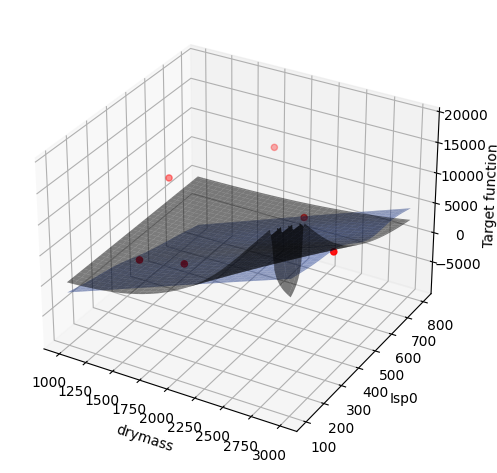

In [18]:
if run_grid_simulation:
    # 3D Plot
    add_bands = False


    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # True surface
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_Z, 
                           alpha = .5, 
                           label='target function',
                           color='black'
                          )
    # Mean predicted
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred1, 
                           alpha = .5, 
                           label='model', # Mean
                           color='royalblue'
                          )
    # True points observed
    ax.scatter(m2_x[:,0], m2_x[:,1], m2_y, marker='o', color='red')

    if add_bands:
        surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred1-2*m2_var_plot_pred1, 
                               alpha = .5, 
                               label='model_ci_lb', # Confidence band lower bound
                               color='lightskyblue'
                              )
        surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred1+2*m2_var_plot_pred1, 
                               alpha = .5, 
                               label='model_ci_ub', # Confidence band upper bound
                               color='lightskyblue' 
                              )
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    ax.set_zlabel('Target function')
    plt.tight_layout()



 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_266/1125577198.py:53: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_266/1125577198.py:62: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_266/1125577198.py:75: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


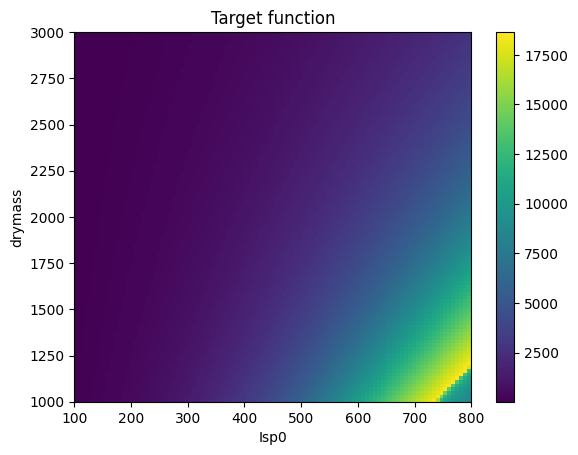

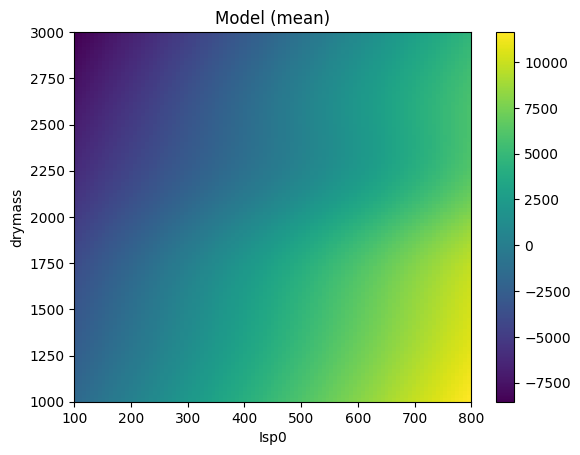

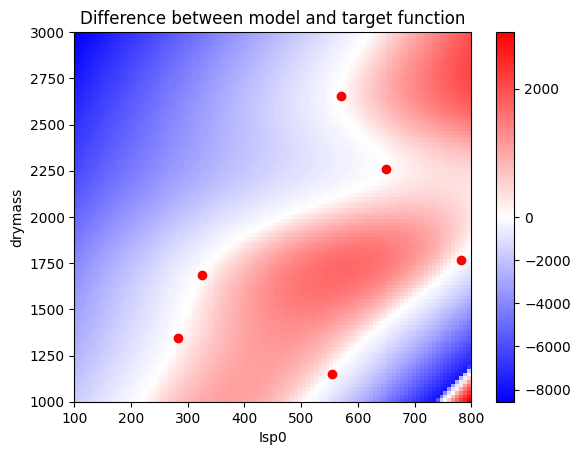

In [19]:
if run_grid_simulation:
    from matplotlib import colors
    divnorm=colors.TwoSlopeNorm(vcenter=0.) # vmin=-5., vcenter=0., vmax=10

#     # NORMAL
#     ## Heatmaps
#     extents = [m2_space.parameters[0].min, m2_space.parameters[0].max, 
#                m2_space.parameters[1].min, m2_space.parameters[1].max]

#     # True values
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_Z, extent=extents, aspect='auto')
#     ax.set_title('Target function')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     fig.colorbar(im, ax=ax)
#     fig.show()

#     # Model
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_mu_plot_pred1, extent=extents, aspect='auto')
#     ax.set_title('Model (mean)')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     fig.colorbar(im, ax=ax)
#     fig.show()


#     # Difference
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_mu_plot_pred1-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm)
#     ax.set_title('Difference between model and target function')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     # Add points where simulation evaluated
#     ax.plot(m2_x[:,0], m2_x[:,1], 'ro')
# #     ax.plot(m2_x[:,1], m2_x[:,0], 'ro')
#     fig.colorbar(im, ax=ax)
#     fig.show()

    # REVERSE
    ## Heatmaps
    extents = [m2_space.parameters[1].min, m2_space.parameters[1].max, 
               m2_space.parameters[0].min, m2_space.parameters[0].max]

    # True values
    fig, ax = plt.subplots()
    im = ax.imshow(m2_Z, extent=extents, aspect='auto', origin='lower')
    ax.set_title('Target function')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    fig.colorbar(im, ax=ax)
    fig.show()

    # Model
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred1, extent=extents, aspect='auto', origin='lower')
    ax.set_title('Model (mean)')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    fig.colorbar(im, ax=ax)
    fig.show()


    # Difference
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred1-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm, origin='lower')
    ax.set_title('Difference between model and target function')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    # Add points where simulation evaluated
#     ax.plot(m2_x[:,0], m2_x[:,1], 'ro')
    ax.plot(m2_x[:,1], m2_x[:,0], 'ro')
    fig.colorbar(im, ax=ax)
    fig.show()



In [20]:
m2_x

array([[1150.73371091,  554.32194897],
       [1767.35508222,  782.09967555],
       [1347.1949688 ,  281.94906623],
       [2652.03383782,  570.19185444],
       [1687.76524597,  325.01579135],
       [2257.8305934 ,  649.6004728 ]])

### Use the model created for model-based experiment design
use the model to decide which are the best points to collect using some data collection criteria (that we call acquisition).

In [21]:
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance


In [22]:
# help(ExperimentalDesignLoop)

 It is known that when using Gaussian processes, selecting points of maximum variance is equivalent to maximizing the mutual information between the model and the new set of points so using ModelVariance is a simple but mathematically grounded approach.
 
 Actually in this example we use IVR

In [23]:
m2_2_model_emukit = m2_model_emukit

In [24]:
wirte_output_txt = False

integrated_variance = IntegratedVarianceReduction(space=m2_space,
                                                  model=m2_2_model_emukit)
m2_ed = ExperimentalDesignLoop(space=m2_space, 
                            model=m2_2_model_emukit, 
                            acquisition = integrated_variance,
                            batch_size = 1) 
# bach size is set to one in this example as we’ll collect evaluations 
# sequentially but parallel evaluations are allowed
m2_ed.run_loop(user_function=run_missile_sim, stopping_condition=5*2)


 /Users/ilariasartori/opt/anaconda3/envs/mlphysical/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



New simulation 

drymass: 2699.491781347472
Isp0: 177.73397986913253


Stage 1 burnout
Velocity (km/s):  0.7623096796178642
Angle (deg h):  43.621662594647034
Range (km):  13.597215091027996
Time (sec):  108.49999999999811
Final results: 
Range (km):  89.441777721607
Apogee (km):  33.84677991843081
Time to target (sec):  246.59999999999027



New simulation 

drymass: 2921.8103247936538
Isp0: 178.06381467403742


Stage 1 burnout
Velocity (km/s):  0.6936752415147642
Angle (deg h):  43.61684992300822
Range (km):  12.294569512650954
Time (sec):  108.6999999999981
Final results: 
Range (km):  75.91379372194962
Apogee (km):  29.3166184300798
Time to target (sec):  235.89999999999088



New simulation 

drymass: 1844.6335681495937
Isp0: 269.2104059422843


Stage 1 burnout
Velocity (km/s):  1.816271576103309
Angle (deg h):  43.650635215518314
Range (km):  47.77125043067699
Time (sec):  164.29999999999495
Final results: 
Range (km):  459.00745089918667
Apogee (km):  154.67436913673995
Time to

In [25]:
m2_2_model_emukit.__dict__

{'model': <GPy.models.gp_regression.GPRegression at 0x7fd811fc1cc0>,
 'n_restarts': 1}

In [26]:
m2_ed.__dict__

{'candidate_point_calculator': <emukit.core.loop.candidate_point_calculators.SequentialPointCalculator at 0x7fd7f17a13f0>,
 'model_updaters': [<emukit.core.loop.model_updaters.FixedIntervalUpdater at 0x7fd7f1728640>],
 'loop_state': <emukit.core.loop.loop_state.LoopState at 0x7fd7e01b9f60>,
 'loop_start_event': Event([]),
 'iteration_end_event': Event([]),
 'model': <emukit.model_wrappers.gpy_model_wrappers.GPyModelWrapper at 0x7fd800abffd0>}

In [27]:
if run_grid_simulation:
    # Compute new prediction
    m2_mu_plot_grid_pred2, var_plot_grid_pred2 = m2_2_model_emukit.predict(m2_x_plot)
    m2_mu_plot_pred2 = m2_mu_plot_grid_pred2.reshape(m2_x_plot_mesh.shape)
    m2_var_plot_pred2 = var_plot_grid_pred2.reshape(m2_x_plot_mesh.shape)
    
    m2_2_rmse = evaluate_prediction(y_actual=m2_y_plot, y_predicted=m2_mu_plot_grid_pred2)
    print("RMSE m2 (post experiment design loop): ", m2_2_rmse)




RMSE m2 (post experiment design loop):  653.0150291671712


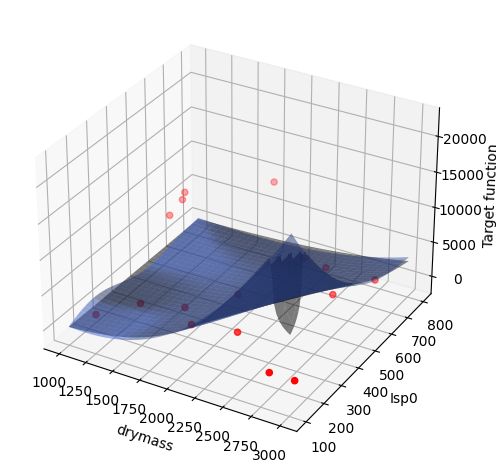

In [28]:
if run_grid_simulation:
    # 3D Plot
    add_bands = False


    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # True surface
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_Z, 
                           alpha = .5, 
                           label='target function',
                           color='black'
                          )
    # Mean predicted
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred2, 
                           alpha = .5, 
                           label='model', # Mean
                           color='royalblue'
                          )
    # True points observed
    ax.scatter(np.array(m2_2_model_emukit.X)[:,0], 
               np.array(m2_2_model_emukit.X)[:,1], m2_2_model_emukit.Y, marker='o', color='red')

    if add_bands:
        surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred2-2*m2_var_plot_pred2, 
                               alpha = .5, 
                               label='model_ci_lb', # Confidence band lower bound
                               color='lightskyblue'
                              )
        surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred2+2*m2_var_plot_pred2, 
                               alpha = .5, 
                               label='model_ci_ub', # Confidence band upper bound
                               color='lightskyblue' 
                              )
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    ax.set_zlabel('Target function')
    plt.tight_layout()




 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_266/3906114016.py:50: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_266/3906114016.py:59: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_266/3906114016.py:73: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


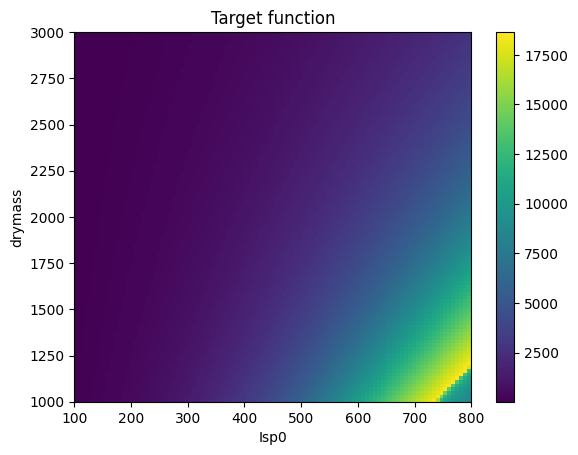

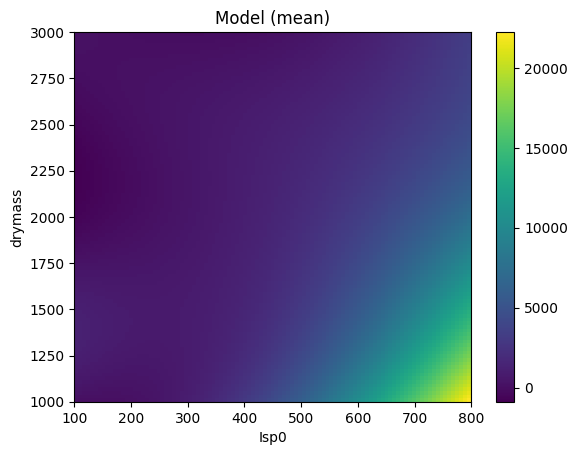

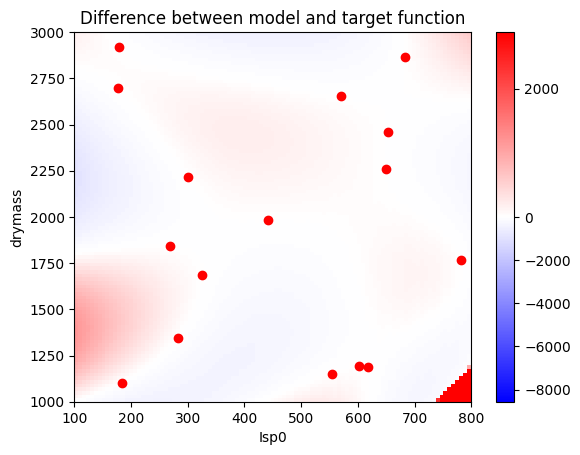

In [29]:
if run_grid_simulation:

#     ## Heatmaps
#     extents = [m2_space.parameters[0].min, m2_space.parameters[0].max, 
#                m2_space.parameters[1].min, m2_space.parameters[1].max]

#     # True values
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_Z, extent=extents, aspect='auto')
#     ax.set_title('Target function')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     fig.colorbar(im, ax=ax)
#     fig.show()

#     # Model
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_mu_plot_pred2, extent=extents, aspect='auto')
#     ax.set_title('Model (mean)')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     fig.colorbar(im, ax=ax)
#     fig.show()


#     # Difference
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_mu_plot_pred2-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm)
#     ax.set_title('Difference between model and target function')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     ax.plot(np.array(m2_2_model_emukit.X)[:,0], np.array(m2_2_model_emukit.X)[:,1], 'ro')
#     fig.colorbar(im, ax=ax)
#     fig.show()

#     # ax.plot(m2_x, m2_y, marker='o', color='red')
    
    # REVERSE
    ## Heatmaps
    extents = [m2_space.parameters[1].min, m2_space.parameters[1].max, 
               m2_space.parameters[0].min, m2_space.parameters[0].max]

    # True values
    fig, ax = plt.subplots()
    im = ax.imshow(m2_Z, extent=extents, aspect='auto', origin='lower')
    ax.set_title('Target function')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    fig.colorbar(im, ax=ax)
    fig.show()

    # Model
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred2, extent=extents, aspect='auto', origin='lower')
    ax.set_title('Model (mean)')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    fig.colorbar(im, ax=ax)
    fig.show()


    # Difference
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred2-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm, origin='lower')
    ax.set_title('Difference between model and target function')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    # Add points where simulation evaluated
#     ax.plot(m2_x[:,0], m2_x[:,1], 'ro')
#     ax.plot(m2_x[:,1], m2_x[:,0], 'ro')
    ax.plot(np.array(m2_2_model_emukit.X)[:,1], np.array(m2_2_model_emukit.X)[:,0], 'ro')
    fig.colorbar(im, ax=ax)
    fig.show()

